In [1]:
# Running at commit 30e3836987dcf62c37fc47f0115dc614710fe51b

In [2]:
%reload_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
import os
import numpy
import csv


from nplinker import nplinker
from nplinker import logconfig
logconfig.LogConfig.setLogLevel('DEBUG') # 'INFO' is a lot less spammy
from nplinker.scoring import IOKR


['/home/grimur/miniconda2/envs/jupyter-py3/lib/python3.7/site-packages/cdk_pywrapper']
Server process already running: True


In [4]:
# Load the data into the NPLinker framework

In [5]:
nplinker_data_path = '/home/grimur/data-crusemann/nplinker_crusemann_20200131/crusemann_new.toml'
gnps_spectrum_file = "/home/grimur/iokr_verify_data/crusemann/extracted/MSV000078836/clusterinfosummarygroup_attributes_withIDs_withcomponentID/b270f7e260f34e808ead3f642784b672.tsv"
mibig_molecular_structures = '/home/grimur/_iokr/data/mibig/compunds_structures_2.0.csv'

In [6]:
npl = nplinker.NPLinker(nplinker_data_path)

20:29:10 [DEBUG] config.py:71, Parsing default config file: /home/grimur/.config/nplinker/nplinker.toml
20:29:10 [DEBUG] config.py:74, Loading user config /home/grimur/data-crusemann/nplinker_crusemann_20200131/crusemann_new.toml
20:29:10 [INFO] config.py:106, Loading from local data in directory /home/grimur/data-crusemann/nplinker_crusemann_26112019
20:29:10 [DEBUG] loader.py:129, DatasetLoader(/home/grimur/data-crusemann/nplinker_crusemann_26112019, , False)
20:29:10 [DEBUG] nplinker.py:119, Enabled scoring method: metcalf
20:29:10 [DEBUG] nplinker.py:119, Enabled scoring method: testscore
20:29:10 [DEBUG] nplinker.py:119, Enabled scoring method: rosetta


In [7]:
npl.load_data()

20:29:10 [DEBUG] nplinker.py:240, load_data (normal case, full load, met_only=False)
20:29:10 [WARNING] loader.py:31, WARNING: unable to find extra_nodes_file in path "/home/grimur/data-crusemann/nplinker_crusemann_26112019/quantification_table_reformatted/*.csv"
20:29:10 [WARNING] loader.py:31, WARNING: unable to find metadata_table_file in path "/home/grimur/data-crusemann/nplinker_crusemann_26112019/metadata_table/metadata_table*.txt"
20:29:10 [WARNING] loader.py:31, WARNING: unable to find quantification_table_file in path "/home/grimur/data-crusemann/nplinker_crusemann_26112019/quantification_table/quantification_table*.csv"
20:29:10 [INFO] loader.py:448, Loaded global strain IDs (162 total)
20:29:10 [INFO] loader.py:459, Loaded dataset strain IDs (162 total)
20:29:11 [INFO] metabolomics.py:634, 6246 molecules parsed from MGF file
20:29:11 [DEBUG] metabolomics.py:331, loading edges file: /home/grimur/iokr_verify_data/crusemann/extracted/MSV000078836/networkedges_selfloop/865b124c0

20:29:11 [WARNING] metabolomics.py:517, Unknown strain: 26c.mzXML for cluster index 58621
20:29:11 [WARNING] metabolomics.py:517, Unknown strain: 35c.mzXML for cluster index 58621
20:29:11 [WARNING] metabolomics.py:517, Unknown strain: 28a.mzXML for cluster index 58621
20:29:11 [WARNING] metabolomics.py:517, Unknown strain: 29a.mzXML for cluster index 59110
20:29:11 [WARNING] metabolomics.py:517, Unknown strain: 29c.mzXML for cluster index 59110
20:29:11 [WARNING] metabolomics.py:517, Unknown strain: 27b.mzXML for cluster index 59110
20:29:11 [WARNING] metabolomics.py:517, Unknown strain: 12b.mzXML for cluster index 93250
20:29:11 [WARNING] metabolomics.py:532, 81 unknown strains were detected a total of 8194 times
20:29:11 [DEBUG] metabolomics.py:692, make_families: 494 molams + 2600 singletons
20:29:11 [WARNING] loader.py:427, Writing unknown strains from METABOLOMICS data to /home/grimur/data-crusemann/nplinker_crusemann_26112019/unknown_strains_met.csv
20:29:11 [INFO] loader.py:434

True

In [8]:
# Assmeble spectrum-to-strains mapping from GNPS data

In [9]:
spectra_to_strains = {}
with open(gnps_spectrum_file, 'r') as f:
    r = csv.reader(f, delimiter="\t")
    header = next(r)
    id_column = header.index('cluster index')
    strain_columns = [x for x in range(len(header)) if header[x].startswith('C') and len(header[x]) == 6]
    for line in r:
        spectrum_id = line[id_column]
        member_strains = [header[x] for x in range(len(line)) if line[x] != '0' and x in strain_columns]
        spectra_to_strains[int(spectrum_id)] = member_strains
        

In [10]:
# Assign known_cluster_blast hits to BGCs

In [11]:
from nplinker.parsers.kcb import KCBParser

In [12]:
kkb_bgc_hits = {}
for bgc in npl.bgcs:
    kcb_filename = KCBParser.get_kcb_filename_from_bgc(bgc)
    kcb_parser = KCBParser(kcb_filename)
    hits = []
    for mibig_id, hit in kcb_parser.hits.items():
        score = numpy.sum([x['blast_score'] for x in hit['individual_hits']])
        hits.append((mibig_id, score))
    if len(hits) > 0:
        kkb_bgc_hits[bgc] = hits

In [13]:
print('BGCs with KKB hits: {}'.format(len(kkb_bgc_hits)))
# Should be 2808

BGCs with KKB hits: 2808


In [14]:
# Define the links to look for
# These are the links from the paired data platform - so, _verified_ links!!!

In [15]:
established_links = [
    ('CNS205', 'BGC0000827', 206),
    ('CNS205', 'BGC0000333', 489),
    ('CNB440', 'BGC0000940', 25),
    ('CNB440', 'BGC0000241', 381),
    ('CNT005', 'BGC0001228', 492),
    ('CNS205', 'BGC0000137', 353),
    ('CNS205', 'BGC0000137', 358),
    ('CNS237', 'BGC0001830', 309)
]

In [16]:
established_link_objects = []
for bgc, kkb_hits in kkb_bgc_hits.items():
    for strain_id, mibig_id, molfam_id in established_links:
        if strain_id == bgc.strain.id or strain_id in bgc.strain.aliases:
            if mibig_id in [x[0] for x in kkb_hits if x[1] > 10000]:
                for molecular_family in npl.molfams:
                    if molecular_family.family_id == molfam_id:
                        for spectrum in molecular_family.spectra:
                            # If we want to do this properly (i.e. using the strain objects on the spectra themselves) then this is broken!
                            if strain_id not in spectra_to_strains[spectrum.spectrum_id]:
                                continue
                            print(strain_id, bgc.id, mibig_id, spectrum.spectrum_id)
                            established_link_objects.append((bgc, spectrum))
                        


CNS205 394 BGC0000137 72702
CNS205 394 BGC0000137 72970
CNS205 394 BGC0000137 73005
CNS205 394 BGC0000137 70606
CNS205 394 BGC0000137 75146
CNS205 394 BGC0000137 75653
CNS205 711 BGC0000137 72702
CNS205 711 BGC0000137 72970
CNS205 711 BGC0000137 73005
CNS205 711 BGC0000137 70606
CNS205 711 BGC0000137 75146
CNS205 711 BGC0000137 75653
CNS205 739 BGC0000333 120697
CNS205 739 BGC0000333 121052
CNS205 739 BGC0000333 121600
CNS205 739 BGC0000333 122023
CNT005 990 BGC0001228 123724
CNT005 990 BGC0001228 123881
CNT005 990 BGC0001228 123903
CNS205 1642 BGC0000827 41257
CNS205 1642 BGC0000827 41544
CNS205 1642 BGC0000827 44160
CNS205 1642 BGC0000827 44161
CNS205 1642 BGC0000827 44982
CNS237 2104 BGC0001830 58728
CNS237 2104 BGC0001830 62174
CNS237 2104 BGC0001830 63507
CNS237 2104 BGC0001830 63775
CNS237 2104 BGC0001830 65471
CNS237 2104 BGC0001830 66182
CNS237 2104 BGC0001830 66400
CNS237 2104 BGC0001830 67887
CNS237 2104 BGC0001830 68743
CNS237 2104 BGC0001830 93193
CNS237 2104 BGC0001830 997

In [17]:
print('Number of verified link objects: {}'.format(len(established_link_objects)))

Number of verified link objects: 39


In [18]:
# Load MIBiG structural information

In [19]:
bgc_structures = {}
with open(mibig_molecular_structures) as f:
    r = csv.reader(f)
    for line in r:
        bgc_id, compound_name, smiles, database_ids = line
        if not bgc_id.startswith('BGC'):
            continue
        if bgc_id in bgc_structures:
            bgc_structures[bgc_id].append(smiles)
        else:
            bgc_structures[bgc_id] = [smiles]

In [20]:
# Assign SMILES structures to BGCs

In [21]:
scores_thresh = 10000
bgc_smiles = []
bgc_smiles_index = []
bgc_smiles_scores = []

bgc_smiles_lookup = {}

#debug with only members of known links
#bgc_list = [x[0] for x in established_link_objects]
bgc_list = npl.bgcs
for bgc_idx, bgc in enumerate(bgc_list):
    current_bgc_smiles = set([])
    if bgc in kkb_bgc_hits:
        kkb_bgc = kkb_bgc_hits[bgc][0][0]
        smiles_list = bgc_structures[kkb_bgc]
        for smiles in smiles_list:
            if smiles != '':
                current_bgc_smiles.add(smiles)
                        
    bgc_smiles_lookup[bgc] = current_bgc_smiles
                
    for smiles in current_bgc_smiles:
        bgc_smiles.append(smiles)
        bgc_smiles_index.append(bgc_idx)

In [22]:
print('total bgc with associated structure: {}'.format(len(set(bgc_smiles_index))))
print('total bgcs: {}'.format(len(npl.bgcs)))
print('total spectra: {}'.format(len(npl.spectra)))

total bgc with associated structure: 2242
total bgcs: 3316
total spectra: 6246


In [23]:
# Define the reverse lookup table (SMILES -> BGC)

In [24]:
reverse_smiles_lookup = {}
for smiles, bgc_idx in zip(bgc_smiles, bgc_smiles_index):
    if smiles not in reverse_smiles_lookup:
        reverse_smiles_lookup[smiles] = []
    reverse_smiles_lookup[smiles].append(bgc_idx)

In [25]:
smiles_list = list(reverse_smiles_lookup.keys())

In [26]:
# Initialise IOKR

In [27]:
from nplinker.scoring.iokr import nplinker_iokr

In [47]:
iokr_server = nplinker_iokr.get_iokr_server()


20:44:22 [DEBUG] nplinker_iokr.py:202, Init IOKR data server
20:44:22 [DEBUG] iokrdata.py:202, IOKRDataServer __init__
20:44:22 [DEBUG] iokrdata.py:38, GNPS __init__
20:44:22 [DEBUG] iokrdata.py:210, No kernel specified. Please initialise manually.
20:44:22 [DEBUG] nplinker_iokr.py:207, Init kernel values
20:44:23 [DEBUG] nplinker_iokr.py:212, Load MS files
20:44:23 [DEBUG] iokrdata.py:226, IOKRDataServer load_ms_files
20:44:23 [DEBUG] iokrdata.py:228, Loading cached MS data
20:44:23 [DEBUG] iokrdata.py:232, Done in 0.496943s
20:44:23 [DEBUG] nplinker_iokr.py:235, Configure kernel
20:44:23 [DEBUG] nplinker_iokr.py:240, Set fingerprint
20:44:23 [DEBUG] iokrdata.py:327, IOKRDataServer set_fingerprint
20:44:23 [DEBUG] iokrdata.py:335, fpfile is "/home/grimur/git/nplinker/nplinker/prototype/nplinker/scoring/iokr/data/fp_None_gnps.bin.npy"
20:44:23 [DEBUG] iokrdata.py:337, Loading GNPS fingerprints from file
20:44:23 [DEBUG] iokrdata.py:69, GNPS set_fingerprint_from_file
20:44:23 [DEBUG] np

In [48]:
# IOKR requires slightly different type of MS spectrum object

In [49]:
from nplinker.scoring.iokr.spectrum import MSSpectrum

In [50]:
# Debug with only members of known links
# spectra_list = [x[1] for x in established_link_objects]
spectra_list = npl.spectra
spl = [MSSpectrum(spec=x) for x in spectra_list]

In [51]:
# spl investigation - how do the MS2 objects look?

In [121]:
import copy

def run_peak_detection(spectrum, smiles_list):
    ms = MSSpectrum(spec=spectrum)

    #print(ms.raw_spectrum.shape)
    
    spec_list_to_run = [copy.deepcopy(ms)]
    mz_list = [None]
    for i in range(len(ms.raw_spectrum)):
        ms_c = copy.deepcopy(ms)
        mz, intensity = ms_c.raw_spectrum[i,:]
        ms_c.raw_spectrum = numpy.delete(ms_c.raw_spectrum, obj=i, axis=0)
        #print(ms_c.raw_spectrum.shape)
        spec_list_to_run.append(ms_c)
        mz_list.append(mz)
        
    result_scores = iokr_server.score_smiles(spec_list_to_run, smiles_list)
    
    return result_scores, mz_list

In [43]:
peak_detection_scores = run_peak_detection(npl.spectra[11], smiles_list)

20:41:05 [DEBUG] nplinker_iokr.py:142, Rank spectrum 11 (0/10)
20:41:05 [DEBUG] nplinker_iokr.py:144, kernel vector
20:41:06 [DEBUG] nplinker_iokr.py:148, done (0.9722442626953125)
20:41:06 [DEBUG] nplinker_iokr.py:149, project
20:41:06 [DEBUG] nplinker_iokr.py:153, done (0.0014264583587646484)
20:41:06 [DEBUG] nplinker_iokr.py:155, save distances
20:41:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 11 (1/10)
20:41:06 [DEBUG] nplinker_iokr.py:144, kernel vector
20:41:07 [DEBUG] nplinker_iokr.py:148, done (0.9786555767059326)
20:41:07 [DEBUG] nplinker_iokr.py:149, project
20:41:07 [DEBUG] nplinker_iokr.py:153, done (0.0014846324920654297)
20:41:07 [DEBUG] nplinker_iokr.py:155, save distances
20:41:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 11 (2/10)
20:41:07 [DEBUG] nplinker_iokr.py:144, kernel vector
20:41:08 [DEBUG] nplinker_iokr.py:148, done (0.9796843528747559)
20:41:08 [DEBUG] nplinker_iokr.py:149, project
20:41:08 [DEBUG] nplinker_iokr.py:153, done (0.0013909339904785156)
20:4

In [122]:
def check_peak_influence(bgc, spectrum, smiles_list):
    peak_detection_scores, filtered_mz = run_peak_detection(spectrum, smiles_list)
    bgc_smiles_list = bgc_smiles_lookup[bgc]
    
    peak_rankings = []
    for peak_filter_idx in range(peak_detection_scores.shape[0]):
        scores_for_this_peak = peak_detection_scores[peak_filter_idx,:]
        peak_mz = filtered_mz[peak_filter_idx]
        potential_scores = []
        for smiles in bgc_smiles_list:
            smiles_index = smiles_list.index(smiles)
            spectrum_smiles_score = peak_detection_scores[peak_filter_idx, smiles_index]
            potential_scores.append(spectrum_smiles_score)
            
        true_score = max(potential_scores)
        
        scores_for_this_peak = list(scores_for_this_peak)
        scores_for_this_peak.sort(reverse=True)
        link_idx = list(scores_for_this_peak).index(true_score)
        
        peak_rankings.append((peak_filter_idx, link_idx, peak_mz, true_score))
        
    return peak_rankings
            
    

In [123]:
check_peak_influence(npl.bgcs[11], npl.spectra[11], smiles_list)

22:28:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 11 (0/10)
22:28:45 [DEBUG] nplinker_iokr.py:144, kernel vector
22:28:46 [DEBUG] nplinker_iokr.py:148, done (0.99904465675354)
22:28:46 [DEBUG] nplinker_iokr.py:149, project
22:28:46 [DEBUG] nplinker_iokr.py:153, done (0.0015380382537841797)
22:28:46 [DEBUG] nplinker_iokr.py:155, save distances
22:28:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 11 (1/10)
22:28:46 [DEBUG] nplinker_iokr.py:144, kernel vector
22:28:47 [DEBUG] nplinker_iokr.py:148, done (0.9928348064422607)
22:28:47 [DEBUG] nplinker_iokr.py:149, project
22:28:47 [DEBUG] nplinker_iokr.py:153, done (0.0015418529510498047)
22:28:47 [DEBUG] nplinker_iokr.py:155, save distances
22:28:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 11 (2/10)
22:28:47 [DEBUG] nplinker_iokr.py:144, kernel vector
22:28:48 [DEBUG] nplinker_iokr.py:148, done (0.9900462627410889)
22:28:48 [DEBUG] nplinker_iokr.py:149, project
22:28:48 [DEBUG] nplinker_iokr.py:153, done (0.0017018318176269531)
22:28:

[(0, 86, None, 0.028025445023355362),
 (1, 107, 105.065002, 0.013448959198372554),
 (2, 78, 107.065002, 0.024995398904021242),
 (3, 80, 108.089996, 0.022328063058788154),
 (4, 78, 109.068001, 0.027869517286991295),
 (5, 89, 111.094002, 0.027748465462635964),
 (6, 57, 169.061996, 0.0301179266238906),
 (7, 68, 170.065002, 0.03511731161915138),
 (8, 83, 250.729004, 0.024216884028401164),
 (9, 86, 267.07901, 0.028025445023355362)]

In [62]:
print(peak_detection_scores.shape)

(9, 273)


In [54]:
all_res = []
for bgc, spectrum in established_link_objects:
    res = check_peak_influence(bgc, spectrum, smiles_list)
    all_res.append(res)

20:44:38 [DEBUG] nplinker_iokr.py:119, cache miss
20:44:38 [DEBUG] nplinker_iokr.py:120, Calculate fingerprints for candidate set
20:44:38 [DEBUG] nplinker_iokr.py:124, done 0/273
20:44:39 [DEBUG] nplinker_iokr.py:124, done 1/273
20:44:39 [DEBUG] nplinker_iokr.py:124, done 2/273
20:44:39 [DEBUG] nplinker_iokr.py:124, done 3/273
20:44:40 [DEBUG] nplinker_iokr.py:124, done 4/273
20:44:40 [DEBUG] nplinker_iokr.py:124, done 5/273
20:44:40 [DEBUG] nplinker_iokr.py:124, done 6/273
20:44:41 [DEBUG] nplinker_iokr.py:124, done 7/273
20:44:41 [DEBUG] nplinker_iokr.py:124, done 8/273
20:44:42 [DEBUG] nplinker_iokr.py:124, done 9/273
20:44:42 [DEBUG] nplinker_iokr.py:124, done 10/273
20:44:42 [DEBUG] nplinker_iokr.py:124, done 11/273
20:44:43 [DEBUG] nplinker_iokr.py:124, done 12/273
20:44:43 [DEBUG] nplinker_iokr.py:124, done 13/273
20:44:43 [DEBUG] nplinker_iokr.py:124, done 14/273
20:44:44 [DEBUG] nplinker_iokr.py:124, done 15/273
20:44:44 [DEBUG] nplinker_iokr.py:124, done 16/273
20:44:44 [DEB

20:45:36 [DEBUG] nplinker_iokr.py:124, done 158/273
20:45:36 [DEBUG] nplinker_iokr.py:124, done 159/273
20:45:36 [DEBUG] nplinker_iokr.py:124, done 160/273
20:45:37 [DEBUG] nplinker_iokr.py:124, done 161/273
20:45:37 [DEBUG] nplinker_iokr.py:124, done 162/273
20:45:37 [DEBUG] nplinker_iokr.py:124, done 163/273
20:45:38 [DEBUG] nplinker_iokr.py:124, done 164/273
20:45:38 [DEBUG] nplinker_iokr.py:124, done 165/273
20:45:38 [DEBUG] nplinker_iokr.py:124, done 166/273
20:45:39 [DEBUG] nplinker_iokr.py:124, done 167/273
20:45:39 [DEBUG] nplinker_iokr.py:124, done 168/273
20:45:39 [DEBUG] nplinker_iokr.py:124, done 169/273
20:45:39 [DEBUG] nplinker_iokr.py:124, done 170/273
20:45:40 [DEBUG] nplinker_iokr.py:124, done 171/273
20:45:40 [DEBUG] nplinker_iokr.py:124, done 172/273
20:45:40 [DEBUG] nplinker_iokr.py:124, done 173/273
20:45:41 [DEBUG] nplinker_iokr.py:124, done 174/273
20:45:41 [DEBUG] nplinker_iokr.py:124, done 175/273
20:45:41 [DEBUG] nplinker_iokr.py:124, done 176/273
20:45:42 [DE

20:48:45 [DEBUG] nplinker_iokr.py:155, save distances
20:48:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3737 (6/31)
20:48:45 [DEBUG] nplinker_iokr.py:144, kernel vector
20:48:46 [DEBUG] nplinker_iokr.py:148, done (0.9862620830535889)
20:48:46 [DEBUG] nplinker_iokr.py:149, project
20:48:46 [DEBUG] nplinker_iokr.py:153, done (0.0014796257019042969)
20:48:46 [DEBUG] nplinker_iokr.py:155, save distances
20:48:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3737 (7/31)
20:48:46 [DEBUG] nplinker_iokr.py:144, kernel vector
20:48:47 [DEBUG] nplinker_iokr.py:148, done (0.9875211715698242)
20:48:47 [DEBUG] nplinker_iokr.py:149, project
20:48:47 [DEBUG] nplinker_iokr.py:153, done (0.0014481544494628906)
20:48:47 [DEBUG] nplinker_iokr.py:155, save distances
20:48:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3737 (8/31)
20:48:47 [DEBUG] nplinker_iokr.py:144, kernel vector
20:48:48 [DEBUG] nplinker_iokr.py:148, done (0.9815940856933594)
20:48:48 [DEBUG] nplinker_iokr.py:149, project
20:48:48 [DE

20:49:07 [DEBUG] nplinker_iokr.py:144, kernel vector
20:49:08 [DEBUG] nplinker_iokr.py:148, done (0.9687104225158691)
20:49:08 [DEBUG] nplinker_iokr.py:149, project
20:49:08 [DEBUG] nplinker_iokr.py:153, done (0.0014660358428955078)
20:49:08 [DEBUG] nplinker_iokr.py:155, save distances
20:49:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3737 (30/31)
20:49:08 [DEBUG] nplinker_iokr.py:144, kernel vector
20:49:09 [DEBUG] nplinker_iokr.py:148, done (0.9716849327087402)
20:49:09 [DEBUG] nplinker_iokr.py:149, project
20:49:09 [DEBUG] nplinker_iokr.py:153, done (0.0014352798461914062)
20:49:09 [DEBUG] nplinker_iokr.py:155, save distances
20:49:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3758 (0/33)
20:49:09 [DEBUG] nplinker_iokr.py:144, kernel vector
20:49:10 [DEBUG] nplinker_iokr.py:148, done (0.9761314392089844)
20:49:10 [DEBUG] nplinker_iokr.py:149, project
20:49:10 [DEBUG] nplinker_iokr.py:153, done (0.0014946460723876953)
20:49:10 [DEBUG] nplinker_iokr.py:155, save distances
20:49:10

20:49:31 [DEBUG] nplinker_iokr.py:149, project
20:49:31 [DEBUG] nplinker_iokr.py:153, done (0.0015218257904052734)
20:49:31 [DEBUG] nplinker_iokr.py:155, save distances
20:49:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3758 (22/33)
20:49:31 [DEBUG] nplinker_iokr.py:144, kernel vector
20:49:32 [DEBUG] nplinker_iokr.py:148, done (0.96993088722229)
20:49:32 [DEBUG] nplinker_iokr.py:149, project
20:49:32 [DEBUG] nplinker_iokr.py:153, done (0.0014963150024414062)
20:49:32 [DEBUG] nplinker_iokr.py:155, save distances
20:49:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3758 (23/33)
20:49:32 [DEBUG] nplinker_iokr.py:144, kernel vector
20:49:33 [DEBUG] nplinker_iokr.py:148, done (0.9816219806671143)
20:49:33 [DEBUG] nplinker_iokr.py:149, project
20:49:33 [DEBUG] nplinker_iokr.py:153, done (0.0014481544494628906)
20:49:33 [DEBUG] nplinker_iokr.py:155, save distances
20:49:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3758 (24/33)
20:49:33 [DEBUG] nplinker_iokr.py:144, kernel vector
20:49:34

20:49:53 [DEBUG] nplinker_iokr.py:155, save distances
20:49:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3759 (12/22)
20:49:53 [DEBUG] nplinker_iokr.py:144, kernel vector
20:49:54 [DEBUG] nplinker_iokr.py:148, done (0.970890998840332)
20:49:54 [DEBUG] nplinker_iokr.py:149, project
20:49:54 [DEBUG] nplinker_iokr.py:153, done (0.0016443729400634766)
20:49:54 [DEBUG] nplinker_iokr.py:155, save distances
20:49:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3759 (13/22)
20:49:54 [DEBUG] nplinker_iokr.py:144, kernel vector
20:49:55 [DEBUG] nplinker_iokr.py:148, done (0.9666225910186768)
20:49:55 [DEBUG] nplinker_iokr.py:149, project
20:49:55 [DEBUG] nplinker_iokr.py:153, done (0.0016484260559082031)
20:49:55 [DEBUG] nplinker_iokr.py:155, save distances
20:49:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3759 (14/22)
20:49:55 [DEBUG] nplinker_iokr.py:144, kernel vector
20:49:56 [DEBUG] nplinker_iokr.py:148, done (0.9668562412261963)
20:49:56 [DEBUG] nplinker_iokr.py:149, project
20:49:56 [

20:50:16 [DEBUG] nplinker_iokr.py:144, kernel vector
20:50:17 [DEBUG] nplinker_iokr.py:148, done (0.9906635284423828)
20:50:17 [DEBUG] nplinker_iokr.py:149, project
20:50:17 [DEBUG] nplinker_iokr.py:153, done (0.001386404037475586)
20:50:17 [DEBUG] nplinker_iokr.py:155, save distances
20:50:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3672 (14/32)
20:50:17 [DEBUG] nplinker_iokr.py:144, kernel vector
20:50:18 [DEBUG] nplinker_iokr.py:148, done (0.990349531173706)
20:50:18 [DEBUG] nplinker_iokr.py:149, project
20:50:18 [DEBUG] nplinker_iokr.py:153, done (0.001413583755493164)
20:50:18 [DEBUG] nplinker_iokr.py:155, save distances
20:50:18 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3672 (15/32)
20:50:18 [DEBUG] nplinker_iokr.py:144, kernel vector
20:50:19 [DEBUG] nplinker_iokr.py:148, done (0.9905796051025391)
20:50:19 [DEBUG] nplinker_iokr.py:149, project
20:50:19 [DEBUG] nplinker_iokr.py:153, done (0.0013954639434814453)
20:50:19 [DEBUG] nplinker_iokr.py:155, save distances
20:50:19 [

20:50:40 [DEBUG] nplinker_iokr.py:149, project
20:50:40 [DEBUG] nplinker_iokr.py:153, done (0.0014705657958984375)
20:50:40 [DEBUG] nplinker_iokr.py:155, save distances
20:50:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (5/36)
20:50:40 [DEBUG] nplinker_iokr.py:144, kernel vector
20:50:41 [DEBUG] nplinker_iokr.py:148, done (0.9945862293243408)
20:50:41 [DEBUG] nplinker_iokr.py:149, project
20:50:41 [DEBUG] nplinker_iokr.py:153, done (0.0014176368713378906)
20:50:41 [DEBUG] nplinker_iokr.py:155, save distances
20:50:41 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (6/36)
20:50:41 [DEBUG] nplinker_iokr.py:144, kernel vector
20:50:42 [DEBUG] nplinker_iokr.py:148, done (0.9922685623168945)
20:50:42 [DEBUG] nplinker_iokr.py:149, project
20:50:42 [DEBUG] nplinker_iokr.py:153, done (0.0014586448669433594)
20:50:42 [DEBUG] nplinker_iokr.py:155, save distances
20:50:42 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (7/36)
20:50:42 [DEBUG] nplinker_iokr.py:144, kernel vector
20:50:43 

20:51:03 [DEBUG] nplinker_iokr.py:155, save distances
20:51:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (28/36)
20:51:03 [DEBUG] nplinker_iokr.py:144, kernel vector
20:51:04 [DEBUG] nplinker_iokr.py:148, done (0.9968061447143555)
20:51:04 [DEBUG] nplinker_iokr.py:149, project
20:51:04 [DEBUG] nplinker_iokr.py:153, done (0.001382589340209961)
20:51:04 [DEBUG] nplinker_iokr.py:155, save distances
20:51:04 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (29/36)
20:51:04 [DEBUG] nplinker_iokr.py:144, kernel vector
20:51:05 [DEBUG] nplinker_iokr.py:148, done (0.9911684989929199)
20:51:05 [DEBUG] nplinker_iokr.py:149, project
20:51:05 [DEBUG] nplinker_iokr.py:153, done (0.0014002323150634766)
20:51:05 [DEBUG] nplinker_iokr.py:155, save distances
20:51:05 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (30/36)
20:51:05 [DEBUG] nplinker_iokr.py:144, kernel vector
20:51:06 [DEBUG] nplinker_iokr.py:148, done (0.9961731433868408)
20:51:06 [DEBUG] nplinker_iokr.py:149, project
20:51:06 [

20:51:26 [DEBUG] nplinker_iokr.py:144, kernel vector
20:51:27 [DEBUG] nplinker_iokr.py:148, done (0.9792337417602539)
20:51:27 [DEBUG] nplinker_iokr.py:149, project
20:51:27 [DEBUG] nplinker_iokr.py:153, done (0.001428365707397461)
20:51:27 [DEBUG] nplinker_iokr.py:155, save distances
20:51:27 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (16/46)
20:51:27 [DEBUG] nplinker_iokr.py:144, kernel vector
20:51:28 [DEBUG] nplinker_iokr.py:148, done (0.9793741703033447)
20:51:28 [DEBUG] nplinker_iokr.py:149, project
20:51:28 [DEBUG] nplinker_iokr.py:153, done (0.0014832019805908203)
20:51:28 [DEBUG] nplinker_iokr.py:155, save distances
20:51:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (17/46)
20:51:28 [DEBUG] nplinker_iokr.py:144, kernel vector
20:51:28 [DEBUG] nplinker_iokr.py:148, done (0.9785935878753662)
20:51:28 [DEBUG] nplinker_iokr.py:149, project
20:51:28 [DEBUG] nplinker_iokr.py:153, done (0.0014147758483886719)
20:51:28 [DEBUG] nplinker_iokr.py:155, save distances
20:51:28

20:51:49 [DEBUG] nplinker_iokr.py:149, project
20:51:49 [DEBUG] nplinker_iokr.py:153, done (0.0014927387237548828)
20:51:49 [DEBUG] nplinker_iokr.py:155, save distances
20:51:49 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (39/46)
20:51:49 [DEBUG] nplinker_iokr.py:144, kernel vector
20:51:50 [DEBUG] nplinker_iokr.py:148, done (0.995567798614502)
20:51:50 [DEBUG] nplinker_iokr.py:149, project
20:51:50 [DEBUG] nplinker_iokr.py:153, done (0.0014634132385253906)
20:51:50 [DEBUG] nplinker_iokr.py:155, save distances
20:51:50 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (40/46)
20:51:50 [DEBUG] nplinker_iokr.py:144, kernel vector
20:51:51 [DEBUG] nplinker_iokr.py:148, done (0.9876201152801514)
20:51:51 [DEBUG] nplinker_iokr.py:149, project
20:51:51 [DEBUG] nplinker_iokr.py:153, done (0.0015866756439208984)
20:51:51 [DEBUG] nplinker_iokr.py:155, save distances
20:51:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (41/46)
20:51:51 [DEBUG] nplinker_iokr.py:144, kernel vector
20:51:5

20:52:12 [DEBUG] nplinker_iokr.py:155, save distances
20:52:12 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3737 (16/31)
20:52:12 [DEBUG] nplinker_iokr.py:144, kernel vector
20:52:13 [DEBUG] nplinker_iokr.py:148, done (0.991595983505249)
20:52:13 [DEBUG] nplinker_iokr.py:149, project
20:52:13 [DEBUG] nplinker_iokr.py:153, done (0.0014147758483886719)
20:52:13 [DEBUG] nplinker_iokr.py:155, save distances
20:52:13 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3737 (17/31)
20:52:13 [DEBUG] nplinker_iokr.py:144, kernel vector
20:52:14 [DEBUG] nplinker_iokr.py:148, done (0.9989871978759766)
20:52:14 [DEBUG] nplinker_iokr.py:149, project
20:52:14 [DEBUG] nplinker_iokr.py:153, done (0.001430511474609375)
20:52:14 [DEBUG] nplinker_iokr.py:155, save distances
20:52:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3737 (18/31)
20:52:14 [DEBUG] nplinker_iokr.py:144, kernel vector
20:52:15 [DEBUG] nplinker_iokr.py:148, done (0.9853634834289551)
20:52:15 [DEBUG] nplinker_iokr.py:149, project
20:52:15 [D

20:52:35 [DEBUG] nplinker_iokr.py:144, kernel vector
20:52:36 [DEBUG] nplinker_iokr.py:148, done (0.996251106262207)
20:52:36 [DEBUG] nplinker_iokr.py:149, project
20:52:36 [DEBUG] nplinker_iokr.py:153, done (0.0013759136199951172)
20:52:36 [DEBUG] nplinker_iokr.py:155, save distances
20:52:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3758 (9/33)
20:52:36 [DEBUG] nplinker_iokr.py:144, kernel vector
20:52:37 [DEBUG] nplinker_iokr.py:148, done (0.9929161071777344)
20:52:37 [DEBUG] nplinker_iokr.py:149, project
20:52:37 [DEBUG] nplinker_iokr.py:153, done (0.0014052391052246094)
20:52:37 [DEBUG] nplinker_iokr.py:155, save distances
20:52:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3758 (10/33)
20:52:37 [DEBUG] nplinker_iokr.py:144, kernel vector
20:52:38 [DEBUG] nplinker_iokr.py:148, done (0.9930760860443115)
20:52:38 [DEBUG] nplinker_iokr.py:149, project
20:52:38 [DEBUG] nplinker_iokr.py:153, done (0.0013995170593261719)
20:52:38 [DEBUG] nplinker_iokr.py:155, save distances
20:52:38 

20:52:59 [DEBUG] nplinker_iokr.py:149, project
20:52:59 [DEBUG] nplinker_iokr.py:153, done (0.0014083385467529297)
20:52:59 [DEBUG] nplinker_iokr.py:155, save distances
20:52:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3758 (32/33)
20:52:59 [DEBUG] nplinker_iokr.py:144, kernel vector
20:53:00 [DEBUG] nplinker_iokr.py:148, done (0.984656572341919)
20:53:00 [DEBUG] nplinker_iokr.py:149, project
20:53:00 [DEBUG] nplinker_iokr.py:153, done (0.0014383792877197266)
20:53:00 [DEBUG] nplinker_iokr.py:155, save distances
20:53:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3759 (0/22)
20:53:00 [DEBUG] nplinker_iokr.py:144, kernel vector
20:53:01 [DEBUG] nplinker_iokr.py:148, done (0.9832971096038818)
20:53:01 [DEBUG] nplinker_iokr.py:149, project
20:53:01 [DEBUG] nplinker_iokr.py:153, done (0.0013785362243652344)
20:53:01 [DEBUG] nplinker_iokr.py:155, save distances
20:53:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3759 (1/22)
20:53:01 [DEBUG] nplinker_iokr.py:144, kernel vector
20:53:02 

20:53:21 [DEBUG] nplinker_iokr.py:155, save distances
20:53:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3672 (0/32)
20:53:21 [DEBUG] nplinker_iokr.py:144, kernel vector
20:53:22 [DEBUG] nplinker_iokr.py:148, done (0.9847254753112793)
20:53:22 [DEBUG] nplinker_iokr.py:149, project
20:53:22 [DEBUG] nplinker_iokr.py:153, done (0.0014121532440185547)
20:53:22 [DEBUG] nplinker_iokr.py:155, save distances
20:53:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3672 (1/32)
20:53:22 [DEBUG] nplinker_iokr.py:144, kernel vector
20:53:23 [DEBUG] nplinker_iokr.py:148, done (0.9759068489074707)
20:53:23 [DEBUG] nplinker_iokr.py:149, project
20:53:23 [DEBUG] nplinker_iokr.py:153, done (0.001535177230834961)
20:53:23 [DEBUG] nplinker_iokr.py:155, save distances
20:53:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3672 (2/32)
20:53:23 [DEBUG] nplinker_iokr.py:144, kernel vector
20:53:24 [DEBUG] nplinker_iokr.py:148, done (0.9834809303283691)
20:53:24 [DEBUG] nplinker_iokr.py:149, project
20:53:24 [DEB

20:53:44 [DEBUG] nplinker_iokr.py:144, kernel vector
20:53:45 [DEBUG] nplinker_iokr.py:148, done (0.9702720642089844)
20:53:45 [DEBUG] nplinker_iokr.py:149, project
20:53:45 [DEBUG] nplinker_iokr.py:153, done (0.0014808177947998047)
20:53:45 [DEBUG] nplinker_iokr.py:155, save distances
20:53:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3672 (24/32)
20:53:45 [DEBUG] nplinker_iokr.py:144, kernel vector
20:53:46 [DEBUG] nplinker_iokr.py:148, done (0.9720039367675781)
20:53:46 [DEBUG] nplinker_iokr.py:149, project
20:53:46 [DEBUG] nplinker_iokr.py:153, done (0.0015614032745361328)
20:53:46 [DEBUG] nplinker_iokr.py:155, save distances
20:53:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3672 (25/32)
20:53:46 [DEBUG] nplinker_iokr.py:144, kernel vector
20:53:47 [DEBUG] nplinker_iokr.py:148, done (0.9728567600250244)
20:53:47 [DEBUG] nplinker_iokr.py:149, project
20:53:47 [DEBUG] nplinker_iokr.py:153, done (0.0014116764068603516)
20:53:47 [DEBUG] nplinker_iokr.py:155, save distances
20:53:4

20:54:07 [DEBUG] nplinker_iokr.py:149, project
20:54:07 [DEBUG] nplinker_iokr.py:153, done (0.0014760494232177734)
20:54:07 [DEBUG] nplinker_iokr.py:155, save distances
20:54:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (15/36)
20:54:07 [DEBUG] nplinker_iokr.py:144, kernel vector
20:54:08 [DEBUG] nplinker_iokr.py:148, done (0.9871854782104492)
20:54:08 [DEBUG] nplinker_iokr.py:149, project
20:54:08 [DEBUG] nplinker_iokr.py:153, done (0.001604318618774414)
20:54:08 [DEBUG] nplinker_iokr.py:155, save distances
20:54:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (16/36)
20:54:08 [DEBUG] nplinker_iokr.py:144, kernel vector
20:54:09 [DEBUG] nplinker_iokr.py:148, done (0.9889285564422607)
20:54:09 [DEBUG] nplinker_iokr.py:149, project
20:54:09 [DEBUG] nplinker_iokr.py:153, done (0.001477956771850586)
20:54:09 [DEBUG] nplinker_iokr.py:155, save distances
20:54:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (17/36)
20:54:09 [DEBUG] nplinker_iokr.py:144, kernel vector
20:54:10

20:54:30 [DEBUG] nplinker_iokr.py:155, save distances
20:54:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (2/46)
20:54:30 [DEBUG] nplinker_iokr.py:144, kernel vector
20:54:31 [DEBUG] nplinker_iokr.py:148, done (0.9782822132110596)
20:54:31 [DEBUG] nplinker_iokr.py:149, project
20:54:31 [DEBUG] nplinker_iokr.py:153, done (0.0015878677368164062)
20:54:31 [DEBUG] nplinker_iokr.py:155, save distances
20:54:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (3/46)
20:54:31 [DEBUG] nplinker_iokr.py:144, kernel vector
20:54:32 [DEBUG] nplinker_iokr.py:148, done (0.9891462326049805)
20:54:32 [DEBUG] nplinker_iokr.py:149, project
20:54:32 [DEBUG] nplinker_iokr.py:153, done (0.0014214515686035156)
20:54:32 [DEBUG] nplinker_iokr.py:155, save distances
20:54:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (4/46)
20:54:32 [DEBUG] nplinker_iokr.py:144, kernel vector
20:54:33 [DEBUG] nplinker_iokr.py:148, done (0.9738905429840088)
20:54:33 [DEBUG] nplinker_iokr.py:149, project
20:54:33 [DE

20:54:53 [DEBUG] nplinker_iokr.py:144, kernel vector
20:54:54 [DEBUG] nplinker_iokr.py:148, done (0.9732546806335449)
20:54:54 [DEBUG] nplinker_iokr.py:149, project
20:54:54 [DEBUG] nplinker_iokr.py:153, done (0.0014147758483886719)
20:54:54 [DEBUG] nplinker_iokr.py:155, save distances
20:54:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (26/46)
20:54:54 [DEBUG] nplinker_iokr.py:144, kernel vector
20:54:55 [DEBUG] nplinker_iokr.py:148, done (0.9708671569824219)
20:54:55 [DEBUG] nplinker_iokr.py:149, project
20:54:55 [DEBUG] nplinker_iokr.py:153, done (0.001461029052734375)
20:54:55 [DEBUG] nplinker_iokr.py:155, save distances
20:54:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (27/46)
20:54:55 [DEBUG] nplinker_iokr.py:144, kernel vector
20:54:56 [DEBUG] nplinker_iokr.py:148, done (0.9725606441497803)
20:54:56 [DEBUG] nplinker_iokr.py:149, project
20:54:56 [DEBUG] nplinker_iokr.py:153, done (0.0014834403991699219)
20:54:56 [DEBUG] nplinker_iokr.py:155, save distances
20:54:56

20:55:16 [DEBUG] nplinker_iokr.py:149, project
20:55:16 [DEBUG] nplinker_iokr.py:153, done (0.0014393329620361328)
20:55:16 [DEBUG] nplinker_iokr.py:155, save distances
20:55:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6149 (3/39)
20:55:16 [DEBUG] nplinker_iokr.py:144, kernel vector
20:55:17 [DEBUG] nplinker_iokr.py:148, done (0.9775784015655518)
20:55:17 [DEBUG] nplinker_iokr.py:149, project
20:55:17 [DEBUG] nplinker_iokr.py:153, done (0.0013885498046875)
20:55:17 [DEBUG] nplinker_iokr.py:155, save distances
20:55:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6149 (4/39)
20:55:17 [DEBUG] nplinker_iokr.py:144, kernel vector
20:55:18 [DEBUG] nplinker_iokr.py:148, done (0.9761607646942139)
20:55:18 [DEBUG] nplinker_iokr.py:149, project
20:55:18 [DEBUG] nplinker_iokr.py:153, done (0.0014307498931884766)
20:55:18 [DEBUG] nplinker_iokr.py:155, save distances
20:55:18 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6149 (5/39)
20:55:18 [DEBUG] nplinker_iokr.py:144, kernel vector
20:55:19 [DE

20:55:39 [DEBUG] nplinker_iokr.py:155, save distances
20:55:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6149 (26/39)
20:55:39 [DEBUG] nplinker_iokr.py:144, kernel vector
20:55:40 [DEBUG] nplinker_iokr.py:148, done (0.968956470489502)
20:55:40 [DEBUG] nplinker_iokr.py:149, project
20:55:40 [DEBUG] nplinker_iokr.py:153, done (0.0016913414001464844)
20:55:40 [DEBUG] nplinker_iokr.py:155, save distances
20:55:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6149 (27/39)
20:55:40 [DEBUG] nplinker_iokr.py:144, kernel vector
20:55:41 [DEBUG] nplinker_iokr.py:148, done (0.9721100330352783)
20:55:41 [DEBUG] nplinker_iokr.py:149, project
20:55:41 [DEBUG] nplinker_iokr.py:153, done (0.0016665458679199219)
20:55:41 [DEBUG] nplinker_iokr.py:155, save distances
20:55:41 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6149 (28/39)
20:55:41 [DEBUG] nplinker_iokr.py:144, kernel vector
20:55:42 [DEBUG] nplinker_iokr.py:148, done (0.9795670509338379)
20:55:42 [DEBUG] nplinker_iokr.py:149, project
20:55:42 [

20:56:01 [DEBUG] nplinker_iokr.py:144, kernel vector
20:56:02 [DEBUG] nplinker_iokr.py:148, done (0.9785244464874268)
20:56:02 [DEBUG] nplinker_iokr.py:149, project
20:56:02 [DEBUG] nplinker_iokr.py:153, done (0.0015552043914794922)
20:56:02 [DEBUG] nplinker_iokr.py:155, save distances
20:56:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6157 (11/47)
20:56:02 [DEBUG] nplinker_iokr.py:144, kernel vector
20:56:03 [DEBUG] nplinker_iokr.py:148, done (0.9708588123321533)
20:56:03 [DEBUG] nplinker_iokr.py:149, project
20:56:03 [DEBUG] nplinker_iokr.py:153, done (0.0016472339630126953)
20:56:03 [DEBUG] nplinker_iokr.py:155, save distances
20:56:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6157 (12/47)
20:56:03 [DEBUG] nplinker_iokr.py:144, kernel vector
20:56:04 [DEBUG] nplinker_iokr.py:148, done (0.9777195453643799)
20:56:04 [DEBUG] nplinker_iokr.py:149, project
20:56:04 [DEBUG] nplinker_iokr.py:153, done (0.0014162063598632812)
20:56:04 [DEBUG] nplinker_iokr.py:155, save distances
20:56:0

20:56:25 [DEBUG] nplinker_iokr.py:149, project
20:56:25 [DEBUG] nplinker_iokr.py:153, done (0.001634836196899414)
20:56:25 [DEBUG] nplinker_iokr.py:155, save distances
20:56:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6157 (34/47)
20:56:25 [DEBUG] nplinker_iokr.py:144, kernel vector
20:56:26 [DEBUG] nplinker_iokr.py:148, done (0.9799609184265137)
20:56:26 [DEBUG] nplinker_iokr.py:149, project
20:56:26 [DEBUG] nplinker_iokr.py:153, done (0.0013883113861083984)
20:56:26 [DEBUG] nplinker_iokr.py:155, save distances
20:56:26 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6157 (35/47)
20:56:26 [DEBUG] nplinker_iokr.py:144, kernel vector
20:56:27 [DEBUG] nplinker_iokr.py:148, done (0.9766860008239746)
20:56:27 [DEBUG] nplinker_iokr.py:149, project
20:56:27 [DEBUG] nplinker_iokr.py:153, done (0.001535177230834961)
20:56:27 [DEBUG] nplinker_iokr.py:155, save distances
20:56:27 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6157 (36/47)
20:56:27 [DEBUG] nplinker_iokr.py:144, kernel vector
20:56:28

20:56:47 [DEBUG] nplinker_iokr.py:155, save distances
20:56:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6174 (10/24)
20:56:47 [DEBUG] nplinker_iokr.py:144, kernel vector
20:56:48 [DEBUG] nplinker_iokr.py:148, done (0.9746036529541016)
20:56:48 [DEBUG] nplinker_iokr.py:149, project
20:56:48 [DEBUG] nplinker_iokr.py:153, done (0.0014796257019042969)
20:56:48 [DEBUG] nplinker_iokr.py:155, save distances
20:56:48 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6174 (11/24)
20:56:48 [DEBUG] nplinker_iokr.py:144, kernel vector
20:56:49 [DEBUG] nplinker_iokr.py:148, done (0.9800205230712891)
20:56:49 [DEBUG] nplinker_iokr.py:149, project
20:56:49 [DEBUG] nplinker_iokr.py:153, done (0.0013697147369384766)
20:56:49 [DEBUG] nplinker_iokr.py:155, save distances
20:56:49 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6174 (12/24)
20:56:49 [DEBUG] nplinker_iokr.py:144, kernel vector
20:56:50 [DEBUG] nplinker_iokr.py:148, done (0.973625659942627)
20:56:50 [DEBUG] nplinker_iokr.py:149, project
20:56:50 [

20:57:10 [DEBUG] nplinker_iokr.py:144, kernel vector
20:57:11 [DEBUG] nplinker_iokr.py:148, done (0.9698965549468994)
20:57:11 [DEBUG] nplinker_iokr.py:149, project
20:57:11 [DEBUG] nplinker_iokr.py:153, done (0.0015425682067871094)
20:57:11 [DEBUG] nplinker_iokr.py:155, save distances
20:57:11 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6182 (10/25)
20:57:11 [DEBUG] nplinker_iokr.py:144, kernel vector
20:57:12 [DEBUG] nplinker_iokr.py:148, done (0.9802274703979492)
20:57:12 [DEBUG] nplinker_iokr.py:149, project
20:57:12 [DEBUG] nplinker_iokr.py:153, done (0.0014050006866455078)
20:57:12 [DEBUG] nplinker_iokr.py:155, save distances
20:57:12 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6182 (11/25)
20:57:12 [DEBUG] nplinker_iokr.py:144, kernel vector
20:57:13 [DEBUG] nplinker_iokr.py:148, done (0.9782583713531494)
20:57:13 [DEBUG] nplinker_iokr.py:149, project
20:57:13 [DEBUG] nplinker_iokr.py:153, done (0.0013685226440429688)
20:57:13 [DEBUG] nplinker_iokr.py:155, save distances
20:57:1

20:57:33 [DEBUG] nplinker_iokr.py:149, project
20:57:33 [DEBUG] nplinker_iokr.py:153, done (0.0015137195587158203)
20:57:33 [DEBUG] nplinker_iokr.py:155, save distances
20:57:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6216 (8/32)
20:57:33 [DEBUG] nplinker_iokr.py:144, kernel vector
20:57:34 [DEBUG] nplinker_iokr.py:148, done (0.9726126194000244)
20:57:34 [DEBUG] nplinker_iokr.py:149, project
20:57:34 [DEBUG] nplinker_iokr.py:153, done (0.0013892650604248047)
20:57:34 [DEBUG] nplinker_iokr.py:155, save distances
20:57:34 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6216 (9/32)
20:57:34 [DEBUG] nplinker_iokr.py:144, kernel vector
20:57:35 [DEBUG] nplinker_iokr.py:148, done (0.9719247817993164)
20:57:35 [DEBUG] nplinker_iokr.py:149, project
20:57:35 [DEBUG] nplinker_iokr.py:153, done (0.0013797283172607422)
20:57:35 [DEBUG] nplinker_iokr.py:155, save distances
20:57:35 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6216 (10/32)
20:57:35 [DEBUG] nplinker_iokr.py:144, kernel vector
20:57:36

20:57:56 [DEBUG] nplinker_iokr.py:155, save distances
20:57:56 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6216 (31/32)
20:57:56 [DEBUG] nplinker_iokr.py:144, kernel vector
20:57:57 [DEBUG] nplinker_iokr.py:148, done (0.9801826477050781)
20:57:57 [DEBUG] nplinker_iokr.py:149, project
20:57:57 [DEBUG] nplinker_iokr.py:153, done (0.0014472007751464844)
20:57:57 [DEBUG] nplinker_iokr.py:155, save distances
20:57:57 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6218 (0/30)
20:57:57 [DEBUG] nplinker_iokr.py:144, kernel vector
20:57:58 [DEBUG] nplinker_iokr.py:148, done (0.9860622882843018)
20:57:58 [DEBUG] nplinker_iokr.py:149, project
20:57:58 [DEBUG] nplinker_iokr.py:153, done (0.0014667510986328125)
20:57:58 [DEBUG] nplinker_iokr.py:155, save distances
20:57:58 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6218 (1/30)
20:57:58 [DEBUG] nplinker_iokr.py:144, kernel vector
20:57:59 [DEBUG] nplinker_iokr.py:148, done (0.9842045307159424)
20:57:59 [DEBUG] nplinker_iokr.py:149, project
20:57:59 [D

20:58:18 [DEBUG] nplinker_iokr.py:144, kernel vector
20:58:19 [DEBUG] nplinker_iokr.py:148, done (0.9891231060028076)
20:58:19 [DEBUG] nplinker_iokr.py:149, project
20:58:19 [DEBUG] nplinker_iokr.py:153, done (0.0016129016876220703)
20:58:19 [DEBUG] nplinker_iokr.py:155, save distances
20:58:19 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6218 (23/30)
20:58:19 [DEBUG] nplinker_iokr.py:144, kernel vector
20:58:20 [DEBUG] nplinker_iokr.py:148, done (0.9873800277709961)
20:58:20 [DEBUG] nplinker_iokr.py:149, project
20:58:20 [DEBUG] nplinker_iokr.py:153, done (0.0015971660614013672)
20:58:20 [DEBUG] nplinker_iokr.py:155, save distances
20:58:20 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6218 (24/30)
20:58:20 [DEBUG] nplinker_iokr.py:144, kernel vector
20:58:21 [DEBUG] nplinker_iokr.py:148, done (0.9900326728820801)
20:58:21 [DEBUG] nplinker_iokr.py:149, project
20:58:21 [DEBUG] nplinker_iokr.py:153, done (0.0015704631805419922)
20:58:21 [DEBUG] nplinker_iokr.py:155, save distances
20:58:2

20:58:42 [DEBUG] nplinker_iokr.py:149, project
20:58:42 [DEBUG] nplinker_iokr.py:153, done (0.0016033649444580078)
20:58:42 [DEBUG] nplinker_iokr.py:155, save distances
20:58:42 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1651 (0/17)
20:58:42 [DEBUG] nplinker_iokr.py:144, kernel vector
20:58:43 [DEBUG] nplinker_iokr.py:148, done (0.9762997627258301)
20:58:43 [DEBUG] nplinker_iokr.py:149, project
20:58:43 [DEBUG] nplinker_iokr.py:153, done (0.0015854835510253906)
20:58:43 [DEBUG] nplinker_iokr.py:155, save distances
20:58:43 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1651 (1/17)
20:58:43 [DEBUG] nplinker_iokr.py:144, kernel vector
20:58:44 [DEBUG] nplinker_iokr.py:148, done (0.9888527393341064)
20:58:44 [DEBUG] nplinker_iokr.py:149, project
20:58:44 [DEBUG] nplinker_iokr.py:153, done (0.001581430435180664)
20:58:44 [DEBUG] nplinker_iokr.py:155, save distances
20:58:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1651 (2/17)
20:58:44 [DEBUG] nplinker_iokr.py:144, kernel vector
20:58:45 [

20:59:05 [DEBUG] nplinker_iokr.py:155, save distances
20:59:05 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1682 (6/22)
20:59:05 [DEBUG] nplinker_iokr.py:144, kernel vector
20:59:06 [DEBUG] nplinker_iokr.py:148, done (0.966937780380249)
20:59:06 [DEBUG] nplinker_iokr.py:149, project
20:59:06 [DEBUG] nplinker_iokr.py:153, done (0.0015861988067626953)
20:59:06 [DEBUG] nplinker_iokr.py:155, save distances
20:59:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1682 (7/22)
20:59:06 [DEBUG] nplinker_iokr.py:144, kernel vector
20:59:07 [DEBUG] nplinker_iokr.py:148, done (0.9781744480133057)
20:59:07 [DEBUG] nplinker_iokr.py:149, project
20:59:07 [DEBUG] nplinker_iokr.py:153, done (0.001569986343383789)
20:59:07 [DEBUG] nplinker_iokr.py:155, save distances
20:59:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1682 (8/22)
20:59:07 [DEBUG] nplinker_iokr.py:144, kernel vector
20:59:08 [DEBUG] nplinker_iokr.py:148, done (0.9807708263397217)
20:59:08 [DEBUG] nplinker_iokr.py:149, project
20:59:08 [DEBU

20:59:27 [DEBUG] nplinker_iokr.py:144, kernel vector
20:59:28 [DEBUG] nplinker_iokr.py:148, done (0.9862589836120605)
20:59:28 [DEBUG] nplinker_iokr.py:149, project
20:59:28 [DEBUG] nplinker_iokr.py:153, done (0.00140380859375)
20:59:28 [DEBUG] nplinker_iokr.py:155, save distances
20:59:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1862 (8/26)
20:59:28 [DEBUG] nplinker_iokr.py:144, kernel vector
20:59:29 [DEBUG] nplinker_iokr.py:148, done (0.9871060848236084)
20:59:29 [DEBUG] nplinker_iokr.py:149, project
20:59:29 [DEBUG] nplinker_iokr.py:153, done (0.0014348030090332031)
20:59:29 [DEBUG] nplinker_iokr.py:155, save distances
20:59:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1862 (9/26)
20:59:29 [DEBUG] nplinker_iokr.py:144, kernel vector
20:59:30 [DEBUG] nplinker_iokr.py:148, done (0.9919991493225098)
20:59:30 [DEBUG] nplinker_iokr.py:149, project
20:59:30 [DEBUG] nplinker_iokr.py:153, done (0.0014109611511230469)
20:59:30 [DEBUG] nplinker_iokr.py:155, save distances
20:59:30 [DEBU

20:59:51 [DEBUG] nplinker_iokr.py:149, project
20:59:51 [DEBUG] nplinker_iokr.py:153, done (0.0013775825500488281)
20:59:51 [DEBUG] nplinker_iokr.py:155, save distances
20:59:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1863 (5/20)
20:59:51 [DEBUG] nplinker_iokr.py:144, kernel vector
20:59:52 [DEBUG] nplinker_iokr.py:148, done (0.9864165782928467)
20:59:52 [DEBUG] nplinker_iokr.py:149, project
20:59:52 [DEBUG] nplinker_iokr.py:153, done (0.001436471939086914)
20:59:52 [DEBUG] nplinker_iokr.py:155, save distances
20:59:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1863 (6/20)
20:59:52 [DEBUG] nplinker_iokr.py:144, kernel vector
20:59:53 [DEBUG] nplinker_iokr.py:148, done (0.9887981414794922)
20:59:53 [DEBUG] nplinker_iokr.py:149, project
20:59:53 [DEBUG] nplinker_iokr.py:153, done (0.0014395713806152344)
20:59:53 [DEBUG] nplinker_iokr.py:155, save distances
20:59:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1863 (7/20)
20:59:53 [DEBUG] nplinker_iokr.py:144, kernel vector
20:59:54 [

21:00:14 [DEBUG] nplinker_iokr.py:155, save distances
21:00:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1897 (8/23)
21:00:14 [DEBUG] nplinker_iokr.py:144, kernel vector
21:00:15 [DEBUG] nplinker_iokr.py:148, done (0.9931840896606445)
21:00:15 [DEBUG] nplinker_iokr.py:149, project
21:00:15 [DEBUG] nplinker_iokr.py:153, done (0.0014696121215820312)
21:00:15 [DEBUG] nplinker_iokr.py:155, save distances
21:00:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1897 (9/23)
21:00:15 [DEBUG] nplinker_iokr.py:144, kernel vector
21:00:16 [DEBUG] nplinker_iokr.py:148, done (0.9776182174682617)
21:00:16 [DEBUG] nplinker_iokr.py:149, project
21:00:16 [DEBUG] nplinker_iokr.py:153, done (0.0014994144439697266)
21:00:16 [DEBUG] nplinker_iokr.py:155, save distances
21:00:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1897 (10/23)
21:00:16 [DEBUG] nplinker_iokr.py:144, kernel vector
21:00:17 [DEBUG] nplinker_iokr.py:148, done (0.9897415637969971)
21:00:17 [DEBUG] nplinker_iokr.py:149, project
21:00:17 [D

21:00:37 [DEBUG] nplinker_iokr.py:144, kernel vector
21:00:37 [DEBUG] nplinker_iokr.py:148, done (0.9782612323760986)
21:00:37 [DEBUG] nplinker_iokr.py:149, project
21:00:37 [DEBUG] nplinker_iokr.py:153, done (0.0015420913696289062)
21:00:37 [DEBUG] nplinker_iokr.py:155, save distances
21:00:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2864 (9/34)
21:00:37 [DEBUG] nplinker_iokr.py:144, kernel vector
21:00:38 [DEBUG] nplinker_iokr.py:148, done (0.9683551788330078)
21:00:38 [DEBUG] nplinker_iokr.py:149, project
21:00:38 [DEBUG] nplinker_iokr.py:153, done (0.0014922618865966797)
21:00:38 [DEBUG] nplinker_iokr.py:155, save distances
21:00:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2864 (10/34)
21:00:38 [DEBUG] nplinker_iokr.py:144, kernel vector
21:00:39 [DEBUG] nplinker_iokr.py:148, done (0.9753513336181641)
21:00:39 [DEBUG] nplinker_iokr.py:149, project
21:00:39 [DEBUG] nplinker_iokr.py:153, done (0.0014178752899169922)
21:00:39 [DEBUG] nplinker_iokr.py:155, save distances
21:00:39

21:01:00 [DEBUG] nplinker_iokr.py:149, project
21:01:00 [DEBUG] nplinker_iokr.py:153, done (0.0014088153839111328)
21:01:00 [DEBUG] nplinker_iokr.py:155, save distances
21:01:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2864 (32/34)
21:01:00 [DEBUG] nplinker_iokr.py:144, kernel vector
21:01:01 [DEBUG] nplinker_iokr.py:148, done (0.9821875095367432)
21:01:01 [DEBUG] nplinker_iokr.py:149, project
21:01:01 [DEBUG] nplinker_iokr.py:153, done (0.0014057159423828125)
21:01:01 [DEBUG] nplinker_iokr.py:155, save distances
21:01:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2864 (33/34)
21:01:01 [DEBUG] nplinker_iokr.py:144, kernel vector
21:01:02 [DEBUG] nplinker_iokr.py:148, done (0.9787251949310303)
21:01:02 [DEBUG] nplinker_iokr.py:149, project
21:01:02 [DEBUG] nplinker_iokr.py:153, done (0.0015363693237304688)
21:01:02 [DEBUG] nplinker_iokr.py:155, save distances
21:01:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3052 (0/41)
21:01:02 [DEBUG] nplinker_iokr.py:144, kernel vector
21:01:0

21:01:23 [DEBUG] nplinker_iokr.py:155, save distances
21:01:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3052 (21/41)
21:01:23 [DEBUG] nplinker_iokr.py:144, kernel vector
21:01:24 [DEBUG] nplinker_iokr.py:148, done (0.9824967384338379)
21:01:24 [DEBUG] nplinker_iokr.py:149, project
21:01:24 [DEBUG] nplinker_iokr.py:153, done (0.001420736312866211)
21:01:24 [DEBUG] nplinker_iokr.py:155, save distances
21:01:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3052 (22/41)
21:01:24 [DEBUG] nplinker_iokr.py:144, kernel vector
21:01:25 [DEBUG] nplinker_iokr.py:148, done (0.9780540466308594)
21:01:25 [DEBUG] nplinker_iokr.py:149, project
21:01:25 [DEBUG] nplinker_iokr.py:153, done (0.0014164447784423828)
21:01:25 [DEBUG] nplinker_iokr.py:155, save distances
21:01:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3052 (23/41)
21:01:25 [DEBUG] nplinker_iokr.py:144, kernel vector
21:01:26 [DEBUG] nplinker_iokr.py:148, done (0.9807069301605225)
21:01:26 [DEBUG] nplinker_iokr.py:149, project
21:01:26 [

21:01:45 [DEBUG] nplinker_iokr.py:144, kernel vector
21:01:46 [DEBUG] nplinker_iokr.py:148, done (0.9785528182983398)
21:01:46 [DEBUG] nplinker_iokr.py:149, project
21:01:46 [DEBUG] nplinker_iokr.py:153, done (0.001375436782836914)
21:01:46 [DEBUG] nplinker_iokr.py:155, save distances
21:01:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3143 (4/29)
21:01:46 [DEBUG] nplinker_iokr.py:144, kernel vector
21:01:47 [DEBUG] nplinker_iokr.py:148, done (0.9791359901428223)
21:01:47 [DEBUG] nplinker_iokr.py:149, project
21:01:47 [DEBUG] nplinker_iokr.py:153, done (0.0013914108276367188)
21:01:47 [DEBUG] nplinker_iokr.py:155, save distances
21:01:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3143 (5/29)
21:01:47 [DEBUG] nplinker_iokr.py:144, kernel vector
21:01:48 [DEBUG] nplinker_iokr.py:148, done (0.9747285842895508)
21:01:48 [DEBUG] nplinker_iokr.py:149, project
21:01:48 [DEBUG] nplinker_iokr.py:153, done (0.001440286636352539)
21:01:48 [DEBUG] nplinker_iokr.py:155, save distances
21:01:48 [D

21:02:09 [DEBUG] nplinker_iokr.py:149, project
21:02:09 [DEBUG] nplinker_iokr.py:153, done (0.0016016960144042969)
21:02:09 [DEBUG] nplinker_iokr.py:155, save distances
21:02:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3143 (27/29)
21:02:09 [DEBUG] nplinker_iokr.py:144, kernel vector
21:02:10 [DEBUG] nplinker_iokr.py:148, done (0.9746675491333008)
21:02:10 [DEBUG] nplinker_iokr.py:149, project
21:02:10 [DEBUG] nplinker_iokr.py:153, done (0.0014345645904541016)
21:02:10 [DEBUG] nplinker_iokr.py:155, save distances
21:02:10 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3143 (28/29)
21:02:10 [DEBUG] nplinker_iokr.py:144, kernel vector
21:02:11 [DEBUG] nplinker_iokr.py:148, done (0.984830379486084)
21:02:11 [DEBUG] nplinker_iokr.py:149, project
21:02:11 [DEBUG] nplinker_iokr.py:153, done (0.0014374256134033203)
21:02:11 [DEBUG] nplinker_iokr.py:155, save distances
21:02:11 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3159 (0/30)
21:02:11 [DEBUG] nplinker_iokr.py:144, kernel vector
21:02:12

21:02:31 [DEBUG] nplinker_iokr.py:155, save distances
21:02:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3159 (21/30)
21:02:31 [DEBUG] nplinker_iokr.py:144, kernel vector
21:02:32 [DEBUG] nplinker_iokr.py:148, done (0.9818775653839111)
21:02:32 [DEBUG] nplinker_iokr.py:149, project
21:02:32 [DEBUG] nplinker_iokr.py:153, done (0.0014197826385498047)
21:02:32 [DEBUG] nplinker_iokr.py:155, save distances
21:02:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3159 (22/30)
21:02:32 [DEBUG] nplinker_iokr.py:144, kernel vector
21:02:33 [DEBUG] nplinker_iokr.py:148, done (0.9824838638305664)
21:02:33 [DEBUG] nplinker_iokr.py:149, project
21:02:33 [DEBUG] nplinker_iokr.py:153, done (0.0014560222625732422)
21:02:33 [DEBUG] nplinker_iokr.py:155, save distances
21:02:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3159 (23/30)
21:02:33 [DEBUG] nplinker_iokr.py:144, kernel vector
21:02:34 [DEBUG] nplinker_iokr.py:148, done (0.9827773571014404)
21:02:34 [DEBUG] nplinker_iokr.py:149, project
21:02:34 

21:02:54 [DEBUG] nplinker_iokr.py:144, kernel vector
21:02:55 [DEBUG] nplinker_iokr.py:148, done (0.9715335369110107)
21:02:55 [DEBUG] nplinker_iokr.py:149, project
21:02:55 [DEBUG] nplinker_iokr.py:153, done (0.0015499591827392578)
21:02:55 [DEBUG] nplinker_iokr.py:155, save distances
21:02:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3281 (15/29)
21:02:55 [DEBUG] nplinker_iokr.py:144, kernel vector
21:02:56 [DEBUG] nplinker_iokr.py:148, done (0.9828550815582275)
21:02:56 [DEBUG] nplinker_iokr.py:149, project
21:02:56 [DEBUG] nplinker_iokr.py:153, done (0.001421213150024414)
21:02:56 [DEBUG] nplinker_iokr.py:155, save distances
21:02:56 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3281 (16/29)
21:02:56 [DEBUG] nplinker_iokr.py:144, kernel vector
21:02:57 [DEBUG] nplinker_iokr.py:148, done (0.9828000068664551)
21:02:57 [DEBUG] nplinker_iokr.py:149, project
21:02:57 [DEBUG] nplinker_iokr.py:153, done (0.0014562606811523438)
21:02:57 [DEBUG] nplinker_iokr.py:155, save distances
21:02:57

21:03:18 [DEBUG] nplinker_iokr.py:149, project
21:03:18 [DEBUG] nplinker_iokr.py:153, done (0.0015649795532226562)
21:03:18 [DEBUG] nplinker_iokr.py:155, save distances
21:03:18 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3329 (9/33)
21:03:18 [DEBUG] nplinker_iokr.py:144, kernel vector
21:03:19 [DEBUG] nplinker_iokr.py:148, done (0.978334903717041)
21:03:19 [DEBUG] nplinker_iokr.py:149, project
21:03:19 [DEBUG] nplinker_iokr.py:153, done (0.0015408992767333984)
21:03:19 [DEBUG] nplinker_iokr.py:155, save distances
21:03:19 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3329 (10/33)
21:03:19 [DEBUG] nplinker_iokr.py:144, kernel vector
21:03:20 [DEBUG] nplinker_iokr.py:148, done (0.9799842834472656)
21:03:20 [DEBUG] nplinker_iokr.py:149, project
21:03:20 [DEBUG] nplinker_iokr.py:153, done (0.0015003681182861328)
21:03:20 [DEBUG] nplinker_iokr.py:155, save distances
21:03:20 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3329 (11/33)
21:03:20 [DEBUG] nplinker_iokr.py:144, kernel vector
21:03:21

21:03:40 [DEBUG] nplinker_iokr.py:155, save distances
21:03:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3329 (32/33)
21:03:40 [DEBUG] nplinker_iokr.py:144, kernel vector
21:03:41 [DEBUG] nplinker_iokr.py:148, done (0.9783182144165039)
21:03:41 [DEBUG] nplinker_iokr.py:149, project
21:03:41 [DEBUG] nplinker_iokr.py:153, done (0.0015301704406738281)
21:03:41 [DEBUG] nplinker_iokr.py:155, save distances
21:03:41 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3356 (0/43)
21:03:41 [DEBUG] nplinker_iokr.py:144, kernel vector
21:03:42 [DEBUG] nplinker_iokr.py:148, done (0.9724693298339844)
21:03:42 [DEBUG] nplinker_iokr.py:149, project
21:03:42 [DEBUG] nplinker_iokr.py:153, done (0.0014617443084716797)
21:03:42 [DEBUG] nplinker_iokr.py:155, save distances
21:03:42 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3356 (1/43)
21:03:42 [DEBUG] nplinker_iokr.py:144, kernel vector
21:03:43 [DEBUG] nplinker_iokr.py:148, done (0.9810848236083984)
21:03:43 [DEBUG] nplinker_iokr.py:149, project
21:03:43 [D

21:04:03 [DEBUG] nplinker_iokr.py:144, kernel vector
21:04:04 [DEBUG] nplinker_iokr.py:148, done (0.9826655387878418)
21:04:04 [DEBUG] nplinker_iokr.py:149, project
21:04:04 [DEBUG] nplinker_iokr.py:153, done (0.0014202594757080078)
21:04:04 [DEBUG] nplinker_iokr.py:155, save distances
21:04:04 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3356 (23/43)
21:04:04 [DEBUG] nplinker_iokr.py:144, kernel vector
21:04:05 [DEBUG] nplinker_iokr.py:148, done (0.9831585884094238)
21:04:05 [DEBUG] nplinker_iokr.py:149, project
21:04:05 [DEBUG] nplinker_iokr.py:153, done (0.001462697982788086)
21:04:05 [DEBUG] nplinker_iokr.py:155, save distances
21:04:05 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3356 (24/43)
21:04:05 [DEBUG] nplinker_iokr.py:144, kernel vector
21:04:06 [DEBUG] nplinker_iokr.py:148, done (0.9822049140930176)
21:04:06 [DEBUG] nplinker_iokr.py:149, project
21:04:06 [DEBUG] nplinker_iokr.py:153, done (0.0014235973358154297)
21:04:06 [DEBUG] nplinker_iokr.py:155, save distances
21:04:06

21:04:27 [DEBUG] nplinker_iokr.py:149, project
21:04:27 [DEBUG] nplinker_iokr.py:153, done (0.0015382766723632812)
21:04:27 [DEBUG] nplinker_iokr.py:155, save distances
21:04:27 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3462 (3/42)
21:04:27 [DEBUG] nplinker_iokr.py:144, kernel vector
21:04:28 [DEBUG] nplinker_iokr.py:148, done (0.9826741218566895)
21:04:28 [DEBUG] nplinker_iokr.py:149, project
21:04:28 [DEBUG] nplinker_iokr.py:153, done (0.0014138221740722656)
21:04:28 [DEBUG] nplinker_iokr.py:155, save distances
21:04:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3462 (4/42)
21:04:28 [DEBUG] nplinker_iokr.py:144, kernel vector
21:04:29 [DEBUG] nplinker_iokr.py:148, done (0.9848809242248535)
21:04:29 [DEBUG] nplinker_iokr.py:149, project
21:04:29 [DEBUG] nplinker_iokr.py:153, done (0.0014154911041259766)
21:04:29 [DEBUG] nplinker_iokr.py:155, save distances
21:04:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3462 (5/42)
21:04:29 [DEBUG] nplinker_iokr.py:144, kernel vector
21:04:30 

21:04:49 [DEBUG] nplinker_iokr.py:155, save distances
21:04:49 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3462 (26/42)
21:04:49 [DEBUG] nplinker_iokr.py:144, kernel vector
21:04:50 [DEBUG] nplinker_iokr.py:148, done (0.9686934947967529)
21:04:50 [DEBUG] nplinker_iokr.py:149, project
21:04:50 [DEBUG] nplinker_iokr.py:153, done (0.001535177230834961)
21:04:50 [DEBUG] nplinker_iokr.py:155, save distances
21:04:50 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3462 (27/42)
21:04:50 [DEBUG] nplinker_iokr.py:144, kernel vector
21:04:51 [DEBUG] nplinker_iokr.py:148, done (0.9872493743896484)
21:04:51 [DEBUG] nplinker_iokr.py:149, project
21:04:51 [DEBUG] nplinker_iokr.py:153, done (0.0015726089477539062)
21:04:51 [DEBUG] nplinker_iokr.py:155, save distances
21:04:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3462 (28/42)
21:04:51 [DEBUG] nplinker_iokr.py:144, kernel vector
21:04:52 [DEBUG] nplinker_iokr.py:148, done (0.9842047691345215)
21:04:52 [DEBUG] nplinker_iokr.py:149, project
21:04:52 [

21:05:12 [DEBUG] nplinker_iokr.py:144, kernel vector
21:05:13 [DEBUG] nplinker_iokr.py:148, done (0.9840819835662842)
21:05:13 [DEBUG] nplinker_iokr.py:149, project
21:05:13 [DEBUG] nplinker_iokr.py:153, done (0.0014138221740722656)
21:05:13 [DEBUG] nplinker_iokr.py:155, save distances
21:05:13 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3525 (8/45)
21:05:13 [DEBUG] nplinker_iokr.py:144, kernel vector
21:05:14 [DEBUG] nplinker_iokr.py:148, done (0.9870343208312988)
21:05:14 [DEBUG] nplinker_iokr.py:149, project
21:05:14 [DEBUG] nplinker_iokr.py:153, done (0.0013954639434814453)
21:05:14 [DEBUG] nplinker_iokr.py:155, save distances
21:05:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3525 (9/45)
21:05:14 [DEBUG] nplinker_iokr.py:144, kernel vector
21:05:15 [DEBUG] nplinker_iokr.py:148, done (0.9827380180358887)
21:05:15 [DEBUG] nplinker_iokr.py:149, project
21:05:15 [DEBUG] nplinker_iokr.py:153, done (0.0015106201171875)
21:05:15 [DEBUG] nplinker_iokr.py:155, save distances
21:05:15 [DE

21:05:35 [DEBUG] nplinker_iokr.py:149, project
21:05:35 [DEBUG] nplinker_iokr.py:153, done (0.001425027847290039)
21:05:35 [DEBUG] nplinker_iokr.py:155, save distances
21:05:35 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3525 (31/45)
21:05:35 [DEBUG] nplinker_iokr.py:144, kernel vector
21:05:36 [DEBUG] nplinker_iokr.py:148, done (0.9849224090576172)
21:05:36 [DEBUG] nplinker_iokr.py:149, project
21:05:36 [DEBUG] nplinker_iokr.py:153, done (0.0013718605041503906)
21:05:36 [DEBUG] nplinker_iokr.py:155, save distances
21:05:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3525 (32/45)
21:05:36 [DEBUG] nplinker_iokr.py:144, kernel vector
21:05:37 [DEBUG] nplinker_iokr.py:148, done (0.984236478805542)
21:05:37 [DEBUG] nplinker_iokr.py:149, project
21:05:37 [DEBUG] nplinker_iokr.py:153, done (0.0014445781707763672)
21:05:37 [DEBUG] nplinker_iokr.py:155, save distances
21:05:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3525 (33/45)
21:05:37 [DEBUG] nplinker_iokr.py:144, kernel vector
21:05:38

21:05:58 [DEBUG] nplinker_iokr.py:155, save distances
21:05:58 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4976 (9/51)
21:05:58 [DEBUG] nplinker_iokr.py:144, kernel vector
21:05:59 [DEBUG] nplinker_iokr.py:148, done (0.97713303565979)
21:05:59 [DEBUG] nplinker_iokr.py:149, project
21:05:59 [DEBUG] nplinker_iokr.py:153, done (0.0014183521270751953)
21:05:59 [DEBUG] nplinker_iokr.py:155, save distances
21:05:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4976 (10/51)
21:05:59 [DEBUG] nplinker_iokr.py:144, kernel vector
21:06:00 [DEBUG] nplinker_iokr.py:148, done (0.9727523326873779)
21:06:00 [DEBUG] nplinker_iokr.py:149, project
21:06:00 [DEBUG] nplinker_iokr.py:153, done (0.00153350830078125)
21:06:00 [DEBUG] nplinker_iokr.py:155, save distances
21:06:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4976 (11/51)
21:06:00 [DEBUG] nplinker_iokr.py:144, kernel vector
21:06:01 [DEBUG] nplinker_iokr.py:148, done (0.9785890579223633)
21:06:01 [DEBUG] nplinker_iokr.py:149, project
21:06:01 [DEBU

21:06:21 [DEBUG] nplinker_iokr.py:144, kernel vector
21:06:22 [DEBUG] nplinker_iokr.py:148, done (0.9928674697875977)
21:06:22 [DEBUG] nplinker_iokr.py:149, project
21:06:22 [DEBUG] nplinker_iokr.py:153, done (0.00164031982421875)
21:06:22 [DEBUG] nplinker_iokr.py:155, save distances
21:06:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4976 (33/51)
21:06:22 [DEBUG] nplinker_iokr.py:144, kernel vector
21:06:23 [DEBUG] nplinker_iokr.py:148, done (0.9843709468841553)
21:06:23 [DEBUG] nplinker_iokr.py:149, project
21:06:23 [DEBUG] nplinker_iokr.py:153, done (0.0016536712646484375)
21:06:23 [DEBUG] nplinker_iokr.py:155, save distances
21:06:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4976 (34/51)
21:06:23 [DEBUG] nplinker_iokr.py:144, kernel vector
21:06:24 [DEBUG] nplinker_iokr.py:148, done (0.9735376834869385)
21:06:24 [DEBUG] nplinker_iokr.py:149, project
21:06:24 [DEBUG] nplinker_iokr.py:153, done (0.0015385150909423828)
21:06:24 [DEBUG] nplinker_iokr.py:155, save distances
21:06:24 

21:06:44 [DEBUG] nplinker_iokr.py:149, project
21:06:44 [DEBUG] nplinker_iokr.py:153, done (0.001455545425415039)
21:06:44 [DEBUG] nplinker_iokr.py:155, save distances
21:06:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5445 (5/56)
21:06:44 [DEBUG] nplinker_iokr.py:144, kernel vector
21:06:45 [DEBUG] nplinker_iokr.py:148, done (0.9795730113983154)
21:06:45 [DEBUG] nplinker_iokr.py:149, project
21:06:45 [DEBUG] nplinker_iokr.py:153, done (0.0013971328735351562)
21:06:45 [DEBUG] nplinker_iokr.py:155, save distances
21:06:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5445 (6/56)
21:06:45 [DEBUG] nplinker_iokr.py:144, kernel vector
21:06:46 [DEBUG] nplinker_iokr.py:148, done (0.977825403213501)
21:06:46 [DEBUG] nplinker_iokr.py:149, project
21:06:46 [DEBUG] nplinker_iokr.py:153, done (0.001416921615600586)
21:06:46 [DEBUG] nplinker_iokr.py:155, save distances
21:06:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5445 (7/56)
21:06:46 [DEBUG] nplinker_iokr.py:144, kernel vector
21:06:47 [DE

21:07:07 [DEBUG] nplinker_iokr.py:155, save distances
21:07:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5445 (28/56)
21:07:07 [DEBUG] nplinker_iokr.py:144, kernel vector
21:07:08 [DEBUG] nplinker_iokr.py:148, done (0.9822943210601807)
21:07:08 [DEBUG] nplinker_iokr.py:149, project
21:07:08 [DEBUG] nplinker_iokr.py:153, done (0.0015125274658203125)
21:07:08 [DEBUG] nplinker_iokr.py:155, save distances
21:07:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5445 (29/56)
21:07:08 [DEBUG] nplinker_iokr.py:144, kernel vector
21:07:09 [DEBUG] nplinker_iokr.py:148, done (0.9829897880554199)
21:07:09 [DEBUG] nplinker_iokr.py:149, project
21:07:09 [DEBUG] nplinker_iokr.py:153, done (0.0014333724975585938)
21:07:09 [DEBUG] nplinker_iokr.py:155, save distances
21:07:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5445 (30/56)
21:07:09 [DEBUG] nplinker_iokr.py:144, kernel vector
21:07:10 [DEBUG] nplinker_iokr.py:148, done (0.9725446701049805)
21:07:10 [DEBUG] nplinker_iokr.py:149, project
21:07:10 

21:07:29 [DEBUG] nplinker_iokr.py:144, kernel vector
21:07:30 [DEBUG] nplinker_iokr.py:148, done (0.9695818424224854)
21:07:30 [DEBUG] nplinker_iokr.py:149, project
21:07:30 [DEBUG] nplinker_iokr.py:153, done (0.0015006065368652344)
21:07:30 [DEBUG] nplinker_iokr.py:155, save distances
21:07:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5445 (52/56)
21:07:30 [DEBUG] nplinker_iokr.py:144, kernel vector
21:07:31 [DEBUG] nplinker_iokr.py:148, done (0.9669685363769531)
21:07:31 [DEBUG] nplinker_iokr.py:149, project
21:07:31 [DEBUG] nplinker_iokr.py:153, done (0.0014913082122802734)
21:07:31 [DEBUG] nplinker_iokr.py:155, save distances
21:07:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5445 (53/56)
21:07:31 [DEBUG] nplinker_iokr.py:144, kernel vector
21:07:32 [DEBUG] nplinker_iokr.py:148, done (0.9705123901367188)
21:07:32 [DEBUG] nplinker_iokr.py:149, project
21:07:32 [DEBUG] nplinker_iokr.py:153, done (0.0014872550964355469)
21:07:32 [DEBUG] nplinker_iokr.py:155, save distances
21:07:3

21:07:53 [DEBUG] nplinker_iokr.py:149, project
21:07:53 [DEBUG] nplinker_iokr.py:153, done (0.001676797866821289)
21:07:53 [DEBUG] nplinker_iokr.py:155, save distances
21:07:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5532 (19/44)
21:07:53 [DEBUG] nplinker_iokr.py:144, kernel vector
21:07:54 [DEBUG] nplinker_iokr.py:148, done (0.9800319671630859)
21:07:54 [DEBUG] nplinker_iokr.py:149, project
21:07:54 [DEBUG] nplinker_iokr.py:153, done (0.0016484260559082031)
21:07:54 [DEBUG] nplinker_iokr.py:155, save distances
21:07:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5532 (20/44)
21:07:54 [DEBUG] nplinker_iokr.py:144, kernel vector
21:07:55 [DEBUG] nplinker_iokr.py:148, done (0.9849834442138672)
21:07:55 [DEBUG] nplinker_iokr.py:149, project
21:07:55 [DEBUG] nplinker_iokr.py:153, done (0.0016665458679199219)
21:07:55 [DEBUG] nplinker_iokr.py:155, save distances
21:07:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5532 (21/44)
21:07:55 [DEBUG] nplinker_iokr.py:144, kernel vector
21:07:5

21:08:15 [DEBUG] nplinker_iokr.py:155, save distances
21:08:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5532 (42/44)
21:08:15 [DEBUG] nplinker_iokr.py:144, kernel vector
21:08:16 [DEBUG] nplinker_iokr.py:148, done (0.9871983528137207)
21:08:16 [DEBUG] nplinker_iokr.py:149, project
21:08:16 [DEBUG] nplinker_iokr.py:153, done (0.0015835762023925781)
21:08:16 [DEBUG] nplinker_iokr.py:155, save distances
21:08:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5532 (43/44)
21:08:16 [DEBUG] nplinker_iokr.py:144, kernel vector
21:08:17 [DEBUG] nplinker_iokr.py:148, done (0.9860389232635498)
21:08:17 [DEBUG] nplinker_iokr.py:149, project
21:08:17 [DEBUG] nplinker_iokr.py:153, done (0.0013735294342041016)
21:08:17 [DEBUG] nplinker_iokr.py:155, save distances
21:08:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5547 (0/41)
21:08:17 [DEBUG] nplinker_iokr.py:144, kernel vector
21:08:18 [DEBUG] nplinker_iokr.py:148, done (0.9671695232391357)
21:08:18 [DEBUG] nplinker_iokr.py:149, project
21:08:18 [

21:08:38 [DEBUG] nplinker_iokr.py:144, kernel vector
21:08:39 [DEBUG] nplinker_iokr.py:148, done (0.9806020259857178)
21:08:39 [DEBUG] nplinker_iokr.py:149, project
21:08:39 [DEBUG] nplinker_iokr.py:153, done (0.0014166831970214844)
21:08:39 [DEBUG] nplinker_iokr.py:155, save distances
21:08:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5547 (22/41)
21:08:39 [DEBUG] nplinker_iokr.py:144, kernel vector
21:08:40 [DEBUG] nplinker_iokr.py:148, done (0.9828026294708252)
21:08:40 [DEBUG] nplinker_iokr.py:149, project
21:08:40 [DEBUG] nplinker_iokr.py:153, done (0.001413583755493164)
21:08:40 [DEBUG] nplinker_iokr.py:155, save distances
21:08:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5547 (23/41)
21:08:40 [DEBUG] nplinker_iokr.py:144, kernel vector
21:08:41 [DEBUG] nplinker_iokr.py:148, done (0.9834346771240234)
21:08:41 [DEBUG] nplinker_iokr.py:149, project
21:08:41 [DEBUG] nplinker_iokr.py:153, done (0.0014157295227050781)
21:08:41 [DEBUG] nplinker_iokr.py:155, save distances
21:08:41

21:09:02 [DEBUG] nplinker_iokr.py:149, project
21:09:02 [DEBUG] nplinker_iokr.py:153, done (0.001623392105102539)
21:09:02 [DEBUG] nplinker_iokr.py:155, save distances
21:09:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4077 (4/59)
21:09:02 [DEBUG] nplinker_iokr.py:144, kernel vector
21:09:03 [DEBUG] nplinker_iokr.py:148, done (0.9664788246154785)
21:09:03 [DEBUG] nplinker_iokr.py:149, project
21:09:03 [DEBUG] nplinker_iokr.py:153, done (0.0016176700592041016)
21:09:03 [DEBUG] nplinker_iokr.py:155, save distances
21:09:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4077 (5/59)
21:09:03 [DEBUG] nplinker_iokr.py:144, kernel vector
21:09:04 [DEBUG] nplinker_iokr.py:148, done (0.9642891883850098)
21:09:04 [DEBUG] nplinker_iokr.py:149, project
21:09:04 [DEBUG] nplinker_iokr.py:153, done (0.0017135143280029297)
21:09:04 [DEBUG] nplinker_iokr.py:155, save distances
21:09:04 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4077 (6/59)
21:09:04 [DEBUG] nplinker_iokr.py:144, kernel vector
21:09:04 [

21:09:24 [DEBUG] nplinker_iokr.py:155, save distances
21:09:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4077 (27/59)
21:09:24 [DEBUG] nplinker_iokr.py:144, kernel vector
21:09:25 [DEBUG] nplinker_iokr.py:148, done (0.9665794372558594)
21:09:25 [DEBUG] nplinker_iokr.py:149, project
21:09:25 [DEBUG] nplinker_iokr.py:153, done (0.001468658447265625)
21:09:25 [DEBUG] nplinker_iokr.py:155, save distances
21:09:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4077 (28/59)
21:09:25 [DEBUG] nplinker_iokr.py:144, kernel vector
21:09:26 [DEBUG] nplinker_iokr.py:148, done (0.9680209159851074)
21:09:26 [DEBUG] nplinker_iokr.py:149, project
21:09:26 [DEBUG] nplinker_iokr.py:153, done (0.0014357566833496094)
21:09:26 [DEBUG] nplinker_iokr.py:155, save distances
21:09:26 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4077 (29/59)
21:09:26 [DEBUG] nplinker_iokr.py:144, kernel vector
21:09:27 [DEBUG] nplinker_iokr.py:148, done (0.9672226905822754)
21:09:27 [DEBUG] nplinker_iokr.py:149, project
21:09:27 [

21:09:46 [DEBUG] nplinker_iokr.py:144, kernel vector
21:09:47 [DEBUG] nplinker_iokr.py:148, done (0.9746565818786621)
21:09:47 [DEBUG] nplinker_iokr.py:149, project
21:09:47 [DEBUG] nplinker_iokr.py:153, done (0.001439809799194336)
21:09:47 [DEBUG] nplinker_iokr.py:155, save distances
21:09:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4077 (51/59)
21:09:47 [DEBUG] nplinker_iokr.py:144, kernel vector
21:09:48 [DEBUG] nplinker_iokr.py:148, done (0.9779589176177979)
21:09:48 [DEBUG] nplinker_iokr.py:149, project
21:09:48 [DEBUG] nplinker_iokr.py:153, done (0.0014462471008300781)
21:09:48 [DEBUG] nplinker_iokr.py:155, save distances
21:09:48 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4077 (52/59)
21:09:48 [DEBUG] nplinker_iokr.py:144, kernel vector
21:09:49 [DEBUG] nplinker_iokr.py:148, done (0.9731333255767822)
21:09:49 [DEBUG] nplinker_iokr.py:149, project
21:09:49 [DEBUG] nplinker_iokr.py:153, done (0.0015075206756591797)
21:09:49 [DEBUG] nplinker_iokr.py:155, save distances
21:09:49

21:10:09 [DEBUG] nplinker_iokr.py:149, project
21:10:09 [DEBUG] nplinker_iokr.py:153, done (0.0014662742614746094)
21:10:09 [DEBUG] nplinker_iokr.py:155, save distances
21:10:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4491 (15/52)
21:10:09 [DEBUG] nplinker_iokr.py:144, kernel vector
21:10:10 [DEBUG] nplinker_iokr.py:148, done (0.9643876552581787)
21:10:10 [DEBUG] nplinker_iokr.py:149, project
21:10:10 [DEBUG] nplinker_iokr.py:153, done (0.0014369487762451172)
21:10:10 [DEBUG] nplinker_iokr.py:155, save distances
21:10:10 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4491 (16/52)
21:10:10 [DEBUG] nplinker_iokr.py:144, kernel vector
21:10:11 [DEBUG] nplinker_iokr.py:148, done (0.9676473140716553)
21:10:11 [DEBUG] nplinker_iokr.py:149, project
21:10:11 [DEBUG] nplinker_iokr.py:153, done (0.0014526844024658203)
21:10:11 [DEBUG] nplinker_iokr.py:155, save distances
21:10:11 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4491 (17/52)
21:10:11 [DEBUG] nplinker_iokr.py:144, kernel vector
21:10:

21:10:32 [DEBUG] nplinker_iokr.py:155, save distances
21:10:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4491 (38/52)
21:10:32 [DEBUG] nplinker_iokr.py:144, kernel vector
21:10:33 [DEBUG] nplinker_iokr.py:148, done (0.9689245223999023)
21:10:33 [DEBUG] nplinker_iokr.py:149, project
21:10:33 [DEBUG] nplinker_iokr.py:153, done (0.0014193058013916016)
21:10:33 [DEBUG] nplinker_iokr.py:155, save distances
21:10:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4491 (39/52)
21:10:33 [DEBUG] nplinker_iokr.py:144, kernel vector
21:10:34 [DEBUG] nplinker_iokr.py:148, done (0.9671058654785156)
21:10:34 [DEBUG] nplinker_iokr.py:149, project
21:10:34 [DEBUG] nplinker_iokr.py:153, done (0.0014386177062988281)
21:10:34 [DEBUG] nplinker_iokr.py:155, save distances
21:10:34 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4491 (40/52)
21:10:34 [DEBUG] nplinker_iokr.py:144, kernel vector
21:10:35 [DEBUG] nplinker_iokr.py:148, done (0.9664332866668701)
21:10:35 [DEBUG] nplinker_iokr.py:149, project
21:10:35 

In [62]:
# Run IOKR on the list of spectra, and the list of SMILES that are assigned to any BGC

In [63]:
rank = iokr_server.score_smiles(spl, smiles_list)

21:17:05 [DEBUG] nplinker_iokr.py:142, Rank spectrum 0 (0/6246)
21:17:05 [DEBUG] nplinker_iokr.py:144, kernel vector
21:17:06 [DEBUG] nplinker_iokr.py:148, done (0.9519128799438477)
21:17:06 [DEBUG] nplinker_iokr.py:149, project
21:17:06 [DEBUG] nplinker_iokr.py:153, done (0.0014834403991699219)
21:17:06 [DEBUG] nplinker_iokr.py:155, save distances
21:17:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1 (1/6246)
21:17:06 [DEBUG] nplinker_iokr.py:144, kernel vector
21:17:07 [DEBUG] nplinker_iokr.py:148, done (0.9581024646759033)
21:17:07 [DEBUG] nplinker_iokr.py:149, project
21:17:07 [DEBUG] nplinker_iokr.py:153, done (0.0014612674713134766)
21:17:07 [DEBUG] nplinker_iokr.py:155, save distances
21:17:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2 (2/6246)
21:17:07 [DEBUG] nplinker_iokr.py:144, kernel vector
21:17:08 [DEBUG] nplinker_iokr.py:148, done (0.9611911773681641)
21:17:08 [DEBUG] nplinker_iokr.py:149, project
21:17:08 [DEBUG] nplinker_iokr.py:153, done (0.0013964176177978516)
2

21:17:28 [DEBUG] nplinker_iokr.py:148, done (0.9564733505249023)
21:17:28 [DEBUG] nplinker_iokr.py:149, project
21:17:28 [DEBUG] nplinker_iokr.py:153, done (0.0014405250549316406)
21:17:28 [DEBUG] nplinker_iokr.py:155, save distances
21:17:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 24 (24/6246)
21:17:28 [DEBUG] nplinker_iokr.py:144, kernel vector
21:17:29 [DEBUG] nplinker_iokr.py:148, done (0.9633114337921143)
21:17:29 [DEBUG] nplinker_iokr.py:149, project
21:17:29 [DEBUG] nplinker_iokr.py:153, done (0.001577615737915039)
21:17:29 [DEBUG] nplinker_iokr.py:155, save distances
21:17:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 25 (25/6246)
21:17:29 [DEBUG] nplinker_iokr.py:144, kernel vector
21:17:30 [DEBUG] nplinker_iokr.py:148, done (0.9646525382995605)
21:17:30 [DEBUG] nplinker_iokr.py:149, project
21:17:30 [DEBUG] nplinker_iokr.py:153, done (0.0015468597412109375)
21:17:30 [DEBUG] nplinker_iokr.py:155, save distances
21:17:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 26 (26/6

21:17:51 [DEBUG] nplinker_iokr.py:153, done (0.0014755725860595703)
21:17:51 [DEBUG] nplinker_iokr.py:155, save distances
21:17:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 47 (47/6246)
21:17:51 [DEBUG] nplinker_iokr.py:144, kernel vector
21:17:51 [DEBUG] nplinker_iokr.py:148, done (0.9562051296234131)
21:17:51 [DEBUG] nplinker_iokr.py:149, project
21:17:51 [DEBUG] nplinker_iokr.py:153, done (0.0014276504516601562)
21:17:51 [DEBUG] nplinker_iokr.py:155, save distances
21:17:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 48 (48/6246)
21:17:51 [DEBUG] nplinker_iokr.py:144, kernel vector
21:17:52 [DEBUG] nplinker_iokr.py:148, done (0.9542393684387207)
21:17:52 [DEBUG] nplinker_iokr.py:149, project
21:17:52 [DEBUG] nplinker_iokr.py:153, done (0.001428365707397461)
21:17:52 [DEBUG] nplinker_iokr.py:155, save distances
21:17:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 49 (49/6246)
21:17:52 [DEBUG] nplinker_iokr.py:144, kernel vector
21:17:53 [DEBUG] nplinker_iokr.py:148, done (0.9613633

21:18:13 [DEBUG] nplinker_iokr.py:142, Rank spectrum 70 (70/6246)
21:18:13 [DEBUG] nplinker_iokr.py:144, kernel vector
21:18:14 [DEBUG] nplinker_iokr.py:148, done (0.9614408016204834)
21:18:14 [DEBUG] nplinker_iokr.py:149, project
21:18:14 [DEBUG] nplinker_iokr.py:153, done (0.0016467571258544922)
21:18:14 [DEBUG] nplinker_iokr.py:155, save distances
21:18:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 71 (71/6246)
21:18:14 [DEBUG] nplinker_iokr.py:144, kernel vector
21:18:15 [DEBUG] nplinker_iokr.py:148, done (0.9541721343994141)
21:18:15 [DEBUG] nplinker_iokr.py:149, project
21:18:15 [DEBUG] nplinker_iokr.py:153, done (0.0016639232635498047)
21:18:15 [DEBUG] nplinker_iokr.py:155, save distances
21:18:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 72 (72/6246)
21:18:15 [DEBUG] nplinker_iokr.py:144, kernel vector
21:18:16 [DEBUG] nplinker_iokr.py:148, done (0.9645688533782959)
21:18:16 [DEBUG] nplinker_iokr.py:149, project
21:18:16 [DEBUG] nplinker_iokr.py:153, done (0.0016665458679199

21:18:36 [DEBUG] nplinker_iokr.py:148, done (0.9705893993377686)
21:18:36 [DEBUG] nplinker_iokr.py:149, project
21:18:36 [DEBUG] nplinker_iokr.py:153, done (0.0015938282012939453)
21:18:36 [DEBUG] nplinker_iokr.py:155, save distances
21:18:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 94 (94/6246)
21:18:36 [DEBUG] nplinker_iokr.py:144, kernel vector
21:18:37 [DEBUG] nplinker_iokr.py:148, done (0.9600067138671875)
21:18:37 [DEBUG] nplinker_iokr.py:149, project
21:18:37 [DEBUG] nplinker_iokr.py:153, done (0.0017061233520507812)
21:18:37 [DEBUG] nplinker_iokr.py:155, save distances
21:18:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 95 (95/6246)
21:18:37 [DEBUG] nplinker_iokr.py:144, kernel vector
21:18:38 [DEBUG] nplinker_iokr.py:148, done (0.968806266784668)
21:18:38 [DEBUG] nplinker_iokr.py:149, project
21:18:38 [DEBUG] nplinker_iokr.py:153, done (0.0016093254089355469)
21:18:38 [DEBUG] nplinker_iokr.py:155, save distances
21:18:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 96 (96/6

21:18:58 [DEBUG] nplinker_iokr.py:149, project
21:18:58 [DEBUG] nplinker_iokr.py:153, done (0.0016715526580810547)
21:18:58 [DEBUG] nplinker_iokr.py:155, save distances
21:18:58 [DEBUG] nplinker_iokr.py:142, Rank spectrum 117 (117/6246)
21:18:58 [DEBUG] nplinker_iokr.py:144, kernel vector
21:18:59 [DEBUG] nplinker_iokr.py:148, done (0.960277795791626)
21:18:59 [DEBUG] nplinker_iokr.py:149, project
21:18:59 [DEBUG] nplinker_iokr.py:153, done (0.0016803741455078125)
21:18:59 [DEBUG] nplinker_iokr.py:155, save distances
21:18:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 118 (118/6246)
21:18:59 [DEBUG] nplinker_iokr.py:144, kernel vector
21:19:00 [DEBUG] nplinker_iokr.py:148, done (0.9607973098754883)
21:19:00 [DEBUG] nplinker_iokr.py:149, project
21:19:00 [DEBUG] nplinker_iokr.py:153, done (0.0016667842864990234)
21:19:00 [DEBUG] nplinker_iokr.py:155, save distances
21:19:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 119 (119/6246)
21:19:00 [DEBUG] nplinker_iokr.py:144, kernel vector
2

21:19:20 [DEBUG] nplinker_iokr.py:153, done (0.001583099365234375)
21:19:20 [DEBUG] nplinker_iokr.py:155, save distances
21:19:20 [DEBUG] nplinker_iokr.py:142, Rank spectrum 140 (140/6246)
21:19:20 [DEBUG] nplinker_iokr.py:144, kernel vector
21:19:21 [DEBUG] nplinker_iokr.py:148, done (0.961632490158081)
21:19:21 [DEBUG] nplinker_iokr.py:149, project
21:19:21 [DEBUG] nplinker_iokr.py:153, done (0.0015132427215576172)
21:19:21 [DEBUG] nplinker_iokr.py:155, save distances
21:19:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 141 (141/6246)
21:19:21 [DEBUG] nplinker_iokr.py:144, kernel vector
21:19:22 [DEBUG] nplinker_iokr.py:148, done (0.9672329425811768)
21:19:22 [DEBUG] nplinker_iokr.py:149, project
21:19:22 [DEBUG] nplinker_iokr.py:153, done (0.0014641284942626953)
21:19:22 [DEBUG] nplinker_iokr.py:155, save distances
21:19:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 142 (142/6246)
21:19:22 [DEBUG] nplinker_iokr.py:144, kernel vector
21:19:23 [DEBUG] nplinker_iokr.py:148, done (0.96

21:19:43 [DEBUG] nplinker_iokr.py:155, save distances
21:19:43 [DEBUG] nplinker_iokr.py:142, Rank spectrum 163 (163/6246)
21:19:43 [DEBUG] nplinker_iokr.py:144, kernel vector
21:19:43 [DEBUG] nplinker_iokr.py:148, done (0.9764194488525391)
21:19:43 [DEBUG] nplinker_iokr.py:149, project
21:19:43 [DEBUG] nplinker_iokr.py:153, done (0.0014307498931884766)
21:19:43 [DEBUG] nplinker_iokr.py:155, save distances
21:19:43 [DEBUG] nplinker_iokr.py:142, Rank spectrum 164 (164/6246)
21:19:43 [DEBUG] nplinker_iokr.py:144, kernel vector
21:19:44 [DEBUG] nplinker_iokr.py:148, done (0.9617104530334473)
21:19:44 [DEBUG] nplinker_iokr.py:149, project
21:19:44 [DEBUG] nplinker_iokr.py:153, done (0.0015392303466796875)
21:19:44 [DEBUG] nplinker_iokr.py:155, save distances
21:19:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 165 (165/6246)
21:19:44 [DEBUG] nplinker_iokr.py:144, kernel vector
21:19:45 [DEBUG] nplinker_iokr.py:148, done (0.9682891368865967)
21:19:45 [DEBUG] nplinker_iokr.py:149, project
21:

21:20:05 [DEBUG] nplinker_iokr.py:142, Rank spectrum 186 (186/6246)
21:20:05 [DEBUG] nplinker_iokr.py:144, kernel vector
21:20:06 [DEBUG] nplinker_iokr.py:148, done (0.9637672901153564)
21:20:06 [DEBUG] nplinker_iokr.py:149, project
21:20:06 [DEBUG] nplinker_iokr.py:153, done (0.0014431476593017578)
21:20:06 [DEBUG] nplinker_iokr.py:155, save distances
21:20:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 187 (187/6246)
21:20:06 [DEBUG] nplinker_iokr.py:144, kernel vector
21:20:07 [DEBUG] nplinker_iokr.py:148, done (0.9735190868377686)
21:20:07 [DEBUG] nplinker_iokr.py:149, project
21:20:07 [DEBUG] nplinker_iokr.py:153, done (0.0014641284942626953)
21:20:07 [DEBUG] nplinker_iokr.py:155, save distances
21:20:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 188 (188/6246)
21:20:07 [DEBUG] nplinker_iokr.py:144, kernel vector
21:20:08 [DEBUG] nplinker_iokr.py:148, done (0.9655952453613281)
21:20:08 [DEBUG] nplinker_iokr.py:149, project
21:20:08 [DEBUG] nplinker_iokr.py:153, done (0.0015838146

21:20:27 [DEBUG] nplinker_iokr.py:144, kernel vector
21:20:28 [DEBUG] nplinker_iokr.py:148, done (0.9762957096099854)
21:20:28 [DEBUG] nplinker_iokr.py:149, project
21:20:28 [DEBUG] nplinker_iokr.py:153, done (0.0014719963073730469)
21:20:28 [DEBUG] nplinker_iokr.py:155, save distances
21:20:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 210 (210/6246)
21:20:28 [DEBUG] nplinker_iokr.py:144, kernel vector
21:20:29 [DEBUG] nplinker_iokr.py:148, done (0.9716594219207764)
21:20:29 [DEBUG] nplinker_iokr.py:149, project
21:20:29 [DEBUG] nplinker_iokr.py:153, done (0.0015730857849121094)
21:20:29 [DEBUG] nplinker_iokr.py:155, save distances
21:20:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 211 (211/6246)
21:20:29 [DEBUG] nplinker_iokr.py:144, kernel vector
21:20:30 [DEBUG] nplinker_iokr.py:148, done (0.9740755558013916)
21:20:30 [DEBUG] nplinker_iokr.py:149, project
21:20:30 [DEBUG] nplinker_iokr.py:153, done (0.0014464855194091797)
21:20:30 [DEBUG] nplinker_iokr.py:155, save distances
21:

21:20:51 [DEBUG] nplinker_iokr.py:148, done (0.9781379699707031)
21:20:51 [DEBUG] nplinker_iokr.py:149, project
21:20:51 [DEBUG] nplinker_iokr.py:153, done (0.0014548301696777344)
21:20:51 [DEBUG] nplinker_iokr.py:155, save distances
21:20:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 233 (233/6246)
21:20:51 [DEBUG] nplinker_iokr.py:144, kernel vector
21:20:52 [DEBUG] nplinker_iokr.py:148, done (0.9733622074127197)
21:20:52 [DEBUG] nplinker_iokr.py:149, project
21:20:52 [DEBUG] nplinker_iokr.py:153, done (0.0014538764953613281)
21:20:52 [DEBUG] nplinker_iokr.py:155, save distances
21:20:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 234 (234/6246)
21:20:52 [DEBUG] nplinker_iokr.py:144, kernel vector
21:20:53 [DEBUG] nplinker_iokr.py:148, done (0.9677953720092773)
21:20:53 [DEBUG] nplinker_iokr.py:149, project
21:20:53 [DEBUG] nplinker_iokr.py:153, done (0.0015468597412109375)
21:20:53 [DEBUG] nplinker_iokr.py:155, save distances
21:20:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 235

21:21:13 [DEBUG] nplinker_iokr.py:149, project
21:21:13 [DEBUG] nplinker_iokr.py:153, done (0.0014395713806152344)
21:21:13 [DEBUG] nplinker_iokr.py:155, save distances
21:21:13 [DEBUG] nplinker_iokr.py:142, Rank spectrum 256 (256/6246)
21:21:13 [DEBUG] nplinker_iokr.py:144, kernel vector
21:21:14 [DEBUG] nplinker_iokr.py:148, done (0.9658806324005127)
21:21:14 [DEBUG] nplinker_iokr.py:149, project
21:21:14 [DEBUG] nplinker_iokr.py:153, done (0.001447439193725586)
21:21:14 [DEBUG] nplinker_iokr.py:155, save distances
21:21:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 257 (257/6246)
21:21:14 [DEBUG] nplinker_iokr.py:144, kernel vector
21:21:15 [DEBUG] nplinker_iokr.py:148, done (0.9626617431640625)
21:21:15 [DEBUG] nplinker_iokr.py:149, project
21:21:15 [DEBUG] nplinker_iokr.py:153, done (0.0014967918395996094)
21:21:15 [DEBUG] nplinker_iokr.py:155, save distances
21:21:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 258 (258/6246)
21:21:15 [DEBUG] nplinker_iokr.py:144, kernel vector
2

21:21:35 [DEBUG] nplinker_iokr.py:153, done (0.0014986991882324219)
21:21:35 [DEBUG] nplinker_iokr.py:155, save distances
21:21:35 [DEBUG] nplinker_iokr.py:142, Rank spectrum 279 (279/6246)
21:21:35 [DEBUG] nplinker_iokr.py:144, kernel vector
21:21:36 [DEBUG] nplinker_iokr.py:148, done (0.9660084247589111)
21:21:36 [DEBUG] nplinker_iokr.py:149, project
21:21:36 [DEBUG] nplinker_iokr.py:153, done (0.0015027523040771484)
21:21:36 [DEBUG] nplinker_iokr.py:155, save distances
21:21:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 280 (280/6246)
21:21:36 [DEBUG] nplinker_iokr.py:144, kernel vector
21:21:37 [DEBUG] nplinker_iokr.py:148, done (0.9678201675415039)
21:21:37 [DEBUG] nplinker_iokr.py:149, project
21:21:37 [DEBUG] nplinker_iokr.py:153, done (0.0014967918395996094)
21:21:37 [DEBUG] nplinker_iokr.py:155, save distances
21:21:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 281 (281/6246)
21:21:37 [DEBUG] nplinker_iokr.py:144, kernel vector
21:21:38 [DEBUG] nplinker_iokr.py:148, done (0.

21:21:57 [DEBUG] nplinker_iokr.py:155, save distances
21:21:57 [DEBUG] nplinker_iokr.py:142, Rank spectrum 302 (302/6246)
21:21:57 [DEBUG] nplinker_iokr.py:144, kernel vector
21:21:58 [DEBUG] nplinker_iokr.py:148, done (0.9621438980102539)
21:21:58 [DEBUG] nplinker_iokr.py:149, project
21:21:58 [DEBUG] nplinker_iokr.py:153, done (0.001485586166381836)
21:21:58 [DEBUG] nplinker_iokr.py:155, save distances
21:21:58 [DEBUG] nplinker_iokr.py:142, Rank spectrum 303 (303/6246)
21:21:58 [DEBUG] nplinker_iokr.py:144, kernel vector
21:21:59 [DEBUG] nplinker_iokr.py:148, done (0.9589638710021973)
21:21:59 [DEBUG] nplinker_iokr.py:149, project
21:21:59 [DEBUG] nplinker_iokr.py:153, done (0.0014412403106689453)
21:21:59 [DEBUG] nplinker_iokr.py:155, save distances
21:21:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 304 (304/6246)
21:21:59 [DEBUG] nplinker_iokr.py:144, kernel vector
21:22:00 [DEBUG] nplinker_iokr.py:148, done (0.964667797088623)
21:22:00 [DEBUG] nplinker_iokr.py:149, project
21:22

21:22:20 [DEBUG] nplinker_iokr.py:142, Rank spectrum 325 (325/6246)
21:22:20 [DEBUG] nplinker_iokr.py:144, kernel vector
21:22:21 [DEBUG] nplinker_iokr.py:148, done (0.9725782871246338)
21:22:21 [DEBUG] nplinker_iokr.py:149, project
21:22:21 [DEBUG] nplinker_iokr.py:153, done (0.0014500617980957031)
21:22:21 [DEBUG] nplinker_iokr.py:155, save distances
21:22:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 326 (326/6246)
21:22:21 [DEBUG] nplinker_iokr.py:144, kernel vector
21:22:22 [DEBUG] nplinker_iokr.py:148, done (0.9713194370269775)
21:22:22 [DEBUG] nplinker_iokr.py:149, project
21:22:22 [DEBUG] nplinker_iokr.py:153, done (0.0014767646789550781)
21:22:22 [DEBUG] nplinker_iokr.py:155, save distances
21:22:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 327 (327/6246)
21:22:22 [DEBUG] nplinker_iokr.py:144, kernel vector
21:22:23 [DEBUG] nplinker_iokr.py:148, done (0.9639432430267334)
21:22:23 [DEBUG] nplinker_iokr.py:149, project
21:22:23 [DEBUG] nplinker_iokr.py:153, done (0.0015401840

21:22:42 [DEBUG] nplinker_iokr.py:144, kernel vector
21:22:43 [DEBUG] nplinker_iokr.py:148, done (0.9647688865661621)
21:22:43 [DEBUG] nplinker_iokr.py:149, project
21:22:43 [DEBUG] nplinker_iokr.py:153, done (0.0015192031860351562)
21:22:43 [DEBUG] nplinker_iokr.py:155, save distances
21:22:43 [DEBUG] nplinker_iokr.py:142, Rank spectrum 349 (349/6246)
21:22:43 [DEBUG] nplinker_iokr.py:144, kernel vector
21:22:44 [DEBUG] nplinker_iokr.py:148, done (0.9641187191009521)
21:22:44 [DEBUG] nplinker_iokr.py:149, project
21:22:44 [DEBUG] nplinker_iokr.py:153, done (0.0015687942504882812)
21:22:44 [DEBUG] nplinker_iokr.py:155, save distances
21:22:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 350 (350/6246)
21:22:44 [DEBUG] nplinker_iokr.py:144, kernel vector
21:22:45 [DEBUG] nplinker_iokr.py:148, done (0.9653854370117188)
21:22:45 [DEBUG] nplinker_iokr.py:149, project
21:22:45 [DEBUG] nplinker_iokr.py:153, done (0.001628875732421875)
21:22:45 [DEBUG] nplinker_iokr.py:155, save distances
21:2

21:23:05 [DEBUG] nplinker_iokr.py:148, done (0.9741365909576416)
21:23:05 [DEBUG] nplinker_iokr.py:149, project
21:23:05 [DEBUG] nplinker_iokr.py:153, done (0.0013577938079833984)
21:23:05 [DEBUG] nplinker_iokr.py:155, save distances
21:23:05 [DEBUG] nplinker_iokr.py:142, Rank spectrum 372 (372/6246)
21:23:05 [DEBUG] nplinker_iokr.py:144, kernel vector
21:23:06 [DEBUG] nplinker_iokr.py:148, done (0.9722814559936523)
21:23:06 [DEBUG] nplinker_iokr.py:149, project
21:23:06 [DEBUG] nplinker_iokr.py:153, done (0.001497507095336914)
21:23:06 [DEBUG] nplinker_iokr.py:155, save distances
21:23:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 373 (373/6246)
21:23:06 [DEBUG] nplinker_iokr.py:144, kernel vector
21:23:07 [DEBUG] nplinker_iokr.py:148, done (0.9653663635253906)
21:23:07 [DEBUG] nplinker_iokr.py:149, project
21:23:07 [DEBUG] nplinker_iokr.py:153, done (0.0015039443969726562)
21:23:07 [DEBUG] nplinker_iokr.py:155, save distances
21:23:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 374 

21:23:28 [DEBUG] nplinker_iokr.py:149, project
21:23:28 [DEBUG] nplinker_iokr.py:153, done (0.001392364501953125)
21:23:28 [DEBUG] nplinker_iokr.py:155, save distances
21:23:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 395 (395/6246)
21:23:28 [DEBUG] nplinker_iokr.py:144, kernel vector
21:23:29 [DEBUG] nplinker_iokr.py:148, done (0.9838776588439941)
21:23:29 [DEBUG] nplinker_iokr.py:149, project
21:23:29 [DEBUG] nplinker_iokr.py:153, done (0.0013489723205566406)
21:23:29 [DEBUG] nplinker_iokr.py:155, save distances
21:23:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 396 (396/6246)
21:23:29 [DEBUG] nplinker_iokr.py:144, kernel vector
21:23:30 [DEBUG] nplinker_iokr.py:148, done (0.9773435592651367)
21:23:30 [DEBUG] nplinker_iokr.py:149, project
21:23:30 [DEBUG] nplinker_iokr.py:153, done (0.0013523101806640625)
21:23:30 [DEBUG] nplinker_iokr.py:155, save distances
21:23:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 397 (397/6246)
21:23:30 [DEBUG] nplinker_iokr.py:144, kernel vector
2

21:23:50 [DEBUG] nplinker_iokr.py:153, done (0.0014264583587646484)
21:23:50 [DEBUG] nplinker_iokr.py:155, save distances
21:23:50 [DEBUG] nplinker_iokr.py:142, Rank spectrum 418 (418/6246)
21:23:50 [DEBUG] nplinker_iokr.py:144, kernel vector
21:23:51 [DEBUG] nplinker_iokr.py:148, done (0.9619095325469971)
21:23:51 [DEBUG] nplinker_iokr.py:149, project
21:23:51 [DEBUG] nplinker_iokr.py:153, done (0.0014538764953613281)
21:23:51 [DEBUG] nplinker_iokr.py:155, save distances
21:23:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 419 (419/6246)
21:23:51 [DEBUG] nplinker_iokr.py:144, kernel vector
21:23:52 [DEBUG] nplinker_iokr.py:148, done (0.9648642539978027)
21:23:52 [DEBUG] nplinker_iokr.py:149, project
21:23:52 [DEBUG] nplinker_iokr.py:153, done (0.001428365707397461)
21:23:52 [DEBUG] nplinker_iokr.py:155, save distances
21:23:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 420 (420/6246)
21:23:52 [DEBUG] nplinker_iokr.py:144, kernel vector
21:23:53 [DEBUG] nplinker_iokr.py:148, done (0.9

21:24:12 [DEBUG] nplinker_iokr.py:155, save distances
21:24:12 [DEBUG] nplinker_iokr.py:142, Rank spectrum 441 (441/6246)
21:24:12 [DEBUG] nplinker_iokr.py:144, kernel vector
21:24:13 [DEBUG] nplinker_iokr.py:148, done (0.9704794883728027)
21:24:13 [DEBUG] nplinker_iokr.py:149, project
21:24:13 [DEBUG] nplinker_iokr.py:153, done (0.0015583038330078125)
21:24:13 [DEBUG] nplinker_iokr.py:155, save distances
21:24:13 [DEBUG] nplinker_iokr.py:142, Rank spectrum 442 (442/6246)
21:24:13 [DEBUG] nplinker_iokr.py:144, kernel vector
21:24:14 [DEBUG] nplinker_iokr.py:148, done (0.9785583019256592)
21:24:14 [DEBUG] nplinker_iokr.py:149, project
21:24:14 [DEBUG] nplinker_iokr.py:153, done (0.0015430450439453125)
21:24:14 [DEBUG] nplinker_iokr.py:155, save distances
21:24:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 443 (443/6246)
21:24:14 [DEBUG] nplinker_iokr.py:144, kernel vector
21:24:15 [DEBUG] nplinker_iokr.py:148, done (0.9867358207702637)
21:24:15 [DEBUG] nplinker_iokr.py:149, project
21:

21:24:35 [DEBUG] nplinker_iokr.py:142, Rank spectrum 464 (464/6246)
21:24:35 [DEBUG] nplinker_iokr.py:144, kernel vector
21:24:36 [DEBUG] nplinker_iokr.py:148, done (0.9716858863830566)
21:24:36 [DEBUG] nplinker_iokr.py:149, project
21:24:36 [DEBUG] nplinker_iokr.py:153, done (0.001711130142211914)
21:24:36 [DEBUG] nplinker_iokr.py:155, save distances
21:24:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 465 (465/6246)
21:24:36 [DEBUG] nplinker_iokr.py:144, kernel vector
21:24:37 [DEBUG] nplinker_iokr.py:148, done (0.9691324234008789)
21:24:37 [DEBUG] nplinker_iokr.py:149, project
21:24:37 [DEBUG] nplinker_iokr.py:153, done (0.0017743110656738281)
21:24:37 [DEBUG] nplinker_iokr.py:155, save distances
21:24:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 466 (466/6246)
21:24:37 [DEBUG] nplinker_iokr.py:144, kernel vector
21:24:38 [DEBUG] nplinker_iokr.py:148, done (0.9763078689575195)
21:24:38 [DEBUG] nplinker_iokr.py:149, project
21:24:38 [DEBUG] nplinker_iokr.py:153, done (0.00162291526

21:24:57 [DEBUG] nplinker_iokr.py:144, kernel vector
21:24:58 [DEBUG] nplinker_iokr.py:148, done (0.968989372253418)
21:24:58 [DEBUG] nplinker_iokr.py:149, project
21:24:58 [DEBUG] nplinker_iokr.py:153, done (0.0014407634735107422)
21:24:58 [DEBUG] nplinker_iokr.py:155, save distances
21:24:58 [DEBUG] nplinker_iokr.py:142, Rank spectrum 488 (488/6246)
21:24:58 [DEBUG] nplinker_iokr.py:144, kernel vector
21:24:59 [DEBUG] nplinker_iokr.py:148, done (0.9613683223724365)
21:24:59 [DEBUG] nplinker_iokr.py:149, project
21:24:59 [DEBUG] nplinker_iokr.py:153, done (0.001428365707397461)
21:24:59 [DEBUG] nplinker_iokr.py:155, save distances
21:24:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 489 (489/6246)
21:24:59 [DEBUG] nplinker_iokr.py:144, kernel vector
21:25:00 [DEBUG] nplinker_iokr.py:148, done (0.9695065021514893)
21:25:00 [DEBUG] nplinker_iokr.py:149, project
21:25:00 [DEBUG] nplinker_iokr.py:153, done (0.0014982223510742188)
21:25:00 [DEBUG] nplinker_iokr.py:155, save distances
21:25

21:25:21 [DEBUG] nplinker_iokr.py:148, done (0.96950364112854)
21:25:21 [DEBUG] nplinker_iokr.py:149, project
21:25:21 [DEBUG] nplinker_iokr.py:153, done (0.0014357566833496094)
21:25:21 [DEBUG] nplinker_iokr.py:155, save distances
21:25:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 511 (511/6246)
21:25:21 [DEBUG] nplinker_iokr.py:144, kernel vector
21:25:22 [DEBUG] nplinker_iokr.py:148, done (0.9646296501159668)
21:25:22 [DEBUG] nplinker_iokr.py:149, project
21:25:22 [DEBUG] nplinker_iokr.py:153, done (0.0014233589172363281)
21:25:22 [DEBUG] nplinker_iokr.py:155, save distances
21:25:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 512 (512/6246)
21:25:22 [DEBUG] nplinker_iokr.py:144, kernel vector
21:25:23 [DEBUG] nplinker_iokr.py:148, done (0.9663834571838379)
21:25:23 [DEBUG] nplinker_iokr.py:149, project
21:25:23 [DEBUG] nplinker_iokr.py:153, done (0.0015082359313964844)
21:25:23 [DEBUG] nplinker_iokr.py:155, save distances
21:25:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 513 (

21:25:43 [DEBUG] nplinker_iokr.py:149, project
21:25:43 [DEBUG] nplinker_iokr.py:153, done (0.0014324188232421875)
21:25:43 [DEBUG] nplinker_iokr.py:155, save distances
21:25:43 [DEBUG] nplinker_iokr.py:142, Rank spectrum 534 (534/6246)
21:25:43 [DEBUG] nplinker_iokr.py:144, kernel vector
21:25:44 [DEBUG] nplinker_iokr.py:148, done (0.9757888317108154)
21:25:44 [DEBUG] nplinker_iokr.py:149, project
21:25:44 [DEBUG] nplinker_iokr.py:153, done (0.001478433609008789)
21:25:44 [DEBUG] nplinker_iokr.py:155, save distances
21:25:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 535 (535/6246)
21:25:44 [DEBUG] nplinker_iokr.py:144, kernel vector
21:25:45 [DEBUG] nplinker_iokr.py:148, done (0.9733200073242188)
21:25:45 [DEBUG] nplinker_iokr.py:149, project
21:25:45 [DEBUG] nplinker_iokr.py:153, done (0.0014309883117675781)
21:25:45 [DEBUG] nplinker_iokr.py:155, save distances
21:25:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 536 (536/6246)
21:25:45 [DEBUG] nplinker_iokr.py:144, kernel vector
2

21:26:06 [DEBUG] nplinker_iokr.py:153, done (0.0014164447784423828)
21:26:06 [DEBUG] nplinker_iokr.py:155, save distances
21:26:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 557 (557/6246)
21:26:06 [DEBUG] nplinker_iokr.py:144, kernel vector
21:26:07 [DEBUG] nplinker_iokr.py:148, done (0.9781074523925781)
21:26:07 [DEBUG] nplinker_iokr.py:149, project
21:26:07 [DEBUG] nplinker_iokr.py:153, done (0.001420736312866211)
21:26:07 [DEBUG] nplinker_iokr.py:155, save distances
21:26:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 558 (558/6246)
21:26:07 [DEBUG] nplinker_iokr.py:144, kernel vector
21:26:08 [DEBUG] nplinker_iokr.py:148, done (0.9772098064422607)
21:26:08 [DEBUG] nplinker_iokr.py:149, project
21:26:08 [DEBUG] nplinker_iokr.py:153, done (0.0014269351959228516)
21:26:08 [DEBUG] nplinker_iokr.py:155, save distances
21:26:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 559 (559/6246)
21:26:08 [DEBUG] nplinker_iokr.py:144, kernel vector
21:26:09 [DEBUG] nplinker_iokr.py:148, done (0.9

21:26:28 [DEBUG] nplinker_iokr.py:155, save distances
21:26:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 580 (580/6246)
21:26:28 [DEBUG] nplinker_iokr.py:144, kernel vector
21:26:29 [DEBUG] nplinker_iokr.py:148, done (0.9792962074279785)
21:26:29 [DEBUG] nplinker_iokr.py:149, project
21:26:29 [DEBUG] nplinker_iokr.py:153, done (0.0014796257019042969)
21:26:29 [DEBUG] nplinker_iokr.py:155, save distances
21:26:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 581 (581/6246)
21:26:29 [DEBUG] nplinker_iokr.py:144, kernel vector
21:26:30 [DEBUG] nplinker_iokr.py:148, done (0.9608230590820312)
21:26:30 [DEBUG] nplinker_iokr.py:149, project
21:26:30 [DEBUG] nplinker_iokr.py:153, done (0.001458883285522461)
21:26:30 [DEBUG] nplinker_iokr.py:155, save distances
21:26:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 582 (582/6246)
21:26:30 [DEBUG] nplinker_iokr.py:144, kernel vector
21:26:31 [DEBUG] nplinker_iokr.py:148, done (0.9663410186767578)
21:26:31 [DEBUG] nplinker_iokr.py:149, project
21:2

21:26:50 [DEBUG] nplinker_iokr.py:142, Rank spectrum 603 (603/6246)
21:26:50 [DEBUG] nplinker_iokr.py:144, kernel vector
21:26:51 [DEBUG] nplinker_iokr.py:148, done (0.9639952182769775)
21:26:51 [DEBUG] nplinker_iokr.py:149, project
21:26:51 [DEBUG] nplinker_iokr.py:153, done (0.001428365707397461)
21:26:51 [DEBUG] nplinker_iokr.py:155, save distances
21:26:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 604 (604/6246)
21:26:51 [DEBUG] nplinker_iokr.py:144, kernel vector
21:26:52 [DEBUG] nplinker_iokr.py:148, done (0.9612584114074707)
21:26:52 [DEBUG] nplinker_iokr.py:149, project
21:26:52 [DEBUG] nplinker_iokr.py:153, done (0.0014255046844482422)
21:26:52 [DEBUG] nplinker_iokr.py:155, save distances
21:26:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 605 (605/6246)
21:26:52 [DEBUG] nplinker_iokr.py:144, kernel vector
21:26:53 [DEBUG] nplinker_iokr.py:148, done (0.9599263668060303)
21:26:53 [DEBUG] nplinker_iokr.py:149, project
21:26:53 [DEBUG] nplinker_iokr.py:153, done (0.00148725509

21:27:13 [DEBUG] nplinker_iokr.py:144, kernel vector
21:27:14 [DEBUG] nplinker_iokr.py:148, done (0.9685266017913818)
21:27:14 [DEBUG] nplinker_iokr.py:149, project
21:27:14 [DEBUG] nplinker_iokr.py:153, done (0.0014433860778808594)
21:27:14 [DEBUG] nplinker_iokr.py:155, save distances
21:27:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 627 (627/6246)
21:27:14 [DEBUG] nplinker_iokr.py:144, kernel vector
21:27:15 [DEBUG] nplinker_iokr.py:148, done (0.9698231220245361)
21:27:15 [DEBUG] nplinker_iokr.py:149, project
21:27:15 [DEBUG] nplinker_iokr.py:153, done (0.0014185905456542969)
21:27:15 [DEBUG] nplinker_iokr.py:155, save distances
21:27:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 628 (628/6246)
21:27:15 [DEBUG] nplinker_iokr.py:144, kernel vector
21:27:16 [DEBUG] nplinker_iokr.py:148, done (0.9585011005401611)
21:27:16 [DEBUG] nplinker_iokr.py:149, project
21:27:16 [DEBUG] nplinker_iokr.py:153, done (0.0014522075653076172)
21:27:16 [DEBUG] nplinker_iokr.py:155, save distances
21:

21:27:36 [DEBUG] nplinker_iokr.py:148, done (0.9606280326843262)
21:27:36 [DEBUG] nplinker_iokr.py:149, project
21:27:36 [DEBUG] nplinker_iokr.py:153, done (0.0014319419860839844)
21:27:36 [DEBUG] nplinker_iokr.py:155, save distances
21:27:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 650 (650/6246)
21:27:36 [DEBUG] nplinker_iokr.py:144, kernel vector
21:27:37 [DEBUG] nplinker_iokr.py:148, done (0.9625153541564941)
21:27:37 [DEBUG] nplinker_iokr.py:149, project
21:27:37 [DEBUG] nplinker_iokr.py:153, done (0.0014224052429199219)
21:27:37 [DEBUG] nplinker_iokr.py:155, save distances
21:27:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 651 (651/6246)
21:27:37 [DEBUG] nplinker_iokr.py:144, kernel vector
21:27:38 [DEBUG] nplinker_iokr.py:148, done (0.9618844985961914)
21:27:38 [DEBUG] nplinker_iokr.py:149, project
21:27:38 [DEBUG] nplinker_iokr.py:153, done (0.0014808177947998047)
21:27:38 [DEBUG] nplinker_iokr.py:155, save distances
21:27:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 652

21:27:58 [DEBUG] nplinker_iokr.py:149, project
21:27:58 [DEBUG] nplinker_iokr.py:153, done (0.0014755725860595703)
21:27:58 [DEBUG] nplinker_iokr.py:155, save distances
21:27:58 [DEBUG] nplinker_iokr.py:142, Rank spectrum 673 (673/6246)
21:27:58 [DEBUG] nplinker_iokr.py:144, kernel vector
21:27:59 [DEBUG] nplinker_iokr.py:148, done (0.9659285545349121)
21:27:59 [DEBUG] nplinker_iokr.py:149, project
21:27:59 [DEBUG] nplinker_iokr.py:153, done (0.0014853477478027344)
21:27:59 [DEBUG] nplinker_iokr.py:155, save distances
21:27:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 674 (674/6246)
21:27:59 [DEBUG] nplinker_iokr.py:144, kernel vector
21:28:00 [DEBUG] nplinker_iokr.py:148, done (0.9629552364349365)
21:28:00 [DEBUG] nplinker_iokr.py:149, project
21:28:00 [DEBUG] nplinker_iokr.py:153, done (0.0014569759368896484)
21:28:00 [DEBUG] nplinker_iokr.py:155, save distances
21:28:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 675 (675/6246)
21:28:00 [DEBUG] nplinker_iokr.py:144, kernel vector


21:28:20 [DEBUG] nplinker_iokr.py:153, done (0.0014388561248779297)
21:28:20 [DEBUG] nplinker_iokr.py:155, save distances
21:28:20 [DEBUG] nplinker_iokr.py:142, Rank spectrum 696 (696/6246)
21:28:20 [DEBUG] nplinker_iokr.py:144, kernel vector
21:28:21 [DEBUG] nplinker_iokr.py:148, done (0.9693918228149414)
21:28:21 [DEBUG] nplinker_iokr.py:149, project
21:28:21 [DEBUG] nplinker_iokr.py:153, done (0.001478433609008789)
21:28:21 [DEBUG] nplinker_iokr.py:155, save distances
21:28:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 697 (697/6246)
21:28:21 [DEBUG] nplinker_iokr.py:144, kernel vector
21:28:22 [DEBUG] nplinker_iokr.py:148, done (0.9760513305664062)
21:28:22 [DEBUG] nplinker_iokr.py:149, project
21:28:22 [DEBUG] nplinker_iokr.py:153, done (0.0014336109161376953)
21:28:22 [DEBUG] nplinker_iokr.py:155, save distances
21:28:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 698 (698/6246)
21:28:22 [DEBUG] nplinker_iokr.py:144, kernel vector
21:28:23 [DEBUG] nplinker_iokr.py:148, done (0.9

21:28:43 [DEBUG] nplinker_iokr.py:155, save distances
21:28:43 [DEBUG] nplinker_iokr.py:142, Rank spectrum 719 (719/6246)
21:28:43 [DEBUG] nplinker_iokr.py:144, kernel vector
21:28:44 [DEBUG] nplinker_iokr.py:148, done (0.9667539596557617)
21:28:44 [DEBUG] nplinker_iokr.py:149, project
21:28:44 [DEBUG] nplinker_iokr.py:153, done (0.0014896392822265625)
21:28:44 [DEBUG] nplinker_iokr.py:155, save distances
21:28:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 720 (720/6246)
21:28:44 [DEBUG] nplinker_iokr.py:144, kernel vector
21:28:45 [DEBUG] nplinker_iokr.py:148, done (0.9675097465515137)
21:28:45 [DEBUG] nplinker_iokr.py:149, project
21:28:45 [DEBUG] nplinker_iokr.py:153, done (0.0014150142669677734)
21:28:45 [DEBUG] nplinker_iokr.py:155, save distances
21:28:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 721 (721/6246)
21:28:45 [DEBUG] nplinker_iokr.py:144, kernel vector
21:28:46 [DEBUG] nplinker_iokr.py:148, done (0.972200870513916)
21:28:46 [DEBUG] nplinker_iokr.py:149, project
21:2

21:29:05 [DEBUG] nplinker_iokr.py:142, Rank spectrum 742 (742/6246)
21:29:05 [DEBUG] nplinker_iokr.py:144, kernel vector
21:29:06 [DEBUG] nplinker_iokr.py:148, done (0.9802548885345459)
21:29:06 [DEBUG] nplinker_iokr.py:149, project
21:29:06 [DEBUG] nplinker_iokr.py:153, done (0.00141143798828125)
21:29:06 [DEBUG] nplinker_iokr.py:155, save distances
21:29:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 743 (743/6246)
21:29:06 [DEBUG] nplinker_iokr.py:144, kernel vector
21:29:07 [DEBUG] nplinker_iokr.py:148, done (0.9691641330718994)
21:29:07 [DEBUG] nplinker_iokr.py:149, project
21:29:07 [DEBUG] nplinker_iokr.py:153, done (0.0015494823455810547)
21:29:07 [DEBUG] nplinker_iokr.py:155, save distances
21:29:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 744 (744/6246)
21:29:07 [DEBUG] nplinker_iokr.py:144, kernel vector
21:29:08 [DEBUG] nplinker_iokr.py:148, done (0.961909294128418)
21:29:08 [DEBUG] nplinker_iokr.py:149, project
21:29:08 [DEBUG] nplinker_iokr.py:153, done (0.0015289783477

21:29:28 [DEBUG] nplinker_iokr.py:144, kernel vector
21:29:29 [DEBUG] nplinker_iokr.py:148, done (0.9816279411315918)
21:29:29 [DEBUG] nplinker_iokr.py:149, project
21:29:29 [DEBUG] nplinker_iokr.py:153, done (0.0014286041259765625)
21:29:29 [DEBUG] nplinker_iokr.py:155, save distances
21:29:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 766 (766/6246)
21:29:29 [DEBUG] nplinker_iokr.py:144, kernel vector
21:29:30 [DEBUG] nplinker_iokr.py:148, done (0.9830257892608643)
21:29:30 [DEBUG] nplinker_iokr.py:149, project
21:29:30 [DEBUG] nplinker_iokr.py:153, done (0.0014727115631103516)
21:29:30 [DEBUG] nplinker_iokr.py:155, save distances
21:29:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 767 (767/6246)
21:29:30 [DEBUG] nplinker_iokr.py:144, kernel vector
21:29:31 [DEBUG] nplinker_iokr.py:148, done (0.9793896675109863)
21:29:31 [DEBUG] nplinker_iokr.py:149, project
21:29:31 [DEBUG] nplinker_iokr.py:153, done (0.001577138900756836)
21:29:31 [DEBUG] nplinker_iokr.py:155, save distances
21:2

21:29:51 [DEBUG] nplinker_iokr.py:148, done (0.9684903621673584)
21:29:51 [DEBUG] nplinker_iokr.py:149, project
21:29:51 [DEBUG] nplinker_iokr.py:153, done (0.0017538070678710938)
21:29:51 [DEBUG] nplinker_iokr.py:155, save distances
21:29:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 789 (789/6246)
21:29:51 [DEBUG] nplinker_iokr.py:144, kernel vector
21:29:52 [DEBUG] nplinker_iokr.py:148, done (0.9843676090240479)
21:29:52 [DEBUG] nplinker_iokr.py:149, project
21:29:52 [DEBUG] nplinker_iokr.py:153, done (0.0016100406646728516)
21:29:52 [DEBUG] nplinker_iokr.py:155, save distances
21:29:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 790 (790/6246)
21:29:52 [DEBUG] nplinker_iokr.py:144, kernel vector
21:29:53 [DEBUG] nplinker_iokr.py:148, done (0.9772255420684814)
21:29:53 [DEBUG] nplinker_iokr.py:149, project
21:29:53 [DEBUG] nplinker_iokr.py:153, done (0.0017273426055908203)
21:29:53 [DEBUG] nplinker_iokr.py:155, save distances
21:29:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 791

21:30:14 [DEBUG] nplinker_iokr.py:149, project
21:30:14 [DEBUG] nplinker_iokr.py:153, done (0.0015444755554199219)
21:30:14 [DEBUG] nplinker_iokr.py:155, save distances
21:30:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 812 (812/6246)
21:30:14 [DEBUG] nplinker_iokr.py:144, kernel vector
21:30:15 [DEBUG] nplinker_iokr.py:148, done (0.9788150787353516)
21:30:15 [DEBUG] nplinker_iokr.py:149, project
21:30:15 [DEBUG] nplinker_iokr.py:153, done (0.0015592575073242188)
21:30:15 [DEBUG] nplinker_iokr.py:155, save distances
21:30:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 813 (813/6246)
21:30:15 [DEBUG] nplinker_iokr.py:144, kernel vector
21:30:16 [DEBUG] nplinker_iokr.py:148, done (0.9791579246520996)
21:30:16 [DEBUG] nplinker_iokr.py:149, project
21:30:16 [DEBUG] nplinker_iokr.py:153, done (0.0015187263488769531)
21:30:16 [DEBUG] nplinker_iokr.py:155, save distances
21:30:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 814 (814/6246)
21:30:16 [DEBUG] nplinker_iokr.py:144, kernel vector


21:30:36 [DEBUG] nplinker_iokr.py:153, done (0.0014071464538574219)
21:30:36 [DEBUG] nplinker_iokr.py:155, save distances
21:30:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 835 (835/6246)
21:30:36 [DEBUG] nplinker_iokr.py:144, kernel vector
21:30:37 [DEBUG] nplinker_iokr.py:148, done (0.9792523384094238)
21:30:37 [DEBUG] nplinker_iokr.py:149, project
21:30:37 [DEBUG] nplinker_iokr.py:153, done (0.0015261173248291016)
21:30:37 [DEBUG] nplinker_iokr.py:155, save distances
21:30:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 836 (836/6246)
21:30:37 [DEBUG] nplinker_iokr.py:144, kernel vector
21:30:38 [DEBUG] nplinker_iokr.py:148, done (0.9799535274505615)
21:30:38 [DEBUG] nplinker_iokr.py:149, project
21:30:38 [DEBUG] nplinker_iokr.py:153, done (0.0014681816101074219)
21:30:38 [DEBUG] nplinker_iokr.py:155, save distances
21:30:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 837 (837/6246)
21:30:38 [DEBUG] nplinker_iokr.py:144, kernel vector
21:30:39 [DEBUG] nplinker_iokr.py:148, done (0.

21:30:59 [DEBUG] nplinker_iokr.py:155, save distances
21:30:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 858 (858/6246)
21:30:59 [DEBUG] nplinker_iokr.py:144, kernel vector
21:31:00 [DEBUG] nplinker_iokr.py:148, done (0.9742794036865234)
21:31:00 [DEBUG] nplinker_iokr.py:149, project
21:31:00 [DEBUG] nplinker_iokr.py:153, done (0.001590728759765625)
21:31:00 [DEBUG] nplinker_iokr.py:155, save distances
21:31:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 859 (859/6246)
21:31:00 [DEBUG] nplinker_iokr.py:144, kernel vector
21:31:01 [DEBUG] nplinker_iokr.py:148, done (0.9663853645324707)
21:31:01 [DEBUG] nplinker_iokr.py:149, project
21:31:01 [DEBUG] nplinker_iokr.py:153, done (0.0016379356384277344)
21:31:01 [DEBUG] nplinker_iokr.py:155, save distances
21:31:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 860 (860/6246)
21:31:01 [DEBUG] nplinker_iokr.py:144, kernel vector
21:31:02 [DEBUG] nplinker_iokr.py:148, done (0.9716768264770508)
21:31:02 [DEBUG] nplinker_iokr.py:149, project
21:3

21:31:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 881 (881/6246)
21:31:21 [DEBUG] nplinker_iokr.py:144, kernel vector
21:31:22 [DEBUG] nplinker_iokr.py:148, done (0.984236478805542)
21:31:22 [DEBUG] nplinker_iokr.py:149, project
21:31:22 [DEBUG] nplinker_iokr.py:153, done (0.0016531944274902344)
21:31:22 [DEBUG] nplinker_iokr.py:155, save distances
21:31:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 882 (882/6246)
21:31:22 [DEBUG] nplinker_iokr.py:144, kernel vector
21:31:23 [DEBUG] nplinker_iokr.py:148, done (0.9641542434692383)
21:31:23 [DEBUG] nplinker_iokr.py:149, project
21:31:23 [DEBUG] nplinker_iokr.py:153, done (0.001703500747680664)
21:31:23 [DEBUG] nplinker_iokr.py:155, save distances
21:31:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 883 (883/6246)
21:31:23 [DEBUG] nplinker_iokr.py:144, kernel vector
21:31:24 [DEBUG] nplinker_iokr.py:148, done (0.9747676849365234)
21:31:24 [DEBUG] nplinker_iokr.py:149, project
21:31:24 [DEBUG] nplinker_iokr.py:153, done (0.001650333404

21:31:44 [DEBUG] nplinker_iokr.py:144, kernel vector
21:31:45 [DEBUG] nplinker_iokr.py:148, done (0.9760448932647705)
21:31:45 [DEBUG] nplinker_iokr.py:149, project
21:31:45 [DEBUG] nplinker_iokr.py:153, done (0.0015599727630615234)
21:31:45 [DEBUG] nplinker_iokr.py:155, save distances
21:31:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 905 (905/6246)
21:31:45 [DEBUG] nplinker_iokr.py:144, kernel vector
21:31:46 [DEBUG] nplinker_iokr.py:148, done (0.9797096252441406)
21:31:46 [DEBUG] nplinker_iokr.py:149, project
21:31:46 [DEBUG] nplinker_iokr.py:153, done (0.0016324520111083984)
21:31:46 [DEBUG] nplinker_iokr.py:155, save distances
21:31:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 906 (906/6246)
21:31:46 [DEBUG] nplinker_iokr.py:144, kernel vector
21:31:47 [DEBUG] nplinker_iokr.py:148, done (0.973670482635498)
21:31:47 [DEBUG] nplinker_iokr.py:149, project
21:31:47 [DEBUG] nplinker_iokr.py:153, done (0.0017321109771728516)
21:31:47 [DEBUG] nplinker_iokr.py:155, save distances
21:3

21:32:07 [DEBUG] nplinker_iokr.py:148, done (0.9643049240112305)
21:32:07 [DEBUG] nplinker_iokr.py:149, project
21:32:07 [DEBUG] nplinker_iokr.py:153, done (0.001577138900756836)
21:32:07 [DEBUG] nplinker_iokr.py:155, save distances
21:32:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 928 (928/6246)
21:32:07 [DEBUG] nplinker_iokr.py:144, kernel vector
21:32:08 [DEBUG] nplinker_iokr.py:148, done (0.9784560203552246)
21:32:08 [DEBUG] nplinker_iokr.py:149, project
21:32:08 [DEBUG] nplinker_iokr.py:153, done (0.0013995170593261719)
21:32:08 [DEBUG] nplinker_iokr.py:155, save distances
21:32:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 929 (929/6246)
21:32:08 [DEBUG] nplinker_iokr.py:144, kernel vector
21:32:09 [DEBUG] nplinker_iokr.py:148, done (0.977236270904541)
21:32:09 [DEBUG] nplinker_iokr.py:149, project
21:32:09 [DEBUG] nplinker_iokr.py:153, done (0.0013992786407470703)
21:32:09 [DEBUG] nplinker_iokr.py:155, save distances
21:32:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 930 (

21:32:30 [DEBUG] nplinker_iokr.py:149, project
21:32:30 [DEBUG] nplinker_iokr.py:153, done (0.0015256404876708984)
21:32:30 [DEBUG] nplinker_iokr.py:155, save distances
21:32:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 951 (951/6246)
21:32:30 [DEBUG] nplinker_iokr.py:144, kernel vector
21:32:30 [DEBUG] nplinker_iokr.py:148, done (0.9675204753875732)
21:32:30 [DEBUG] nplinker_iokr.py:149, project
21:32:30 [DEBUG] nplinker_iokr.py:153, done (0.0014972686767578125)
21:32:30 [DEBUG] nplinker_iokr.py:155, save distances
21:32:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 952 (952/6246)
21:32:30 [DEBUG] nplinker_iokr.py:144, kernel vector
21:32:31 [DEBUG] nplinker_iokr.py:148, done (0.9594941139221191)
21:32:31 [DEBUG] nplinker_iokr.py:149, project
21:32:31 [DEBUG] nplinker_iokr.py:153, done (0.0015995502471923828)
21:32:31 [DEBUG] nplinker_iokr.py:155, save distances
21:32:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 953 (953/6246)
21:32:31 [DEBUG] nplinker_iokr.py:144, kernel vector


21:32:52 [DEBUG] nplinker_iokr.py:153, done (0.0015256404876708984)
21:32:52 [DEBUG] nplinker_iokr.py:155, save distances
21:32:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 974 (974/6246)
21:32:52 [DEBUG] nplinker_iokr.py:144, kernel vector
21:32:53 [DEBUG] nplinker_iokr.py:148, done (0.9729623794555664)
21:32:53 [DEBUG] nplinker_iokr.py:149, project
21:32:53 [DEBUG] nplinker_iokr.py:153, done (0.0015993118286132812)
21:32:53 [DEBUG] nplinker_iokr.py:155, save distances
21:32:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 975 (975/6246)
21:32:53 [DEBUG] nplinker_iokr.py:144, kernel vector
21:32:54 [DEBUG] nplinker_iokr.py:148, done (0.964205265045166)
21:32:54 [DEBUG] nplinker_iokr.py:149, project
21:32:54 [DEBUG] nplinker_iokr.py:153, done (0.0015332698822021484)
21:32:54 [DEBUG] nplinker_iokr.py:155, save distances
21:32:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 976 (976/6246)
21:32:54 [DEBUG] nplinker_iokr.py:144, kernel vector
21:32:55 [DEBUG] nplinker_iokr.py:148, done (0.9

21:33:14 [DEBUG] nplinker_iokr.py:155, save distances
21:33:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 997 (997/6246)
21:33:14 [DEBUG] nplinker_iokr.py:144, kernel vector
21:33:15 [DEBUG] nplinker_iokr.py:148, done (0.9649696350097656)
21:33:15 [DEBUG] nplinker_iokr.py:149, project
21:33:15 [DEBUG] nplinker_iokr.py:153, done (0.0016117095947265625)
21:33:15 [DEBUG] nplinker_iokr.py:155, save distances
21:33:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 998 (998/6246)
21:33:15 [DEBUG] nplinker_iokr.py:144, kernel vector
21:33:16 [DEBUG] nplinker_iokr.py:148, done (0.9645297527313232)
21:33:16 [DEBUG] nplinker_iokr.py:149, project
21:33:16 [DEBUG] nplinker_iokr.py:153, done (0.0015628337860107422)
21:33:16 [DEBUG] nplinker_iokr.py:155, save distances
21:33:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 999 (999/6246)
21:33:16 [DEBUG] nplinker_iokr.py:144, kernel vector
21:33:17 [DEBUG] nplinker_iokr.py:148, done (0.9681687355041504)
21:33:17 [DEBUG] nplinker_iokr.py:149, project
21:

21:33:37 [DEBUG] nplinker_iokr.py:155, save distances
21:33:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1020 (1020/6246)
21:33:37 [DEBUG] nplinker_iokr.py:144, kernel vector
21:33:37 [DEBUG] nplinker_iokr.py:148, done (0.9633362293243408)
21:33:37 [DEBUG] nplinker_iokr.py:149, project
21:33:37 [DEBUG] nplinker_iokr.py:153, done (0.0015308856964111328)
21:33:37 [DEBUG] nplinker_iokr.py:155, save distances
21:33:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1021 (1021/6246)
21:33:37 [DEBUG] nplinker_iokr.py:144, kernel vector
21:33:38 [DEBUG] nplinker_iokr.py:148, done (0.970935583114624)
21:33:38 [DEBUG] nplinker_iokr.py:149, project
21:33:38 [DEBUG] nplinker_iokr.py:153, done (0.0014896392822265625)
21:33:38 [DEBUG] nplinker_iokr.py:155, save distances
21:33:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1022 (1022/6246)
21:33:38 [DEBUG] nplinker_iokr.py:144, kernel vector
21:33:39 [DEBUG] nplinker_iokr.py:148, done (0.9632461071014404)
21:33:39 [DEBUG] nplinker_iokr.py:149, projec

21:33:59 [DEBUG] nplinker_iokr.py:155, save distances
21:33:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1043 (1043/6246)
21:33:59 [DEBUG] nplinker_iokr.py:144, kernel vector
21:34:00 [DEBUG] nplinker_iokr.py:148, done (0.9648458957672119)
21:34:00 [DEBUG] nplinker_iokr.py:149, project
21:34:00 [DEBUG] nplinker_iokr.py:153, done (0.0015201568603515625)
21:34:00 [DEBUG] nplinker_iokr.py:155, save distances
21:34:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1044 (1044/6246)
21:34:00 [DEBUG] nplinker_iokr.py:144, kernel vector
21:34:01 [DEBUG] nplinker_iokr.py:148, done (0.9652166366577148)
21:34:01 [DEBUG] nplinker_iokr.py:149, project
21:34:01 [DEBUG] nplinker_iokr.py:153, done (0.0013799667358398438)
21:34:01 [DEBUG] nplinker_iokr.py:155, save distances
21:34:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1045 (1045/6246)
21:34:01 [DEBUG] nplinker_iokr.py:144, kernel vector
21:34:02 [DEBUG] nplinker_iokr.py:148, done (0.9798195362091064)
21:34:02 [DEBUG] nplinker_iokr.py:149, proje

21:34:21 [DEBUG] nplinker_iokr.py:155, save distances
21:34:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1066 (1066/6246)
21:34:21 [DEBUG] nplinker_iokr.py:144, kernel vector
21:34:22 [DEBUG] nplinker_iokr.py:148, done (0.9714570045471191)
21:34:22 [DEBUG] nplinker_iokr.py:149, project
21:34:22 [DEBUG] nplinker_iokr.py:153, done (0.0014176368713378906)
21:34:22 [DEBUG] nplinker_iokr.py:155, save distances
21:34:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1067 (1067/6246)
21:34:22 [DEBUG] nplinker_iokr.py:144, kernel vector
21:34:23 [DEBUG] nplinker_iokr.py:148, done (0.9768764972686768)
21:34:23 [DEBUG] nplinker_iokr.py:149, project
21:34:23 [DEBUG] nplinker_iokr.py:153, done (0.00147247314453125)
21:34:23 [DEBUG] nplinker_iokr.py:155, save distances
21:34:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1068 (1068/6246)
21:34:23 [DEBUG] nplinker_iokr.py:144, kernel vector
21:34:24 [DEBUG] nplinker_iokr.py:148, done (0.9771780967712402)
21:34:24 [DEBUG] nplinker_iokr.py:149, project

21:34:44 [DEBUG] nplinker_iokr.py:155, save distances
21:34:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1089 (1089/6246)
21:34:44 [DEBUG] nplinker_iokr.py:144, kernel vector
21:34:45 [DEBUG] nplinker_iokr.py:148, done (0.9842739105224609)
21:34:45 [DEBUG] nplinker_iokr.py:149, project
21:34:45 [DEBUG] nplinker_iokr.py:153, done (0.001522064208984375)
21:34:45 [DEBUG] nplinker_iokr.py:155, save distances
21:34:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1090 (1090/6246)
21:34:45 [DEBUG] nplinker_iokr.py:144, kernel vector
21:34:46 [DEBUG] nplinker_iokr.py:148, done (0.9858293533325195)
21:34:46 [DEBUG] nplinker_iokr.py:149, project
21:34:46 [DEBUG] nplinker_iokr.py:153, done (0.0013921260833740234)
21:34:46 [DEBUG] nplinker_iokr.py:155, save distances
21:34:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1091 (1091/6246)
21:34:46 [DEBUG] nplinker_iokr.py:144, kernel vector
21:34:47 [DEBUG] nplinker_iokr.py:148, done (0.9859707355499268)
21:34:47 [DEBUG] nplinker_iokr.py:149, projec

21:35:06 [DEBUG] nplinker_iokr.py:155, save distances
21:35:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1112 (1112/6246)
21:35:06 [DEBUG] nplinker_iokr.py:144, kernel vector
21:35:07 [DEBUG] nplinker_iokr.py:148, done (0.9762299060821533)
21:35:07 [DEBUG] nplinker_iokr.py:149, project
21:35:07 [DEBUG] nplinker_iokr.py:153, done (0.001506805419921875)
21:35:07 [DEBUG] nplinker_iokr.py:155, save distances
21:35:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1113 (1113/6246)
21:35:07 [DEBUG] nplinker_iokr.py:144, kernel vector
21:35:08 [DEBUG] nplinker_iokr.py:148, done (0.9724884033203125)
21:35:08 [DEBUG] nplinker_iokr.py:149, project
21:35:08 [DEBUG] nplinker_iokr.py:153, done (0.0015099048614501953)
21:35:08 [DEBUG] nplinker_iokr.py:155, save distances
21:35:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1114 (1114/6246)
21:35:08 [DEBUG] nplinker_iokr.py:144, kernel vector
21:35:09 [DEBUG] nplinker_iokr.py:148, done (0.9812483787536621)
21:35:09 [DEBUG] nplinker_iokr.py:149, projec

21:35:29 [DEBUG] nplinker_iokr.py:155, save distances
21:35:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1135 (1135/6246)
21:35:29 [DEBUG] nplinker_iokr.py:144, kernel vector
21:35:30 [DEBUG] nplinker_iokr.py:148, done (0.9889202117919922)
21:35:30 [DEBUG] nplinker_iokr.py:149, project
21:35:30 [DEBUG] nplinker_iokr.py:153, done (0.0014476776123046875)
21:35:30 [DEBUG] nplinker_iokr.py:155, save distances
21:35:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1136 (1136/6246)
21:35:30 [DEBUG] nplinker_iokr.py:144, kernel vector
21:35:31 [DEBUG] nplinker_iokr.py:148, done (0.9823009967803955)
21:35:31 [DEBUG] nplinker_iokr.py:149, project
21:35:31 [DEBUG] nplinker_iokr.py:153, done (0.0015752315521240234)
21:35:31 [DEBUG] nplinker_iokr.py:155, save distances
21:35:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1137 (1137/6246)
21:35:31 [DEBUG] nplinker_iokr.py:144, kernel vector
21:35:32 [DEBUG] nplinker_iokr.py:148, done (0.9912240505218506)
21:35:32 [DEBUG] nplinker_iokr.py:149, proje

21:35:52 [DEBUG] nplinker_iokr.py:155, save distances
21:35:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1158 (1158/6246)
21:35:52 [DEBUG] nplinker_iokr.py:144, kernel vector
21:35:53 [DEBUG] nplinker_iokr.py:148, done (0.979830265045166)
21:35:53 [DEBUG] nplinker_iokr.py:149, project
21:35:53 [DEBUG] nplinker_iokr.py:153, done (0.0015914440155029297)
21:35:53 [DEBUG] nplinker_iokr.py:155, save distances
21:35:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1159 (1159/6246)
21:35:53 [DEBUG] nplinker_iokr.py:144, kernel vector
21:35:53 [DEBUG] nplinker_iokr.py:148, done (0.9794631004333496)
21:35:53 [DEBUG] nplinker_iokr.py:149, project
21:35:53 [DEBUG] nplinker_iokr.py:153, done (0.0016002655029296875)
21:35:54 [DEBUG] nplinker_iokr.py:155, save distances
21:35:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1160 (1160/6246)
21:35:54 [DEBUG] nplinker_iokr.py:144, kernel vector
21:35:54 [DEBUG] nplinker_iokr.py:148, done (0.9910829067230225)
21:35:54 [DEBUG] nplinker_iokr.py:149, projec

21:36:14 [DEBUG] nplinker_iokr.py:155, save distances
21:36:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1181 (1181/6246)
21:36:14 [DEBUG] nplinker_iokr.py:144, kernel vector
21:36:15 [DEBUG] nplinker_iokr.py:148, done (0.9663782119750977)
21:36:15 [DEBUG] nplinker_iokr.py:149, project
21:36:15 [DEBUG] nplinker_iokr.py:153, done (0.0015971660614013672)
21:36:15 [DEBUG] nplinker_iokr.py:155, save distances
21:36:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1182 (1182/6246)
21:36:15 [DEBUG] nplinker_iokr.py:144, kernel vector
21:36:16 [DEBUG] nplinker_iokr.py:148, done (0.9700939655303955)
21:36:16 [DEBUG] nplinker_iokr.py:149, project
21:36:16 [DEBUG] nplinker_iokr.py:153, done (0.001527547836303711)
21:36:16 [DEBUG] nplinker_iokr.py:155, save distances
21:36:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1183 (1183/6246)
21:36:16 [DEBUG] nplinker_iokr.py:144, kernel vector
21:36:17 [DEBUG] nplinker_iokr.py:148, done (0.9841346740722656)
21:36:17 [DEBUG] nplinker_iokr.py:149, projec

21:36:36 [DEBUG] nplinker_iokr.py:155, save distances
21:36:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1204 (1204/6246)
21:36:36 [DEBUG] nplinker_iokr.py:144, kernel vector
21:36:37 [DEBUG] nplinker_iokr.py:148, done (0.9663760662078857)
21:36:37 [DEBUG] nplinker_iokr.py:149, project
21:36:37 [DEBUG] nplinker_iokr.py:153, done (0.0015916824340820312)
21:36:37 [DEBUG] nplinker_iokr.py:155, save distances
21:36:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1205 (1205/6246)
21:36:37 [DEBUG] nplinker_iokr.py:144, kernel vector
21:36:38 [DEBUG] nplinker_iokr.py:148, done (0.9634466171264648)
21:36:38 [DEBUG] nplinker_iokr.py:149, project
21:36:38 [DEBUG] nplinker_iokr.py:153, done (0.0015347003936767578)
21:36:38 [DEBUG] nplinker_iokr.py:155, save distances
21:36:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1206 (1206/6246)
21:36:38 [DEBUG] nplinker_iokr.py:144, kernel vector
21:36:39 [DEBUG] nplinker_iokr.py:148, done (0.972665548324585)
21:36:39 [DEBUG] nplinker_iokr.py:149, projec

21:36:59 [DEBUG] nplinker_iokr.py:155, save distances
21:36:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1227 (1227/6246)
21:36:59 [DEBUG] nplinker_iokr.py:144, kernel vector
21:37:00 [DEBUG] nplinker_iokr.py:148, done (0.9797251224517822)
21:37:00 [DEBUG] nplinker_iokr.py:149, project
21:37:00 [DEBUG] nplinker_iokr.py:153, done (0.0013957023620605469)
21:37:00 [DEBUG] nplinker_iokr.py:155, save distances
21:37:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1228 (1228/6246)
21:37:00 [DEBUG] nplinker_iokr.py:144, kernel vector
21:37:01 [DEBUG] nplinker_iokr.py:148, done (0.9652671813964844)
21:37:01 [DEBUG] nplinker_iokr.py:149, project
21:37:01 [DEBUG] nplinker_iokr.py:153, done (0.001417398452758789)
21:37:01 [DEBUG] nplinker_iokr.py:155, save distances
21:37:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1229 (1229/6246)
21:37:01 [DEBUG] nplinker_iokr.py:144, kernel vector
21:37:02 [DEBUG] nplinker_iokr.py:148, done (0.9613947868347168)
21:37:02 [DEBUG] nplinker_iokr.py:149, projec

21:37:21 [DEBUG] nplinker_iokr.py:155, save distances
21:37:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1250 (1250/6246)
21:37:21 [DEBUG] nplinker_iokr.py:144, kernel vector
21:37:22 [DEBUG] nplinker_iokr.py:148, done (0.988837718963623)
21:37:22 [DEBUG] nplinker_iokr.py:149, project
21:37:22 [DEBUG] nplinker_iokr.py:153, done (0.0013947486877441406)
21:37:22 [DEBUG] nplinker_iokr.py:155, save distances
21:37:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1251 (1251/6246)
21:37:22 [DEBUG] nplinker_iokr.py:144, kernel vector
21:37:23 [DEBUG] nplinker_iokr.py:148, done (0.9716393947601318)
21:37:23 [DEBUG] nplinker_iokr.py:149, project
21:37:23 [DEBUG] nplinker_iokr.py:153, done (0.0014927387237548828)
21:37:23 [DEBUG] nplinker_iokr.py:155, save distances
21:37:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1252 (1252/6246)
21:37:23 [DEBUG] nplinker_iokr.py:144, kernel vector
21:37:24 [DEBUG] nplinker_iokr.py:148, done (0.9843363761901855)
21:37:24 [DEBUG] nplinker_iokr.py:149, projec

21:37:44 [DEBUG] nplinker_iokr.py:155, save distances
21:37:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1273 (1273/6246)
21:37:44 [DEBUG] nplinker_iokr.py:144, kernel vector
21:37:45 [DEBUG] nplinker_iokr.py:148, done (0.9706027507781982)
21:37:45 [DEBUG] nplinker_iokr.py:149, project
21:37:45 [DEBUG] nplinker_iokr.py:153, done (0.001638650894165039)
21:37:45 [DEBUG] nplinker_iokr.py:155, save distances
21:37:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1274 (1274/6246)
21:37:45 [DEBUG] nplinker_iokr.py:144, kernel vector
21:37:46 [DEBUG] nplinker_iokr.py:148, done (0.9753401279449463)
21:37:46 [DEBUG] nplinker_iokr.py:149, project
21:37:46 [DEBUG] nplinker_iokr.py:153, done (0.0016994476318359375)
21:37:46 [DEBUG] nplinker_iokr.py:155, save distances
21:37:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1275 (1275/6246)
21:37:46 [DEBUG] nplinker_iokr.py:144, kernel vector
21:37:47 [DEBUG] nplinker_iokr.py:148, done (0.9725334644317627)
21:37:47 [DEBUG] nplinker_iokr.py:149, projec

21:38:06 [DEBUG] nplinker_iokr.py:155, save distances
21:38:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1296 (1296/6246)
21:38:06 [DEBUG] nplinker_iokr.py:144, kernel vector
21:38:07 [DEBUG] nplinker_iokr.py:148, done (0.9713857173919678)
21:38:07 [DEBUG] nplinker_iokr.py:149, project
21:38:07 [DEBUG] nplinker_iokr.py:153, done (0.0014328956604003906)
21:38:07 [DEBUG] nplinker_iokr.py:155, save distances
21:38:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1297 (1297/6246)
21:38:07 [DEBUG] nplinker_iokr.py:144, kernel vector
21:38:08 [DEBUG] nplinker_iokr.py:148, done (0.9701592922210693)
21:38:08 [DEBUG] nplinker_iokr.py:149, project
21:38:08 [DEBUG] nplinker_iokr.py:153, done (0.0015361309051513672)
21:38:08 [DEBUG] nplinker_iokr.py:155, save distances
21:38:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1298 (1298/6246)
21:38:08 [DEBUG] nplinker_iokr.py:144, kernel vector
21:38:09 [DEBUG] nplinker_iokr.py:148, done (0.9786534309387207)
21:38:09 [DEBUG] nplinker_iokr.py:149, proje

21:38:29 [DEBUG] nplinker_iokr.py:155, save distances
21:38:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1319 (1319/6246)
21:38:29 [DEBUG] nplinker_iokr.py:144, kernel vector
21:38:30 [DEBUG] nplinker_iokr.py:148, done (0.9693541526794434)
21:38:30 [DEBUG] nplinker_iokr.py:149, project
21:38:30 [DEBUG] nplinker_iokr.py:153, done (0.0015397071838378906)
21:38:30 [DEBUG] nplinker_iokr.py:155, save distances
21:38:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1320 (1320/6246)
21:38:30 [DEBUG] nplinker_iokr.py:144, kernel vector
21:38:31 [DEBUG] nplinker_iokr.py:148, done (0.9711368083953857)
21:38:31 [DEBUG] nplinker_iokr.py:149, project
21:38:31 [DEBUG] nplinker_iokr.py:153, done (0.0015952587127685547)
21:38:31 [DEBUG] nplinker_iokr.py:155, save distances
21:38:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1321 (1321/6246)
21:38:31 [DEBUG] nplinker_iokr.py:144, kernel vector
21:38:32 [DEBUG] nplinker_iokr.py:148, done (0.9754879474639893)
21:38:32 [DEBUG] nplinker_iokr.py:149, proje

21:38:51 [DEBUG] nplinker_iokr.py:155, save distances
21:38:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1342 (1342/6246)
21:38:51 [DEBUG] nplinker_iokr.py:144, kernel vector
21:38:52 [DEBUG] nplinker_iokr.py:148, done (0.9845316410064697)
21:38:52 [DEBUG] nplinker_iokr.py:149, project
21:38:52 [DEBUG] nplinker_iokr.py:153, done (0.0013835430145263672)
21:38:52 [DEBUG] nplinker_iokr.py:155, save distances
21:38:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1343 (1343/6246)
21:38:52 [DEBUG] nplinker_iokr.py:144, kernel vector
21:38:53 [DEBUG] nplinker_iokr.py:148, done (0.9773099422454834)
21:38:53 [DEBUG] nplinker_iokr.py:149, project
21:38:53 [DEBUG] nplinker_iokr.py:153, done (0.0014302730560302734)
21:38:53 [DEBUG] nplinker_iokr.py:155, save distances
21:38:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1344 (1344/6246)
21:38:53 [DEBUG] nplinker_iokr.py:144, kernel vector
21:38:54 [DEBUG] nplinker_iokr.py:148, done (0.9663617610931396)
21:38:54 [DEBUG] nplinker_iokr.py:149, proje

21:39:14 [DEBUG] nplinker_iokr.py:155, save distances
21:39:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1365 (1365/6246)
21:39:14 [DEBUG] nplinker_iokr.py:144, kernel vector
21:39:15 [DEBUG] nplinker_iokr.py:148, done (0.9719140529632568)
21:39:15 [DEBUG] nplinker_iokr.py:149, project
21:39:15 [DEBUG] nplinker_iokr.py:153, done (0.001600027084350586)
21:39:15 [DEBUG] nplinker_iokr.py:155, save distances
21:39:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1366 (1366/6246)
21:39:15 [DEBUG] nplinker_iokr.py:144, kernel vector
21:39:16 [DEBUG] nplinker_iokr.py:148, done (0.9665610790252686)
21:39:16 [DEBUG] nplinker_iokr.py:149, project
21:39:16 [DEBUG] nplinker_iokr.py:153, done (0.001590728759765625)
21:39:16 [DEBUG] nplinker_iokr.py:155, save distances
21:39:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1367 (1367/6246)
21:39:16 [DEBUG] nplinker_iokr.py:144, kernel vector
21:39:17 [DEBUG] nplinker_iokr.py:148, done (0.9667222499847412)
21:39:17 [DEBUG] nplinker_iokr.py:149, project

21:39:36 [DEBUG] nplinker_iokr.py:155, save distances
21:39:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1388 (1388/6246)
21:39:36 [DEBUG] nplinker_iokr.py:144, kernel vector
21:39:37 [DEBUG] nplinker_iokr.py:148, done (0.9877815246582031)
21:39:37 [DEBUG] nplinker_iokr.py:149, project
21:39:37 [DEBUG] nplinker_iokr.py:153, done (0.0015375614166259766)
21:39:37 [DEBUG] nplinker_iokr.py:155, save distances
21:39:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1389 (1389/6246)
21:39:37 [DEBUG] nplinker_iokr.py:144, kernel vector
21:39:38 [DEBUG] nplinker_iokr.py:148, done (0.9868557453155518)
21:39:38 [DEBUG] nplinker_iokr.py:149, project
21:39:38 [DEBUG] nplinker_iokr.py:153, done (0.0016908645629882812)
21:39:38 [DEBUG] nplinker_iokr.py:155, save distances
21:39:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1390 (1390/6246)
21:39:38 [DEBUG] nplinker_iokr.py:144, kernel vector
21:39:39 [DEBUG] nplinker_iokr.py:148, done (0.9682207107543945)
21:39:39 [DEBUG] nplinker_iokr.py:149, proje

21:39:59 [DEBUG] nplinker_iokr.py:155, save distances
21:39:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1411 (1411/6246)
21:39:59 [DEBUG] nplinker_iokr.py:144, kernel vector
21:40:00 [DEBUG] nplinker_iokr.py:148, done (0.9910295009613037)
21:40:00 [DEBUG] nplinker_iokr.py:149, project
21:40:00 [DEBUG] nplinker_iokr.py:153, done (0.0017538070678710938)
21:40:00 [DEBUG] nplinker_iokr.py:155, save distances
21:40:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1412 (1412/6246)
21:40:00 [DEBUG] nplinker_iokr.py:144, kernel vector
21:40:01 [DEBUG] nplinker_iokr.py:148, done (0.9809966087341309)
21:40:01 [DEBUG] nplinker_iokr.py:149, project
21:40:01 [DEBUG] nplinker_iokr.py:153, done (0.0017502307891845703)
21:40:01 [DEBUG] nplinker_iokr.py:155, save distances
21:40:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1413 (1413/6246)
21:40:01 [DEBUG] nplinker_iokr.py:144, kernel vector
21:40:02 [DEBUG] nplinker_iokr.py:148, done (0.9851124286651611)
21:40:02 [DEBUG] nplinker_iokr.py:149, proje

21:40:22 [DEBUG] nplinker_iokr.py:155, save distances
21:40:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1434 (1434/6246)
21:40:22 [DEBUG] nplinker_iokr.py:144, kernel vector
21:40:23 [DEBUG] nplinker_iokr.py:148, done (0.9918959140777588)
21:40:23 [DEBUG] nplinker_iokr.py:149, project
21:40:23 [DEBUG] nplinker_iokr.py:153, done (0.001592397689819336)
21:40:23 [DEBUG] nplinker_iokr.py:155, save distances
21:40:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1435 (1435/6246)
21:40:23 [DEBUG] nplinker_iokr.py:144, kernel vector
21:40:24 [DEBUG] nplinker_iokr.py:148, done (0.9858343601226807)
21:40:24 [DEBUG] nplinker_iokr.py:149, project
21:40:24 [DEBUG] nplinker_iokr.py:153, done (0.0015628337860107422)
21:40:24 [DEBUG] nplinker_iokr.py:155, save distances
21:40:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1436 (1436/6246)
21:40:24 [DEBUG] nplinker_iokr.py:144, kernel vector
21:40:25 [DEBUG] nplinker_iokr.py:148, done (0.9939332008361816)
21:40:25 [DEBUG] nplinker_iokr.py:149, projec

21:40:44 [DEBUG] nplinker_iokr.py:155, save distances
21:40:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1457 (1457/6246)
21:40:44 [DEBUG] nplinker_iokr.py:144, kernel vector
21:40:45 [DEBUG] nplinker_iokr.py:148, done (0.9936888217926025)
21:40:45 [DEBUG] nplinker_iokr.py:149, project
21:40:45 [DEBUG] nplinker_iokr.py:153, done (0.0015277862548828125)
21:40:45 [DEBUG] nplinker_iokr.py:155, save distances
21:40:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1458 (1458/6246)
21:40:45 [DEBUG] nplinker_iokr.py:144, kernel vector
21:40:46 [DEBUG] nplinker_iokr.py:148, done (0.9934413433074951)
21:40:46 [DEBUG] nplinker_iokr.py:149, project
21:40:46 [DEBUG] nplinker_iokr.py:153, done (0.0015935897827148438)
21:40:46 [DEBUG] nplinker_iokr.py:155, save distances
21:40:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1459 (1459/6246)
21:40:46 [DEBUG] nplinker_iokr.py:144, kernel vector
21:40:47 [DEBUG] nplinker_iokr.py:148, done (0.9879896640777588)
21:40:47 [DEBUG] nplinker_iokr.py:149, proje

21:41:07 [DEBUG] nplinker_iokr.py:155, save distances
21:41:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1480 (1480/6246)
21:41:07 [DEBUG] nplinker_iokr.py:144, kernel vector
21:41:08 [DEBUG] nplinker_iokr.py:148, done (0.9867167472839355)
21:41:08 [DEBUG] nplinker_iokr.py:149, project
21:41:08 [DEBUG] nplinker_iokr.py:153, done (0.0014164447784423828)
21:41:08 [DEBUG] nplinker_iokr.py:155, save distances
21:41:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1481 (1481/6246)
21:41:08 [DEBUG] nplinker_iokr.py:144, kernel vector
21:41:09 [DEBUG] nplinker_iokr.py:148, done (0.9940080642700195)
21:41:09 [DEBUG] nplinker_iokr.py:149, project
21:41:09 [DEBUG] nplinker_iokr.py:153, done (0.001367807388305664)
21:41:09 [DEBUG] nplinker_iokr.py:155, save distances
21:41:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1482 (1482/6246)
21:41:09 [DEBUG] nplinker_iokr.py:144, kernel vector
21:41:10 [DEBUG] nplinker_iokr.py:148, done (0.9884753227233887)
21:41:10 [DEBUG] nplinker_iokr.py:149, projec

21:41:30 [DEBUG] nplinker_iokr.py:155, save distances
21:41:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1503 (1503/6246)
21:41:30 [DEBUG] nplinker_iokr.py:144, kernel vector
21:41:31 [DEBUG] nplinker_iokr.py:148, done (0.987642765045166)
21:41:31 [DEBUG] nplinker_iokr.py:149, project
21:41:31 [DEBUG] nplinker_iokr.py:153, done (0.0013790130615234375)
21:41:31 [DEBUG] nplinker_iokr.py:155, save distances
21:41:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1504 (1504/6246)
21:41:31 [DEBUG] nplinker_iokr.py:144, kernel vector
21:41:32 [DEBUG] nplinker_iokr.py:148, done (0.9884703159332275)
21:41:32 [DEBUG] nplinker_iokr.py:149, project
21:41:32 [DEBUG] nplinker_iokr.py:153, done (0.0013742446899414062)
21:41:32 [DEBUG] nplinker_iokr.py:155, save distances
21:41:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1505 (1505/6246)
21:41:32 [DEBUG] nplinker_iokr.py:144, kernel vector
21:41:33 [DEBUG] nplinker_iokr.py:148, done (0.9912264347076416)
21:41:33 [DEBUG] nplinker_iokr.py:149, projec

21:41:53 [DEBUG] nplinker_iokr.py:155, save distances
21:41:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1526 (1526/6246)
21:41:53 [DEBUG] nplinker_iokr.py:144, kernel vector
21:41:53 [DEBUG] nplinker_iokr.py:148, done (0.9680557250976562)
21:41:53 [DEBUG] nplinker_iokr.py:149, project
21:41:53 [DEBUG] nplinker_iokr.py:153, done (0.0014672279357910156)
21:41:53 [DEBUG] nplinker_iokr.py:155, save distances
21:41:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1527 (1527/6246)
21:41:53 [DEBUG] nplinker_iokr.py:144, kernel vector
21:41:54 [DEBUG] nplinker_iokr.py:148, done (0.9819290637969971)
21:41:54 [DEBUG] nplinker_iokr.py:149, project
21:41:54 [DEBUG] nplinker_iokr.py:153, done (0.0013949871063232422)
21:41:54 [DEBUG] nplinker_iokr.py:155, save distances
21:41:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1528 (1528/6246)
21:41:54 [DEBUG] nplinker_iokr.py:144, kernel vector
21:41:55 [DEBUG] nplinker_iokr.py:148, done (0.9788024425506592)
21:41:55 [DEBUG] nplinker_iokr.py:149, proje

21:42:15 [DEBUG] nplinker_iokr.py:155, save distances
21:42:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1549 (1549/6246)
21:42:15 [DEBUG] nplinker_iokr.py:144, kernel vector
21:42:16 [DEBUG] nplinker_iokr.py:148, done (0.9834814071655273)
21:42:16 [DEBUG] nplinker_iokr.py:149, project
21:42:16 [DEBUG] nplinker_iokr.py:153, done (0.0014731884002685547)
21:42:16 [DEBUG] nplinker_iokr.py:155, save distances
21:42:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1550 (1550/6246)
21:42:16 [DEBUG] nplinker_iokr.py:144, kernel vector
21:42:17 [DEBUG] nplinker_iokr.py:148, done (0.9782848358154297)
21:42:17 [DEBUG] nplinker_iokr.py:149, project
21:42:17 [DEBUG] nplinker_iokr.py:153, done (0.0015468597412109375)
21:42:17 [DEBUG] nplinker_iokr.py:155, save distances
21:42:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1551 (1551/6246)
21:42:17 [DEBUG] nplinker_iokr.py:144, kernel vector
21:42:18 [DEBUG] nplinker_iokr.py:148, done (0.9934647083282471)
21:42:18 [DEBUG] nplinker_iokr.py:149, proje

21:42:38 [DEBUG] nplinker_iokr.py:155, save distances
21:42:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1572 (1572/6246)
21:42:38 [DEBUG] nplinker_iokr.py:144, kernel vector
21:42:39 [DEBUG] nplinker_iokr.py:148, done (0.9837117195129395)
21:42:39 [DEBUG] nplinker_iokr.py:149, project
21:42:39 [DEBUG] nplinker_iokr.py:153, done (0.0013833045959472656)
21:42:39 [DEBUG] nplinker_iokr.py:155, save distances
21:42:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1573 (1573/6246)
21:42:39 [DEBUG] nplinker_iokr.py:144, kernel vector
21:42:40 [DEBUG] nplinker_iokr.py:148, done (0.986405611038208)
21:42:40 [DEBUG] nplinker_iokr.py:149, project
21:42:40 [DEBUG] nplinker_iokr.py:153, done (0.001371145248413086)
21:42:40 [DEBUG] nplinker_iokr.py:155, save distances
21:42:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1574 (1574/6246)
21:42:40 [DEBUG] nplinker_iokr.py:144, kernel vector
21:42:41 [DEBUG] nplinker_iokr.py:148, done (0.9838118553161621)
21:42:41 [DEBUG] nplinker_iokr.py:149, project

21:43:00 [DEBUG] nplinker_iokr.py:155, save distances
21:43:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1595 (1595/6246)
21:43:00 [DEBUG] nplinker_iokr.py:144, kernel vector
21:43:01 [DEBUG] nplinker_iokr.py:148, done (0.9682464599609375)
21:43:01 [DEBUG] nplinker_iokr.py:149, project
21:43:01 [DEBUG] nplinker_iokr.py:153, done (0.0014595985412597656)
21:43:01 [DEBUG] nplinker_iokr.py:155, save distances
21:43:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1596 (1596/6246)
21:43:01 [DEBUG] nplinker_iokr.py:144, kernel vector
21:43:02 [DEBUG] nplinker_iokr.py:148, done (0.9762730598449707)
21:43:02 [DEBUG] nplinker_iokr.py:149, project
21:43:02 [DEBUG] nplinker_iokr.py:153, done (0.0016455650329589844)
21:43:02 [DEBUG] nplinker_iokr.py:155, save distances
21:43:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1597 (1597/6246)
21:43:02 [DEBUG] nplinker_iokr.py:144, kernel vector
21:43:03 [DEBUG] nplinker_iokr.py:148, done (0.9699611663818359)
21:43:03 [DEBUG] nplinker_iokr.py:149, proje

21:43:23 [DEBUG] nplinker_iokr.py:155, save distances
21:43:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1618 (1618/6246)
21:43:23 [DEBUG] nplinker_iokr.py:144, kernel vector
21:43:24 [DEBUG] nplinker_iokr.py:148, done (0.9840030670166016)
21:43:24 [DEBUG] nplinker_iokr.py:149, project
21:43:24 [DEBUG] nplinker_iokr.py:153, done (0.0015347003936767578)
21:43:24 [DEBUG] nplinker_iokr.py:155, save distances
21:43:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1619 (1619/6246)
21:43:24 [DEBUG] nplinker_iokr.py:144, kernel vector
21:43:25 [DEBUG] nplinker_iokr.py:148, done (0.9773507118225098)
21:43:25 [DEBUG] nplinker_iokr.py:149, project
21:43:25 [DEBUG] nplinker_iokr.py:153, done (0.0016710758209228516)
21:43:25 [DEBUG] nplinker_iokr.py:155, save distances
21:43:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1620 (1620/6246)
21:43:25 [DEBUG] nplinker_iokr.py:144, kernel vector
21:43:26 [DEBUG] nplinker_iokr.py:148, done (0.9769442081451416)
21:43:26 [DEBUG] nplinker_iokr.py:149, proje

21:43:45 [DEBUG] nplinker_iokr.py:155, save distances
21:43:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1641 (1641/6246)
21:43:45 [DEBUG] nplinker_iokr.py:144, kernel vector
21:43:46 [DEBUG] nplinker_iokr.py:148, done (0.9829137325286865)
21:43:46 [DEBUG] nplinker_iokr.py:149, project
21:43:46 [DEBUG] nplinker_iokr.py:153, done (0.0014965534210205078)
21:43:46 [DEBUG] nplinker_iokr.py:155, save distances
21:43:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1642 (1642/6246)
21:43:46 [DEBUG] nplinker_iokr.py:144, kernel vector
21:43:47 [DEBUG] nplinker_iokr.py:148, done (0.9714021682739258)
21:43:47 [DEBUG] nplinker_iokr.py:149, project
21:43:47 [DEBUG] nplinker_iokr.py:153, done (0.00164794921875)
21:43:47 [DEBUG] nplinker_iokr.py:155, save distances
21:43:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1643 (1643/6246)
21:43:47 [DEBUG] nplinker_iokr.py:144, kernel vector
21:43:48 [DEBUG] nplinker_iokr.py:148, done (0.9866001605987549)
21:43:48 [DEBUG] nplinker_iokr.py:149, project
21

21:44:08 [DEBUG] nplinker_iokr.py:155, save distances
21:44:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1664 (1664/6246)
21:44:08 [DEBUG] nplinker_iokr.py:144, kernel vector
21:44:09 [DEBUG] nplinker_iokr.py:148, done (0.9775097370147705)
21:44:09 [DEBUG] nplinker_iokr.py:149, project
21:44:09 [DEBUG] nplinker_iokr.py:153, done (0.0016481876373291016)
21:44:09 [DEBUG] nplinker_iokr.py:155, save distances
21:44:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1665 (1665/6246)
21:44:09 [DEBUG] nplinker_iokr.py:144, kernel vector
21:44:10 [DEBUG] nplinker_iokr.py:148, done (0.9729971885681152)
21:44:10 [DEBUG] nplinker_iokr.py:149, project
21:44:10 [DEBUG] nplinker_iokr.py:153, done (0.0017192363739013672)
21:44:10 [DEBUG] nplinker_iokr.py:155, save distances
21:44:10 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1666 (1666/6246)
21:44:10 [DEBUG] nplinker_iokr.py:144, kernel vector
21:44:11 [DEBUG] nplinker_iokr.py:148, done (0.9670228958129883)
21:44:11 [DEBUG] nplinker_iokr.py:149, proje

21:44:31 [DEBUG] nplinker_iokr.py:155, save distances
21:44:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1687 (1687/6246)
21:44:31 [DEBUG] nplinker_iokr.py:144, kernel vector
21:44:31 [DEBUG] nplinker_iokr.py:148, done (0.9769437313079834)
21:44:31 [DEBUG] nplinker_iokr.py:149, project
21:44:31 [DEBUG] nplinker_iokr.py:153, done (0.0017404556274414062)
21:44:31 [DEBUG] nplinker_iokr.py:155, save distances
21:44:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1688 (1688/6246)
21:44:31 [DEBUG] nplinker_iokr.py:144, kernel vector
21:44:32 [DEBUG] nplinker_iokr.py:148, done (0.9822931289672852)
21:44:32 [DEBUG] nplinker_iokr.py:149, project
21:44:32 [DEBUG] nplinker_iokr.py:153, done (0.0015137195587158203)
21:44:32 [DEBUG] nplinker_iokr.py:155, save distances
21:44:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1689 (1689/6246)
21:44:32 [DEBUG] nplinker_iokr.py:144, kernel vector
21:44:33 [DEBUG] nplinker_iokr.py:148, done (0.984257698059082)
21:44:33 [DEBUG] nplinker_iokr.py:149, projec

21:44:53 [DEBUG] nplinker_iokr.py:155, save distances
21:44:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1710 (1710/6246)
21:44:53 [DEBUG] nplinker_iokr.py:144, kernel vector
21:44:54 [DEBUG] nplinker_iokr.py:148, done (0.9801805019378662)
21:44:54 [DEBUG] nplinker_iokr.py:149, project
21:44:54 [DEBUG] nplinker_iokr.py:153, done (0.0016925334930419922)
21:44:54 [DEBUG] nplinker_iokr.py:155, save distances
21:44:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1711 (1711/6246)
21:44:54 [DEBUG] nplinker_iokr.py:144, kernel vector
21:44:55 [DEBUG] nplinker_iokr.py:148, done (0.9704234600067139)
21:44:55 [DEBUG] nplinker_iokr.py:149, project
21:44:55 [DEBUG] nplinker_iokr.py:153, done (0.0016634464263916016)
21:44:55 [DEBUG] nplinker_iokr.py:155, save distances
21:44:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1712 (1712/6246)
21:44:55 [DEBUG] nplinker_iokr.py:144, kernel vector
21:44:56 [DEBUG] nplinker_iokr.py:148, done (0.9656248092651367)
21:44:56 [DEBUG] nplinker_iokr.py:149, proje

21:45:16 [DEBUG] nplinker_iokr.py:155, save distances
21:45:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1733 (1733/6246)
21:45:16 [DEBUG] nplinker_iokr.py:144, kernel vector
21:45:17 [DEBUG] nplinker_iokr.py:148, done (0.9939830303192139)
21:45:17 [DEBUG] nplinker_iokr.py:149, project
21:45:17 [DEBUG] nplinker_iokr.py:153, done (0.0014362335205078125)
21:45:17 [DEBUG] nplinker_iokr.py:155, save distances
21:45:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1734 (1734/6246)
21:45:17 [DEBUG] nplinker_iokr.py:144, kernel vector
21:45:18 [DEBUG] nplinker_iokr.py:148, done (0.9855937957763672)
21:45:18 [DEBUG] nplinker_iokr.py:149, project
21:45:18 [DEBUG] nplinker_iokr.py:153, done (0.0013561248779296875)
21:45:18 [DEBUG] nplinker_iokr.py:155, save distances
21:45:18 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1735 (1735/6246)
21:45:18 [DEBUG] nplinker_iokr.py:144, kernel vector
21:45:19 [DEBUG] nplinker_iokr.py:148, done (0.9827752113342285)
21:45:19 [DEBUG] nplinker_iokr.py:149, proje

21:45:38 [DEBUG] nplinker_iokr.py:155, save distances
21:45:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1756 (1756/6246)
21:45:38 [DEBUG] nplinker_iokr.py:144, kernel vector
21:45:39 [DEBUG] nplinker_iokr.py:148, done (0.9882102012634277)
21:45:39 [DEBUG] nplinker_iokr.py:149, project
21:45:39 [DEBUG] nplinker_iokr.py:153, done (0.0014748573303222656)
21:45:39 [DEBUG] nplinker_iokr.py:155, save distances
21:45:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1757 (1757/6246)
21:45:39 [DEBUG] nplinker_iokr.py:144, kernel vector
21:45:40 [DEBUG] nplinker_iokr.py:148, done (0.9699177742004395)
21:45:40 [DEBUG] nplinker_iokr.py:149, project
21:45:40 [DEBUG] nplinker_iokr.py:153, done (0.0014972686767578125)
21:45:40 [DEBUG] nplinker_iokr.py:155, save distances
21:45:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1758 (1758/6246)
21:45:40 [DEBUG] nplinker_iokr.py:144, kernel vector
21:45:41 [DEBUG] nplinker_iokr.py:148, done (0.9883718490600586)
21:45:41 [DEBUG] nplinker_iokr.py:149, proje

21:46:01 [DEBUG] nplinker_iokr.py:155, save distances
21:46:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1779 (1779/6246)
21:46:01 [DEBUG] nplinker_iokr.py:144, kernel vector
21:46:02 [DEBUG] nplinker_iokr.py:148, done (0.9754061698913574)
21:46:02 [DEBUG] nplinker_iokr.py:149, project
21:46:02 [DEBUG] nplinker_iokr.py:153, done (0.0014026165008544922)
21:46:02 [DEBUG] nplinker_iokr.py:155, save distances
21:46:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1780 (1780/6246)
21:46:02 [DEBUG] nplinker_iokr.py:144, kernel vector
21:46:03 [DEBUG] nplinker_iokr.py:148, done (0.964465856552124)
21:46:03 [DEBUG] nplinker_iokr.py:149, project
21:46:03 [DEBUG] nplinker_iokr.py:153, done (0.0015742778778076172)
21:46:03 [DEBUG] nplinker_iokr.py:155, save distances
21:46:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1781 (1781/6246)
21:46:03 [DEBUG] nplinker_iokr.py:144, kernel vector
21:46:04 [DEBUG] nplinker_iokr.py:148, done (0.9711647033691406)
21:46:04 [DEBUG] nplinker_iokr.py:149, projec

21:46:23 [DEBUG] nplinker_iokr.py:155, save distances
21:46:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1802 (1802/6246)
21:46:23 [DEBUG] nplinker_iokr.py:144, kernel vector
21:46:24 [DEBUG] nplinker_iokr.py:148, done (0.9700038433074951)
21:46:24 [DEBUG] nplinker_iokr.py:149, project
21:46:24 [DEBUG] nplinker_iokr.py:153, done (0.0016918182373046875)
21:46:24 [DEBUG] nplinker_iokr.py:155, save distances
21:46:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1803 (1803/6246)
21:46:24 [DEBUG] nplinker_iokr.py:144, kernel vector
21:46:25 [DEBUG] nplinker_iokr.py:148, done (0.9760537147521973)
21:46:25 [DEBUG] nplinker_iokr.py:149, project
21:46:25 [DEBUG] nplinker_iokr.py:153, done (0.0016334056854248047)
21:46:25 [DEBUG] nplinker_iokr.py:155, save distances
21:46:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1804 (1804/6246)
21:46:25 [DEBUG] nplinker_iokr.py:144, kernel vector
21:46:26 [DEBUG] nplinker_iokr.py:148, done (0.9762978553771973)
21:46:26 [DEBUG] nplinker_iokr.py:149, proje

21:46:46 [DEBUG] nplinker_iokr.py:155, save distances
21:46:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1825 (1825/6246)
21:46:46 [DEBUG] nplinker_iokr.py:144, kernel vector
21:46:47 [DEBUG] nplinker_iokr.py:148, done (0.984612226486206)
21:46:47 [DEBUG] nplinker_iokr.py:149, project
21:46:47 [DEBUG] nplinker_iokr.py:153, done (0.0014455318450927734)
21:46:47 [DEBUG] nplinker_iokr.py:155, save distances
21:46:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1826 (1826/6246)
21:46:47 [DEBUG] nplinker_iokr.py:144, kernel vector
21:46:48 [DEBUG] nplinker_iokr.py:148, done (0.982520580291748)
21:46:48 [DEBUG] nplinker_iokr.py:149, project
21:46:48 [DEBUG] nplinker_iokr.py:153, done (0.0014431476593017578)
21:46:48 [DEBUG] nplinker_iokr.py:155, save distances
21:46:48 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1827 (1827/6246)
21:46:48 [DEBUG] nplinker_iokr.py:144, kernel vector
21:46:49 [DEBUG] nplinker_iokr.py:148, done (0.9862053394317627)
21:46:49 [DEBUG] nplinker_iokr.py:149, project

21:47:09 [DEBUG] nplinker_iokr.py:155, save distances
21:47:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1848 (1848/6246)
21:47:09 [DEBUG] nplinker_iokr.py:144, kernel vector
21:47:10 [DEBUG] nplinker_iokr.py:148, done (0.9789483547210693)
21:47:10 [DEBUG] nplinker_iokr.py:149, project
21:47:10 [DEBUG] nplinker_iokr.py:153, done (0.0016040802001953125)
21:47:10 [DEBUG] nplinker_iokr.py:155, save distances
21:47:10 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1849 (1849/6246)
21:47:10 [DEBUG] nplinker_iokr.py:144, kernel vector
21:47:11 [DEBUG] nplinker_iokr.py:148, done (0.9739532470703125)
21:47:11 [DEBUG] nplinker_iokr.py:149, project
21:47:11 [DEBUG] nplinker_iokr.py:153, done (0.0015385150909423828)
21:47:11 [DEBUG] nplinker_iokr.py:155, save distances
21:47:11 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1850 (1850/6246)
21:47:11 [DEBUG] nplinker_iokr.py:144, kernel vector
21:47:12 [DEBUG] nplinker_iokr.py:148, done (0.9856693744659424)
21:47:12 [DEBUG] nplinker_iokr.py:149, proje

21:47:31 [DEBUG] nplinker_iokr.py:155, save distances
21:47:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1871 (1871/6246)
21:47:31 [DEBUG] nplinker_iokr.py:144, kernel vector
21:47:32 [DEBUG] nplinker_iokr.py:148, done (0.9787867069244385)
21:47:32 [DEBUG] nplinker_iokr.py:149, project
21:47:32 [DEBUG] nplinker_iokr.py:153, done (0.001516580581665039)
21:47:32 [DEBUG] nplinker_iokr.py:155, save distances
21:47:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1872 (1872/6246)
21:47:32 [DEBUG] nplinker_iokr.py:144, kernel vector
21:47:33 [DEBUG] nplinker_iokr.py:148, done (0.9717235565185547)
21:47:33 [DEBUG] nplinker_iokr.py:149, project
21:47:33 [DEBUG] nplinker_iokr.py:153, done (0.0015902519226074219)
21:47:33 [DEBUG] nplinker_iokr.py:155, save distances
21:47:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1873 (1873/6246)
21:47:33 [DEBUG] nplinker_iokr.py:144, kernel vector
21:47:34 [DEBUG] nplinker_iokr.py:148, done (0.9730079174041748)
21:47:34 [DEBUG] nplinker_iokr.py:149, projec

21:47:53 [DEBUG] nplinker_iokr.py:155, save distances
21:47:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1894 (1894/6246)
21:47:53 [DEBUG] nplinker_iokr.py:144, kernel vector
21:47:54 [DEBUG] nplinker_iokr.py:148, done (0.9782555103302002)
21:47:54 [DEBUG] nplinker_iokr.py:149, project
21:47:54 [DEBUG] nplinker_iokr.py:153, done (0.0014569759368896484)
21:47:54 [DEBUG] nplinker_iokr.py:155, save distances
21:47:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1895 (1895/6246)
21:47:54 [DEBUG] nplinker_iokr.py:144, kernel vector
21:47:55 [DEBUG] nplinker_iokr.py:148, done (0.9796421527862549)
21:47:55 [DEBUG] nplinker_iokr.py:149, project
21:47:55 [DEBUG] nplinker_iokr.py:153, done (0.0014209747314453125)
21:47:55 [DEBUG] nplinker_iokr.py:155, save distances
21:47:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1896 (1896/6246)
21:47:55 [DEBUG] nplinker_iokr.py:144, kernel vector
21:47:56 [DEBUG] nplinker_iokr.py:148, done (0.9812021255493164)
21:47:56 [DEBUG] nplinker_iokr.py:149, proje

21:48:16 [DEBUG] nplinker_iokr.py:155, save distances
21:48:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1917 (1917/6246)
21:48:16 [DEBUG] nplinker_iokr.py:144, kernel vector
21:48:17 [DEBUG] nplinker_iokr.py:148, done (0.9785189628601074)
21:48:17 [DEBUG] nplinker_iokr.py:149, project
21:48:17 [DEBUG] nplinker_iokr.py:153, done (0.0013916492462158203)
21:48:17 [DEBUG] nplinker_iokr.py:155, save distances
21:48:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1918 (1918/6246)
21:48:17 [DEBUG] nplinker_iokr.py:144, kernel vector
21:48:18 [DEBUG] nplinker_iokr.py:148, done (0.984534502029419)
21:48:18 [DEBUG] nplinker_iokr.py:149, project
21:48:18 [DEBUG] nplinker_iokr.py:153, done (0.0013871192932128906)
21:48:18 [DEBUG] nplinker_iokr.py:155, save distances
21:48:18 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1919 (1919/6246)
21:48:18 [DEBUG] nplinker_iokr.py:144, kernel vector
21:48:19 [DEBUG] nplinker_iokr.py:148, done (0.9766702651977539)
21:48:19 [DEBUG] nplinker_iokr.py:149, projec

21:48:39 [DEBUG] nplinker_iokr.py:155, save distances
21:48:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1940 (1940/6246)
21:48:39 [DEBUG] nplinker_iokr.py:144, kernel vector
21:48:40 [DEBUG] nplinker_iokr.py:148, done (0.9739301204681396)
21:48:40 [DEBUG] nplinker_iokr.py:149, project
21:48:40 [DEBUG] nplinker_iokr.py:153, done (0.0015492439270019531)
21:48:40 [DEBUG] nplinker_iokr.py:155, save distances
21:48:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1941 (1941/6246)
21:48:40 [DEBUG] nplinker_iokr.py:144, kernel vector
21:48:41 [DEBUG] nplinker_iokr.py:148, done (0.9678559303283691)
21:48:41 [DEBUG] nplinker_iokr.py:149, project
21:48:41 [DEBUG] nplinker_iokr.py:153, done (0.0014927387237548828)
21:48:41 [DEBUG] nplinker_iokr.py:155, save distances
21:48:41 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1942 (1942/6246)
21:48:41 [DEBUG] nplinker_iokr.py:144, kernel vector
21:48:42 [DEBUG] nplinker_iokr.py:148, done (0.9861786365509033)
21:48:42 [DEBUG] nplinker_iokr.py:149, proje

21:49:01 [DEBUG] nplinker_iokr.py:155, save distances
21:49:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1963 (1963/6246)
21:49:01 [DEBUG] nplinker_iokr.py:144, kernel vector
21:49:02 [DEBUG] nplinker_iokr.py:148, done (0.9818472862243652)
21:49:02 [DEBUG] nplinker_iokr.py:149, project
21:49:02 [DEBUG] nplinker_iokr.py:153, done (0.0016849040985107422)
21:49:02 [DEBUG] nplinker_iokr.py:155, save distances
21:49:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1964 (1964/6246)
21:49:02 [DEBUG] nplinker_iokr.py:144, kernel vector
21:49:03 [DEBUG] nplinker_iokr.py:148, done (0.9750375747680664)
21:49:03 [DEBUG] nplinker_iokr.py:149, project
21:49:03 [DEBUG] nplinker_iokr.py:153, done (0.0016803741455078125)
21:49:03 [DEBUG] nplinker_iokr.py:155, save distances
21:49:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1965 (1965/6246)
21:49:03 [DEBUG] nplinker_iokr.py:144, kernel vector
21:49:04 [DEBUG] nplinker_iokr.py:148, done (0.9738132953643799)
21:49:04 [DEBUG] nplinker_iokr.py:149, proje

21:49:24 [DEBUG] nplinker_iokr.py:155, save distances
21:49:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1986 (1986/6246)
21:49:24 [DEBUG] nplinker_iokr.py:144, kernel vector
21:49:25 [DEBUG] nplinker_iokr.py:148, done (0.9809527397155762)
21:49:25 [DEBUG] nplinker_iokr.py:149, project
21:49:25 [DEBUG] nplinker_iokr.py:153, done (0.0016396045684814453)
21:49:25 [DEBUG] nplinker_iokr.py:155, save distances
21:49:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1987 (1987/6246)
21:49:25 [DEBUG] nplinker_iokr.py:144, kernel vector
21:49:26 [DEBUG] nplinker_iokr.py:148, done (0.9842550754547119)
21:49:26 [DEBUG] nplinker_iokr.py:149, project
21:49:26 [DEBUG] nplinker_iokr.py:153, done (0.0016982555389404297)
21:49:26 [DEBUG] nplinker_iokr.py:155, save distances
21:49:26 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1988 (1988/6246)
21:49:26 [DEBUG] nplinker_iokr.py:144, kernel vector
21:49:27 [DEBUG] nplinker_iokr.py:148, done (0.9802265167236328)
21:49:27 [DEBUG] nplinker_iokr.py:149, proje

21:49:46 [DEBUG] nplinker_iokr.py:155, save distances
21:49:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2009 (2009/6246)
21:49:46 [DEBUG] nplinker_iokr.py:144, kernel vector
21:49:47 [DEBUG] nplinker_iokr.py:148, done (0.9809556007385254)
21:49:47 [DEBUG] nplinker_iokr.py:149, project
21:49:47 [DEBUG] nplinker_iokr.py:153, done (0.0017173290252685547)
21:49:47 [DEBUG] nplinker_iokr.py:155, save distances
21:49:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2010 (2010/6246)
21:49:47 [DEBUG] nplinker_iokr.py:144, kernel vector
21:49:48 [DEBUG] nplinker_iokr.py:148, done (0.9895884990692139)
21:49:48 [DEBUG] nplinker_iokr.py:149, project
21:49:48 [DEBUG] nplinker_iokr.py:153, done (0.0016677379608154297)
21:49:48 [DEBUG] nplinker_iokr.py:155, save distances
21:49:48 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2011 (2011/6246)
21:49:48 [DEBUG] nplinker_iokr.py:144, kernel vector
21:49:49 [DEBUG] nplinker_iokr.py:148, done (0.9786603450775146)
21:49:49 [DEBUG] nplinker_iokr.py:149, proje

21:50:09 [DEBUG] nplinker_iokr.py:155, save distances
21:50:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2032 (2032/6246)
21:50:09 [DEBUG] nplinker_iokr.py:144, kernel vector
21:50:10 [DEBUG] nplinker_iokr.py:148, done (0.9715559482574463)
21:50:10 [DEBUG] nplinker_iokr.py:149, project
21:50:10 [DEBUG] nplinker_iokr.py:153, done (0.0016260147094726562)
21:50:10 [DEBUG] nplinker_iokr.py:155, save distances
21:50:10 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2033 (2033/6246)
21:50:10 [DEBUG] nplinker_iokr.py:144, kernel vector
21:50:11 [DEBUG] nplinker_iokr.py:148, done (0.9815876483917236)
21:50:11 [DEBUG] nplinker_iokr.py:149, project
21:50:11 [DEBUG] nplinker_iokr.py:153, done (0.0015211105346679688)
21:50:11 [DEBUG] nplinker_iokr.py:155, save distances
21:50:11 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2034 (2034/6246)
21:50:11 [DEBUG] nplinker_iokr.py:144, kernel vector
21:50:12 [DEBUG] nplinker_iokr.py:148, done (0.9791347980499268)
21:50:12 [DEBUG] nplinker_iokr.py:149, proje

21:50:31 [DEBUG] nplinker_iokr.py:155, save distances
21:50:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2055 (2055/6246)
21:50:31 [DEBUG] nplinker_iokr.py:144, kernel vector
21:50:32 [DEBUG] nplinker_iokr.py:148, done (0.9772679805755615)
21:50:32 [DEBUG] nplinker_iokr.py:149, project
21:50:32 [DEBUG] nplinker_iokr.py:153, done (0.0014584064483642578)
21:50:32 [DEBUG] nplinker_iokr.py:155, save distances
21:50:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2056 (2056/6246)
21:50:32 [DEBUG] nplinker_iokr.py:144, kernel vector
21:50:33 [DEBUG] nplinker_iokr.py:148, done (0.9737603664398193)
21:50:33 [DEBUG] nplinker_iokr.py:149, project
21:50:33 [DEBUG] nplinker_iokr.py:153, done (0.0015282630920410156)
21:50:33 [DEBUG] nplinker_iokr.py:155, save distances
21:50:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2057 (2057/6246)
21:50:33 [DEBUG] nplinker_iokr.py:144, kernel vector
21:50:34 [DEBUG] nplinker_iokr.py:148, done (0.9806663990020752)
21:50:34 [DEBUG] nplinker_iokr.py:149, proje

21:50:54 [DEBUG] nplinker_iokr.py:155, save distances
21:50:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2078 (2078/6246)
21:50:54 [DEBUG] nplinker_iokr.py:144, kernel vector
21:50:55 [DEBUG] nplinker_iokr.py:148, done (0.9745676517486572)
21:50:55 [DEBUG] nplinker_iokr.py:149, project
21:50:55 [DEBUG] nplinker_iokr.py:153, done (0.0014464855194091797)
21:50:55 [DEBUG] nplinker_iokr.py:155, save distances
21:50:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2079 (2079/6246)
21:50:55 [DEBUG] nplinker_iokr.py:144, kernel vector
21:50:56 [DEBUG] nplinker_iokr.py:148, done (0.97568678855896)
21:50:56 [DEBUG] nplinker_iokr.py:149, project
21:50:56 [DEBUG] nplinker_iokr.py:153, done (0.0014939308166503906)
21:50:56 [DEBUG] nplinker_iokr.py:155, save distances
21:50:56 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2080 (2080/6246)
21:50:56 [DEBUG] nplinker_iokr.py:144, kernel vector
21:50:57 [DEBUG] nplinker_iokr.py:148, done (0.973076343536377)
21:50:57 [DEBUG] nplinker_iokr.py:149, project


21:51:16 [DEBUG] nplinker_iokr.py:155, save distances
21:51:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2101 (2101/6246)
21:51:16 [DEBUG] nplinker_iokr.py:144, kernel vector
21:51:17 [DEBUG] nplinker_iokr.py:148, done (0.9789066314697266)
21:51:17 [DEBUG] nplinker_iokr.py:149, project
21:51:17 [DEBUG] nplinker_iokr.py:153, done (0.0014219284057617188)
21:51:17 [DEBUG] nplinker_iokr.py:155, save distances
21:51:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2102 (2102/6246)
21:51:17 [DEBUG] nplinker_iokr.py:144, kernel vector
21:51:18 [DEBUG] nplinker_iokr.py:148, done (0.9828424453735352)
21:51:18 [DEBUG] nplinker_iokr.py:149, project
21:51:18 [DEBUG] nplinker_iokr.py:153, done (0.0014865398406982422)
21:51:18 [DEBUG] nplinker_iokr.py:155, save distances
21:51:18 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2103 (2103/6246)
21:51:18 [DEBUG] nplinker_iokr.py:144, kernel vector
21:51:19 [DEBUG] nplinker_iokr.py:148, done (0.9700469970703125)
21:51:19 [DEBUG] nplinker_iokr.py:149, proje

21:51:39 [DEBUG] nplinker_iokr.py:155, save distances
21:51:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2124 (2124/6246)
21:51:39 [DEBUG] nplinker_iokr.py:144, kernel vector
21:51:40 [DEBUG] nplinker_iokr.py:148, done (0.9764471054077148)
21:51:40 [DEBUG] nplinker_iokr.py:149, project
21:51:40 [DEBUG] nplinker_iokr.py:153, done (0.0016179084777832031)
21:51:40 [DEBUG] nplinker_iokr.py:155, save distances
21:51:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2125 (2125/6246)
21:51:40 [DEBUG] nplinker_iokr.py:144, kernel vector
21:51:41 [DEBUG] nplinker_iokr.py:148, done (0.9804632663726807)
21:51:41 [DEBUG] nplinker_iokr.py:149, project
21:51:41 [DEBUG] nplinker_iokr.py:153, done (0.001434326171875)
21:51:41 [DEBUG] nplinker_iokr.py:155, save distances
21:51:41 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2126 (2126/6246)
21:51:41 [DEBUG] nplinker_iokr.py:144, kernel vector
21:51:42 [DEBUG] nplinker_iokr.py:148, done (0.9720640182495117)
21:51:42 [DEBUG] nplinker_iokr.py:149, project
2

21:52:01 [DEBUG] nplinker_iokr.py:155, save distances
21:52:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2147 (2147/6246)
21:52:01 [DEBUG] nplinker_iokr.py:144, kernel vector
21:52:02 [DEBUG] nplinker_iokr.py:148, done (0.9642095565795898)
21:52:02 [DEBUG] nplinker_iokr.py:149, project
21:52:02 [DEBUG] nplinker_iokr.py:153, done (0.0015447139739990234)
21:52:02 [DEBUG] nplinker_iokr.py:155, save distances
21:52:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2148 (2148/6246)
21:52:02 [DEBUG] nplinker_iokr.py:144, kernel vector
21:52:03 [DEBUG] nplinker_iokr.py:148, done (0.9609150886535645)
21:52:03 [DEBUG] nplinker_iokr.py:149, project
21:52:03 [DEBUG] nplinker_iokr.py:153, done (0.0015876293182373047)
21:52:03 [DEBUG] nplinker_iokr.py:155, save distances
21:52:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2149 (2149/6246)
21:52:03 [DEBUG] nplinker_iokr.py:144, kernel vector
21:52:04 [DEBUG] nplinker_iokr.py:148, done (0.9642560482025146)
21:52:04 [DEBUG] nplinker_iokr.py:149, proje

21:52:24 [DEBUG] nplinker_iokr.py:155, save distances
21:52:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2170 (2170/6246)
21:52:24 [DEBUG] nplinker_iokr.py:144, kernel vector
21:52:25 [DEBUG] nplinker_iokr.py:148, done (0.9604010581970215)
21:52:25 [DEBUG] nplinker_iokr.py:149, project
21:52:25 [DEBUG] nplinker_iokr.py:153, done (0.0014455318450927734)
21:52:25 [DEBUG] nplinker_iokr.py:155, save distances
21:52:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2171 (2171/6246)
21:52:25 [DEBUG] nplinker_iokr.py:144, kernel vector
21:52:26 [DEBUG] nplinker_iokr.py:148, done (0.9668426513671875)
21:52:26 [DEBUG] nplinker_iokr.py:149, project
21:52:26 [DEBUG] nplinker_iokr.py:153, done (0.0014955997467041016)
21:52:26 [DEBUG] nplinker_iokr.py:155, save distances
21:52:26 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2172 (2172/6246)
21:52:26 [DEBUG] nplinker_iokr.py:144, kernel vector
21:52:27 [DEBUG] nplinker_iokr.py:148, done (0.9735281467437744)
21:52:27 [DEBUG] nplinker_iokr.py:149, proje

21:52:46 [DEBUG] nplinker_iokr.py:155, save distances
21:52:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2193 (2193/6246)
21:52:46 [DEBUG] nplinker_iokr.py:144, kernel vector
21:52:47 [DEBUG] nplinker_iokr.py:148, done (0.9744603633880615)
21:52:47 [DEBUG] nplinker_iokr.py:149, project
21:52:47 [DEBUG] nplinker_iokr.py:153, done (0.0014719963073730469)
21:52:47 [DEBUG] nplinker_iokr.py:155, save distances
21:52:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2194 (2194/6246)
21:52:47 [DEBUG] nplinker_iokr.py:144, kernel vector
21:52:48 [DEBUG] nplinker_iokr.py:148, done (0.9670462608337402)
21:52:48 [DEBUG] nplinker_iokr.py:149, project
21:52:48 [DEBUG] nplinker_iokr.py:153, done (0.0015604496002197266)
21:52:48 [DEBUG] nplinker_iokr.py:155, save distances
21:52:48 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2195 (2195/6246)
21:52:48 [DEBUG] nplinker_iokr.py:144, kernel vector
21:52:49 [DEBUG] nplinker_iokr.py:148, done (0.9675674438476562)
21:52:49 [DEBUG] nplinker_iokr.py:149, proje

21:53:09 [DEBUG] nplinker_iokr.py:155, save distances
21:53:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2216 (2216/6246)
21:53:09 [DEBUG] nplinker_iokr.py:144, kernel vector
21:53:10 [DEBUG] nplinker_iokr.py:148, done (0.9829654693603516)
21:53:10 [DEBUG] nplinker_iokr.py:149, project
21:53:10 [DEBUG] nplinker_iokr.py:153, done (0.0015854835510253906)
21:53:10 [DEBUG] nplinker_iokr.py:155, save distances
21:53:10 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2217 (2217/6246)
21:53:10 [DEBUG] nplinker_iokr.py:144, kernel vector
21:53:11 [DEBUG] nplinker_iokr.py:148, done (0.9824447631835938)
21:53:11 [DEBUG] nplinker_iokr.py:149, project
21:53:11 [DEBUG] nplinker_iokr.py:153, done (0.0014619827270507812)
21:53:11 [DEBUG] nplinker_iokr.py:155, save distances
21:53:11 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2218 (2218/6246)
21:53:11 [DEBUG] nplinker_iokr.py:144, kernel vector
21:53:11 [DEBUG] nplinker_iokr.py:148, done (0.9727978706359863)
21:53:11 [DEBUG] nplinker_iokr.py:149, proje

21:53:31 [DEBUG] nplinker_iokr.py:155, save distances
21:53:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2239 (2239/6246)
21:53:31 [DEBUG] nplinker_iokr.py:144, kernel vector
21:53:32 [DEBUG] nplinker_iokr.py:148, done (0.9900515079498291)
21:53:32 [DEBUG] nplinker_iokr.py:149, project
21:53:32 [DEBUG] nplinker_iokr.py:153, done (0.0015823841094970703)
21:53:32 [DEBUG] nplinker_iokr.py:155, save distances
21:53:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2240 (2240/6246)
21:53:32 [DEBUG] nplinker_iokr.py:144, kernel vector
21:53:33 [DEBUG] nplinker_iokr.py:148, done (0.9932527542114258)
21:53:33 [DEBUG] nplinker_iokr.py:149, project
21:53:33 [DEBUG] nplinker_iokr.py:153, done (0.0015664100646972656)
21:53:33 [DEBUG] nplinker_iokr.py:155, save distances
21:53:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2241 (2241/6246)
21:53:33 [DEBUG] nplinker_iokr.py:144, kernel vector
21:53:34 [DEBUG] nplinker_iokr.py:148, done (0.9846420288085938)
21:53:34 [DEBUG] nplinker_iokr.py:149, proje

21:53:54 [DEBUG] nplinker_iokr.py:155, save distances
21:53:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2262 (2262/6246)
21:53:54 [DEBUG] nplinker_iokr.py:144, kernel vector
21:53:55 [DEBUG] nplinker_iokr.py:148, done (0.9674839973449707)
21:53:55 [DEBUG] nplinker_iokr.py:149, project
21:53:55 [DEBUG] nplinker_iokr.py:153, done (0.0017352104187011719)
21:53:55 [DEBUG] nplinker_iokr.py:155, save distances
21:53:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2263 (2263/6246)
21:53:55 [DEBUG] nplinker_iokr.py:144, kernel vector
21:53:56 [DEBUG] nplinker_iokr.py:148, done (0.9747915267944336)
21:53:56 [DEBUG] nplinker_iokr.py:149, project
21:53:56 [DEBUG] nplinker_iokr.py:153, done (0.0016942024230957031)
21:53:56 [DEBUG] nplinker_iokr.py:155, save distances
21:53:56 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2264 (2264/6246)
21:53:56 [DEBUG] nplinker_iokr.py:144, kernel vector
21:53:57 [DEBUG] nplinker_iokr.py:148, done (0.9675195217132568)
21:53:57 [DEBUG] nplinker_iokr.py:149, proje

21:54:16 [DEBUG] nplinker_iokr.py:155, save distances
21:54:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2285 (2285/6246)
21:54:16 [DEBUG] nplinker_iokr.py:144, kernel vector
21:54:17 [DEBUG] nplinker_iokr.py:148, done (0.9715158939361572)
21:54:17 [DEBUG] nplinker_iokr.py:149, project
21:54:17 [DEBUG] nplinker_iokr.py:153, done (0.0015370845794677734)
21:54:17 [DEBUG] nplinker_iokr.py:155, save distances
21:54:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2286 (2286/6246)
21:54:17 [DEBUG] nplinker_iokr.py:144, kernel vector
21:54:18 [DEBUG] nplinker_iokr.py:148, done (0.9766438007354736)
21:54:18 [DEBUG] nplinker_iokr.py:149, project
21:54:18 [DEBUG] nplinker_iokr.py:153, done (0.0014984607696533203)
21:54:18 [DEBUG] nplinker_iokr.py:155, save distances
21:54:18 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2287 (2287/6246)
21:54:18 [DEBUG] nplinker_iokr.py:144, kernel vector
21:54:19 [DEBUG] nplinker_iokr.py:148, done (0.9741284847259521)
21:54:19 [DEBUG] nplinker_iokr.py:149, proje

21:54:39 [DEBUG] nplinker_iokr.py:155, save distances
21:54:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2308 (2308/6246)
21:54:39 [DEBUG] nplinker_iokr.py:144, kernel vector
21:54:40 [DEBUG] nplinker_iokr.py:148, done (0.9729082584381104)
21:54:40 [DEBUG] nplinker_iokr.py:149, project
21:54:40 [DEBUG] nplinker_iokr.py:153, done (0.0014367103576660156)
21:54:40 [DEBUG] nplinker_iokr.py:155, save distances
21:54:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2309 (2309/6246)
21:54:40 [DEBUG] nplinker_iokr.py:144, kernel vector
21:54:41 [DEBUG] nplinker_iokr.py:148, done (0.9807860851287842)
21:54:41 [DEBUG] nplinker_iokr.py:149, project
21:54:41 [DEBUG] nplinker_iokr.py:153, done (0.0014505386352539062)
21:54:41 [DEBUG] nplinker_iokr.py:155, save distances
21:54:41 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2310 (2310/6246)
21:54:41 [DEBUG] nplinker_iokr.py:144, kernel vector
21:54:42 [DEBUG] nplinker_iokr.py:148, done (0.9820377826690674)
21:54:42 [DEBUG] nplinker_iokr.py:149, proje

21:55:01 [DEBUG] nplinker_iokr.py:155, save distances
21:55:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2331 (2331/6246)
21:55:01 [DEBUG] nplinker_iokr.py:144, kernel vector
21:55:02 [DEBUG] nplinker_iokr.py:148, done (0.9691321849822998)
21:55:02 [DEBUG] nplinker_iokr.py:149, project
21:55:02 [DEBUG] nplinker_iokr.py:153, done (0.0015385150909423828)
21:55:02 [DEBUG] nplinker_iokr.py:155, save distances
21:55:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2332 (2332/6246)
21:55:02 [DEBUG] nplinker_iokr.py:144, kernel vector
21:55:03 [DEBUG] nplinker_iokr.py:148, done (0.9795053005218506)
21:55:03 [DEBUG] nplinker_iokr.py:149, project
21:55:03 [DEBUG] nplinker_iokr.py:153, done (0.001520395278930664)
21:55:03 [DEBUG] nplinker_iokr.py:155, save distances
21:55:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2333 (2333/6246)
21:55:03 [DEBUG] nplinker_iokr.py:144, kernel vector
21:55:04 [DEBUG] nplinker_iokr.py:148, done (0.9726653099060059)
21:55:04 [DEBUG] nplinker_iokr.py:149, projec

21:55:24 [DEBUG] nplinker_iokr.py:155, save distances
21:55:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2354 (2354/6246)
21:55:24 [DEBUG] nplinker_iokr.py:144, kernel vector
21:55:25 [DEBUG] nplinker_iokr.py:148, done (0.9669222831726074)
21:55:25 [DEBUG] nplinker_iokr.py:149, project
21:55:25 [DEBUG] nplinker_iokr.py:153, done (0.0014202594757080078)
21:55:25 [DEBUG] nplinker_iokr.py:155, save distances
21:55:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2355 (2355/6246)
21:55:25 [DEBUG] nplinker_iokr.py:144, kernel vector
21:55:26 [DEBUG] nplinker_iokr.py:148, done (0.9630341529846191)
21:55:26 [DEBUG] nplinker_iokr.py:149, project
21:55:26 [DEBUG] nplinker_iokr.py:153, done (0.0014846324920654297)
21:55:26 [DEBUG] nplinker_iokr.py:155, save distances
21:55:26 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2356 (2356/6246)
21:55:26 [DEBUG] nplinker_iokr.py:144, kernel vector
21:55:27 [DEBUG] nplinker_iokr.py:148, done (0.9635336399078369)
21:55:27 [DEBUG] nplinker_iokr.py:149, proje

21:55:46 [DEBUG] nplinker_iokr.py:155, save distances
21:55:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2377 (2377/6246)
21:55:46 [DEBUG] nplinker_iokr.py:144, kernel vector
21:55:47 [DEBUG] nplinker_iokr.py:148, done (1.001131296157837)
21:55:47 [DEBUG] nplinker_iokr.py:149, project
21:55:47 [DEBUG] nplinker_iokr.py:153, done (0.0014162063598632812)
21:55:47 [DEBUG] nplinker_iokr.py:155, save distances
21:55:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2378 (2378/6246)
21:55:47 [DEBUG] nplinker_iokr.py:144, kernel vector
21:55:48 [DEBUG] nplinker_iokr.py:148, done (0.977668285369873)
21:55:48 [DEBUG] nplinker_iokr.py:149, project
21:55:48 [DEBUG] nplinker_iokr.py:153, done (0.0015027523040771484)
21:55:48 [DEBUG] nplinker_iokr.py:155, save distances
21:55:48 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2379 (2379/6246)
21:55:48 [DEBUG] nplinker_iokr.py:144, kernel vector
21:55:49 [DEBUG] nplinker_iokr.py:148, done (0.9863789081573486)
21:55:49 [DEBUG] nplinker_iokr.py:149, project

21:56:09 [DEBUG] nplinker_iokr.py:155, save distances
21:56:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2400 (2400/6246)
21:56:09 [DEBUG] nplinker_iokr.py:144, kernel vector
21:56:10 [DEBUG] nplinker_iokr.py:148, done (0.9649195671081543)
21:56:10 [DEBUG] nplinker_iokr.py:149, project
21:56:10 [DEBUG] nplinker_iokr.py:153, done (0.0014872550964355469)
21:56:10 [DEBUG] nplinker_iokr.py:155, save distances
21:56:10 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2401 (2401/6246)
21:56:10 [DEBUG] nplinker_iokr.py:144, kernel vector
21:56:11 [DEBUG] nplinker_iokr.py:148, done (0.9678702354431152)
21:56:11 [DEBUG] nplinker_iokr.py:149, project
21:56:11 [DEBUG] nplinker_iokr.py:153, done (0.0014262199401855469)
21:56:11 [DEBUG] nplinker_iokr.py:155, save distances
21:56:11 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2402 (2402/6246)
21:56:11 [DEBUG] nplinker_iokr.py:144, kernel vector
21:56:12 [DEBUG] nplinker_iokr.py:148, done (0.9719705581665039)
21:56:12 [DEBUG] nplinker_iokr.py:149, proje

21:56:31 [DEBUG] nplinker_iokr.py:155, save distances
21:56:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2423 (2423/6246)
21:56:31 [DEBUG] nplinker_iokr.py:144, kernel vector
21:56:32 [DEBUG] nplinker_iokr.py:148, done (0.9637165069580078)
21:56:32 [DEBUG] nplinker_iokr.py:149, project
21:56:32 [DEBUG] nplinker_iokr.py:153, done (0.0014529228210449219)
21:56:32 [DEBUG] nplinker_iokr.py:155, save distances
21:56:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2424 (2424/6246)
21:56:32 [DEBUG] nplinker_iokr.py:144, kernel vector
21:56:33 [DEBUG] nplinker_iokr.py:148, done (0.9669387340545654)
21:56:33 [DEBUG] nplinker_iokr.py:149, project
21:56:33 [DEBUG] nplinker_iokr.py:153, done (0.001621246337890625)
21:56:33 [DEBUG] nplinker_iokr.py:155, save distances
21:56:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2425 (2425/6246)
21:56:33 [DEBUG] nplinker_iokr.py:144, kernel vector
21:56:34 [DEBUG] nplinker_iokr.py:148, done (0.9654896259307861)
21:56:34 [DEBUG] nplinker_iokr.py:149, projec

21:56:54 [DEBUG] nplinker_iokr.py:155, save distances
21:56:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2446 (2446/6246)
21:56:54 [DEBUG] nplinker_iokr.py:144, kernel vector
21:56:55 [DEBUG] nplinker_iokr.py:148, done (0.9897439479827881)
21:56:55 [DEBUG] nplinker_iokr.py:149, project
21:56:55 [DEBUG] nplinker_iokr.py:153, done (0.0017096996307373047)
21:56:55 [DEBUG] nplinker_iokr.py:155, save distances
21:56:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2447 (2447/6246)
21:56:55 [DEBUG] nplinker_iokr.py:144, kernel vector
21:56:56 [DEBUG] nplinker_iokr.py:148, done (0.9842021465301514)
21:56:56 [DEBUG] nplinker_iokr.py:149, project
21:56:56 [DEBUG] nplinker_iokr.py:153, done (0.0016541481018066406)
21:56:56 [DEBUG] nplinker_iokr.py:155, save distances
21:56:56 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2448 (2448/6246)
21:56:56 [DEBUG] nplinker_iokr.py:144, kernel vector
21:56:57 [DEBUG] nplinker_iokr.py:148, done (0.9756655693054199)
21:56:57 [DEBUG] nplinker_iokr.py:149, proje

21:57:16 [DEBUG] nplinker_iokr.py:155, save distances
21:57:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2469 (2469/6246)
21:57:16 [DEBUG] nplinker_iokr.py:144, kernel vector
21:57:17 [DEBUG] nplinker_iokr.py:148, done (0.9826145172119141)
21:57:17 [DEBUG] nplinker_iokr.py:149, project
21:57:17 [DEBUG] nplinker_iokr.py:153, done (0.0015802383422851562)
21:57:17 [DEBUG] nplinker_iokr.py:155, save distances
21:57:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2470 (2470/6246)
21:57:17 [DEBUG] nplinker_iokr.py:144, kernel vector
21:57:18 [DEBUG] nplinker_iokr.py:148, done (0.988109827041626)
21:57:18 [DEBUG] nplinker_iokr.py:149, project
21:57:18 [DEBUG] nplinker_iokr.py:153, done (0.0015399456024169922)
21:57:18 [DEBUG] nplinker_iokr.py:155, save distances
21:57:18 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2471 (2471/6246)
21:57:18 [DEBUG] nplinker_iokr.py:144, kernel vector
21:57:19 [DEBUG] nplinker_iokr.py:148, done (0.9747006893157959)
21:57:19 [DEBUG] nplinker_iokr.py:149, projec

21:57:39 [DEBUG] nplinker_iokr.py:155, save distances
21:57:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2492 (2492/6246)
21:57:39 [DEBUG] nplinker_iokr.py:144, kernel vector
21:57:40 [DEBUG] nplinker_iokr.py:148, done (0.9662990570068359)
21:57:40 [DEBUG] nplinker_iokr.py:149, project
21:57:40 [DEBUG] nplinker_iokr.py:153, done (0.0015103816986083984)
21:57:40 [DEBUG] nplinker_iokr.py:155, save distances
21:57:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2493 (2493/6246)
21:57:40 [DEBUG] nplinker_iokr.py:144, kernel vector
21:57:41 [DEBUG] nplinker_iokr.py:148, done (0.964881181716919)
21:57:41 [DEBUG] nplinker_iokr.py:149, project
21:57:41 [DEBUG] nplinker_iokr.py:153, done (0.001455068588256836)
21:57:41 [DEBUG] nplinker_iokr.py:155, save distances
21:57:41 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2494 (2494/6246)
21:57:41 [DEBUG] nplinker_iokr.py:144, kernel vector
21:57:42 [DEBUG] nplinker_iokr.py:148, done (0.9747707843780518)
21:57:42 [DEBUG] nplinker_iokr.py:149, project

21:58:01 [DEBUG] nplinker_iokr.py:155, save distances
21:58:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2515 (2515/6246)
21:58:01 [DEBUG] nplinker_iokr.py:144, kernel vector
21:58:02 [DEBUG] nplinker_iokr.py:148, done (0.9630699157714844)
21:58:02 [DEBUG] nplinker_iokr.py:149, project
21:58:02 [DEBUG] nplinker_iokr.py:153, done (0.0014300346374511719)
21:58:02 [DEBUG] nplinker_iokr.py:155, save distances
21:58:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2516 (2516/6246)
21:58:02 [DEBUG] nplinker_iokr.py:144, kernel vector
21:58:03 [DEBUG] nplinker_iokr.py:148, done (0.9692049026489258)
21:58:03 [DEBUG] nplinker_iokr.py:149, project
21:58:03 [DEBUG] nplinker_iokr.py:153, done (0.001438140869140625)
21:58:03 [DEBUG] nplinker_iokr.py:155, save distances
21:58:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2517 (2517/6246)
21:58:03 [DEBUG] nplinker_iokr.py:144, kernel vector
21:58:04 [DEBUG] nplinker_iokr.py:148, done (0.9821369647979736)
21:58:04 [DEBUG] nplinker_iokr.py:149, projec

21:58:24 [DEBUG] nplinker_iokr.py:155, save distances
21:58:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2538 (2538/6246)
21:58:24 [DEBUG] nplinker_iokr.py:144, kernel vector
21:58:25 [DEBUG] nplinker_iokr.py:148, done (0.9820153713226318)
21:58:25 [DEBUG] nplinker_iokr.py:149, project
21:58:25 [DEBUG] nplinker_iokr.py:153, done (0.0014882087707519531)
21:58:25 [DEBUG] nplinker_iokr.py:155, save distances
21:58:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2539 (2539/6246)
21:58:25 [DEBUG] nplinker_iokr.py:144, kernel vector
21:58:26 [DEBUG] nplinker_iokr.py:148, done (0.9740922451019287)
21:58:26 [DEBUG] nplinker_iokr.py:149, project
21:58:26 [DEBUG] nplinker_iokr.py:153, done (0.001565694808959961)
21:58:26 [DEBUG] nplinker_iokr.py:155, save distances
21:58:26 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2540 (2540/6246)
21:58:26 [DEBUG] nplinker_iokr.py:144, kernel vector
21:58:27 [DEBUG] nplinker_iokr.py:148, done (0.9814696311950684)
21:58:27 [DEBUG] nplinker_iokr.py:149, projec

21:58:46 [DEBUG] nplinker_iokr.py:155, save distances
21:58:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2561 (2561/6246)
21:58:46 [DEBUG] nplinker_iokr.py:144, kernel vector
21:58:47 [DEBUG] nplinker_iokr.py:148, done (0.9811005592346191)
21:58:47 [DEBUG] nplinker_iokr.py:149, project
21:58:47 [DEBUG] nplinker_iokr.py:153, done (0.0013909339904785156)
21:58:47 [DEBUG] nplinker_iokr.py:155, save distances
21:58:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2562 (2562/6246)
21:58:47 [DEBUG] nplinker_iokr.py:144, kernel vector
21:58:48 [DEBUG] nplinker_iokr.py:148, done (0.9786286354064941)
21:58:48 [DEBUG] nplinker_iokr.py:149, project
21:58:48 [DEBUG] nplinker_iokr.py:153, done (0.0013957023620605469)
21:58:48 [DEBUG] nplinker_iokr.py:155, save distances
21:58:48 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2563 (2563/6246)
21:58:48 [DEBUG] nplinker_iokr.py:144, kernel vector
21:58:49 [DEBUG] nplinker_iokr.py:148, done (0.9805517196655273)
21:58:49 [DEBUG] nplinker_iokr.py:149, proje

21:59:09 [DEBUG] nplinker_iokr.py:155, save distances
21:59:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2584 (2584/6246)
21:59:09 [DEBUG] nplinker_iokr.py:144, kernel vector
21:59:10 [DEBUG] nplinker_iokr.py:148, done (0.9703350067138672)
21:59:10 [DEBUG] nplinker_iokr.py:149, project
21:59:10 [DEBUG] nplinker_iokr.py:153, done (0.0014584064483642578)
21:59:10 [DEBUG] nplinker_iokr.py:155, save distances
21:59:10 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2585 (2585/6246)
21:59:10 [DEBUG] nplinker_iokr.py:144, kernel vector
21:59:11 [DEBUG] nplinker_iokr.py:148, done (0.9826555252075195)
21:59:11 [DEBUG] nplinker_iokr.py:149, project
21:59:11 [DEBUG] nplinker_iokr.py:153, done (0.0015799999237060547)
21:59:11 [DEBUG] nplinker_iokr.py:155, save distances
21:59:11 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2586 (2586/6246)
21:59:11 [DEBUG] nplinker_iokr.py:144, kernel vector
21:59:12 [DEBUG] nplinker_iokr.py:148, done (0.9688727855682373)
21:59:12 [DEBUG] nplinker_iokr.py:149, proje

21:59:31 [DEBUG] nplinker_iokr.py:155, save distances
21:59:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2607 (2607/6246)
21:59:31 [DEBUG] nplinker_iokr.py:144, kernel vector
21:59:32 [DEBUG] nplinker_iokr.py:148, done (0.9771387577056885)
21:59:32 [DEBUG] nplinker_iokr.py:149, project
21:59:32 [DEBUG] nplinker_iokr.py:153, done (0.0014591217041015625)
21:59:32 [DEBUG] nplinker_iokr.py:155, save distances
21:59:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2608 (2608/6246)
21:59:32 [DEBUG] nplinker_iokr.py:144, kernel vector
21:59:33 [DEBUG] nplinker_iokr.py:148, done (0.9824788570404053)
21:59:33 [DEBUG] nplinker_iokr.py:149, project
21:59:33 [DEBUG] nplinker_iokr.py:153, done (0.0015680789947509766)
21:59:33 [DEBUG] nplinker_iokr.py:155, save distances
21:59:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2609 (2609/6246)
21:59:33 [DEBUG] nplinker_iokr.py:144, kernel vector
21:59:34 [DEBUG] nplinker_iokr.py:148, done (0.97641921043396)
21:59:34 [DEBUG] nplinker_iokr.py:149, project

21:59:54 [DEBUG] nplinker_iokr.py:155, save distances
21:59:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2630 (2630/6246)
21:59:54 [DEBUG] nplinker_iokr.py:144, kernel vector
21:59:55 [DEBUG] nplinker_iokr.py:148, done (0.9668014049530029)
21:59:55 [DEBUG] nplinker_iokr.py:149, project
21:59:55 [DEBUG] nplinker_iokr.py:153, done (0.0016455650329589844)
21:59:55 [DEBUG] nplinker_iokr.py:155, save distances
21:59:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2631 (2631/6246)
21:59:55 [DEBUG] nplinker_iokr.py:144, kernel vector
21:59:56 [DEBUG] nplinker_iokr.py:148, done (0.9588837623596191)
21:59:56 [DEBUG] nplinker_iokr.py:149, project
21:59:56 [DEBUG] nplinker_iokr.py:153, done (0.00164031982421875)
21:59:56 [DEBUG] nplinker_iokr.py:155, save distances
21:59:56 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2632 (2632/6246)
21:59:56 [DEBUG] nplinker_iokr.py:144, kernel vector
21:59:57 [DEBUG] nplinker_iokr.py:148, done (0.9689385890960693)
21:59:57 [DEBUG] nplinker_iokr.py:149, project

22:00:16 [DEBUG] nplinker_iokr.py:155, save distances
22:00:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2653 (2653/6246)
22:00:16 [DEBUG] nplinker_iokr.py:144, kernel vector
22:00:17 [DEBUG] nplinker_iokr.py:148, done (0.9777336120605469)
22:00:17 [DEBUG] nplinker_iokr.py:149, project
22:00:17 [DEBUG] nplinker_iokr.py:153, done (0.0014514923095703125)
22:00:17 [DEBUG] nplinker_iokr.py:155, save distances
22:00:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2654 (2654/6246)
22:00:17 [DEBUG] nplinker_iokr.py:144, kernel vector
22:00:18 [DEBUG] nplinker_iokr.py:148, done (0.9869711399078369)
22:00:18 [DEBUG] nplinker_iokr.py:149, project
22:00:18 [DEBUG] nplinker_iokr.py:153, done (0.0014472007751464844)
22:00:18 [DEBUG] nplinker_iokr.py:155, save distances
22:00:18 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2655 (2655/6246)
22:00:18 [DEBUG] nplinker_iokr.py:144, kernel vector
22:00:19 [DEBUG] nplinker_iokr.py:148, done (0.971846342086792)
22:00:19 [DEBUG] nplinker_iokr.py:149, projec

22:00:39 [DEBUG] nplinker_iokr.py:155, save distances
22:00:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2676 (2676/6246)
22:00:39 [DEBUG] nplinker_iokr.py:144, kernel vector
22:00:40 [DEBUG] nplinker_iokr.py:148, done (0.9783504009246826)
22:00:40 [DEBUG] nplinker_iokr.py:149, project
22:00:40 [DEBUG] nplinker_iokr.py:153, done (0.0014128684997558594)
22:00:40 [DEBUG] nplinker_iokr.py:155, save distances
22:00:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2677 (2677/6246)
22:00:40 [DEBUG] nplinker_iokr.py:144, kernel vector
22:00:41 [DEBUG] nplinker_iokr.py:148, done (0.9794561862945557)
22:00:41 [DEBUG] nplinker_iokr.py:149, project
22:00:41 [DEBUG] nplinker_iokr.py:153, done (0.0013997554779052734)
22:00:41 [DEBUG] nplinker_iokr.py:155, save distances
22:00:41 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2678 (2678/6246)
22:00:41 [DEBUG] nplinker_iokr.py:144, kernel vector
22:00:42 [DEBUG] nplinker_iokr.py:148, done (0.9808995723724365)
22:00:42 [DEBUG] nplinker_iokr.py:149, proje

22:01:01 [DEBUG] nplinker_iokr.py:155, save distances
22:01:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2699 (2699/6246)
22:01:01 [DEBUG] nplinker_iokr.py:144, kernel vector
22:01:02 [DEBUG] nplinker_iokr.py:148, done (0.9650130271911621)
22:01:02 [DEBUG] nplinker_iokr.py:149, project
22:01:02 [DEBUG] nplinker_iokr.py:153, done (0.0015230178833007812)
22:01:02 [DEBUG] nplinker_iokr.py:155, save distances
22:01:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2700 (2700/6246)
22:01:02 [DEBUG] nplinker_iokr.py:144, kernel vector
22:01:03 [DEBUG] nplinker_iokr.py:148, done (0.9628369808197021)
22:01:03 [DEBUG] nplinker_iokr.py:149, project
22:01:03 [DEBUG] nplinker_iokr.py:153, done (0.0015130043029785156)
22:01:03 [DEBUG] nplinker_iokr.py:155, save distances
22:01:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2701 (2701/6246)
22:01:03 [DEBUG] nplinker_iokr.py:144, kernel vector
22:01:04 [DEBUG] nplinker_iokr.py:148, done (0.9797427654266357)
22:01:04 [DEBUG] nplinker_iokr.py:149, proje

22:01:24 [DEBUG] nplinker_iokr.py:155, save distances
22:01:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2722 (2722/6246)
22:01:24 [DEBUG] nplinker_iokr.py:144, kernel vector
22:01:25 [DEBUG] nplinker_iokr.py:148, done (0.9770112037658691)
22:01:25 [DEBUG] nplinker_iokr.py:149, project
22:01:25 [DEBUG] nplinker_iokr.py:153, done (0.0015842914581298828)
22:01:25 [DEBUG] nplinker_iokr.py:155, save distances
22:01:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2723 (2723/6246)
22:01:25 [DEBUG] nplinker_iokr.py:144, kernel vector
22:01:26 [DEBUG] nplinker_iokr.py:148, done (0.9895682334899902)
22:01:26 [DEBUG] nplinker_iokr.py:149, project
22:01:26 [DEBUG] nplinker_iokr.py:153, done (0.0014004707336425781)
22:01:26 [DEBUG] nplinker_iokr.py:155, save distances
22:01:26 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2724 (2724/6246)
22:01:26 [DEBUG] nplinker_iokr.py:144, kernel vector
22:01:27 [DEBUG] nplinker_iokr.py:148, done (0.9713437557220459)
22:01:27 [DEBUG] nplinker_iokr.py:149, proje

22:01:46 [DEBUG] nplinker_iokr.py:155, save distances
22:01:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2745 (2745/6246)
22:01:46 [DEBUG] nplinker_iokr.py:144, kernel vector
22:01:47 [DEBUG] nplinker_iokr.py:148, done (0.9662303924560547)
22:01:47 [DEBUG] nplinker_iokr.py:149, project
22:01:47 [DEBUG] nplinker_iokr.py:153, done (0.0015459060668945312)
22:01:47 [DEBUG] nplinker_iokr.py:155, save distances
22:01:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2746 (2746/6246)
22:01:47 [DEBUG] nplinker_iokr.py:144, kernel vector
22:01:48 [DEBUG] nplinker_iokr.py:148, done (0.9681921005249023)
22:01:48 [DEBUG] nplinker_iokr.py:149, project
22:01:48 [DEBUG] nplinker_iokr.py:153, done (0.001565694808959961)
22:01:48 [DEBUG] nplinker_iokr.py:155, save distances
22:01:48 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2747 (2747/6246)
22:01:48 [DEBUG] nplinker_iokr.py:144, kernel vector
22:01:49 [DEBUG] nplinker_iokr.py:148, done (0.9716286659240723)
22:01:49 [DEBUG] nplinker_iokr.py:149, projec

22:02:09 [DEBUG] nplinker_iokr.py:155, save distances
22:02:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2768 (2768/6246)
22:02:09 [DEBUG] nplinker_iokr.py:144, kernel vector
22:02:10 [DEBUG] nplinker_iokr.py:148, done (0.9761288166046143)
22:02:10 [DEBUG] nplinker_iokr.py:149, project
22:02:10 [DEBUG] nplinker_iokr.py:153, done (0.0014348030090332031)
22:02:10 [DEBUG] nplinker_iokr.py:155, save distances
22:02:10 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2769 (2769/6246)
22:02:10 [DEBUG] nplinker_iokr.py:144, kernel vector
22:02:11 [DEBUG] nplinker_iokr.py:148, done (0.9777731895446777)
22:02:11 [DEBUG] nplinker_iokr.py:149, project
22:02:11 [DEBUG] nplinker_iokr.py:153, done (0.0014331340789794922)
22:02:11 [DEBUG] nplinker_iokr.py:155, save distances
22:02:11 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2770 (2770/6246)
22:02:11 [DEBUG] nplinker_iokr.py:144, kernel vector
22:02:12 [DEBUG] nplinker_iokr.py:148, done (0.983799934387207)
22:02:12 [DEBUG] nplinker_iokr.py:149, projec

22:02:31 [DEBUG] nplinker_iokr.py:155, save distances
22:02:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2791 (2791/6246)
22:02:31 [DEBUG] nplinker_iokr.py:144, kernel vector
22:02:32 [DEBUG] nplinker_iokr.py:148, done (0.9793741703033447)
22:02:32 [DEBUG] nplinker_iokr.py:149, project
22:02:32 [DEBUG] nplinker_iokr.py:153, done (0.001444101333618164)
22:02:32 [DEBUG] nplinker_iokr.py:155, save distances
22:02:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2792 (2792/6246)
22:02:32 [DEBUG] nplinker_iokr.py:144, kernel vector
22:02:33 [DEBUG] nplinker_iokr.py:148, done (0.9763414859771729)
22:02:33 [DEBUG] nplinker_iokr.py:149, project
22:02:33 [DEBUG] nplinker_iokr.py:153, done (0.0014314651489257812)
22:02:33 [DEBUG] nplinker_iokr.py:155, save distances
22:02:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2793 (2793/6246)
22:02:33 [DEBUG] nplinker_iokr.py:144, kernel vector
22:02:34 [DEBUG] nplinker_iokr.py:148, done (0.9734618663787842)
22:02:34 [DEBUG] nplinker_iokr.py:149, projec

22:02:54 [DEBUG] nplinker_iokr.py:155, save distances
22:02:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2814 (2814/6246)
22:02:54 [DEBUG] nplinker_iokr.py:144, kernel vector
22:02:55 [DEBUG] nplinker_iokr.py:148, done (0.9704422950744629)
22:02:55 [DEBUG] nplinker_iokr.py:149, project
22:02:55 [DEBUG] nplinker_iokr.py:153, done (0.001501321792602539)
22:02:55 [DEBUG] nplinker_iokr.py:155, save distances
22:02:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2815 (2815/6246)
22:02:55 [DEBUG] nplinker_iokr.py:144, kernel vector
22:02:56 [DEBUG] nplinker_iokr.py:148, done (0.9684708118438721)
22:02:56 [DEBUG] nplinker_iokr.py:149, project
22:02:56 [DEBUG] nplinker_iokr.py:153, done (0.0014317035675048828)
22:02:56 [DEBUG] nplinker_iokr.py:155, save distances
22:02:56 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2816 (2816/6246)
22:02:56 [DEBUG] nplinker_iokr.py:144, kernel vector
22:02:57 [DEBUG] nplinker_iokr.py:148, done (0.9708147048950195)
22:02:57 [DEBUG] nplinker_iokr.py:149, projec

22:03:16 [DEBUG] nplinker_iokr.py:155, save distances
22:03:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2837 (2837/6246)
22:03:16 [DEBUG] nplinker_iokr.py:144, kernel vector
22:03:17 [DEBUG] nplinker_iokr.py:148, done (0.9835007190704346)
22:03:17 [DEBUG] nplinker_iokr.py:149, project
22:03:17 [DEBUG] nplinker_iokr.py:153, done (0.0014488697052001953)
22:03:17 [DEBUG] nplinker_iokr.py:155, save distances
22:03:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2838 (2838/6246)
22:03:17 [DEBUG] nplinker_iokr.py:144, kernel vector
22:03:18 [DEBUG] nplinker_iokr.py:148, done (0.982935905456543)
22:03:18 [DEBUG] nplinker_iokr.py:149, project
22:03:18 [DEBUG] nplinker_iokr.py:153, done (0.0014736652374267578)
22:03:18 [DEBUG] nplinker_iokr.py:155, save distances
22:03:18 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2839 (2839/6246)
22:03:18 [DEBUG] nplinker_iokr.py:144, kernel vector
22:03:19 [DEBUG] nplinker_iokr.py:148, done (0.986879825592041)
22:03:19 [DEBUG] nplinker_iokr.py:149, project

22:03:39 [DEBUG] nplinker_iokr.py:155, save distances
22:03:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2860 (2860/6246)
22:03:39 [DEBUG] nplinker_iokr.py:144, kernel vector
22:03:40 [DEBUG] nplinker_iokr.py:148, done (0.9812040328979492)
22:03:40 [DEBUG] nplinker_iokr.py:149, project
22:03:40 [DEBUG] nplinker_iokr.py:153, done (0.0014472007751464844)
22:03:40 [DEBUG] nplinker_iokr.py:155, save distances
22:03:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2861 (2861/6246)
22:03:40 [DEBUG] nplinker_iokr.py:144, kernel vector
22:03:41 [DEBUG] nplinker_iokr.py:148, done (0.9807639122009277)
22:03:41 [DEBUG] nplinker_iokr.py:149, project
22:03:41 [DEBUG] nplinker_iokr.py:153, done (0.0016293525695800781)
22:03:41 [DEBUG] nplinker_iokr.py:155, save distances
22:03:41 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2862 (2862/6246)
22:03:41 [DEBUG] nplinker_iokr.py:144, kernel vector
22:03:42 [DEBUG] nplinker_iokr.py:148, done (0.9811058044433594)
22:03:42 [DEBUG] nplinker_iokr.py:149, proje

22:04:02 [DEBUG] nplinker_iokr.py:155, save distances
22:04:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2883 (2883/6246)
22:04:02 [DEBUG] nplinker_iokr.py:144, kernel vector
22:04:03 [DEBUG] nplinker_iokr.py:148, done (0.9636952877044678)
22:04:03 [DEBUG] nplinker_iokr.py:149, project
22:04:03 [DEBUG] nplinker_iokr.py:153, done (0.0016210079193115234)
22:04:03 [DEBUG] nplinker_iokr.py:155, save distances
22:04:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2884 (2884/6246)
22:04:03 [DEBUG] nplinker_iokr.py:144, kernel vector
22:04:04 [DEBUG] nplinker_iokr.py:148, done (0.9839968681335449)
22:04:04 [DEBUG] nplinker_iokr.py:149, project
22:04:04 [DEBUG] nplinker_iokr.py:153, done (0.0014302730560302734)
22:04:04 [DEBUG] nplinker_iokr.py:155, save distances
22:04:04 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2885 (2885/6246)
22:04:04 [DEBUG] nplinker_iokr.py:144, kernel vector
22:04:05 [DEBUG] nplinker_iokr.py:148, done (0.9813549518585205)
22:04:05 [DEBUG] nplinker_iokr.py:149, proje

22:04:24 [DEBUG] nplinker_iokr.py:155, save distances
22:04:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2906 (2906/6246)
22:04:24 [DEBUG] nplinker_iokr.py:144, kernel vector
22:04:25 [DEBUG] nplinker_iokr.py:148, done (0.9870409965515137)
22:04:25 [DEBUG] nplinker_iokr.py:149, project
22:04:25 [DEBUG] nplinker_iokr.py:153, done (0.001535177230834961)
22:04:25 [DEBUG] nplinker_iokr.py:155, save distances
22:04:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2907 (2907/6246)
22:04:25 [DEBUG] nplinker_iokr.py:144, kernel vector
22:04:26 [DEBUG] nplinker_iokr.py:148, done (1.0001087188720703)
22:04:26 [DEBUG] nplinker_iokr.py:149, project
22:04:26 [DEBUG] nplinker_iokr.py:153, done (0.0013942718505859375)
22:04:26 [DEBUG] nplinker_iokr.py:155, save distances
22:04:26 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2908 (2908/6246)
22:04:26 [DEBUG] nplinker_iokr.py:144, kernel vector
22:04:27 [DEBUG] nplinker_iokr.py:148, done (0.993645191192627)
22:04:27 [DEBUG] nplinker_iokr.py:149, project

22:04:47 [DEBUG] nplinker_iokr.py:155, save distances
22:04:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2929 (2929/6246)
22:04:47 [DEBUG] nplinker_iokr.py:144, kernel vector
22:04:48 [DEBUG] nplinker_iokr.py:148, done (0.975489616394043)
22:04:48 [DEBUG] nplinker_iokr.py:149, project
22:04:48 [DEBUG] nplinker_iokr.py:153, done (0.0013766288757324219)
22:04:48 [DEBUG] nplinker_iokr.py:155, save distances
22:04:48 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2930 (2930/6246)
22:04:48 [DEBUG] nplinker_iokr.py:144, kernel vector
22:04:49 [DEBUG] nplinker_iokr.py:148, done (0.9619913101196289)
22:04:49 [DEBUG] nplinker_iokr.py:149, project
22:04:49 [DEBUG] nplinker_iokr.py:153, done (0.001527547836303711)
22:04:49 [DEBUG] nplinker_iokr.py:155, save distances
22:04:49 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2931 (2931/6246)
22:04:49 [DEBUG] nplinker_iokr.py:144, kernel vector
22:04:50 [DEBUG] nplinker_iokr.py:148, done (0.9703176021575928)
22:04:50 [DEBUG] nplinker_iokr.py:149, project

22:05:09 [DEBUG] nplinker_iokr.py:155, save distances
22:05:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2952 (2952/6246)
22:05:09 [DEBUG] nplinker_iokr.py:144, kernel vector
22:05:10 [DEBUG] nplinker_iokr.py:148, done (0.9698452949523926)
22:05:10 [DEBUG] nplinker_iokr.py:149, project
22:05:10 [DEBUG] nplinker_iokr.py:153, done (0.0014591217041015625)
22:05:10 [DEBUG] nplinker_iokr.py:155, save distances
22:05:10 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2953 (2953/6246)
22:05:10 [DEBUG] nplinker_iokr.py:144, kernel vector
22:05:11 [DEBUG] nplinker_iokr.py:148, done (0.9731249809265137)
22:05:11 [DEBUG] nplinker_iokr.py:149, project
22:05:11 [DEBUG] nplinker_iokr.py:153, done (0.0015671253204345703)
22:05:11 [DEBUG] nplinker_iokr.py:155, save distances
22:05:11 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2954 (2954/6246)
22:05:11 [DEBUG] nplinker_iokr.py:144, kernel vector
22:05:12 [DEBUG] nplinker_iokr.py:148, done (0.973517894744873)
22:05:12 [DEBUG] nplinker_iokr.py:149, projec

22:05:31 [DEBUG] nplinker_iokr.py:155, save distances
22:05:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2975 (2975/6246)
22:05:31 [DEBUG] nplinker_iokr.py:144, kernel vector
22:05:32 [DEBUG] nplinker_iokr.py:148, done (0.9582898616790771)
22:05:32 [DEBUG] nplinker_iokr.py:149, project
22:05:32 [DEBUG] nplinker_iokr.py:153, done (0.0014445781707763672)
22:05:32 [DEBUG] nplinker_iokr.py:155, save distances
22:05:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2976 (2976/6246)
22:05:32 [DEBUG] nplinker_iokr.py:144, kernel vector
22:05:33 [DEBUG] nplinker_iokr.py:148, done (0.9633166790008545)
22:05:33 [DEBUG] nplinker_iokr.py:149, project
22:05:33 [DEBUG] nplinker_iokr.py:153, done (0.0014107227325439453)
22:05:33 [DEBUG] nplinker_iokr.py:155, save distances
22:05:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2977 (2977/6246)
22:05:33 [DEBUG] nplinker_iokr.py:144, kernel vector
22:05:34 [DEBUG] nplinker_iokr.py:148, done (0.9647338390350342)
22:05:34 [DEBUG] nplinker_iokr.py:149, proje

22:05:54 [DEBUG] nplinker_iokr.py:155, save distances
22:05:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2998 (2998/6246)
22:05:54 [DEBUG] nplinker_iokr.py:144, kernel vector
22:05:55 [DEBUG] nplinker_iokr.py:148, done (0.9687857627868652)
22:05:55 [DEBUG] nplinker_iokr.py:149, project
22:05:55 [DEBUG] nplinker_iokr.py:153, done (0.0014469623565673828)
22:05:55 [DEBUG] nplinker_iokr.py:155, save distances
22:05:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2999 (2999/6246)
22:05:55 [DEBUG] nplinker_iokr.py:144, kernel vector
22:05:56 [DEBUG] nplinker_iokr.py:148, done (0.9713284969329834)
22:05:56 [DEBUG] nplinker_iokr.py:149, project
22:05:56 [DEBUG] nplinker_iokr.py:153, done (0.001421213150024414)
22:05:56 [DEBUG] nplinker_iokr.py:155, save distances
22:05:56 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3000 (3000/6246)
22:05:56 [DEBUG] nplinker_iokr.py:144, kernel vector
22:05:57 [DEBUG] nplinker_iokr.py:148, done (0.9653513431549072)
22:05:57 [DEBUG] nplinker_iokr.py:149, projec

22:06:16 [DEBUG] nplinker_iokr.py:155, save distances
22:06:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3021 (3021/6246)
22:06:16 [DEBUG] nplinker_iokr.py:144, kernel vector
22:06:17 [DEBUG] nplinker_iokr.py:148, done (0.9600770473480225)
22:06:17 [DEBUG] nplinker_iokr.py:149, project
22:06:17 [DEBUG] nplinker_iokr.py:153, done (0.001649618148803711)
22:06:17 [DEBUG] nplinker_iokr.py:155, save distances
22:06:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3022 (3022/6246)
22:06:17 [DEBUG] nplinker_iokr.py:144, kernel vector
22:06:18 [DEBUG] nplinker_iokr.py:148, done (0.9722781181335449)
22:06:18 [DEBUG] nplinker_iokr.py:149, project
22:06:18 [DEBUG] nplinker_iokr.py:153, done (0.0016512870788574219)
22:06:18 [DEBUG] nplinker_iokr.py:155, save distances
22:06:18 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3023 (3023/6246)
22:06:18 [DEBUG] nplinker_iokr.py:144, kernel vector
22:06:19 [DEBUG] nplinker_iokr.py:148, done (0.9648745059967041)
22:06:19 [DEBUG] nplinker_iokr.py:149, projec

22:06:38 [DEBUG] nplinker_iokr.py:155, save distances
22:06:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3044 (3044/6246)
22:06:38 [DEBUG] nplinker_iokr.py:144, kernel vector
22:06:39 [DEBUG] nplinker_iokr.py:148, done (0.9856364727020264)
22:06:39 [DEBUG] nplinker_iokr.py:149, project
22:06:39 [DEBUG] nplinker_iokr.py:153, done (0.0014126300811767578)
22:06:39 [DEBUG] nplinker_iokr.py:155, save distances
22:06:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3045 (3045/6246)
22:06:39 [DEBUG] nplinker_iokr.py:144, kernel vector
22:06:40 [DEBUG] nplinker_iokr.py:148, done (0.9861938953399658)
22:06:40 [DEBUG] nplinker_iokr.py:149, project
22:06:40 [DEBUG] nplinker_iokr.py:153, done (0.0014541149139404297)
22:06:40 [DEBUG] nplinker_iokr.py:155, save distances
22:06:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3046 (3046/6246)
22:06:40 [DEBUG] nplinker_iokr.py:144, kernel vector
22:06:41 [DEBUG] nplinker_iokr.py:148, done (0.9861359596252441)
22:06:41 [DEBUG] nplinker_iokr.py:149, proje

22:07:01 [DEBUG] nplinker_iokr.py:155, save distances
22:07:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3067 (3067/6246)
22:07:01 [DEBUG] nplinker_iokr.py:144, kernel vector
22:07:02 [DEBUG] nplinker_iokr.py:148, done (0.9863345623016357)
22:07:02 [DEBUG] nplinker_iokr.py:149, project
22:07:02 [DEBUG] nplinker_iokr.py:153, done (0.0014710426330566406)
22:07:02 [DEBUG] nplinker_iokr.py:155, save distances
22:07:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3068 (3068/6246)
22:07:02 [DEBUG] nplinker_iokr.py:144, kernel vector
22:07:03 [DEBUG] nplinker_iokr.py:148, done (0.9862112998962402)
22:07:03 [DEBUG] nplinker_iokr.py:149, project
22:07:03 [DEBUG] nplinker_iokr.py:153, done (0.0014142990112304688)
22:07:03 [DEBUG] nplinker_iokr.py:155, save distances
22:07:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3069 (3069/6246)
22:07:03 [DEBUG] nplinker_iokr.py:144, kernel vector
22:07:04 [DEBUG] nplinker_iokr.py:148, done (0.9866237640380859)
22:07:04 [DEBUG] nplinker_iokr.py:149, proje

22:07:24 [DEBUG] nplinker_iokr.py:155, save distances
22:07:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3090 (3090/6246)
22:07:24 [DEBUG] nplinker_iokr.py:144, kernel vector
22:07:25 [DEBUG] nplinker_iokr.py:148, done (0.9767026901245117)
22:07:25 [DEBUG] nplinker_iokr.py:149, project
22:07:25 [DEBUG] nplinker_iokr.py:153, done (0.0014412403106689453)
22:07:25 [DEBUG] nplinker_iokr.py:155, save distances
22:07:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3091 (3091/6246)
22:07:25 [DEBUG] nplinker_iokr.py:144, kernel vector
22:07:26 [DEBUG] nplinker_iokr.py:148, done (0.9773149490356445)
22:07:26 [DEBUG] nplinker_iokr.py:149, project
22:07:26 [DEBUG] nplinker_iokr.py:153, done (0.0015022754669189453)
22:07:26 [DEBUG] nplinker_iokr.py:155, save distances
22:07:26 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3092 (3092/6246)
22:07:26 [DEBUG] nplinker_iokr.py:144, kernel vector
22:07:27 [DEBUG] nplinker_iokr.py:148, done (0.9783835411071777)
22:07:27 [DEBUG] nplinker_iokr.py:149, proje

22:07:46 [DEBUG] nplinker_iokr.py:155, save distances
22:07:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3113 (3113/6246)
22:07:46 [DEBUG] nplinker_iokr.py:144, kernel vector
22:07:47 [DEBUG] nplinker_iokr.py:148, done (0.9817965030670166)
22:07:47 [DEBUG] nplinker_iokr.py:149, project
22:07:47 [DEBUG] nplinker_iokr.py:153, done (0.0015246868133544922)
22:07:47 [DEBUG] nplinker_iokr.py:155, save distances
22:07:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3114 (3114/6246)
22:07:47 [DEBUG] nplinker_iokr.py:144, kernel vector
22:07:48 [DEBUG] nplinker_iokr.py:148, done (0.9773819446563721)
22:07:48 [DEBUG] nplinker_iokr.py:149, project
22:07:48 [DEBUG] nplinker_iokr.py:153, done (0.0015964508056640625)
22:07:48 [DEBUG] nplinker_iokr.py:155, save distances
22:07:48 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3115 (3115/6246)
22:07:48 [DEBUG] nplinker_iokr.py:144, kernel vector
22:07:49 [DEBUG] nplinker_iokr.py:148, done (0.9777910709381104)
22:07:49 [DEBUG] nplinker_iokr.py:149, proje

22:08:09 [DEBUG] nplinker_iokr.py:155, save distances
22:08:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3136 (3136/6246)
22:08:09 [DEBUG] nplinker_iokr.py:144, kernel vector
22:08:10 [DEBUG] nplinker_iokr.py:148, done (0.9841773509979248)
22:08:10 [DEBUG] nplinker_iokr.py:149, project
22:08:10 [DEBUG] nplinker_iokr.py:153, done (0.0015926361083984375)
22:08:10 [DEBUG] nplinker_iokr.py:155, save distances
22:08:10 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3137 (3137/6246)
22:08:10 [DEBUG] nplinker_iokr.py:144, kernel vector
22:08:11 [DEBUG] nplinker_iokr.py:148, done (0.9656822681427002)
22:08:11 [DEBUG] nplinker_iokr.py:149, project
22:08:11 [DEBUG] nplinker_iokr.py:153, done (0.0015299320220947266)
22:08:11 [DEBUG] nplinker_iokr.py:155, save distances
22:08:11 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3138 (3138/6246)
22:08:11 [DEBUG] nplinker_iokr.py:144, kernel vector
22:08:12 [DEBUG] nplinker_iokr.py:148, done (0.963087797164917)
22:08:12 [DEBUG] nplinker_iokr.py:149, projec

22:08:31 [DEBUG] nplinker_iokr.py:155, save distances
22:08:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3159 (3159/6246)
22:08:31 [DEBUG] nplinker_iokr.py:144, kernel vector
22:08:32 [DEBUG] nplinker_iokr.py:148, done (0.9690885543823242)
22:08:32 [DEBUG] nplinker_iokr.py:149, project
22:08:32 [DEBUG] nplinker_iokr.py:153, done (0.0014340877532958984)
22:08:32 [DEBUG] nplinker_iokr.py:155, save distances
22:08:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3160 (3160/6246)
22:08:32 [DEBUG] nplinker_iokr.py:144, kernel vector
22:08:33 [DEBUG] nplinker_iokr.py:148, done (0.9653711318969727)
22:08:33 [DEBUG] nplinker_iokr.py:149, project
22:08:33 [DEBUG] nplinker_iokr.py:153, done (0.001482248306274414)
22:08:33 [DEBUG] nplinker_iokr.py:155, save distances
22:08:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3161 (3161/6246)
22:08:33 [DEBUG] nplinker_iokr.py:144, kernel vector
22:08:34 [DEBUG] nplinker_iokr.py:148, done (0.9689757823944092)
22:08:34 [DEBUG] nplinker_iokr.py:149, projec

22:08:53 [DEBUG] nplinker_iokr.py:155, save distances
22:08:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3182 (3182/6246)
22:08:53 [DEBUG] nplinker_iokr.py:144, kernel vector
22:08:54 [DEBUG] nplinker_iokr.py:148, done (0.9677343368530273)
22:08:54 [DEBUG] nplinker_iokr.py:149, project
22:08:54 [DEBUG] nplinker_iokr.py:153, done (0.0014309883117675781)
22:08:54 [DEBUG] nplinker_iokr.py:155, save distances
22:08:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3183 (3183/6246)
22:08:54 [DEBUG] nplinker_iokr.py:144, kernel vector
22:08:55 [DEBUG] nplinker_iokr.py:148, done (0.9649813175201416)
22:08:55 [DEBUG] nplinker_iokr.py:149, project
22:08:55 [DEBUG] nplinker_iokr.py:153, done (0.0014252662658691406)
22:08:55 [DEBUG] nplinker_iokr.py:155, save distances
22:08:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3184 (3184/6246)
22:08:55 [DEBUG] nplinker_iokr.py:144, kernel vector
22:08:56 [DEBUG] nplinker_iokr.py:148, done (0.963843822479248)
22:08:56 [DEBUG] nplinker_iokr.py:149, projec

22:09:16 [DEBUG] nplinker_iokr.py:155, save distances
22:09:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3205 (3205/6246)
22:09:16 [DEBUG] nplinker_iokr.py:144, kernel vector
22:09:17 [DEBUG] nplinker_iokr.py:148, done (0.9789869785308838)
22:09:17 [DEBUG] nplinker_iokr.py:149, project
22:09:17 [DEBUG] nplinker_iokr.py:153, done (0.001444101333618164)
22:09:17 [DEBUG] nplinker_iokr.py:155, save distances
22:09:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3206 (3206/6246)
22:09:17 [DEBUG] nplinker_iokr.py:144, kernel vector
22:09:18 [DEBUG] nplinker_iokr.py:148, done (0.9754831790924072)
22:09:18 [DEBUG] nplinker_iokr.py:149, project
22:09:18 [DEBUG] nplinker_iokr.py:153, done (0.0014636516571044922)
22:09:18 [DEBUG] nplinker_iokr.py:155, save distances
22:09:18 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3207 (3207/6246)
22:09:18 [DEBUG] nplinker_iokr.py:144, kernel vector
22:09:19 [DEBUG] nplinker_iokr.py:148, done (0.9664323329925537)
22:09:19 [DEBUG] nplinker_iokr.py:149, projec

22:09:38 [DEBUG] nplinker_iokr.py:155, save distances
22:09:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3228 (3228/6246)
22:09:38 [DEBUG] nplinker_iokr.py:144, kernel vector
22:09:39 [DEBUG] nplinker_iokr.py:148, done (0.9737873077392578)
22:09:39 [DEBUG] nplinker_iokr.py:149, project
22:09:39 [DEBUG] nplinker_iokr.py:153, done (0.0014350414276123047)
22:09:39 [DEBUG] nplinker_iokr.py:155, save distances
22:09:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3229 (3229/6246)
22:09:39 [DEBUG] nplinker_iokr.py:144, kernel vector
22:09:40 [DEBUG] nplinker_iokr.py:148, done (0.9708712100982666)
22:09:40 [DEBUG] nplinker_iokr.py:149, project
22:09:40 [DEBUG] nplinker_iokr.py:153, done (0.0014371871948242188)
22:09:40 [DEBUG] nplinker_iokr.py:155, save distances
22:09:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3230 (3230/6246)
22:09:40 [DEBUG] nplinker_iokr.py:144, kernel vector
22:09:41 [DEBUG] nplinker_iokr.py:148, done (0.967212438583374)
22:09:41 [DEBUG] nplinker_iokr.py:149, projec

22:10:00 [DEBUG] nplinker_iokr.py:155, save distances
22:10:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3251 (3251/6246)
22:10:00 [DEBUG] nplinker_iokr.py:144, kernel vector
22:10:01 [DEBUG] nplinker_iokr.py:148, done (0.9690284729003906)
22:10:01 [DEBUG] nplinker_iokr.py:149, project
22:10:01 [DEBUG] nplinker_iokr.py:153, done (0.0014319419860839844)
22:10:01 [DEBUG] nplinker_iokr.py:155, save distances
22:10:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3252 (3252/6246)
22:10:01 [DEBUG] nplinker_iokr.py:144, kernel vector
22:10:02 [DEBUG] nplinker_iokr.py:148, done (0.97068190574646)
22:10:02 [DEBUG] nplinker_iokr.py:149, project
22:10:02 [DEBUG] nplinker_iokr.py:153, done (0.0014362335205078125)
22:10:02 [DEBUG] nplinker_iokr.py:155, save distances
22:10:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3253 (3253/6246)
22:10:02 [DEBUG] nplinker_iokr.py:144, kernel vector
22:10:03 [DEBUG] nplinker_iokr.py:148, done (0.9774668216705322)
22:10:03 [DEBUG] nplinker_iokr.py:149, project

22:10:23 [DEBUG] nplinker_iokr.py:155, save distances
22:10:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3274 (3274/6246)
22:10:23 [DEBUG] nplinker_iokr.py:144, kernel vector
22:10:24 [DEBUG] nplinker_iokr.py:148, done (0.9699857234954834)
22:10:24 [DEBUG] nplinker_iokr.py:149, project
22:10:24 [DEBUG] nplinker_iokr.py:153, done (0.001447439193725586)
22:10:24 [DEBUG] nplinker_iokr.py:155, save distances
22:10:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3275 (3275/6246)
22:10:24 [DEBUG] nplinker_iokr.py:144, kernel vector
22:10:25 [DEBUG] nplinker_iokr.py:148, done (0.9661498069763184)
22:10:25 [DEBUG] nplinker_iokr.py:149, project
22:10:25 [DEBUG] nplinker_iokr.py:153, done (0.0014431476593017578)
22:10:25 [DEBUG] nplinker_iokr.py:155, save distances
22:10:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3276 (3276/6246)
22:10:25 [DEBUG] nplinker_iokr.py:144, kernel vector
22:10:26 [DEBUG] nplinker_iokr.py:148, done (0.964141845703125)
22:10:26 [DEBUG] nplinker_iokr.py:149, project

22:10:45 [DEBUG] nplinker_iokr.py:155, save distances
22:10:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3297 (3297/6246)
22:10:45 [DEBUG] nplinker_iokr.py:144, kernel vector
22:10:46 [DEBUG] nplinker_iokr.py:148, done (0.9776594638824463)
22:10:46 [DEBUG] nplinker_iokr.py:149, project
22:10:46 [DEBUG] nplinker_iokr.py:153, done (0.0014903545379638672)
22:10:46 [DEBUG] nplinker_iokr.py:155, save distances
22:10:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3298 (3298/6246)
22:10:46 [DEBUG] nplinker_iokr.py:144, kernel vector
22:10:47 [DEBUG] nplinker_iokr.py:148, done (0.9702036380767822)
22:10:47 [DEBUG] nplinker_iokr.py:149, project
22:10:47 [DEBUG] nplinker_iokr.py:153, done (0.001428365707397461)
22:10:47 [DEBUG] nplinker_iokr.py:155, save distances
22:10:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3299 (3299/6246)
22:10:47 [DEBUG] nplinker_iokr.py:144, kernel vector
22:10:48 [DEBUG] nplinker_iokr.py:148, done (0.9611713886260986)
22:10:48 [DEBUG] nplinker_iokr.py:149, projec

22:11:07 [DEBUG] nplinker_iokr.py:155, save distances
22:11:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3320 (3320/6246)
22:11:07 [DEBUG] nplinker_iokr.py:144, kernel vector
22:11:08 [DEBUG] nplinker_iokr.py:148, done (0.9761152267456055)
22:11:08 [DEBUG] nplinker_iokr.py:149, project
22:11:08 [DEBUG] nplinker_iokr.py:153, done (0.0015628337860107422)
22:11:08 [DEBUG] nplinker_iokr.py:155, save distances
22:11:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3321 (3321/6246)
22:11:08 [DEBUG] nplinker_iokr.py:144, kernel vector
22:11:09 [DEBUG] nplinker_iokr.py:148, done (0.9774799346923828)
22:11:09 [DEBUG] nplinker_iokr.py:149, project
22:11:09 [DEBUG] nplinker_iokr.py:153, done (0.0015115737915039062)
22:11:09 [DEBUG] nplinker_iokr.py:155, save distances
22:11:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3322 (3322/6246)
22:11:09 [DEBUG] nplinker_iokr.py:144, kernel vector
22:11:10 [DEBUG] nplinker_iokr.py:148, done (0.9732666015625)
22:11:10 [DEBUG] nplinker_iokr.py:149, project


22:11:30 [DEBUG] nplinker_iokr.py:155, save distances
22:11:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3343 (3343/6246)
22:11:30 [DEBUG] nplinker_iokr.py:144, kernel vector
22:11:31 [DEBUG] nplinker_iokr.py:148, done (0.9764385223388672)
22:11:31 [DEBUG] nplinker_iokr.py:149, project
22:11:31 [DEBUG] nplinker_iokr.py:153, done (0.001440286636352539)
22:11:31 [DEBUG] nplinker_iokr.py:155, save distances
22:11:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3344 (3344/6246)
22:11:31 [DEBUG] nplinker_iokr.py:144, kernel vector
22:11:32 [DEBUG] nplinker_iokr.py:148, done (0.9705510139465332)
22:11:32 [DEBUG] nplinker_iokr.py:149, project
22:11:32 [DEBUG] nplinker_iokr.py:153, done (0.0015354156494140625)
22:11:32 [DEBUG] nplinker_iokr.py:155, save distances
22:11:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3345 (3345/6246)
22:11:32 [DEBUG] nplinker_iokr.py:144, kernel vector
22:11:33 [DEBUG] nplinker_iokr.py:148, done (0.9662702083587646)
22:11:33 [DEBUG] nplinker_iokr.py:149, projec

22:11:52 [DEBUG] nplinker_iokr.py:155, save distances
22:11:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3366 (3366/6246)
22:11:52 [DEBUG] nplinker_iokr.py:144, kernel vector
22:11:53 [DEBUG] nplinker_iokr.py:148, done (0.9743821620941162)
22:11:53 [DEBUG] nplinker_iokr.py:149, project
22:11:53 [DEBUG] nplinker_iokr.py:153, done (0.0014629364013671875)
22:11:53 [DEBUG] nplinker_iokr.py:155, save distances
22:11:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3367 (3367/6246)
22:11:53 [DEBUG] nplinker_iokr.py:144, kernel vector
22:11:54 [DEBUG] nplinker_iokr.py:148, done (0.9854543209075928)
22:11:54 [DEBUG] nplinker_iokr.py:149, project
22:11:54 [DEBUG] nplinker_iokr.py:153, done (0.0014107227325439453)
22:11:54 [DEBUG] nplinker_iokr.py:155, save distances
22:11:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3368 (3368/6246)
22:11:54 [DEBUG] nplinker_iokr.py:144, kernel vector
22:11:55 [DEBUG] nplinker_iokr.py:148, done (0.9838137626647949)
22:11:55 [DEBUG] nplinker_iokr.py:149, proje

22:12:15 [DEBUG] nplinker_iokr.py:155, save distances
22:12:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3389 (3389/6246)
22:12:15 [DEBUG] nplinker_iokr.py:144, kernel vector
22:12:16 [DEBUG] nplinker_iokr.py:148, done (0.9799823760986328)
22:12:16 [DEBUG] nplinker_iokr.py:149, project
22:12:16 [DEBUG] nplinker_iokr.py:153, done (0.0013976097106933594)
22:12:16 [DEBUG] nplinker_iokr.py:155, save distances
22:12:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3390 (3390/6246)
22:12:16 [DEBUG] nplinker_iokr.py:144, kernel vector
22:12:17 [DEBUG] nplinker_iokr.py:148, done (0.9778749942779541)
22:12:17 [DEBUG] nplinker_iokr.py:149, project
22:12:17 [DEBUG] nplinker_iokr.py:153, done (0.0014023780822753906)
22:12:17 [DEBUG] nplinker_iokr.py:155, save distances
22:12:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3391 (3391/6246)
22:12:17 [DEBUG] nplinker_iokr.py:144, kernel vector
22:12:18 [DEBUG] nplinker_iokr.py:148, done (0.965040922164917)
22:12:18 [DEBUG] nplinker_iokr.py:149, projec

22:12:37 [DEBUG] nplinker_iokr.py:155, save distances
22:12:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3412 (3412/6246)
22:12:37 [DEBUG] nplinker_iokr.py:144, kernel vector
22:12:38 [DEBUG] nplinker_iokr.py:148, done (0.9673941135406494)
22:12:38 [DEBUG] nplinker_iokr.py:149, project
22:12:38 [DEBUG] nplinker_iokr.py:153, done (0.0014050006866455078)
22:12:38 [DEBUG] nplinker_iokr.py:155, save distances
22:12:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3413 (3413/6246)
22:12:38 [DEBUG] nplinker_iokr.py:144, kernel vector
22:12:39 [DEBUG] nplinker_iokr.py:148, done (0.9738929271697998)
22:12:39 [DEBUG] nplinker_iokr.py:149, project
22:12:39 [DEBUG] nplinker_iokr.py:153, done (0.0015552043914794922)
22:12:39 [DEBUG] nplinker_iokr.py:155, save distances
22:12:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3414 (3414/6246)
22:12:39 [DEBUG] nplinker_iokr.py:144, kernel vector
22:12:40 [DEBUG] nplinker_iokr.py:148, done (0.9704210758209229)
22:12:40 [DEBUG] nplinker_iokr.py:149, proje

22:13:00 [DEBUG] nplinker_iokr.py:155, save distances
22:13:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3435 (3435/6246)
22:13:00 [DEBUG] nplinker_iokr.py:144, kernel vector
22:13:01 [DEBUG] nplinker_iokr.py:148, done (0.963066577911377)
22:13:01 [DEBUG] nplinker_iokr.py:149, project
22:13:01 [DEBUG] nplinker_iokr.py:153, done (0.0015873908996582031)
22:13:01 [DEBUG] nplinker_iokr.py:155, save distances
22:13:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3436 (3436/6246)
22:13:01 [DEBUG] nplinker_iokr.py:144, kernel vector
22:13:02 [DEBUG] nplinker_iokr.py:148, done (0.9836363792419434)
22:13:02 [DEBUG] nplinker_iokr.py:149, project
22:13:02 [DEBUG] nplinker_iokr.py:153, done (0.0014257431030273438)
22:13:02 [DEBUG] nplinker_iokr.py:155, save distances
22:13:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3437 (3437/6246)
22:13:02 [DEBUG] nplinker_iokr.py:144, kernel vector
22:13:03 [DEBUG] nplinker_iokr.py:148, done (0.9592447280883789)
22:13:03 [DEBUG] nplinker_iokr.py:149, projec

22:13:22 [DEBUG] nplinker_iokr.py:155, save distances
22:13:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3458 (3458/6246)
22:13:22 [DEBUG] nplinker_iokr.py:144, kernel vector
22:13:23 [DEBUG] nplinker_iokr.py:148, done (0.9775865077972412)
22:13:23 [DEBUG] nplinker_iokr.py:149, project
22:13:23 [DEBUG] nplinker_iokr.py:153, done (0.0016102790832519531)
22:13:23 [DEBUG] nplinker_iokr.py:155, save distances
22:13:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3459 (3459/6246)
22:13:23 [DEBUG] nplinker_iokr.py:144, kernel vector
22:13:24 [DEBUG] nplinker_iokr.py:148, done (0.9796798229217529)
22:13:24 [DEBUG] nplinker_iokr.py:149, project
22:13:24 [DEBUG] nplinker_iokr.py:153, done (0.0014541149139404297)
22:13:24 [DEBUG] nplinker_iokr.py:155, save distances
22:13:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3460 (3460/6246)
22:13:24 [DEBUG] nplinker_iokr.py:144, kernel vector
22:13:25 [DEBUG] nplinker_iokr.py:148, done (0.9831485748291016)
22:13:25 [DEBUG] nplinker_iokr.py:149, proje

22:13:45 [DEBUG] nplinker_iokr.py:155, save distances
22:13:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3481 (3481/6246)
22:13:45 [DEBUG] nplinker_iokr.py:144, kernel vector
22:13:46 [DEBUG] nplinker_iokr.py:148, done (0.9628090858459473)
22:13:46 [DEBUG] nplinker_iokr.py:149, project
22:13:46 [DEBUG] nplinker_iokr.py:153, done (0.0016546249389648438)
22:13:46 [DEBUG] nplinker_iokr.py:155, save distances
22:13:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3482 (3482/6246)
22:13:46 [DEBUG] nplinker_iokr.py:144, kernel vector
22:13:47 [DEBUG] nplinker_iokr.py:148, done (0.980313777923584)
22:13:47 [DEBUG] nplinker_iokr.py:149, project
22:13:47 [DEBUG] nplinker_iokr.py:153, done (0.001680612564086914)
22:13:47 [DEBUG] nplinker_iokr.py:155, save distances
22:13:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3483 (3483/6246)
22:13:47 [DEBUG] nplinker_iokr.py:144, kernel vector
22:13:48 [DEBUG] nplinker_iokr.py:148, done (0.9846937656402588)
22:13:48 [DEBUG] nplinker_iokr.py:149, project

22:14:08 [DEBUG] nplinker_iokr.py:155, save distances
22:14:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3504 (3504/6246)
22:14:08 [DEBUG] nplinker_iokr.py:144, kernel vector
22:14:09 [DEBUG] nplinker_iokr.py:148, done (0.9867672920227051)
22:14:09 [DEBUG] nplinker_iokr.py:149, project
22:14:09 [DEBUG] nplinker_iokr.py:153, done (0.0015337467193603516)
22:14:09 [DEBUG] nplinker_iokr.py:155, save distances
22:14:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3505 (3505/6246)
22:14:09 [DEBUG] nplinker_iokr.py:144, kernel vector
22:14:10 [DEBUG] nplinker_iokr.py:148, done (0.9808552265167236)
22:14:10 [DEBUG] nplinker_iokr.py:149, project
22:14:10 [DEBUG] nplinker_iokr.py:153, done (0.0016629695892333984)
22:14:10 [DEBUG] nplinker_iokr.py:155, save distances
22:14:10 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3506 (3506/6246)
22:14:10 [DEBUG] nplinker_iokr.py:144, kernel vector
22:14:11 [DEBUG] nplinker_iokr.py:148, done (0.9830822944641113)
22:14:11 [DEBUG] nplinker_iokr.py:149, proje

22:14:30 [DEBUG] nplinker_iokr.py:155, save distances
22:14:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3527 (3527/6246)
22:14:30 [DEBUG] nplinker_iokr.py:144, kernel vector
22:14:31 [DEBUG] nplinker_iokr.py:148, done (0.9887199401855469)
22:14:31 [DEBUG] nplinker_iokr.py:149, project
22:14:31 [DEBUG] nplinker_iokr.py:153, done (0.0016620159149169922)
22:14:31 [DEBUG] nplinker_iokr.py:155, save distances
22:14:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3528 (3528/6246)
22:14:31 [DEBUG] nplinker_iokr.py:144, kernel vector
22:14:32 [DEBUG] nplinker_iokr.py:148, done (0.9895014762878418)
22:14:32 [DEBUG] nplinker_iokr.py:149, project
22:14:32 [DEBUG] nplinker_iokr.py:153, done (0.0015320777893066406)
22:14:32 [DEBUG] nplinker_iokr.py:155, save distances
22:14:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3529 (3529/6246)
22:14:32 [DEBUG] nplinker_iokr.py:144, kernel vector
22:14:33 [DEBUG] nplinker_iokr.py:148, done (0.9882810115814209)
22:14:33 [DEBUG] nplinker_iokr.py:149, proje

22:14:53 [DEBUG] nplinker_iokr.py:155, save distances
22:14:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3550 (3550/6246)
22:14:53 [DEBUG] nplinker_iokr.py:144, kernel vector
22:14:54 [DEBUG] nplinker_iokr.py:148, done (0.9837615489959717)
22:14:54 [DEBUG] nplinker_iokr.py:149, project
22:14:54 [DEBUG] nplinker_iokr.py:153, done (0.0016624927520751953)
22:14:54 [DEBUG] nplinker_iokr.py:155, save distances
22:14:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3551 (3551/6246)
22:14:54 [DEBUG] nplinker_iokr.py:144, kernel vector
22:14:55 [DEBUG] nplinker_iokr.py:148, done (0.9832170009613037)
22:14:55 [DEBUG] nplinker_iokr.py:149, project
22:14:55 [DEBUG] nplinker_iokr.py:153, done (0.0016756057739257812)
22:14:55 [DEBUG] nplinker_iokr.py:155, save distances
22:14:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3552 (3552/6246)
22:14:55 [DEBUG] nplinker_iokr.py:144, kernel vector
22:14:56 [DEBUG] nplinker_iokr.py:148, done (0.983250617980957)
22:14:56 [DEBUG] nplinker_iokr.py:149, projec

22:15:16 [DEBUG] nplinker_iokr.py:155, save distances
22:15:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3573 (3573/6246)
22:15:16 [DEBUG] nplinker_iokr.py:144, kernel vector
22:15:17 [DEBUG] nplinker_iokr.py:148, done (0.979119062423706)
22:15:17 [DEBUG] nplinker_iokr.py:149, project
22:15:17 [DEBUG] nplinker_iokr.py:153, done (0.0015306472778320312)
22:15:17 [DEBUG] nplinker_iokr.py:155, save distances
22:15:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3574 (3574/6246)
22:15:17 [DEBUG] nplinker_iokr.py:144, kernel vector
22:15:17 [DEBUG] nplinker_iokr.py:148, done (0.9841446876525879)
22:15:17 [DEBUG] nplinker_iokr.py:149, project
22:15:17 [DEBUG] nplinker_iokr.py:153, done (0.0014019012451171875)
22:15:17 [DEBUG] nplinker_iokr.py:155, save distances
22:15:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3575 (3575/6246)
22:15:17 [DEBUG] nplinker_iokr.py:144, kernel vector
22:15:18 [DEBUG] nplinker_iokr.py:148, done (0.9866006374359131)
22:15:18 [DEBUG] nplinker_iokr.py:149, projec

22:15:38 [DEBUG] nplinker_iokr.py:155, save distances
22:15:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3596 (3596/6246)
22:15:38 [DEBUG] nplinker_iokr.py:144, kernel vector
22:15:39 [DEBUG] nplinker_iokr.py:148, done (0.9783775806427002)
22:15:39 [DEBUG] nplinker_iokr.py:149, project
22:15:39 [DEBUG] nplinker_iokr.py:153, done (0.0013699531555175781)
22:15:39 [DEBUG] nplinker_iokr.py:155, save distances
22:15:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3597 (3597/6246)
22:15:39 [DEBUG] nplinker_iokr.py:144, kernel vector
22:15:40 [DEBUG] nplinker_iokr.py:148, done (0.9857759475708008)
22:15:40 [DEBUG] nplinker_iokr.py:149, project
22:15:40 [DEBUG] nplinker_iokr.py:153, done (0.0013725757598876953)
22:15:40 [DEBUG] nplinker_iokr.py:155, save distances
22:15:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3598 (3598/6246)
22:15:40 [DEBUG] nplinker_iokr.py:144, kernel vector
22:15:41 [DEBUG] nplinker_iokr.py:148, done (0.982344388961792)
22:15:41 [DEBUG] nplinker_iokr.py:149, projec

22:16:01 [DEBUG] nplinker_iokr.py:155, save distances
22:16:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3619 (3619/6246)
22:16:01 [DEBUG] nplinker_iokr.py:144, kernel vector
22:16:02 [DEBUG] nplinker_iokr.py:148, done (0.9853100776672363)
22:16:02 [DEBUG] nplinker_iokr.py:149, project
22:16:02 [DEBUG] nplinker_iokr.py:153, done (0.0014719963073730469)
22:16:02 [DEBUG] nplinker_iokr.py:155, save distances
22:16:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3620 (3620/6246)
22:16:02 [DEBUG] nplinker_iokr.py:144, kernel vector
22:16:03 [DEBUG] nplinker_iokr.py:148, done (0.9821557998657227)
22:16:03 [DEBUG] nplinker_iokr.py:149, project
22:16:03 [DEBUG] nplinker_iokr.py:153, done (0.001535177230834961)
22:16:03 [DEBUG] nplinker_iokr.py:155, save distances
22:16:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3621 (3621/6246)
22:16:03 [DEBUG] nplinker_iokr.py:144, kernel vector
22:16:04 [DEBUG] nplinker_iokr.py:148, done (0.9722886085510254)
22:16:04 [DEBUG] nplinker_iokr.py:149, projec

22:16:23 [DEBUG] nplinker_iokr.py:155, save distances
22:16:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3642 (3642/6246)
22:16:23 [DEBUG] nplinker_iokr.py:144, kernel vector
22:16:24 [DEBUG] nplinker_iokr.py:148, done (0.9652621746063232)
22:16:24 [DEBUG] nplinker_iokr.py:149, project
22:16:24 [DEBUG] nplinker_iokr.py:153, done (0.0014913082122802734)
22:16:24 [DEBUG] nplinker_iokr.py:155, save distances
22:16:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3643 (3643/6246)
22:16:24 [DEBUG] nplinker_iokr.py:144, kernel vector
22:16:25 [DEBUG] nplinker_iokr.py:148, done (0.983816385269165)
22:16:25 [DEBUG] nplinker_iokr.py:149, project
22:16:25 [DEBUG] nplinker_iokr.py:153, done (0.001447439193725586)
22:16:25 [DEBUG] nplinker_iokr.py:155, save distances
22:16:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3644 (3644/6246)
22:16:25 [DEBUG] nplinker_iokr.py:144, kernel vector
22:16:26 [DEBUG] nplinker_iokr.py:148, done (0.9765651226043701)
22:16:26 [DEBUG] nplinker_iokr.py:149, project

22:16:46 [DEBUG] nplinker_iokr.py:155, save distances
22:16:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3665 (3665/6246)
22:16:46 [DEBUG] nplinker_iokr.py:144, kernel vector
22:16:47 [DEBUG] nplinker_iokr.py:148, done (0.9801862239837646)
22:16:47 [DEBUG] nplinker_iokr.py:149, project
22:16:47 [DEBUG] nplinker_iokr.py:153, done (0.0014472007751464844)
22:16:47 [DEBUG] nplinker_iokr.py:155, save distances
22:16:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3666 (3666/6246)
22:16:47 [DEBUG] nplinker_iokr.py:144, kernel vector
22:16:48 [DEBUG] nplinker_iokr.py:148, done (0.9661812782287598)
22:16:48 [DEBUG] nplinker_iokr.py:149, project
22:16:48 [DEBUG] nplinker_iokr.py:153, done (0.0014421939849853516)
22:16:48 [DEBUG] nplinker_iokr.py:155, save distances
22:16:48 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3667 (3667/6246)
22:16:48 [DEBUG] nplinker_iokr.py:144, kernel vector
22:16:49 [DEBUG] nplinker_iokr.py:148, done (0.9739606380462646)
22:16:49 [DEBUG] nplinker_iokr.py:149, proje

22:17:08 [DEBUG] nplinker_iokr.py:155, save distances
22:17:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3688 (3688/6246)
22:17:08 [DEBUG] nplinker_iokr.py:144, kernel vector
22:17:09 [DEBUG] nplinker_iokr.py:148, done (0.9789290428161621)
22:17:09 [DEBUG] nplinker_iokr.py:149, project
22:17:09 [DEBUG] nplinker_iokr.py:153, done (0.0014019012451171875)
22:17:09 [DEBUG] nplinker_iokr.py:155, save distances
22:17:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3689 (3689/6246)
22:17:09 [DEBUG] nplinker_iokr.py:144, kernel vector
22:17:10 [DEBUG] nplinker_iokr.py:148, done (0.9718124866485596)
22:17:10 [DEBUG] nplinker_iokr.py:149, project
22:17:10 [DEBUG] nplinker_iokr.py:153, done (0.0015616416931152344)
22:17:10 [DEBUG] nplinker_iokr.py:155, save distances
22:17:10 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3690 (3690/6246)
22:17:10 [DEBUG] nplinker_iokr.py:144, kernel vector
22:17:11 [DEBUG] nplinker_iokr.py:148, done (0.9805786609649658)
22:17:11 [DEBUG] nplinker_iokr.py:149, proje

22:17:31 [DEBUG] nplinker_iokr.py:155, save distances
22:17:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3711 (3711/6246)
22:17:31 [DEBUG] nplinker_iokr.py:144, kernel vector
22:17:32 [DEBUG] nplinker_iokr.py:148, done (0.9794785976409912)
22:17:32 [DEBUG] nplinker_iokr.py:149, project
22:17:32 [DEBUG] nplinker_iokr.py:153, done (0.0014050006866455078)
22:17:32 [DEBUG] nplinker_iokr.py:155, save distances
22:17:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3712 (3712/6246)
22:17:32 [DEBUG] nplinker_iokr.py:144, kernel vector
22:17:33 [DEBUG] nplinker_iokr.py:148, done (0.9653241634368896)
22:17:33 [DEBUG] nplinker_iokr.py:149, project
22:17:33 [DEBUG] nplinker_iokr.py:153, done (0.0014355182647705078)
22:17:33 [DEBUG] nplinker_iokr.py:155, save distances
22:17:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3713 (3713/6246)
22:17:33 [DEBUG] nplinker_iokr.py:144, kernel vector
22:17:34 [DEBUG] nplinker_iokr.py:148, done (0.9649689197540283)
22:17:34 [DEBUG] nplinker_iokr.py:149, proje

22:17:53 [DEBUG] nplinker_iokr.py:155, save distances
22:17:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3734 (3734/6246)
22:17:53 [DEBUG] nplinker_iokr.py:144, kernel vector
22:17:54 [DEBUG] nplinker_iokr.py:148, done (0.9710400104522705)
22:17:54 [DEBUG] nplinker_iokr.py:149, project
22:17:54 [DEBUG] nplinker_iokr.py:153, done (0.0014233589172363281)
22:17:54 [DEBUG] nplinker_iokr.py:155, save distances
22:17:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3735 (3735/6246)
22:17:54 [DEBUG] nplinker_iokr.py:144, kernel vector
22:17:55 [DEBUG] nplinker_iokr.py:148, done (0.9674029350280762)
22:17:55 [DEBUG] nplinker_iokr.py:149, project
22:17:55 [DEBUG] nplinker_iokr.py:153, done (0.0014693737030029297)
22:17:55 [DEBUG] nplinker_iokr.py:155, save distances
22:17:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3736 (3736/6246)
22:17:55 [DEBUG] nplinker_iokr.py:144, kernel vector
22:17:56 [DEBUG] nplinker_iokr.py:148, done (0.9679546356201172)
22:17:56 [DEBUG] nplinker_iokr.py:149, proje

22:18:16 [DEBUG] nplinker_iokr.py:155, save distances
22:18:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3757 (3757/6246)
22:18:16 [DEBUG] nplinker_iokr.py:144, kernel vector
22:18:17 [DEBUG] nplinker_iokr.py:148, done (0.9793264865875244)
22:18:17 [DEBUG] nplinker_iokr.py:149, project
22:18:17 [DEBUG] nplinker_iokr.py:153, done (0.0015299320220947266)
22:18:17 [DEBUG] nplinker_iokr.py:155, save distances
22:18:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3758 (3758/6246)
22:18:17 [DEBUG] nplinker_iokr.py:144, kernel vector
22:18:18 [DEBUG] nplinker_iokr.py:148, done (0.9684429168701172)
22:18:18 [DEBUG] nplinker_iokr.py:149, project
22:18:18 [DEBUG] nplinker_iokr.py:153, done (0.0014865398406982422)
22:18:18 [DEBUG] nplinker_iokr.py:155, save distances
22:18:18 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3759 (3759/6246)
22:18:18 [DEBUG] nplinker_iokr.py:144, kernel vector
22:18:19 [DEBUG] nplinker_iokr.py:148, done (0.9859323501586914)
22:18:19 [DEBUG] nplinker_iokr.py:149, proje

22:18:38 [DEBUG] nplinker_iokr.py:155, save distances
22:18:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3780 (3780/6246)
22:18:38 [DEBUG] nplinker_iokr.py:144, kernel vector
22:18:39 [DEBUG] nplinker_iokr.py:148, done (0.9606451988220215)
22:18:39 [DEBUG] nplinker_iokr.py:149, project
22:18:39 [DEBUG] nplinker_iokr.py:153, done (0.0016009807586669922)
22:18:39 [DEBUG] nplinker_iokr.py:155, save distances
22:18:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3781 (3781/6246)
22:18:39 [DEBUG] nplinker_iokr.py:144, kernel vector
22:18:40 [DEBUG] nplinker_iokr.py:148, done (0.9670472145080566)
22:18:40 [DEBUG] nplinker_iokr.py:149, project
22:18:40 [DEBUG] nplinker_iokr.py:153, done (0.001554250717163086)
22:18:40 [DEBUG] nplinker_iokr.py:155, save distances
22:18:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3782 (3782/6246)
22:18:40 [DEBUG] nplinker_iokr.py:144, kernel vector
22:18:41 [DEBUG] nplinker_iokr.py:148, done (0.965217113494873)
22:18:41 [DEBUG] nplinker_iokr.py:149, project

22:19:01 [DEBUG] nplinker_iokr.py:155, save distances
22:19:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3803 (3803/6246)
22:19:01 [DEBUG] nplinker_iokr.py:144, kernel vector
22:19:02 [DEBUG] nplinker_iokr.py:148, done (0.9707486629486084)
22:19:02 [DEBUG] nplinker_iokr.py:149, project
22:19:02 [DEBUG] nplinker_iokr.py:153, done (0.0016326904296875)
22:19:02 [DEBUG] nplinker_iokr.py:155, save distances
22:19:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3804 (3804/6246)
22:19:02 [DEBUG] nplinker_iokr.py:144, kernel vector
22:19:03 [DEBUG] nplinker_iokr.py:148, done (0.9644680023193359)
22:19:03 [DEBUG] nplinker_iokr.py:149, project
22:19:03 [DEBUG] nplinker_iokr.py:153, done (0.0015528202056884766)
22:19:03 [DEBUG] nplinker_iokr.py:155, save distances
22:19:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3805 (3805/6246)
22:19:03 [DEBUG] nplinker_iokr.py:144, kernel vector
22:19:03 [DEBUG] nplinker_iokr.py:148, done (0.9624168872833252)
22:19:03 [DEBUG] nplinker_iokr.py:149, project


22:19:23 [DEBUG] nplinker_iokr.py:155, save distances
22:19:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3826 (3826/6246)
22:19:23 [DEBUG] nplinker_iokr.py:144, kernel vector
22:19:24 [DEBUG] nplinker_iokr.py:148, done (0.9729604721069336)
22:19:24 [DEBUG] nplinker_iokr.py:149, project
22:19:24 [DEBUG] nplinker_iokr.py:153, done (0.001519918441772461)
22:19:24 [DEBUG] nplinker_iokr.py:155, save distances
22:19:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3827 (3827/6246)
22:19:24 [DEBUG] nplinker_iokr.py:144, kernel vector
22:19:25 [DEBUG] nplinker_iokr.py:148, done (0.9709680080413818)
22:19:25 [DEBUG] nplinker_iokr.py:149, project
22:19:25 [DEBUG] nplinker_iokr.py:153, done (0.0013933181762695312)
22:19:25 [DEBUG] nplinker_iokr.py:155, save distances
22:19:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3828 (3828/6246)
22:19:25 [DEBUG] nplinker_iokr.py:144, kernel vector
22:19:26 [DEBUG] nplinker_iokr.py:148, done (0.975400447845459)
22:19:26 [DEBUG] nplinker_iokr.py:149, project

22:19:45 [DEBUG] nplinker_iokr.py:155, save distances
22:19:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3849 (3849/6246)
22:19:45 [DEBUG] nplinker_iokr.py:144, kernel vector
22:19:46 [DEBUG] nplinker_iokr.py:148, done (0.9846220016479492)
22:19:46 [DEBUG] nplinker_iokr.py:149, project
22:19:46 [DEBUG] nplinker_iokr.py:153, done (0.0013854503631591797)
22:19:46 [DEBUG] nplinker_iokr.py:155, save distances
22:19:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3850 (3850/6246)
22:19:46 [DEBUG] nplinker_iokr.py:144, kernel vector
22:19:47 [DEBUG] nplinker_iokr.py:148, done (0.9738550186157227)
22:19:47 [DEBUG] nplinker_iokr.py:149, project
22:19:47 [DEBUG] nplinker_iokr.py:153, done (0.0014646053314208984)
22:19:47 [DEBUG] nplinker_iokr.py:155, save distances
22:19:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3851 (3851/6246)
22:19:47 [DEBUG] nplinker_iokr.py:144, kernel vector
22:19:48 [DEBUG] nplinker_iokr.py:148, done (0.9722309112548828)
22:19:48 [DEBUG] nplinker_iokr.py:149, proje

22:20:08 [DEBUG] nplinker_iokr.py:155, save distances
22:20:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3872 (3872/6246)
22:20:08 [DEBUG] nplinker_iokr.py:144, kernel vector
22:20:09 [DEBUG] nplinker_iokr.py:148, done (0.9684844017028809)
22:20:09 [DEBUG] nplinker_iokr.py:149, project
22:20:09 [DEBUG] nplinker_iokr.py:153, done (0.0014581680297851562)
22:20:09 [DEBUG] nplinker_iokr.py:155, save distances
22:20:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3873 (3873/6246)
22:20:09 [DEBUG] nplinker_iokr.py:144, kernel vector
22:20:10 [DEBUG] nplinker_iokr.py:148, done (0.9641571044921875)
22:20:10 [DEBUG] nplinker_iokr.py:149, project
22:20:10 [DEBUG] nplinker_iokr.py:153, done (0.0015408992767333984)
22:20:10 [DEBUG] nplinker_iokr.py:155, save distances
22:20:10 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3874 (3874/6246)
22:20:10 [DEBUG] nplinker_iokr.py:144, kernel vector
22:20:11 [DEBUG] nplinker_iokr.py:148, done (0.9652683734893799)
22:20:11 [DEBUG] nplinker_iokr.py:149, proje

22:20:30 [DEBUG] nplinker_iokr.py:155, save distances
22:20:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3895 (3895/6246)
22:20:30 [DEBUG] nplinker_iokr.py:144, kernel vector
22:20:31 [DEBUG] nplinker_iokr.py:148, done (0.9716506004333496)
22:20:31 [DEBUG] nplinker_iokr.py:149, project
22:20:31 [DEBUG] nplinker_iokr.py:153, done (0.0014297962188720703)
22:20:31 [DEBUG] nplinker_iokr.py:155, save distances
22:20:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3896 (3896/6246)
22:20:31 [DEBUG] nplinker_iokr.py:144, kernel vector
22:20:32 [DEBUG] nplinker_iokr.py:148, done (0.9753334522247314)
22:20:32 [DEBUG] nplinker_iokr.py:149, project
22:20:32 [DEBUG] nplinker_iokr.py:153, done (0.0014793872833251953)
22:20:32 [DEBUG] nplinker_iokr.py:155, save distances
22:20:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3897 (3897/6246)
22:20:32 [DEBUG] nplinker_iokr.py:144, kernel vector
22:20:33 [DEBUG] nplinker_iokr.py:148, done (0.9776523113250732)
22:20:33 [DEBUG] nplinker_iokr.py:149, proje

22:20:53 [DEBUG] nplinker_iokr.py:155, save distances
22:20:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3918 (3918/6246)
22:20:53 [DEBUG] nplinker_iokr.py:144, kernel vector
22:20:53 [DEBUG] nplinker_iokr.py:148, done (0.9705600738525391)
22:20:53 [DEBUG] nplinker_iokr.py:149, project
22:20:53 [DEBUG] nplinker_iokr.py:153, done (0.001531362533569336)
22:20:53 [DEBUG] nplinker_iokr.py:155, save distances
22:20:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3919 (3919/6246)
22:20:53 [DEBUG] nplinker_iokr.py:144, kernel vector
22:20:54 [DEBUG] nplinker_iokr.py:148, done (0.9768884181976318)
22:20:54 [DEBUG] nplinker_iokr.py:149, project
22:20:54 [DEBUG] nplinker_iokr.py:153, done (0.001432180404663086)
22:20:54 [DEBUG] nplinker_iokr.py:155, save distances
22:20:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3920 (3920/6246)
22:20:54 [DEBUG] nplinker_iokr.py:144, kernel vector
22:20:55 [DEBUG] nplinker_iokr.py:148, done (0.9698402881622314)
22:20:55 [DEBUG] nplinker_iokr.py:149, project

22:21:15 [DEBUG] nplinker_iokr.py:155, save distances
22:21:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3941 (3941/6246)
22:21:15 [DEBUG] nplinker_iokr.py:144, kernel vector
22:21:16 [DEBUG] nplinker_iokr.py:148, done (0.9749782085418701)
22:21:16 [DEBUG] nplinker_iokr.py:149, project
22:21:16 [DEBUG] nplinker_iokr.py:153, done (0.0015289783477783203)
22:21:16 [DEBUG] nplinker_iokr.py:155, save distances
22:21:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3942 (3942/6246)
22:21:16 [DEBUG] nplinker_iokr.py:144, kernel vector
22:21:17 [DEBUG] nplinker_iokr.py:148, done (0.9670424461364746)
22:21:17 [DEBUG] nplinker_iokr.py:149, project
22:21:17 [DEBUG] nplinker_iokr.py:153, done (0.0016021728515625)
22:21:17 [DEBUG] nplinker_iokr.py:155, save distances
22:21:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3943 (3943/6246)
22:21:17 [DEBUG] nplinker_iokr.py:144, kernel vector
22:21:18 [DEBUG] nplinker_iokr.py:148, done (0.9744641780853271)
22:21:18 [DEBUG] nplinker_iokr.py:149, project


22:21:37 [DEBUG] nplinker_iokr.py:155, save distances
22:21:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3964 (3964/6246)
22:21:37 [DEBUG] nplinker_iokr.py:144, kernel vector
22:21:38 [DEBUG] nplinker_iokr.py:148, done (0.9702095985412598)
22:21:38 [DEBUG] nplinker_iokr.py:149, project
22:21:38 [DEBUG] nplinker_iokr.py:153, done (0.0014204978942871094)
22:21:38 [DEBUG] nplinker_iokr.py:155, save distances
22:21:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3965 (3965/6246)
22:21:38 [DEBUG] nplinker_iokr.py:144, kernel vector
22:21:39 [DEBUG] nplinker_iokr.py:148, done (0.9628703594207764)
22:21:39 [DEBUG] nplinker_iokr.py:149, project
22:21:39 [DEBUG] nplinker_iokr.py:153, done (0.0014476776123046875)
22:21:39 [DEBUG] nplinker_iokr.py:155, save distances
22:21:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3966 (3966/6246)
22:21:39 [DEBUG] nplinker_iokr.py:144, kernel vector
22:21:40 [DEBUG] nplinker_iokr.py:148, done (0.9696304798126221)
22:21:40 [DEBUG] nplinker_iokr.py:149, proje

22:22:00 [DEBUG] nplinker_iokr.py:155, save distances
22:22:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3987 (3987/6246)
22:22:00 [DEBUG] nplinker_iokr.py:144, kernel vector
22:22:01 [DEBUG] nplinker_iokr.py:148, done (0.9670310020446777)
22:22:01 [DEBUG] nplinker_iokr.py:149, project
22:22:01 [DEBUG] nplinker_iokr.py:153, done (0.0015995502471923828)
22:22:01 [DEBUG] nplinker_iokr.py:155, save distances
22:22:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3988 (3988/6246)
22:22:01 [DEBUG] nplinker_iokr.py:144, kernel vector
22:22:02 [DEBUG] nplinker_iokr.py:148, done (0.9738848209381104)
22:22:02 [DEBUG] nplinker_iokr.py:149, project
22:22:02 [DEBUG] nplinker_iokr.py:153, done (0.0013813972473144531)
22:22:02 [DEBUG] nplinker_iokr.py:155, save distances
22:22:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3989 (3989/6246)
22:22:02 [DEBUG] nplinker_iokr.py:144, kernel vector
22:22:03 [DEBUG] nplinker_iokr.py:148, done (0.9622924327850342)
22:22:03 [DEBUG] nplinker_iokr.py:149, proje

22:22:22 [DEBUG] nplinker_iokr.py:155, save distances
22:22:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4010 (4010/6246)
22:22:22 [DEBUG] nplinker_iokr.py:144, kernel vector
22:22:23 [DEBUG] nplinker_iokr.py:148, done (0.9636125564575195)
22:22:23 [DEBUG] nplinker_iokr.py:149, project
22:22:23 [DEBUG] nplinker_iokr.py:153, done (0.0014264583587646484)
22:22:23 [DEBUG] nplinker_iokr.py:155, save distances
22:22:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4011 (4011/6246)
22:22:23 [DEBUG] nplinker_iokr.py:144, kernel vector
22:22:24 [DEBUG] nplinker_iokr.py:148, done (0.9662199020385742)
22:22:24 [DEBUG] nplinker_iokr.py:149, project
22:22:24 [DEBUG] nplinker_iokr.py:153, done (0.0014376640319824219)
22:22:24 [DEBUG] nplinker_iokr.py:155, save distances
22:22:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4012 (4012/6246)
22:22:24 [DEBUG] nplinker_iokr.py:144, kernel vector
22:22:25 [DEBUG] nplinker_iokr.py:148, done (0.9615833759307861)
22:22:25 [DEBUG] nplinker_iokr.py:149, proje

22:22:44 [DEBUG] nplinker_iokr.py:155, save distances
22:22:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4033 (4033/6246)
22:22:44 [DEBUG] nplinker_iokr.py:144, kernel vector
22:22:45 [DEBUG] nplinker_iokr.py:148, done (0.9655022621154785)
22:22:45 [DEBUG] nplinker_iokr.py:149, project
22:22:45 [DEBUG] nplinker_iokr.py:153, done (0.0014371871948242188)
22:22:45 [DEBUG] nplinker_iokr.py:155, save distances
22:22:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4034 (4034/6246)
22:22:45 [DEBUG] nplinker_iokr.py:144, kernel vector
22:22:46 [DEBUG] nplinker_iokr.py:148, done (0.963301420211792)
22:22:46 [DEBUG] nplinker_iokr.py:149, project
22:22:46 [DEBUG] nplinker_iokr.py:153, done (0.0014462471008300781)
22:22:46 [DEBUG] nplinker_iokr.py:155, save distances
22:22:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4035 (4035/6246)
22:22:46 [DEBUG] nplinker_iokr.py:144, kernel vector
22:22:47 [DEBUG] nplinker_iokr.py:148, done (0.962639570236206)
22:22:47 [DEBUG] nplinker_iokr.py:149, project

22:23:07 [DEBUG] nplinker_iokr.py:155, save distances
22:23:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4056 (4056/6246)
22:23:07 [DEBUG] nplinker_iokr.py:144, kernel vector
22:23:08 [DEBUG] nplinker_iokr.py:148, done (0.9590473175048828)
22:23:08 [DEBUG] nplinker_iokr.py:149, project
22:23:08 [DEBUG] nplinker_iokr.py:153, done (0.001462697982788086)
22:23:08 [DEBUG] nplinker_iokr.py:155, save distances
22:23:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4057 (4057/6246)
22:23:08 [DEBUG] nplinker_iokr.py:144, kernel vector
22:23:09 [DEBUG] nplinker_iokr.py:148, done (0.9595658779144287)
22:23:09 [DEBUG] nplinker_iokr.py:149, project
22:23:09 [DEBUG] nplinker_iokr.py:153, done (0.0014374256134033203)
22:23:09 [DEBUG] nplinker_iokr.py:155, save distances
22:23:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4058 (4058/6246)
22:23:09 [DEBUG] nplinker_iokr.py:144, kernel vector
22:23:09 [DEBUG] nplinker_iokr.py:148, done (0.9644017219543457)
22:23:09 [DEBUG] nplinker_iokr.py:149, projec

22:23:29 [DEBUG] nplinker_iokr.py:155, save distances
22:23:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4079 (4079/6246)
22:23:29 [DEBUG] nplinker_iokr.py:144, kernel vector
22:23:30 [DEBUG] nplinker_iokr.py:148, done (0.9620113372802734)
22:23:30 [DEBUG] nplinker_iokr.py:149, project
22:23:30 [DEBUG] nplinker_iokr.py:153, done (0.0015535354614257812)
22:23:30 [DEBUG] nplinker_iokr.py:155, save distances
22:23:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4080 (4080/6246)
22:23:30 [DEBUG] nplinker_iokr.py:144, kernel vector
22:23:31 [DEBUG] nplinker_iokr.py:148, done (0.9600777626037598)
22:23:31 [DEBUG] nplinker_iokr.py:149, project
22:23:31 [DEBUG] nplinker_iokr.py:153, done (0.0015871524810791016)
22:23:31 [DEBUG] nplinker_iokr.py:155, save distances
22:23:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4081 (4081/6246)
22:23:31 [DEBUG] nplinker_iokr.py:144, kernel vector
22:23:32 [DEBUG] nplinker_iokr.py:148, done (0.9799149036407471)
22:23:32 [DEBUG] nplinker_iokr.py:149, proje

22:23:51 [DEBUG] nplinker_iokr.py:155, save distances
22:23:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4102 (4102/6246)
22:23:51 [DEBUG] nplinker_iokr.py:144, kernel vector
22:23:52 [DEBUG] nplinker_iokr.py:148, done (0.9742815494537354)
22:23:52 [DEBUG] nplinker_iokr.py:149, project
22:23:52 [DEBUG] nplinker_iokr.py:153, done (0.001361846923828125)
22:23:52 [DEBUG] nplinker_iokr.py:155, save distances
22:23:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4103 (4103/6246)
22:23:52 [DEBUG] nplinker_iokr.py:144, kernel vector
22:23:53 [DEBUG] nplinker_iokr.py:148, done (0.9591703414916992)
22:23:53 [DEBUG] nplinker_iokr.py:149, project
22:23:53 [DEBUG] nplinker_iokr.py:153, done (0.0015079975128173828)
22:23:53 [DEBUG] nplinker_iokr.py:155, save distances
22:23:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4104 (4104/6246)
22:23:53 [DEBUG] nplinker_iokr.py:144, kernel vector
22:23:54 [DEBUG] nplinker_iokr.py:148, done (0.9749324321746826)
22:23:54 [DEBUG] nplinker_iokr.py:149, projec

22:24:14 [DEBUG] nplinker_iokr.py:155, save distances
22:24:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4125 (4125/6246)
22:24:14 [DEBUG] nplinker_iokr.py:144, kernel vector
22:24:15 [DEBUG] nplinker_iokr.py:148, done (0.9622907638549805)
22:24:15 [DEBUG] nplinker_iokr.py:149, project
22:24:15 [DEBUG] nplinker_iokr.py:153, done (0.0016326904296875)
22:24:15 [DEBUG] nplinker_iokr.py:155, save distances
22:24:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4126 (4126/6246)
22:24:15 [DEBUG] nplinker_iokr.py:144, kernel vector
22:24:15 [DEBUG] nplinker_iokr.py:148, done (0.9583370685577393)
22:24:15 [DEBUG] nplinker_iokr.py:149, project
22:24:15 [DEBUG] nplinker_iokr.py:153, done (0.0015492439270019531)
22:24:15 [DEBUG] nplinker_iokr.py:155, save distances
22:24:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4127 (4127/6246)
22:24:15 [DEBUG] nplinker_iokr.py:144, kernel vector
22:24:16 [DEBUG] nplinker_iokr.py:148, done (0.967583417892456)
22:24:16 [DEBUG] nplinker_iokr.py:149, project
2

22:24:36 [DEBUG] nplinker_iokr.py:155, save distances
22:24:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4148 (4148/6246)
22:24:36 [DEBUG] nplinker_iokr.py:144, kernel vector
22:24:37 [DEBUG] nplinker_iokr.py:148, done (0.9740860462188721)
22:24:37 [DEBUG] nplinker_iokr.py:149, project
22:24:37 [DEBUG] nplinker_iokr.py:153, done (0.001580953598022461)
22:24:37 [DEBUG] nplinker_iokr.py:155, save distances
22:24:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4149 (4149/6246)
22:24:37 [DEBUG] nplinker_iokr.py:144, kernel vector
22:24:38 [DEBUG] nplinker_iokr.py:148, done (0.9736466407775879)
22:24:38 [DEBUG] nplinker_iokr.py:149, project
22:24:38 [DEBUG] nplinker_iokr.py:153, done (0.0015406608581542969)
22:24:38 [DEBUG] nplinker_iokr.py:155, save distances
22:24:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4150 (4150/6246)
22:24:38 [DEBUG] nplinker_iokr.py:144, kernel vector
22:24:39 [DEBUG] nplinker_iokr.py:148, done (0.9675915241241455)
22:24:39 [DEBUG] nplinker_iokr.py:149, projec

22:24:58 [DEBUG] nplinker_iokr.py:155, save distances
22:24:58 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4171 (4171/6246)
22:24:58 [DEBUG] nplinker_iokr.py:144, kernel vector
22:24:59 [DEBUG] nplinker_iokr.py:148, done (0.9559192657470703)
22:24:59 [DEBUG] nplinker_iokr.py:149, project
22:24:59 [DEBUG] nplinker_iokr.py:153, done (0.0015044212341308594)
22:24:59 [DEBUG] nplinker_iokr.py:155, save distances
22:24:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4172 (4172/6246)
22:24:59 [DEBUG] nplinker_iokr.py:144, kernel vector
22:25:00 [DEBUG] nplinker_iokr.py:148, done (0.9769699573516846)
22:25:00 [DEBUG] nplinker_iokr.py:149, project
22:25:00 [DEBUG] nplinker_iokr.py:153, done (0.0013980865478515625)
22:25:00 [DEBUG] nplinker_iokr.py:155, save distances
22:25:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4173 (4173/6246)
22:25:00 [DEBUG] nplinker_iokr.py:144, kernel vector
22:25:01 [DEBUG] nplinker_iokr.py:148, done (0.9751260280609131)
22:25:01 [DEBUG] nplinker_iokr.py:149, proje

22:25:21 [DEBUG] nplinker_iokr.py:155, save distances
22:25:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4194 (4194/6246)
22:25:21 [DEBUG] nplinker_iokr.py:144, kernel vector
22:25:22 [DEBUG] nplinker_iokr.py:148, done (0.9630506038665771)
22:25:22 [DEBUG] nplinker_iokr.py:149, project
22:25:22 [DEBUG] nplinker_iokr.py:153, done (0.0015225410461425781)
22:25:22 [DEBUG] nplinker_iokr.py:155, save distances
22:25:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4195 (4195/6246)
22:25:22 [DEBUG] nplinker_iokr.py:144, kernel vector
22:25:23 [DEBUG] nplinker_iokr.py:148, done (0.9649994373321533)
22:25:23 [DEBUG] nplinker_iokr.py:149, project
22:25:23 [DEBUG] nplinker_iokr.py:153, done (0.0016803741455078125)
22:25:23 [DEBUG] nplinker_iokr.py:155, save distances
22:25:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4196 (4196/6246)
22:25:23 [DEBUG] nplinker_iokr.py:144, kernel vector
22:25:24 [DEBUG] nplinker_iokr.py:148, done (0.9612410068511963)
22:25:24 [DEBUG] nplinker_iokr.py:149, proje

22:25:43 [DEBUG] nplinker_iokr.py:155, save distances
22:25:43 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4217 (4217/6246)
22:25:43 [DEBUG] nplinker_iokr.py:144, kernel vector
22:25:44 [DEBUG] nplinker_iokr.py:148, done (0.9728298187255859)
22:25:44 [DEBUG] nplinker_iokr.py:149, project
22:25:44 [DEBUG] nplinker_iokr.py:153, done (0.0014231204986572266)
22:25:44 [DEBUG] nplinker_iokr.py:155, save distances
22:25:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4218 (4218/6246)
22:25:44 [DEBUG] nplinker_iokr.py:144, kernel vector
22:25:45 [DEBUG] nplinker_iokr.py:148, done (0.9693078994750977)
22:25:45 [DEBUG] nplinker_iokr.py:149, project
22:25:45 [DEBUG] nplinker_iokr.py:153, done (0.0015609264373779297)
22:25:45 [DEBUG] nplinker_iokr.py:155, save distances
22:25:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4219 (4219/6246)
22:25:45 [DEBUG] nplinker_iokr.py:144, kernel vector
22:25:46 [DEBUG] nplinker_iokr.py:148, done (0.9682490825653076)
22:25:46 [DEBUG] nplinker_iokr.py:149, proje

22:26:06 [DEBUG] nplinker_iokr.py:155, save distances
22:26:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4240 (4240/6246)
22:26:06 [DEBUG] nplinker_iokr.py:144, kernel vector
22:26:07 [DEBUG] nplinker_iokr.py:148, done (0.989755392074585)
22:26:07 [DEBUG] nplinker_iokr.py:149, project
22:26:07 [DEBUG] nplinker_iokr.py:153, done (0.0014379024505615234)
22:26:07 [DEBUG] nplinker_iokr.py:155, save distances
22:26:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4241 (4241/6246)
22:26:07 [DEBUG] nplinker_iokr.py:144, kernel vector
22:26:08 [DEBUG] nplinker_iokr.py:148, done (0.9819121360778809)
22:26:08 [DEBUG] nplinker_iokr.py:149, project
22:26:08 [DEBUG] nplinker_iokr.py:153, done (0.0014340877532958984)
22:26:08 [DEBUG] nplinker_iokr.py:155, save distances
22:26:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4242 (4242/6246)
22:26:08 [DEBUG] nplinker_iokr.py:144, kernel vector
22:26:09 [DEBUG] nplinker_iokr.py:148, done (1.006455898284912)
22:26:09 [DEBUG] nplinker_iokr.py:149, project

22:26:28 [DEBUG] nplinker_iokr.py:155, save distances
22:26:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4263 (4263/6246)
22:26:28 [DEBUG] nplinker_iokr.py:144, kernel vector
22:26:29 [DEBUG] nplinker_iokr.py:148, done (0.961949348449707)
22:26:29 [DEBUG] nplinker_iokr.py:149, project
22:26:29 [DEBUG] nplinker_iokr.py:153, done (0.0015265941619873047)
22:26:29 [DEBUG] nplinker_iokr.py:155, save distances
22:26:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4264 (4264/6246)
22:26:29 [DEBUG] nplinker_iokr.py:144, kernel vector
22:26:30 [DEBUG] nplinker_iokr.py:148, done (0.9652979373931885)
22:26:30 [DEBUG] nplinker_iokr.py:149, project
22:26:30 [DEBUG] nplinker_iokr.py:153, done (0.0015132427215576172)
22:26:30 [DEBUG] nplinker_iokr.py:155, save distances
22:26:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4265 (4265/6246)
22:26:30 [DEBUG] nplinker_iokr.py:144, kernel vector
22:26:31 [DEBUG] nplinker_iokr.py:148, done (0.9705324172973633)
22:26:31 [DEBUG] nplinker_iokr.py:149, projec

22:26:51 [DEBUG] nplinker_iokr.py:155, save distances
22:26:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4286 (4286/6246)
22:26:51 [DEBUG] nplinker_iokr.py:144, kernel vector
22:26:51 [DEBUG] nplinker_iokr.py:148, done (0.9822695255279541)
22:26:51 [DEBUG] nplinker_iokr.py:149, project
22:26:51 [DEBUG] nplinker_iokr.py:153, done (0.0015707015991210938)
22:26:51 [DEBUG] nplinker_iokr.py:155, save distances
22:26:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4287 (4287/6246)
22:26:51 [DEBUG] nplinker_iokr.py:144, kernel vector
22:26:52 [DEBUG] nplinker_iokr.py:148, done (0.9849979877471924)
22:26:52 [DEBUG] nplinker_iokr.py:149, project
22:26:52 [DEBUG] nplinker_iokr.py:153, done (0.0015568733215332031)
22:26:52 [DEBUG] nplinker_iokr.py:155, save distances
22:26:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4288 (4288/6246)
22:26:52 [DEBUG] nplinker_iokr.py:144, kernel vector
22:26:53 [DEBUG] nplinker_iokr.py:148, done (0.9789769649505615)
22:26:53 [DEBUG] nplinker_iokr.py:149, proje

22:27:13 [DEBUG] nplinker_iokr.py:155, save distances
22:27:13 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4309 (4309/6246)
22:27:13 [DEBUG] nplinker_iokr.py:144, kernel vector
22:27:14 [DEBUG] nplinker_iokr.py:148, done (0.9946260452270508)
22:27:14 [DEBUG] nplinker_iokr.py:149, project
22:27:14 [DEBUG] nplinker_iokr.py:153, done (0.0015349388122558594)
22:27:14 [DEBUG] nplinker_iokr.py:155, save distances
22:27:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4310 (4310/6246)
22:27:14 [DEBUG] nplinker_iokr.py:144, kernel vector
22:27:15 [DEBUG] nplinker_iokr.py:148, done (0.9839615821838379)
22:27:15 [DEBUG] nplinker_iokr.py:149, project
22:27:15 [DEBUG] nplinker_iokr.py:153, done (0.0015959739685058594)
22:27:15 [DEBUG] nplinker_iokr.py:155, save distances
22:27:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4311 (4311/6246)
22:27:15 [DEBUG] nplinker_iokr.py:144, kernel vector
22:27:16 [DEBUG] nplinker_iokr.py:148, done (0.9943537712097168)
22:27:16 [DEBUG] nplinker_iokr.py:149, proje

22:27:36 [DEBUG] nplinker_iokr.py:155, save distances
22:27:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4332 (4332/6246)
22:27:36 [DEBUG] nplinker_iokr.py:144, kernel vector
22:27:37 [DEBUG] nplinker_iokr.py:148, done (0.9886515140533447)
22:27:37 [DEBUG] nplinker_iokr.py:149, project
22:27:37 [DEBUG] nplinker_iokr.py:153, done (0.0015447139739990234)
22:27:37 [DEBUG] nplinker_iokr.py:155, save distances
22:27:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4333 (4333/6246)
22:27:37 [DEBUG] nplinker_iokr.py:144, kernel vector
22:27:38 [DEBUG] nplinker_iokr.py:148, done (0.9856009483337402)
22:27:38 [DEBUG] nplinker_iokr.py:149, project
22:27:38 [DEBUG] nplinker_iokr.py:153, done (0.0015482902526855469)
22:27:38 [DEBUG] nplinker_iokr.py:155, save distances
22:27:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4334 (4334/6246)
22:27:38 [DEBUG] nplinker_iokr.py:144, kernel vector
22:27:39 [DEBUG] nplinker_iokr.py:148, done (0.9785497188568115)
22:27:39 [DEBUG] nplinker_iokr.py:149, proje

22:27:59 [DEBUG] nplinker_iokr.py:155, save distances
22:27:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4355 (4355/6246)
22:27:59 [DEBUG] nplinker_iokr.py:144, kernel vector
22:28:00 [DEBUG] nplinker_iokr.py:148, done (0.9833405017852783)
22:28:00 [DEBUG] nplinker_iokr.py:149, project
22:28:00 [DEBUG] nplinker_iokr.py:153, done (0.0016760826110839844)
22:28:00 [DEBUG] nplinker_iokr.py:155, save distances
22:28:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4356 (4356/6246)
22:28:00 [DEBUG] nplinker_iokr.py:144, kernel vector
22:28:01 [DEBUG] nplinker_iokr.py:148, done (0.9844307899475098)
22:28:01 [DEBUG] nplinker_iokr.py:149, project
22:28:01 [DEBUG] nplinker_iokr.py:153, done (0.0015490055084228516)
22:28:01 [DEBUG] nplinker_iokr.py:155, save distances
22:28:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4357 (4357/6246)
22:28:01 [DEBUG] nplinker_iokr.py:144, kernel vector
22:28:02 [DEBUG] nplinker_iokr.py:148, done (0.9888904094696045)
22:28:02 [DEBUG] nplinker_iokr.py:149, proje

22:28:21 [DEBUG] nplinker_iokr.py:155, save distances
22:28:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4378 (4378/6246)
22:28:21 [DEBUG] nplinker_iokr.py:144, kernel vector
22:28:22 [DEBUG] nplinker_iokr.py:148, done (0.9869325160980225)
22:28:22 [DEBUG] nplinker_iokr.py:149, project
22:28:22 [DEBUG] nplinker_iokr.py:153, done (0.0015435218811035156)
22:28:22 [DEBUG] nplinker_iokr.py:155, save distances
22:28:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4379 (4379/6246)
22:28:22 [DEBUG] nplinker_iokr.py:144, kernel vector
22:28:23 [DEBUG] nplinker_iokr.py:148, done (0.9887351989746094)
22:28:23 [DEBUG] nplinker_iokr.py:149, project
22:28:23 [DEBUG] nplinker_iokr.py:153, done (0.00160980224609375)
22:28:23 [DEBUG] nplinker_iokr.py:155, save distances
22:28:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4380 (4380/6246)
22:28:23 [DEBUG] nplinker_iokr.py:144, kernel vector
22:28:24 [DEBUG] nplinker_iokr.py:148, done (0.9838762283325195)
22:28:24 [DEBUG] nplinker_iokr.py:149, project

22:28:44 [DEBUG] nplinker_iokr.py:155, save distances
22:28:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4401 (4401/6246)
22:28:44 [DEBUG] nplinker_iokr.py:144, kernel vector
22:28:45 [DEBUG] nplinker_iokr.py:148, done (0.9847414493560791)
22:28:45 [DEBUG] nplinker_iokr.py:149, project
22:28:45 [DEBUG] nplinker_iokr.py:153, done (0.0015544891357421875)
22:28:45 [DEBUG] nplinker_iokr.py:155, save distances
22:28:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4402 (4402/6246)
22:28:45 [DEBUG] nplinker_iokr.py:144, kernel vector
22:28:46 [DEBUG] nplinker_iokr.py:148, done (0.987260103225708)
22:28:46 [DEBUG] nplinker_iokr.py:149, project
22:28:46 [DEBUG] nplinker_iokr.py:153, done (0.0015687942504882812)
22:28:46 [DEBUG] nplinker_iokr.py:155, save distances
22:28:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4403 (4403/6246)
22:28:46 [DEBUG] nplinker_iokr.py:144, kernel vector
22:28:47 [DEBUG] nplinker_iokr.py:148, done (0.9800615310668945)
22:28:47 [DEBUG] nplinker_iokr.py:149, projec

22:29:07 [DEBUG] nplinker_iokr.py:155, save distances
22:29:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4424 (4424/6246)
22:29:07 [DEBUG] nplinker_iokr.py:144, kernel vector
22:29:08 [DEBUG] nplinker_iokr.py:148, done (0.9682893753051758)
22:29:08 [DEBUG] nplinker_iokr.py:149, project
22:29:08 [DEBUG] nplinker_iokr.py:153, done (0.0017402172088623047)
22:29:08 [DEBUG] nplinker_iokr.py:155, save distances
22:29:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4425 (4425/6246)
22:29:08 [DEBUG] nplinker_iokr.py:144, kernel vector
22:29:09 [DEBUG] nplinker_iokr.py:148, done (0.9754359722137451)
22:29:09 [DEBUG] nplinker_iokr.py:149, project
22:29:09 [DEBUG] nplinker_iokr.py:153, done (0.0015914440155029297)
22:29:09 [DEBUG] nplinker_iokr.py:155, save distances
22:29:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4426 (4426/6246)
22:29:09 [DEBUG] nplinker_iokr.py:144, kernel vector
22:29:10 [DEBUG] nplinker_iokr.py:148, done (0.9723503589630127)
22:29:10 [DEBUG] nplinker_iokr.py:149, proje

22:29:29 [DEBUG] nplinker_iokr.py:155, save distances
22:29:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4447 (4447/6246)
22:29:29 [DEBUG] nplinker_iokr.py:144, kernel vector
22:29:30 [DEBUG] nplinker_iokr.py:148, done (0.9727141857147217)
22:29:30 [DEBUG] nplinker_iokr.py:149, project
22:29:30 [DEBUG] nplinker_iokr.py:153, done (0.0015342235565185547)
22:29:30 [DEBUG] nplinker_iokr.py:155, save distances
22:29:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4448 (4448/6246)
22:29:30 [DEBUG] nplinker_iokr.py:144, kernel vector
22:29:31 [DEBUG] nplinker_iokr.py:148, done (0.9666385650634766)
22:29:31 [DEBUG] nplinker_iokr.py:149, project
22:29:31 [DEBUG] nplinker_iokr.py:153, done (0.0015950202941894531)
22:29:31 [DEBUG] nplinker_iokr.py:155, save distances
22:29:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4449 (4449/6246)
22:29:31 [DEBUG] nplinker_iokr.py:144, kernel vector
22:29:32 [DEBUG] nplinker_iokr.py:148, done (0.9777636528015137)
22:29:32 [DEBUG] nplinker_iokr.py:149, proje

22:29:52 [DEBUG] nplinker_iokr.py:155, save distances
22:29:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4470 (4470/6246)
22:29:52 [DEBUG] nplinker_iokr.py:144, kernel vector
22:29:53 [DEBUG] nplinker_iokr.py:148, done (0.9846351146697998)
22:29:53 [DEBUG] nplinker_iokr.py:149, project
22:29:53 [DEBUG] nplinker_iokr.py:153, done (0.0015621185302734375)
22:29:53 [DEBUG] nplinker_iokr.py:155, save distances
22:29:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4471 (4471/6246)
22:29:53 [DEBUG] nplinker_iokr.py:144, kernel vector
22:29:54 [DEBUG] nplinker_iokr.py:148, done (0.9825623035430908)
22:29:54 [DEBUG] nplinker_iokr.py:149, project
22:29:54 [DEBUG] nplinker_iokr.py:153, done (0.001605987548828125)
22:29:54 [DEBUG] nplinker_iokr.py:155, save distances
22:29:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4472 (4472/6246)
22:29:54 [DEBUG] nplinker_iokr.py:144, kernel vector
22:29:55 [DEBUG] nplinker_iokr.py:148, done (0.985771656036377)
22:29:55 [DEBUG] nplinker_iokr.py:149, project

22:30:14 [DEBUG] nplinker_iokr.py:155, save distances
22:30:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4493 (4493/6246)
22:30:14 [DEBUG] nplinker_iokr.py:144, kernel vector
22:30:15 [DEBUG] nplinker_iokr.py:148, done (0.9711179733276367)
22:30:15 [DEBUG] nplinker_iokr.py:149, project
22:30:15 [DEBUG] nplinker_iokr.py:153, done (0.001649618148803711)
22:30:15 [DEBUG] nplinker_iokr.py:155, save distances
22:30:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4494 (4494/6246)
22:30:15 [DEBUG] nplinker_iokr.py:144, kernel vector
22:30:16 [DEBUG] nplinker_iokr.py:148, done (0.9853882789611816)
22:30:16 [DEBUG] nplinker_iokr.py:149, project
22:30:16 [DEBUG] nplinker_iokr.py:153, done (0.0015482902526855469)
22:30:16 [DEBUG] nplinker_iokr.py:155, save distances
22:30:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4495 (4495/6246)
22:30:16 [DEBUG] nplinker_iokr.py:144, kernel vector
22:30:17 [DEBUG] nplinker_iokr.py:148, done (0.9876527786254883)
22:30:17 [DEBUG] nplinker_iokr.py:149, projec

22:30:37 [DEBUG] nplinker_iokr.py:155, save distances
22:30:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4516 (4516/6246)
22:30:37 [DEBUG] nplinker_iokr.py:144, kernel vector
22:30:38 [DEBUG] nplinker_iokr.py:148, done (0.9827165603637695)
22:30:38 [DEBUG] nplinker_iokr.py:149, project
22:30:38 [DEBUG] nplinker_iokr.py:153, done (0.0013799667358398438)
22:30:38 [DEBUG] nplinker_iokr.py:155, save distances
22:30:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4517 (4517/6246)
22:30:38 [DEBUG] nplinker_iokr.py:144, kernel vector
22:30:39 [DEBUG] nplinker_iokr.py:148, done (0.9813361167907715)
22:30:39 [DEBUG] nplinker_iokr.py:149, project
22:30:39 [DEBUG] nplinker_iokr.py:153, done (0.0015382766723632812)
22:30:39 [DEBUG] nplinker_iokr.py:155, save distances
22:30:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4518 (4518/6246)
22:30:39 [DEBUG] nplinker_iokr.py:144, kernel vector
22:30:40 [DEBUG] nplinker_iokr.py:148, done (0.9769587516784668)
22:30:40 [DEBUG] nplinker_iokr.py:149, proje

22:31:00 [DEBUG] nplinker_iokr.py:155, save distances
22:31:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4539 (4539/6246)
22:31:00 [DEBUG] nplinker_iokr.py:144, kernel vector
22:31:01 [DEBUG] nplinker_iokr.py:148, done (0.9869248867034912)
22:31:01 [DEBUG] nplinker_iokr.py:149, project
22:31:01 [DEBUG] nplinker_iokr.py:153, done (0.001344919204711914)
22:31:01 [DEBUG] nplinker_iokr.py:155, save distances
22:31:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4540 (4540/6246)
22:31:01 [DEBUG] nplinker_iokr.py:144, kernel vector
22:31:02 [DEBUG] nplinker_iokr.py:148, done (0.9825046062469482)
22:31:02 [DEBUG] nplinker_iokr.py:149, project
22:31:02 [DEBUG] nplinker_iokr.py:153, done (0.0013623237609863281)
22:31:02 [DEBUG] nplinker_iokr.py:155, save distances
22:31:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4541 (4541/6246)
22:31:02 [DEBUG] nplinker_iokr.py:144, kernel vector
22:31:03 [DEBUG] nplinker_iokr.py:148, done (0.982816219329834)
22:31:03 [DEBUG] nplinker_iokr.py:149, project

22:31:22 [DEBUG] nplinker_iokr.py:155, save distances
22:31:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4562 (4562/6246)
22:31:22 [DEBUG] nplinker_iokr.py:144, kernel vector
22:31:23 [DEBUG] nplinker_iokr.py:148, done (0.9753499031066895)
22:31:23 [DEBUG] nplinker_iokr.py:149, project
22:31:23 [DEBUG] nplinker_iokr.py:153, done (0.00152587890625)
22:31:23 [DEBUG] nplinker_iokr.py:155, save distances
22:31:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4563 (4563/6246)
22:31:23 [DEBUG] nplinker_iokr.py:144, kernel vector
22:31:24 [DEBUG] nplinker_iokr.py:148, done (0.9795980453491211)
22:31:24 [DEBUG] nplinker_iokr.py:149, project
22:31:24 [DEBUG] nplinker_iokr.py:153, done (0.001425027847290039)
22:31:24 [DEBUG] nplinker_iokr.py:155, save distances
22:31:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4564 (4564/6246)
22:31:24 [DEBUG] nplinker_iokr.py:144, kernel vector
22:31:25 [DEBUG] nplinker_iokr.py:148, done (0.977705717086792)
22:31:25 [DEBUG] nplinker_iokr.py:149, project
22:3

22:31:45 [DEBUG] nplinker_iokr.py:155, save distances
22:31:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4585 (4585/6246)
22:31:45 [DEBUG] nplinker_iokr.py:144, kernel vector
22:31:46 [DEBUG] nplinker_iokr.py:148, done (0.9655590057373047)
22:31:46 [DEBUG] nplinker_iokr.py:149, project
22:31:46 [DEBUG] nplinker_iokr.py:153, done (0.0013942718505859375)
22:31:46 [DEBUG] nplinker_iokr.py:155, save distances
22:31:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4586 (4586/6246)
22:31:46 [DEBUG] nplinker_iokr.py:144, kernel vector
22:31:47 [DEBUG] nplinker_iokr.py:148, done (0.9634368419647217)
22:31:47 [DEBUG] nplinker_iokr.py:149, project
22:31:47 [DEBUG] nplinker_iokr.py:153, done (0.0014371871948242188)
22:31:47 [DEBUG] nplinker_iokr.py:155, save distances
22:31:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4587 (4587/6246)
22:31:47 [DEBUG] nplinker_iokr.py:144, kernel vector
22:31:48 [DEBUG] nplinker_iokr.py:148, done (0.9681611061096191)
22:31:48 [DEBUG] nplinker_iokr.py:149, proje

22:32:07 [DEBUG] nplinker_iokr.py:155, save distances
22:32:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4608 (4608/6246)
22:32:07 [DEBUG] nplinker_iokr.py:144, kernel vector
22:32:08 [DEBUG] nplinker_iokr.py:148, done (0.9644870758056641)
22:32:08 [DEBUG] nplinker_iokr.py:149, project
22:32:08 [DEBUG] nplinker_iokr.py:153, done (0.0015439987182617188)
22:32:08 [DEBUG] nplinker_iokr.py:155, save distances
22:32:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4609 (4609/6246)
22:32:08 [DEBUG] nplinker_iokr.py:144, kernel vector
22:32:09 [DEBUG] nplinker_iokr.py:148, done (0.9664504528045654)
22:32:09 [DEBUG] nplinker_iokr.py:149, project
22:32:09 [DEBUG] nplinker_iokr.py:153, done (0.0014317035675048828)
22:32:09 [DEBUG] nplinker_iokr.py:155, save distances
22:32:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4610 (4610/6246)
22:32:09 [DEBUG] nplinker_iokr.py:144, kernel vector
22:32:10 [DEBUG] nplinker_iokr.py:148, done (0.9828810691833496)
22:32:10 [DEBUG] nplinker_iokr.py:149, proje

22:32:30 [DEBUG] nplinker_iokr.py:155, save distances
22:32:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4631 (4631/6246)
22:32:30 [DEBUG] nplinker_iokr.py:144, kernel vector
22:32:31 [DEBUG] nplinker_iokr.py:148, done (0.975839376449585)
22:32:31 [DEBUG] nplinker_iokr.py:149, project
22:32:31 [DEBUG] nplinker_iokr.py:153, done (0.0014290809631347656)
22:32:31 [DEBUG] nplinker_iokr.py:155, save distances
22:32:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4632 (4632/6246)
22:32:31 [DEBUG] nplinker_iokr.py:144, kernel vector
22:32:32 [DEBUG] nplinker_iokr.py:148, done (0.9768152236938477)
22:32:32 [DEBUG] nplinker_iokr.py:149, project
22:32:32 [DEBUG] nplinker_iokr.py:153, done (0.0014147758483886719)
22:32:32 [DEBUG] nplinker_iokr.py:155, save distances
22:32:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4633 (4633/6246)
22:32:32 [DEBUG] nplinker_iokr.py:144, kernel vector
22:32:33 [DEBUG] nplinker_iokr.py:148, done (0.9707884788513184)
22:32:33 [DEBUG] nplinker_iokr.py:149, projec

22:32:52 [DEBUG] nplinker_iokr.py:155, save distances
22:32:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4654 (4654/6246)
22:32:52 [DEBUG] nplinker_iokr.py:144, kernel vector
22:32:53 [DEBUG] nplinker_iokr.py:148, done (0.9761714935302734)
22:32:53 [DEBUG] nplinker_iokr.py:149, project
22:32:53 [DEBUG] nplinker_iokr.py:153, done (0.0017392635345458984)
22:32:53 [DEBUG] nplinker_iokr.py:155, save distances
22:32:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4655 (4655/6246)
22:32:53 [DEBUG] nplinker_iokr.py:144, kernel vector
22:32:54 [DEBUG] nplinker_iokr.py:148, done (0.9772188663482666)
22:32:54 [DEBUG] nplinker_iokr.py:149, project
22:32:54 [DEBUG] nplinker_iokr.py:153, done (0.001592874526977539)
22:32:54 [DEBUG] nplinker_iokr.py:155, save distances
22:32:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4656 (4656/6246)
22:32:54 [DEBUG] nplinker_iokr.py:144, kernel vector
22:32:55 [DEBUG] nplinker_iokr.py:148, done (0.9753994941711426)
22:32:55 [DEBUG] nplinker_iokr.py:149, projec

22:33:15 [DEBUG] nplinker_iokr.py:155, save distances
22:33:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4677 (4677/6246)
22:33:15 [DEBUG] nplinker_iokr.py:144, kernel vector
22:33:16 [DEBUG] nplinker_iokr.py:148, done (0.9774923324584961)
22:33:16 [DEBUG] nplinker_iokr.py:149, project
22:33:16 [DEBUG] nplinker_iokr.py:153, done (0.0014159679412841797)
22:33:16 [DEBUG] nplinker_iokr.py:155, save distances
22:33:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4678 (4678/6246)
22:33:16 [DEBUG] nplinker_iokr.py:144, kernel vector
22:33:17 [DEBUG] nplinker_iokr.py:148, done (0.9661710262298584)
22:33:17 [DEBUG] nplinker_iokr.py:149, project
22:33:17 [DEBUG] nplinker_iokr.py:153, done (0.001428365707397461)
22:33:17 [DEBUG] nplinker_iokr.py:155, save distances
22:33:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4679 (4679/6246)
22:33:17 [DEBUG] nplinker_iokr.py:144, kernel vector
22:33:18 [DEBUG] nplinker_iokr.py:148, done (0.9671304225921631)
22:33:18 [DEBUG] nplinker_iokr.py:149, projec

22:33:37 [DEBUG] nplinker_iokr.py:155, save distances
22:33:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4700 (4700/6246)
22:33:37 [DEBUG] nplinker_iokr.py:144, kernel vector
22:33:38 [DEBUG] nplinker_iokr.py:148, done (0.9713778495788574)
22:33:38 [DEBUG] nplinker_iokr.py:149, project
22:33:38 [DEBUG] nplinker_iokr.py:153, done (0.0014274120330810547)
22:33:38 [DEBUG] nplinker_iokr.py:155, save distances
22:33:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4701 (4701/6246)
22:33:38 [DEBUG] nplinker_iokr.py:144, kernel vector
22:33:39 [DEBUG] nplinker_iokr.py:148, done (0.9621436595916748)
22:33:39 [DEBUG] nplinker_iokr.py:149, project
22:33:39 [DEBUG] nplinker_iokr.py:153, done (0.0015230178833007812)
22:33:39 [DEBUG] nplinker_iokr.py:155, save distances
22:33:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4702 (4702/6246)
22:33:39 [DEBUG] nplinker_iokr.py:144, kernel vector
22:33:40 [DEBUG] nplinker_iokr.py:148, done (0.9667348861694336)
22:33:40 [DEBUG] nplinker_iokr.py:149, proje

22:33:59 [DEBUG] nplinker_iokr.py:155, save distances
22:33:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4723 (4723/6246)
22:33:59 [DEBUG] nplinker_iokr.py:144, kernel vector
22:34:00 [DEBUG] nplinker_iokr.py:148, done (0.9646470546722412)
22:34:00 [DEBUG] nplinker_iokr.py:149, project
22:34:00 [DEBUG] nplinker_iokr.py:153, done (0.0015349388122558594)
22:34:00 [DEBUG] nplinker_iokr.py:155, save distances
22:34:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4724 (4724/6246)
22:34:00 [DEBUG] nplinker_iokr.py:144, kernel vector
22:34:01 [DEBUG] nplinker_iokr.py:148, done (0.9808435440063477)
22:34:01 [DEBUG] nplinker_iokr.py:149, project
22:34:01 [DEBUG] nplinker_iokr.py:153, done (0.0014231204986572266)
22:34:01 [DEBUG] nplinker_iokr.py:155, save distances
22:34:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4725 (4725/6246)
22:34:01 [DEBUG] nplinker_iokr.py:144, kernel vector
22:34:02 [DEBUG] nplinker_iokr.py:148, done (0.9630856513977051)
22:34:02 [DEBUG] nplinker_iokr.py:149, proje

22:34:22 [DEBUG] nplinker_iokr.py:155, save distances
22:34:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4746 (4746/6246)
22:34:22 [DEBUG] nplinker_iokr.py:144, kernel vector
22:34:23 [DEBUG] nplinker_iokr.py:148, done (0.9740657806396484)
22:34:23 [DEBUG] nplinker_iokr.py:149, project
22:34:23 [DEBUG] nplinker_iokr.py:153, done (0.0016717910766601562)
22:34:23 [DEBUG] nplinker_iokr.py:155, save distances
22:34:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4747 (4747/6246)
22:34:23 [DEBUG] nplinker_iokr.py:144, kernel vector
22:34:24 [DEBUG] nplinker_iokr.py:148, done (0.977379322052002)
22:34:24 [DEBUG] nplinker_iokr.py:149, project
22:34:24 [DEBUG] nplinker_iokr.py:153, done (0.0016412734985351562)
22:34:24 [DEBUG] nplinker_iokr.py:155, save distances
22:34:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4748 (4748/6246)
22:34:24 [DEBUG] nplinker_iokr.py:144, kernel vector
22:34:25 [DEBUG] nplinker_iokr.py:148, done (0.9987473487854004)
22:34:25 [DEBUG] nplinker_iokr.py:149, projec

22:34:45 [DEBUG] nplinker_iokr.py:155, save distances
22:34:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4769 (4769/6246)
22:34:45 [DEBUG] nplinker_iokr.py:144, kernel vector
22:34:46 [DEBUG] nplinker_iokr.py:148, done (0.9911551475524902)
22:34:46 [DEBUG] nplinker_iokr.py:149, project
22:34:46 [DEBUG] nplinker_iokr.py:153, done (0.0015420913696289062)
22:34:46 [DEBUG] nplinker_iokr.py:155, save distances
22:34:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4770 (4770/6246)
22:34:46 [DEBUG] nplinker_iokr.py:144, kernel vector
22:34:47 [DEBUG] nplinker_iokr.py:148, done (0.9896678924560547)
22:34:47 [DEBUG] nplinker_iokr.py:149, project
22:34:47 [DEBUG] nplinker_iokr.py:153, done (0.0015819072723388672)
22:34:47 [DEBUG] nplinker_iokr.py:155, save distances
22:34:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4771 (4771/6246)
22:34:47 [DEBUG] nplinker_iokr.py:144, kernel vector
22:34:48 [DEBUG] nplinker_iokr.py:148, done (0.9919137954711914)
22:34:48 [DEBUG] nplinker_iokr.py:149, proje

22:35:07 [DEBUG] nplinker_iokr.py:155, save distances
22:35:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4792 (4792/6246)
22:35:07 [DEBUG] nplinker_iokr.py:144, kernel vector
22:35:08 [DEBUG] nplinker_iokr.py:148, done (0.9670286178588867)
22:35:08 [DEBUG] nplinker_iokr.py:149, project
22:35:08 [DEBUG] nplinker_iokr.py:153, done (0.0014865398406982422)
22:35:08 [DEBUG] nplinker_iokr.py:155, save distances
22:35:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4793 (4793/6246)
22:35:08 [DEBUG] nplinker_iokr.py:144, kernel vector
22:35:09 [DEBUG] nplinker_iokr.py:148, done (0.9639298915863037)
22:35:09 [DEBUG] nplinker_iokr.py:149, project
22:35:09 [DEBUG] nplinker_iokr.py:153, done (0.0014295578002929688)
22:35:09 [DEBUG] nplinker_iokr.py:155, save distances
22:35:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4794 (4794/6246)
22:35:09 [DEBUG] nplinker_iokr.py:144, kernel vector
22:35:10 [DEBUG] nplinker_iokr.py:148, done (0.9674718379974365)
22:35:10 [DEBUG] nplinker_iokr.py:149, proje

22:35:30 [DEBUG] nplinker_iokr.py:155, save distances
22:35:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4815 (4815/6246)
22:35:30 [DEBUG] nplinker_iokr.py:144, kernel vector
22:35:31 [DEBUG] nplinker_iokr.py:148, done (0.9666445255279541)
22:35:31 [DEBUG] nplinker_iokr.py:149, project
22:35:31 [DEBUG] nplinker_iokr.py:153, done (0.0016355514526367188)
22:35:31 [DEBUG] nplinker_iokr.py:155, save distances
22:35:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4816 (4816/6246)
22:35:31 [DEBUG] nplinker_iokr.py:144, kernel vector
22:35:31 [DEBUG] nplinker_iokr.py:148, done (0.9690613746643066)
22:35:31 [DEBUG] nplinker_iokr.py:149, project
22:35:31 [DEBUG] nplinker_iokr.py:153, done (0.0014917850494384766)
22:35:31 [DEBUG] nplinker_iokr.py:155, save distances
22:35:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4817 (4817/6246)
22:35:31 [DEBUG] nplinker_iokr.py:144, kernel vector
22:35:32 [DEBUG] nplinker_iokr.py:148, done (0.9720160961151123)
22:35:32 [DEBUG] nplinker_iokr.py:149, proje

22:35:52 [DEBUG] nplinker_iokr.py:155, save distances
22:35:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4838 (4838/6246)
22:35:52 [DEBUG] nplinker_iokr.py:144, kernel vector
22:35:53 [DEBUG] nplinker_iokr.py:148, done (0.9753186702728271)
22:35:53 [DEBUG] nplinker_iokr.py:149, project
22:35:53 [DEBUG] nplinker_iokr.py:153, done (0.001447439193725586)
22:35:53 [DEBUG] nplinker_iokr.py:155, save distances
22:35:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4839 (4839/6246)
22:35:53 [DEBUG] nplinker_iokr.py:144, kernel vector
22:35:54 [DEBUG] nplinker_iokr.py:148, done (0.975618839263916)
22:35:54 [DEBUG] nplinker_iokr.py:149, project
22:35:54 [DEBUG] nplinker_iokr.py:153, done (0.0014195442199707031)
22:35:54 [DEBUG] nplinker_iokr.py:155, save distances
22:35:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4840 (4840/6246)
22:35:54 [DEBUG] nplinker_iokr.py:144, kernel vector
22:35:55 [DEBUG] nplinker_iokr.py:148, done (0.9624679088592529)
22:35:55 [DEBUG] nplinker_iokr.py:149, project

22:36:14 [DEBUG] nplinker_iokr.py:155, save distances
22:36:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4861 (4861/6246)
22:36:14 [DEBUG] nplinker_iokr.py:144, kernel vector
22:36:15 [DEBUG] nplinker_iokr.py:148, done (0.965294599533081)
22:36:15 [DEBUG] nplinker_iokr.py:149, project
22:36:15 [DEBUG] nplinker_iokr.py:153, done (0.0014140605926513672)
22:36:15 [DEBUG] nplinker_iokr.py:155, save distances
22:36:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4862 (4862/6246)
22:36:15 [DEBUG] nplinker_iokr.py:144, kernel vector
22:36:16 [DEBUG] nplinker_iokr.py:148, done (0.9677438735961914)
22:36:16 [DEBUG] nplinker_iokr.py:149, project
22:36:16 [DEBUG] nplinker_iokr.py:153, done (0.0014698505401611328)
22:36:16 [DEBUG] nplinker_iokr.py:155, save distances
22:36:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4863 (4863/6246)
22:36:16 [DEBUG] nplinker_iokr.py:144, kernel vector
22:36:17 [DEBUG] nplinker_iokr.py:148, done (0.9623079299926758)
22:36:17 [DEBUG] nplinker_iokr.py:149, projec

22:36:36 [DEBUG] nplinker_iokr.py:155, save distances
22:36:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4884 (4884/6246)
22:36:36 [DEBUG] nplinker_iokr.py:144, kernel vector
22:36:37 [DEBUG] nplinker_iokr.py:148, done (0.9740653038024902)
22:36:37 [DEBUG] nplinker_iokr.py:149, project
22:36:37 [DEBUG] nplinker_iokr.py:153, done (0.001478433609008789)
22:36:37 [DEBUG] nplinker_iokr.py:155, save distances
22:36:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4885 (4885/6246)
22:36:37 [DEBUG] nplinker_iokr.py:144, kernel vector
22:36:38 [DEBUG] nplinker_iokr.py:148, done (0.9822323322296143)
22:36:38 [DEBUG] nplinker_iokr.py:149, project
22:36:38 [DEBUG] nplinker_iokr.py:153, done (0.0014202594757080078)
22:36:38 [DEBUG] nplinker_iokr.py:155, save distances
22:36:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4886 (4886/6246)
22:36:38 [DEBUG] nplinker_iokr.py:144, kernel vector
22:36:39 [DEBUG] nplinker_iokr.py:148, done (0.9807405471801758)
22:36:39 [DEBUG] nplinker_iokr.py:149, projec

22:36:59 [DEBUG] nplinker_iokr.py:155, save distances
22:36:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4907 (4907/6246)
22:36:59 [DEBUG] nplinker_iokr.py:144, kernel vector
22:37:00 [DEBUG] nplinker_iokr.py:148, done (0.9735910892486572)
22:37:00 [DEBUG] nplinker_iokr.py:149, project
22:37:00 [DEBUG] nplinker_iokr.py:153, done (0.0014243125915527344)
22:37:00 [DEBUG] nplinker_iokr.py:155, save distances
22:37:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4908 (4908/6246)
22:37:00 [DEBUG] nplinker_iokr.py:144, kernel vector
22:37:01 [DEBUG] nplinker_iokr.py:148, done (0.965045690536499)
22:37:01 [DEBUG] nplinker_iokr.py:149, project
22:37:01 [DEBUG] nplinker_iokr.py:153, done (0.0014846324920654297)
22:37:01 [DEBUG] nplinker_iokr.py:155, save distances
22:37:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4909 (4909/6246)
22:37:01 [DEBUG] nplinker_iokr.py:144, kernel vector
22:37:02 [DEBUG] nplinker_iokr.py:148, done (0.9673435688018799)
22:37:02 [DEBUG] nplinker_iokr.py:149, projec

22:37:21 [DEBUG] nplinker_iokr.py:155, save distances
22:37:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4930 (4930/6246)
22:37:21 [DEBUG] nplinker_iokr.py:144, kernel vector
22:37:22 [DEBUG] nplinker_iokr.py:148, done (0.9642899036407471)
22:37:22 [DEBUG] nplinker_iokr.py:149, project
22:37:22 [DEBUG] nplinker_iokr.py:153, done (0.0014111995697021484)
22:37:22 [DEBUG] nplinker_iokr.py:155, save distances
22:37:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4931 (4931/6246)
22:37:22 [DEBUG] nplinker_iokr.py:144, kernel vector
22:37:23 [DEBUG] nplinker_iokr.py:148, done (0.9640130996704102)
22:37:23 [DEBUG] nplinker_iokr.py:149, project
22:37:23 [DEBUG] nplinker_iokr.py:153, done (0.0014340877532958984)
22:37:23 [DEBUG] nplinker_iokr.py:155, save distances
22:37:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4932 (4932/6246)
22:37:23 [DEBUG] nplinker_iokr.py:144, kernel vector
22:37:24 [DEBUG] nplinker_iokr.py:148, done (0.9631609916687012)
22:37:24 [DEBUG] nplinker_iokr.py:149, proje

22:37:44 [DEBUG] nplinker_iokr.py:155, save distances
22:37:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4953 (4953/6246)
22:37:44 [DEBUG] nplinker_iokr.py:144, kernel vector
22:37:45 [DEBUG] nplinker_iokr.py:148, done (0.9620189666748047)
22:37:45 [DEBUG] nplinker_iokr.py:149, project
22:37:45 [DEBUG] nplinker_iokr.py:153, done (0.001462697982788086)
22:37:45 [DEBUG] nplinker_iokr.py:155, save distances
22:37:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4954 (4954/6246)
22:37:45 [DEBUG] nplinker_iokr.py:144, kernel vector
22:37:46 [DEBUG] nplinker_iokr.py:148, done (0.9706935882568359)
22:37:46 [DEBUG] nplinker_iokr.py:149, project
22:37:46 [DEBUG] nplinker_iokr.py:153, done (0.0014247894287109375)
22:37:46 [DEBUG] nplinker_iokr.py:155, save distances
22:37:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4955 (4955/6246)
22:37:46 [DEBUG] nplinker_iokr.py:144, kernel vector
22:37:46 [DEBUG] nplinker_iokr.py:148, done (0.9648797512054443)
22:37:46 [DEBUG] nplinker_iokr.py:149, projec

22:38:06 [DEBUG] nplinker_iokr.py:155, save distances
22:38:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4976 (4976/6246)
22:38:06 [DEBUG] nplinker_iokr.py:144, kernel vector
22:38:07 [DEBUG] nplinker_iokr.py:148, done (0.9676289558410645)
22:38:07 [DEBUG] nplinker_iokr.py:149, project
22:38:07 [DEBUG] nplinker_iokr.py:153, done (0.0014204978942871094)
22:38:07 [DEBUG] nplinker_iokr.py:155, save distances
22:38:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4977 (4977/6246)
22:38:07 [DEBUG] nplinker_iokr.py:144, kernel vector
22:38:08 [DEBUG] nplinker_iokr.py:148, done (0.9694235324859619)
22:38:08 [DEBUG] nplinker_iokr.py:149, project
22:38:08 [DEBUG] nplinker_iokr.py:153, done (0.0014355182647705078)
22:38:08 [DEBUG] nplinker_iokr.py:155, save distances
22:38:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4978 (4978/6246)
22:38:08 [DEBUG] nplinker_iokr.py:144, kernel vector
22:38:09 [DEBUG] nplinker_iokr.py:148, done (0.9733414649963379)
22:38:09 [DEBUG] nplinker_iokr.py:149, proje

22:38:28 [DEBUG] nplinker_iokr.py:155, save distances
22:38:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4999 (4999/6246)
22:38:28 [DEBUG] nplinker_iokr.py:144, kernel vector
22:38:29 [DEBUG] nplinker_iokr.py:148, done (0.9873182773590088)
22:38:29 [DEBUG] nplinker_iokr.py:149, project
22:38:29 [DEBUG] nplinker_iokr.py:153, done (0.0014405250549316406)
22:38:29 [DEBUG] nplinker_iokr.py:155, save distances
22:38:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5000 (5000/6246)
22:38:29 [DEBUG] nplinker_iokr.py:144, kernel vector
22:38:30 [DEBUG] nplinker_iokr.py:148, done (0.9831228256225586)
22:38:30 [DEBUG] nplinker_iokr.py:149, project
22:38:30 [DEBUG] nplinker_iokr.py:153, done (0.0014252662658691406)
22:38:30 [DEBUG] nplinker_iokr.py:155, save distances
22:38:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5001 (5001/6246)
22:38:30 [DEBUG] nplinker_iokr.py:144, kernel vector
22:38:31 [DEBUG] nplinker_iokr.py:148, done (0.9762399196624756)
22:38:31 [DEBUG] nplinker_iokr.py:149, proje

22:38:51 [DEBUG] nplinker_iokr.py:155, save distances
22:38:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5022 (5022/6246)
22:38:51 [DEBUG] nplinker_iokr.py:144, kernel vector
22:38:52 [DEBUG] nplinker_iokr.py:148, done (0.9765841960906982)
22:38:52 [DEBUG] nplinker_iokr.py:149, project
22:38:52 [DEBUG] nplinker_iokr.py:153, done (0.0017402172088623047)
22:38:52 [DEBUG] nplinker_iokr.py:155, save distances
22:38:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5023 (5023/6246)
22:38:52 [DEBUG] nplinker_iokr.py:144, kernel vector
22:38:53 [DEBUG] nplinker_iokr.py:148, done (0.9830842018127441)
22:38:53 [DEBUG] nplinker_iokr.py:149, project
22:38:53 [DEBUG] nplinker_iokr.py:153, done (0.001566171646118164)
22:38:53 [DEBUG] nplinker_iokr.py:155, save distances
22:38:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5024 (5024/6246)
22:38:53 [DEBUG] nplinker_iokr.py:144, kernel vector
22:38:54 [DEBUG] nplinker_iokr.py:148, done (0.9820582866668701)
22:38:54 [DEBUG] nplinker_iokr.py:149, projec

22:39:14 [DEBUG] nplinker_iokr.py:155, save distances
22:39:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5045 (5045/6246)
22:39:14 [DEBUG] nplinker_iokr.py:144, kernel vector
22:39:15 [DEBUG] nplinker_iokr.py:148, done (0.980496883392334)
22:39:15 [DEBUG] nplinker_iokr.py:149, project
22:39:15 [DEBUG] nplinker_iokr.py:153, done (0.001524209976196289)
22:39:15 [DEBUG] nplinker_iokr.py:155, save distances
22:39:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5046 (5046/6246)
22:39:15 [DEBUG] nplinker_iokr.py:144, kernel vector
22:39:16 [DEBUG] nplinker_iokr.py:148, done (0.9695031642913818)
22:39:16 [DEBUG] nplinker_iokr.py:149, project
22:39:16 [DEBUG] nplinker_iokr.py:153, done (0.00153350830078125)
22:39:16 [DEBUG] nplinker_iokr.py:155, save distances
22:39:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5047 (5047/6246)
22:39:16 [DEBUG] nplinker_iokr.py:144, kernel vector
22:39:17 [DEBUG] nplinker_iokr.py:148, done (0.9744975566864014)
22:39:17 [DEBUG] nplinker_iokr.py:149, project
2

22:39:36 [DEBUG] nplinker_iokr.py:155, save distances
22:39:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5068 (5068/6246)
22:39:36 [DEBUG] nplinker_iokr.py:144, kernel vector
22:39:37 [DEBUG] nplinker_iokr.py:148, done (0.9703118801116943)
22:39:37 [DEBUG] nplinker_iokr.py:149, project
22:39:37 [DEBUG] nplinker_iokr.py:153, done (0.0014560222625732422)
22:39:37 [DEBUG] nplinker_iokr.py:155, save distances
22:39:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5069 (5069/6246)
22:39:37 [DEBUG] nplinker_iokr.py:144, kernel vector
22:39:38 [DEBUG] nplinker_iokr.py:148, done (0.9663617610931396)
22:39:38 [DEBUG] nplinker_iokr.py:149, project
22:39:38 [DEBUG] nplinker_iokr.py:153, done (0.0015268325805664062)
22:39:38 [DEBUG] nplinker_iokr.py:155, save distances
22:39:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5070 (5070/6246)
22:39:38 [DEBUG] nplinker_iokr.py:144, kernel vector
22:39:39 [DEBUG] nplinker_iokr.py:148, done (0.9698059558868408)
22:39:39 [DEBUG] nplinker_iokr.py:149, proje

22:39:58 [DEBUG] nplinker_iokr.py:155, save distances
22:39:58 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5091 (5091/6246)
22:39:58 [DEBUG] nplinker_iokr.py:144, kernel vector
22:39:59 [DEBUG] nplinker_iokr.py:148, done (0.9624249935150146)
22:39:59 [DEBUG] nplinker_iokr.py:149, project
22:39:59 [DEBUG] nplinker_iokr.py:153, done (0.0015916824340820312)
22:39:59 [DEBUG] nplinker_iokr.py:155, save distances
22:39:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5092 (5092/6246)
22:39:59 [DEBUG] nplinker_iokr.py:144, kernel vector
22:40:00 [DEBUG] nplinker_iokr.py:148, done (0.9748728275299072)
22:40:00 [DEBUG] nplinker_iokr.py:149, project
22:40:00 [DEBUG] nplinker_iokr.py:153, done (0.00160980224609375)
22:40:00 [DEBUG] nplinker_iokr.py:155, save distances
22:40:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5093 (5093/6246)
22:40:00 [DEBUG] nplinker_iokr.py:144, kernel vector
22:40:01 [DEBUG] nplinker_iokr.py:148, done (0.9606568813323975)
22:40:01 [DEBUG] nplinker_iokr.py:149, project

22:40:21 [DEBUG] nplinker_iokr.py:155, save distances
22:40:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5114 (5114/6246)
22:40:21 [DEBUG] nplinker_iokr.py:144, kernel vector
22:40:22 [DEBUG] nplinker_iokr.py:148, done (0.9658904075622559)
22:40:22 [DEBUG] nplinker_iokr.py:149, project
22:40:22 [DEBUG] nplinker_iokr.py:153, done (0.0015709400177001953)
22:40:22 [DEBUG] nplinker_iokr.py:155, save distances
22:40:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5115 (5115/6246)
22:40:22 [DEBUG] nplinker_iokr.py:144, kernel vector
22:40:23 [DEBUG] nplinker_iokr.py:148, done (0.9734492301940918)
22:40:23 [DEBUG] nplinker_iokr.py:149, project
22:40:23 [DEBUG] nplinker_iokr.py:153, done (0.0015149116516113281)
22:40:23 [DEBUG] nplinker_iokr.py:155, save distances
22:40:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5116 (5116/6246)
22:40:23 [DEBUG] nplinker_iokr.py:144, kernel vector
22:40:24 [DEBUG] nplinker_iokr.py:148, done (0.9844508171081543)
22:40:24 [DEBUG] nplinker_iokr.py:149, proje

22:40:43 [DEBUG] nplinker_iokr.py:155, save distances
22:40:43 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5137 (5137/6246)
22:40:43 [DEBUG] nplinker_iokr.py:144, kernel vector
22:40:44 [DEBUG] nplinker_iokr.py:148, done (0.9757990837097168)
22:40:44 [DEBUG] nplinker_iokr.py:149, project
22:40:44 [DEBUG] nplinker_iokr.py:153, done (0.0015358924865722656)
22:40:44 [DEBUG] nplinker_iokr.py:155, save distances
22:40:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5138 (5138/6246)
22:40:44 [DEBUG] nplinker_iokr.py:144, kernel vector
22:40:45 [DEBUG] nplinker_iokr.py:148, done (0.9817342758178711)
22:40:45 [DEBUG] nplinker_iokr.py:149, project
22:40:45 [DEBUG] nplinker_iokr.py:153, done (0.001508474349975586)
22:40:45 [DEBUG] nplinker_iokr.py:155, save distances
22:40:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5139 (5139/6246)
22:40:45 [DEBUG] nplinker_iokr.py:144, kernel vector
22:40:46 [DEBUG] nplinker_iokr.py:148, done (0.9779529571533203)
22:40:46 [DEBUG] nplinker_iokr.py:149, projec

22:41:06 [DEBUG] nplinker_iokr.py:155, save distances
22:41:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5160 (5160/6246)
22:41:06 [DEBUG] nplinker_iokr.py:144, kernel vector
22:41:07 [DEBUG] nplinker_iokr.py:148, done (0.9686267375946045)
22:41:07 [DEBUG] nplinker_iokr.py:149, project
22:41:07 [DEBUG] nplinker_iokr.py:153, done (0.0014302730560302734)
22:41:07 [DEBUG] nplinker_iokr.py:155, save distances
22:41:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5161 (5161/6246)
22:41:07 [DEBUG] nplinker_iokr.py:144, kernel vector
22:41:08 [DEBUG] nplinker_iokr.py:148, done (0.9722909927368164)
22:41:08 [DEBUG] nplinker_iokr.py:149, project
22:41:08 [DEBUG] nplinker_iokr.py:153, done (0.0014255046844482422)
22:41:08 [DEBUG] nplinker_iokr.py:155, save distances
22:41:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5162 (5162/6246)
22:41:08 [DEBUG] nplinker_iokr.py:144, kernel vector
22:41:09 [DEBUG] nplinker_iokr.py:148, done (0.9686722755432129)
22:41:09 [DEBUG] nplinker_iokr.py:149, proje

22:41:28 [DEBUG] nplinker_iokr.py:155, save distances
22:41:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5183 (5183/6246)
22:41:28 [DEBUG] nplinker_iokr.py:144, kernel vector
22:41:29 [DEBUG] nplinker_iokr.py:148, done (0.9715676307678223)
22:41:29 [DEBUG] nplinker_iokr.py:149, project
22:41:29 [DEBUG] nplinker_iokr.py:153, done (0.001444101333618164)
22:41:29 [DEBUG] nplinker_iokr.py:155, save distances
22:41:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5184 (5184/6246)
22:41:29 [DEBUG] nplinker_iokr.py:144, kernel vector
22:41:30 [DEBUG] nplinker_iokr.py:148, done (0.984532356262207)
22:41:30 [DEBUG] nplinker_iokr.py:149, project
22:41:30 [DEBUG] nplinker_iokr.py:153, done (0.001386880874633789)
22:41:30 [DEBUG] nplinker_iokr.py:155, save distances
22:41:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5185 (5185/6246)
22:41:30 [DEBUG] nplinker_iokr.py:144, kernel vector
22:41:31 [DEBUG] nplinker_iokr.py:148, done (0.9758236408233643)
22:41:31 [DEBUG] nplinker_iokr.py:149, project


22:41:51 [DEBUG] nplinker_iokr.py:155, save distances
22:41:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5206 (5206/6246)
22:41:51 [DEBUG] nplinker_iokr.py:144, kernel vector
22:41:52 [DEBUG] nplinker_iokr.py:148, done (0.975560188293457)
22:41:52 [DEBUG] nplinker_iokr.py:149, project
22:41:52 [DEBUG] nplinker_iokr.py:153, done (0.0016553401947021484)
22:41:52 [DEBUG] nplinker_iokr.py:155, save distances
22:41:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5207 (5207/6246)
22:41:52 [DEBUG] nplinker_iokr.py:144, kernel vector
22:41:53 [DEBUG] nplinker_iokr.py:148, done (0.9867630004882812)
22:41:53 [DEBUG] nplinker_iokr.py:149, project
22:41:53 [DEBUG] nplinker_iokr.py:153, done (0.0016515254974365234)
22:41:53 [DEBUG] nplinker_iokr.py:155, save distances
22:41:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5208 (5208/6246)
22:41:53 [DEBUG] nplinker_iokr.py:144, kernel vector
22:41:54 [DEBUG] nplinker_iokr.py:148, done (0.9840607643127441)
22:41:54 [DEBUG] nplinker_iokr.py:149, projec

22:42:14 [DEBUG] nplinker_iokr.py:155, save distances
22:42:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5229 (5229/6246)
22:42:14 [DEBUG] nplinker_iokr.py:144, kernel vector
22:42:15 [DEBUG] nplinker_iokr.py:148, done (0.976006031036377)
22:42:15 [DEBUG] nplinker_iokr.py:149, project
22:42:15 [DEBUG] nplinker_iokr.py:153, done (0.0015251636505126953)
22:42:15 [DEBUG] nplinker_iokr.py:155, save distances
22:42:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5230 (5230/6246)
22:42:15 [DEBUG] nplinker_iokr.py:144, kernel vector
22:42:16 [DEBUG] nplinker_iokr.py:148, done (0.9700503349304199)
22:42:16 [DEBUG] nplinker_iokr.py:149, project
22:42:16 [DEBUG] nplinker_iokr.py:153, done (0.0014846324920654297)
22:42:16 [DEBUG] nplinker_iokr.py:155, save distances
22:42:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5231 (5231/6246)
22:42:16 [DEBUG] nplinker_iokr.py:144, kernel vector
22:42:17 [DEBUG] nplinker_iokr.py:148, done (0.9771206378936768)
22:42:17 [DEBUG] nplinker_iokr.py:149, projec

22:42:36 [DEBUG] nplinker_iokr.py:155, save distances
22:42:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5252 (5252/6246)
22:42:36 [DEBUG] nplinker_iokr.py:144, kernel vector
22:42:37 [DEBUG] nplinker_iokr.py:148, done (0.9759933948516846)
22:42:37 [DEBUG] nplinker_iokr.py:149, project
22:42:37 [DEBUG] nplinker_iokr.py:153, done (0.0014371871948242188)
22:42:37 [DEBUG] nplinker_iokr.py:155, save distances
22:42:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5253 (5253/6246)
22:42:37 [DEBUG] nplinker_iokr.py:144, kernel vector
22:42:38 [DEBUG] nplinker_iokr.py:148, done (0.973484992980957)
22:42:38 [DEBUG] nplinker_iokr.py:149, project
22:42:38 [DEBUG] nplinker_iokr.py:153, done (0.0013880729675292969)
22:42:38 [DEBUG] nplinker_iokr.py:155, save distances
22:42:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5254 (5254/6246)
22:42:38 [DEBUG] nplinker_iokr.py:144, kernel vector
22:42:39 [DEBUG] nplinker_iokr.py:148, done (0.9702785015106201)
22:42:39 [DEBUG] nplinker_iokr.py:149, projec

22:42:59 [DEBUG] nplinker_iokr.py:155, save distances
22:42:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5275 (5275/6246)
22:42:59 [DEBUG] nplinker_iokr.py:144, kernel vector
22:43:00 [DEBUG] nplinker_iokr.py:148, done (0.981834888458252)
22:43:00 [DEBUG] nplinker_iokr.py:149, project
22:43:00 [DEBUG] nplinker_iokr.py:153, done (0.0013735294342041016)
22:43:00 [DEBUG] nplinker_iokr.py:155, save distances
22:43:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5276 (5276/6246)
22:43:00 [DEBUG] nplinker_iokr.py:144, kernel vector
22:43:01 [DEBUG] nplinker_iokr.py:148, done (0.984137773513794)
22:43:01 [DEBUG] nplinker_iokr.py:149, project
22:43:01 [DEBUG] nplinker_iokr.py:153, done (0.001371622085571289)
22:43:01 [DEBUG] nplinker_iokr.py:155, save distances
22:43:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5277 (5277/6246)
22:43:01 [DEBUG] nplinker_iokr.py:144, kernel vector
22:43:02 [DEBUG] nplinker_iokr.py:148, done (0.9800708293914795)
22:43:02 [DEBUG] nplinker_iokr.py:149, project


22:43:21 [DEBUG] nplinker_iokr.py:155, save distances
22:43:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5298 (5298/6246)
22:43:21 [DEBUG] nplinker_iokr.py:144, kernel vector
22:43:22 [DEBUG] nplinker_iokr.py:148, done (0.9711477756500244)
22:43:22 [DEBUG] nplinker_iokr.py:149, project
22:43:22 [DEBUG] nplinker_iokr.py:153, done (0.0014102458953857422)
22:43:22 [DEBUG] nplinker_iokr.py:155, save distances
22:43:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5299 (5299/6246)
22:43:22 [DEBUG] nplinker_iokr.py:144, kernel vector
22:43:23 [DEBUG] nplinker_iokr.py:148, done (0.9638011455535889)
22:43:23 [DEBUG] nplinker_iokr.py:149, project
22:43:23 [DEBUG] nplinker_iokr.py:153, done (0.0015316009521484375)
22:43:23 [DEBUG] nplinker_iokr.py:155, save distances
22:43:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5300 (5300/6246)
22:43:23 [DEBUG] nplinker_iokr.py:144, kernel vector
22:43:24 [DEBUG] nplinker_iokr.py:148, done (0.9762992858886719)
22:43:24 [DEBUG] nplinker_iokr.py:149, proje

22:43:44 [DEBUG] nplinker_iokr.py:155, save distances
22:43:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5321 (5321/6246)
22:43:44 [DEBUG] nplinker_iokr.py:144, kernel vector
22:43:45 [DEBUG] nplinker_iokr.py:148, done (0.977346658706665)
22:43:45 [DEBUG] nplinker_iokr.py:149, project
22:43:45 [DEBUG] nplinker_iokr.py:153, done (0.001447439193725586)
22:43:45 [DEBUG] nplinker_iokr.py:155, save distances
22:43:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5322 (5322/6246)
22:43:45 [DEBUG] nplinker_iokr.py:144, kernel vector
22:43:46 [DEBUG] nplinker_iokr.py:148, done (0.9840354919433594)
22:43:46 [DEBUG] nplinker_iokr.py:149, project
22:43:46 [DEBUG] nplinker_iokr.py:153, done (0.0015985965728759766)
22:43:46 [DEBUG] nplinker_iokr.py:155, save distances
22:43:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5323 (5323/6246)
22:43:46 [DEBUG] nplinker_iokr.py:144, kernel vector
22:43:47 [DEBUG] nplinker_iokr.py:148, done (0.9737598896026611)
22:43:47 [DEBUG] nplinker_iokr.py:149, project

22:44:06 [DEBUG] nplinker_iokr.py:155, save distances
22:44:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5344 (5344/6246)
22:44:06 [DEBUG] nplinker_iokr.py:144, kernel vector
22:44:07 [DEBUG] nplinker_iokr.py:148, done (0.9746787548065186)
22:44:07 [DEBUG] nplinker_iokr.py:149, project
22:44:07 [DEBUG] nplinker_iokr.py:153, done (0.001458883285522461)
22:44:07 [DEBUG] nplinker_iokr.py:155, save distances
22:44:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5345 (5345/6246)
22:44:07 [DEBUG] nplinker_iokr.py:144, kernel vector
22:44:08 [DEBUG] nplinker_iokr.py:148, done (0.9771788120269775)
22:44:08 [DEBUG] nplinker_iokr.py:149, project
22:44:08 [DEBUG] nplinker_iokr.py:153, done (0.0016207695007324219)
22:44:08 [DEBUG] nplinker_iokr.py:155, save distances
22:44:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5346 (5346/6246)
22:44:08 [DEBUG] nplinker_iokr.py:144, kernel vector
22:44:09 [DEBUG] nplinker_iokr.py:148, done (0.9708843231201172)
22:44:09 [DEBUG] nplinker_iokr.py:149, projec

22:44:28 [DEBUG] nplinker_iokr.py:155, save distances
22:44:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5367 (5367/6246)
22:44:28 [DEBUG] nplinker_iokr.py:144, kernel vector
22:44:29 [DEBUG] nplinker_iokr.py:148, done (0.9767346382141113)
22:44:29 [DEBUG] nplinker_iokr.py:149, project
22:44:29 [DEBUG] nplinker_iokr.py:153, done (0.0015766620635986328)
22:44:29 [DEBUG] nplinker_iokr.py:155, save distances
22:44:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5368 (5368/6246)
22:44:29 [DEBUG] nplinker_iokr.py:144, kernel vector
22:44:30 [DEBUG] nplinker_iokr.py:148, done (0.9655468463897705)
22:44:30 [DEBUG] nplinker_iokr.py:149, project
22:44:30 [DEBUG] nplinker_iokr.py:153, done (0.0015325546264648438)
22:44:30 [DEBUG] nplinker_iokr.py:155, save distances
22:44:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5369 (5369/6246)
22:44:30 [DEBUG] nplinker_iokr.py:144, kernel vector
22:44:31 [DEBUG] nplinker_iokr.py:148, done (0.9788155555725098)
22:44:31 [DEBUG] nplinker_iokr.py:149, proje

22:44:51 [DEBUG] nplinker_iokr.py:155, save distances
22:44:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5390 (5390/6246)
22:44:51 [DEBUG] nplinker_iokr.py:144, kernel vector
22:44:52 [DEBUG] nplinker_iokr.py:148, done (0.9714832305908203)
22:44:52 [DEBUG] nplinker_iokr.py:149, project
22:44:52 [DEBUG] nplinker_iokr.py:153, done (0.0015249252319335938)
22:44:52 [DEBUG] nplinker_iokr.py:155, save distances
22:44:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5391 (5391/6246)
22:44:52 [DEBUG] nplinker_iokr.py:144, kernel vector
22:44:53 [DEBUG] nplinker_iokr.py:148, done (0.9729204177856445)
22:44:53 [DEBUG] nplinker_iokr.py:149, project
22:44:53 [DEBUG] nplinker_iokr.py:153, done (0.001542806625366211)
22:44:53 [DEBUG] nplinker_iokr.py:155, save distances
22:44:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5392 (5392/6246)
22:44:53 [DEBUG] nplinker_iokr.py:144, kernel vector
22:44:54 [DEBUG] nplinker_iokr.py:148, done (0.9670462608337402)
22:44:54 [DEBUG] nplinker_iokr.py:149, projec

22:45:13 [DEBUG] nplinker_iokr.py:155, save distances
22:45:13 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5413 (5413/6246)
22:45:13 [DEBUG] nplinker_iokr.py:144, kernel vector
22:45:14 [DEBUG] nplinker_iokr.py:148, done (0.9690661430358887)
22:45:14 [DEBUG] nplinker_iokr.py:149, project
22:45:14 [DEBUG] nplinker_iokr.py:153, done (0.0015308856964111328)
22:45:14 [DEBUG] nplinker_iokr.py:155, save distances
22:45:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5414 (5414/6246)
22:45:14 [DEBUG] nplinker_iokr.py:144, kernel vector
22:45:15 [DEBUG] nplinker_iokr.py:148, done (0.971435546875)
22:45:15 [DEBUG] nplinker_iokr.py:149, project
22:45:15 [DEBUG] nplinker_iokr.py:153, done (0.0014107227325439453)
22:45:15 [DEBUG] nplinker_iokr.py:155, save distances
22:45:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5415 (5415/6246)
22:45:15 [DEBUG] nplinker_iokr.py:144, kernel vector
22:45:16 [DEBUG] nplinker_iokr.py:148, done (0.9673500061035156)
22:45:16 [DEBUG] nplinker_iokr.py:149, project
2

22:45:36 [DEBUG] nplinker_iokr.py:155, save distances
22:45:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5436 (5436/6246)
22:45:36 [DEBUG] nplinker_iokr.py:144, kernel vector
22:45:37 [DEBUG] nplinker_iokr.py:148, done (0.9757704734802246)
22:45:37 [DEBUG] nplinker_iokr.py:149, project
22:45:37 [DEBUG] nplinker_iokr.py:153, done (0.0014998912811279297)
22:45:37 [DEBUG] nplinker_iokr.py:155, save distances
22:45:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5437 (5437/6246)
22:45:37 [DEBUG] nplinker_iokr.py:144, kernel vector
22:45:38 [DEBUG] nplinker_iokr.py:148, done (0.9624416828155518)
22:45:38 [DEBUG] nplinker_iokr.py:149, project
22:45:38 [DEBUG] nplinker_iokr.py:153, done (0.001520395278930664)
22:45:38 [DEBUG] nplinker_iokr.py:155, save distances
22:45:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5438 (5438/6246)
22:45:38 [DEBUG] nplinker_iokr.py:144, kernel vector
22:45:38 [DEBUG] nplinker_iokr.py:148, done (0.9662086963653564)
22:45:38 [DEBUG] nplinker_iokr.py:149, projec

22:45:58 [DEBUG] nplinker_iokr.py:155, save distances
22:45:58 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5459 (5459/6246)
22:45:58 [DEBUG] nplinker_iokr.py:144, kernel vector
22:45:59 [DEBUG] nplinker_iokr.py:148, done (0.9576058387756348)
22:45:59 [DEBUG] nplinker_iokr.py:149, project
22:45:59 [DEBUG] nplinker_iokr.py:153, done (0.0015997886657714844)
22:45:59 [DEBUG] nplinker_iokr.py:155, save distances
22:45:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5460 (5460/6246)
22:45:59 [DEBUG] nplinker_iokr.py:144, kernel vector
22:46:00 [DEBUG] nplinker_iokr.py:148, done (0.9763455390930176)
22:46:00 [DEBUG] nplinker_iokr.py:149, project
22:46:00 [DEBUG] nplinker_iokr.py:153, done (0.0014688968658447266)
22:46:00 [DEBUG] nplinker_iokr.py:155, save distances
22:46:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5461 (5461/6246)
22:46:00 [DEBUG] nplinker_iokr.py:144, kernel vector
22:46:01 [DEBUG] nplinker_iokr.py:148, done (0.9749560356140137)
22:46:01 [DEBUG] nplinker_iokr.py:149, proje

22:46:20 [DEBUG] nplinker_iokr.py:155, save distances
22:46:20 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5482 (5482/6246)
22:46:20 [DEBUG] nplinker_iokr.py:144, kernel vector
22:46:21 [DEBUG] nplinker_iokr.py:148, done (0.9695987701416016)
22:46:21 [DEBUG] nplinker_iokr.py:149, project
22:46:21 [DEBUG] nplinker_iokr.py:153, done (0.0014483928680419922)
22:46:21 [DEBUG] nplinker_iokr.py:155, save distances
22:46:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5483 (5483/6246)
22:46:21 [DEBUG] nplinker_iokr.py:144, kernel vector
22:46:22 [DEBUG] nplinker_iokr.py:148, done (0.9603354930877686)
22:46:22 [DEBUG] nplinker_iokr.py:149, project
22:46:22 [DEBUG] nplinker_iokr.py:153, done (0.0015408992767333984)
22:46:22 [DEBUG] nplinker_iokr.py:155, save distances
22:46:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5484 (5484/6246)
22:46:22 [DEBUG] nplinker_iokr.py:144, kernel vector
22:46:23 [DEBUG] nplinker_iokr.py:148, done (0.9652740955352783)
22:46:23 [DEBUG] nplinker_iokr.py:149, proje

22:46:43 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5505 (5505/6246)
22:46:43 [DEBUG] nplinker_iokr.py:144, kernel vector
22:46:44 [DEBUG] nplinker_iokr.py:148, done (0.9747312068939209)
22:46:44 [DEBUG] nplinker_iokr.py:149, project
22:46:44 [DEBUG] nplinker_iokr.py:153, done (0.001392364501953125)
22:46:44 [DEBUG] nplinker_iokr.py:155, save distances
22:46:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5506 (5506/6246)
22:46:44 [DEBUG] nplinker_iokr.py:144, kernel vector
22:46:45 [DEBUG] nplinker_iokr.py:148, done (0.9808547496795654)
22:46:45 [DEBUG] nplinker_iokr.py:149, project
22:46:45 [DEBUG] nplinker_iokr.py:153, done (0.0013399124145507812)
22:46:45 [DEBUG] nplinker_iokr.py:155, save distances
22:46:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5507 (5507/6246)
22:46:45 [DEBUG] nplinker_iokr.py:144, kernel vector
22:46:46 [DEBUG] nplinker_iokr.py:148, done (0.9759833812713623)
22:46:46 [DEBUG] nplinker_iokr.py:149, project
22:46:46 [DEBUG] nplinker_iokr.py:153, done (0.00144

22:47:05 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5528 (5528/6246)
22:47:05 [DEBUG] nplinker_iokr.py:144, kernel vector
22:47:06 [DEBUG] nplinker_iokr.py:148, done (0.9738137722015381)
22:47:06 [DEBUG] nplinker_iokr.py:149, project
22:47:06 [DEBUG] nplinker_iokr.py:153, done (0.0013384819030761719)
22:47:06 [DEBUG] nplinker_iokr.py:155, save distances
22:47:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5529 (5529/6246)
22:47:06 [DEBUG] nplinker_iokr.py:144, kernel vector
22:47:07 [DEBUG] nplinker_iokr.py:148, done (0.960914134979248)
22:47:07 [DEBUG] nplinker_iokr.py:149, project
22:47:07 [DEBUG] nplinker_iokr.py:153, done (0.0014786720275878906)
22:47:07 [DEBUG] nplinker_iokr.py:155, save distances
22:47:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5530 (5530/6246)
22:47:07 [DEBUG] nplinker_iokr.py:144, kernel vector
22:47:08 [DEBUG] nplinker_iokr.py:148, done (0.9702463150024414)
22:47:08 [DEBUG] nplinker_iokr.py:149, project
22:47:08 [DEBUG] nplinker_iokr.py:153, done (0.00152

22:47:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5551 (5551/6246)
22:47:28 [DEBUG] nplinker_iokr.py:144, kernel vector
22:47:29 [DEBUG] nplinker_iokr.py:148, done (0.9803035259246826)
22:47:29 [DEBUG] nplinker_iokr.py:149, project
22:47:29 [DEBUG] nplinker_iokr.py:153, done (0.0013735294342041016)
22:47:29 [DEBUG] nplinker_iokr.py:155, save distances
22:47:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5552 (5552/6246)
22:47:29 [DEBUG] nplinker_iokr.py:144, kernel vector
22:47:30 [DEBUG] nplinker_iokr.py:148, done (0.9923927783966064)
22:47:30 [DEBUG] nplinker_iokr.py:149, project
22:47:30 [DEBUG] nplinker_iokr.py:153, done (0.001455545425415039)
22:47:30 [DEBUG] nplinker_iokr.py:155, save distances
22:47:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5553 (5553/6246)
22:47:30 [DEBUG] nplinker_iokr.py:144, kernel vector
22:47:31 [DEBUG] nplinker_iokr.py:148, done (0.9734182357788086)
22:47:31 [DEBUG] nplinker_iokr.py:149, project
22:47:31 [DEBUG] nplinker_iokr.py:153, done (0.00152

22:47:50 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5574 (5574/6246)
22:47:50 [DEBUG] nplinker_iokr.py:144, kernel vector
22:47:51 [DEBUG] nplinker_iokr.py:148, done (0.9756731986999512)
22:47:51 [DEBUG] nplinker_iokr.py:149, project
22:47:51 [DEBUG] nplinker_iokr.py:153, done (0.0014019012451171875)
22:47:51 [DEBUG] nplinker_iokr.py:155, save distances
22:47:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5575 (5575/6246)
22:47:51 [DEBUG] nplinker_iokr.py:144, kernel vector
22:47:52 [DEBUG] nplinker_iokr.py:148, done (0.9729318618774414)
22:47:52 [DEBUG] nplinker_iokr.py:149, project
22:47:52 [DEBUG] nplinker_iokr.py:153, done (0.0015189647674560547)
22:47:52 [DEBUG] nplinker_iokr.py:155, save distances
22:47:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5576 (5576/6246)
22:47:52 [DEBUG] nplinker_iokr.py:144, kernel vector
22:47:53 [DEBUG] nplinker_iokr.py:148, done (0.9772403240203857)
22:47:53 [DEBUG] nplinker_iokr.py:149, project
22:47:53 [DEBUG] nplinker_iokr.py:153, done (0.0013

22:48:12 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5597 (5597/6246)
22:48:12 [DEBUG] nplinker_iokr.py:144, kernel vector
22:48:13 [DEBUG] nplinker_iokr.py:148, done (0.9733726978302002)
22:48:13 [DEBUG] nplinker_iokr.py:149, project
22:48:13 [DEBUG] nplinker_iokr.py:153, done (0.00140380859375)
22:48:13 [DEBUG] nplinker_iokr.py:155, save distances
22:48:13 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5598 (5598/6246)
22:48:13 [DEBUG] nplinker_iokr.py:144, kernel vector
22:48:14 [DEBUG] nplinker_iokr.py:148, done (0.963618278503418)
22:48:14 [DEBUG] nplinker_iokr.py:149, project
22:48:14 [DEBUG] nplinker_iokr.py:153, done (0.0014982223510742188)
22:48:14 [DEBUG] nplinker_iokr.py:155, save distances
22:48:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5599 (5599/6246)
22:48:14 [DEBUG] nplinker_iokr.py:144, kernel vector
22:48:15 [DEBUG] nplinker_iokr.py:148, done (0.9656798839569092)
22:48:15 [DEBUG] nplinker_iokr.py:149, project
22:48:15 [DEBUG] nplinker_iokr.py:153, done (0.0013914108

22:48:35 [DEBUG] nplinker_iokr.py:144, kernel vector
22:48:36 [DEBUG] nplinker_iokr.py:148, done (0.9704020023345947)
22:48:36 [DEBUG] nplinker_iokr.py:149, project
22:48:36 [DEBUG] nplinker_iokr.py:153, done (0.0015835762023925781)
22:48:36 [DEBUG] nplinker_iokr.py:155, save distances
22:48:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5621 (5621/6246)
22:48:36 [DEBUG] nplinker_iokr.py:144, kernel vector
22:48:37 [DEBUG] nplinker_iokr.py:148, done (0.961601972579956)
22:48:37 [DEBUG] nplinker_iokr.py:149, project
22:48:37 [DEBUG] nplinker_iokr.py:153, done (0.0017566680908203125)
22:48:37 [DEBUG] nplinker_iokr.py:155, save distances
22:48:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5622 (5622/6246)
22:48:37 [DEBUG] nplinker_iokr.py:144, kernel vector
22:48:38 [DEBUG] nplinker_iokr.py:148, done (0.9516780376434326)
22:48:38 [DEBUG] nplinker_iokr.py:149, project
22:48:38 [DEBUG] nplinker_iokr.py:153, done (0.0016369819641113281)
22:48:38 [DEBUG] nplinker_iokr.py:155, save distances


22:48:57 [DEBUG] nplinker_iokr.py:144, kernel vector
22:48:58 [DEBUG] nplinker_iokr.py:148, done (0.9640078544616699)
22:48:58 [DEBUG] nplinker_iokr.py:149, project
22:48:58 [DEBUG] nplinker_iokr.py:153, done (0.0017292499542236328)
22:48:58 [DEBUG] nplinker_iokr.py:155, save distances
22:48:58 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5644 (5644/6246)
22:48:58 [DEBUG] nplinker_iokr.py:144, kernel vector
22:48:59 [DEBUG] nplinker_iokr.py:148, done (0.9727537631988525)
22:48:59 [DEBUG] nplinker_iokr.py:149, project
22:48:59 [DEBUG] nplinker_iokr.py:153, done (0.0016052722930908203)
22:48:59 [DEBUG] nplinker_iokr.py:155, save distances
22:48:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5645 (5645/6246)
22:48:59 [DEBUG] nplinker_iokr.py:144, kernel vector
22:49:00 [DEBUG] nplinker_iokr.py:148, done (0.974083662033081)
22:49:00 [DEBUG] nplinker_iokr.py:149, project
22:49:00 [DEBUG] nplinker_iokr.py:153, done (0.0017137527465820312)
22:49:00 [DEBUG] nplinker_iokr.py:155, save distances


22:49:19 [DEBUG] nplinker_iokr.py:144, kernel vector
22:49:20 [DEBUG] nplinker_iokr.py:148, done (0.9810764789581299)
22:49:20 [DEBUG] nplinker_iokr.py:149, project
22:49:20 [DEBUG] nplinker_iokr.py:153, done (0.0014524459838867188)
22:49:20 [DEBUG] nplinker_iokr.py:155, save distances
22:49:20 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5667 (5667/6246)
22:49:20 [DEBUG] nplinker_iokr.py:144, kernel vector
22:49:21 [DEBUG] nplinker_iokr.py:148, done (0.9747829437255859)
22:49:21 [DEBUG] nplinker_iokr.py:149, project
22:49:21 [DEBUG] nplinker_iokr.py:153, done (0.0014336109161376953)
22:49:21 [DEBUG] nplinker_iokr.py:155, save distances
22:49:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5668 (5668/6246)
22:49:21 [DEBUG] nplinker_iokr.py:144, kernel vector
22:49:22 [DEBUG] nplinker_iokr.py:148, done (0.9807088375091553)
22:49:22 [DEBUG] nplinker_iokr.py:149, project
22:49:22 [DEBUG] nplinker_iokr.py:153, done (0.0014481544494628906)
22:49:22 [DEBUG] nplinker_iokr.py:155, save distances

22:49:42 [DEBUG] nplinker_iokr.py:144, kernel vector
22:49:43 [DEBUG] nplinker_iokr.py:148, done (0.9743683338165283)
22:49:43 [DEBUG] nplinker_iokr.py:149, project
22:49:43 [DEBUG] nplinker_iokr.py:153, done (0.0016751289367675781)
22:49:43 [DEBUG] nplinker_iokr.py:155, save distances
22:49:43 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5690 (5690/6246)
22:49:43 [DEBUG] nplinker_iokr.py:144, kernel vector
22:49:44 [DEBUG] nplinker_iokr.py:148, done (0.9766442775726318)
22:49:44 [DEBUG] nplinker_iokr.py:149, project
22:49:44 [DEBUG] nplinker_iokr.py:153, done (0.0016071796417236328)
22:49:44 [DEBUG] nplinker_iokr.py:155, save distances
22:49:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5691 (5691/6246)
22:49:44 [DEBUG] nplinker_iokr.py:144, kernel vector
22:49:45 [DEBUG] nplinker_iokr.py:148, done (0.9762759208679199)
22:49:45 [DEBUG] nplinker_iokr.py:149, project
22:49:45 [DEBUG] nplinker_iokr.py:153, done (0.0016093254089355469)
22:49:45 [DEBUG] nplinker_iokr.py:155, save distances

22:50:04 [DEBUG] nplinker_iokr.py:144, kernel vector
22:50:05 [DEBUG] nplinker_iokr.py:148, done (0.9684462547302246)
22:50:05 [DEBUG] nplinker_iokr.py:149, project
22:50:05 [DEBUG] nplinker_iokr.py:153, done (0.0015935897827148438)
22:50:05 [DEBUG] nplinker_iokr.py:155, save distances
22:50:05 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5713 (5713/6246)
22:50:05 [DEBUG] nplinker_iokr.py:144, kernel vector
22:50:06 [DEBUG] nplinker_iokr.py:148, done (0.979039192199707)
22:50:06 [DEBUG] nplinker_iokr.py:149, project
22:50:06 [DEBUG] nplinker_iokr.py:153, done (0.0014467239379882812)
22:50:06 [DEBUG] nplinker_iokr.py:155, save distances
22:50:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5714 (5714/6246)
22:50:06 [DEBUG] nplinker_iokr.py:144, kernel vector
22:50:07 [DEBUG] nplinker_iokr.py:148, done (0.97995924949646)
22:50:07 [DEBUG] nplinker_iokr.py:149, project
22:50:07 [DEBUG] nplinker_iokr.py:153, done (0.0015332698822021484)
22:50:07 [DEBUG] nplinker_iokr.py:155, save distances
22

22:50:26 [DEBUG] nplinker_iokr.py:144, kernel vector
22:50:27 [DEBUG] nplinker_iokr.py:148, done (0.9764502048492432)
22:50:27 [DEBUG] nplinker_iokr.py:149, project
22:50:27 [DEBUG] nplinker_iokr.py:153, done (0.001546621322631836)
22:50:27 [DEBUG] nplinker_iokr.py:155, save distances
22:50:27 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5736 (5736/6246)
22:50:27 [DEBUG] nplinker_iokr.py:144, kernel vector
22:50:28 [DEBUG] nplinker_iokr.py:148, done (0.9566957950592041)
22:50:28 [DEBUG] nplinker_iokr.py:149, project
22:50:28 [DEBUG] nplinker_iokr.py:153, done (0.0014331340789794922)
22:50:28 [DEBUG] nplinker_iokr.py:155, save distances
22:50:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5737 (5737/6246)
22:50:28 [DEBUG] nplinker_iokr.py:144, kernel vector
22:50:29 [DEBUG] nplinker_iokr.py:148, done (0.97332763671875)
22:50:29 [DEBUG] nplinker_iokr.py:149, project
22:50:29 [DEBUG] nplinker_iokr.py:153, done (0.0014336109161376953)
22:50:29 [DEBUG] nplinker_iokr.py:155, save distances
22

22:50:50 [DEBUG] nplinker_iokr.py:148, done (0.9712889194488525)
22:50:50 [DEBUG] nplinker_iokr.py:149, project
22:50:50 [DEBUG] nplinker_iokr.py:153, done (0.0014221668243408203)
22:50:50 [DEBUG] nplinker_iokr.py:155, save distances
22:50:50 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5759 (5759/6246)
22:50:50 [DEBUG] nplinker_iokr.py:144, kernel vector
22:50:51 [DEBUG] nplinker_iokr.py:148, done (0.9679348468780518)
22:50:51 [DEBUG] nplinker_iokr.py:149, project
22:50:51 [DEBUG] nplinker_iokr.py:153, done (0.0014243125915527344)
22:50:51 [DEBUG] nplinker_iokr.py:155, save distances
22:50:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5760 (5760/6246)
22:50:51 [DEBUG] nplinker_iokr.py:144, kernel vector
22:50:52 [DEBUG] nplinker_iokr.py:148, done (0.965273380279541)
22:50:52 [DEBUG] nplinker_iokr.py:149, project
22:50:52 [DEBUG] nplinker_iokr.py:153, done (0.0014584064483642578)
22:50:52 [DEBUG] nplinker_iokr.py:155, save distances
22:50:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 

22:51:12 [DEBUG] nplinker_iokr.py:148, done (0.964383602142334)
22:51:12 [DEBUG] nplinker_iokr.py:149, project
22:51:12 [DEBUG] nplinker_iokr.py:153, done (0.0015294551849365234)
22:51:12 [DEBUG] nplinker_iokr.py:155, save distances
22:51:12 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5782 (5782/6246)
22:51:12 [DEBUG] nplinker_iokr.py:144, kernel vector
22:51:13 [DEBUG] nplinker_iokr.py:148, done (0.9731278419494629)
22:51:13 [DEBUG] nplinker_iokr.py:149, project
22:51:13 [DEBUG] nplinker_iokr.py:153, done (0.0014410018920898438)
22:51:13 [DEBUG] nplinker_iokr.py:155, save distances
22:51:13 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5783 (5783/6246)
22:51:13 [DEBUG] nplinker_iokr.py:144, kernel vector
22:51:14 [DEBUG] nplinker_iokr.py:148, done (0.9622085094451904)
22:51:14 [DEBUG] nplinker_iokr.py:149, project
22:51:14 [DEBUG] nplinker_iokr.py:153, done (0.0014910697937011719)
22:51:14 [DEBUG] nplinker_iokr.py:155, save distances
22:51:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 

22:51:34 [DEBUG] nplinker_iokr.py:148, done (0.9689431190490723)
22:51:34 [DEBUG] nplinker_iokr.py:149, project
22:51:34 [DEBUG] nplinker_iokr.py:153, done (0.001422882080078125)
22:51:34 [DEBUG] nplinker_iokr.py:155, save distances
22:51:34 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5805 (5805/6246)
22:51:34 [DEBUG] nplinker_iokr.py:144, kernel vector
22:51:35 [DEBUG] nplinker_iokr.py:148, done (0.9685513973236084)
22:51:35 [DEBUG] nplinker_iokr.py:149, project
22:51:35 [DEBUG] nplinker_iokr.py:153, done (0.0014297962188720703)
22:51:35 [DEBUG] nplinker_iokr.py:155, save distances
22:51:35 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5806 (5806/6246)
22:51:35 [DEBUG] nplinker_iokr.py:144, kernel vector
22:51:36 [DEBUG] nplinker_iokr.py:148, done (0.9570887088775635)
22:51:36 [DEBUG] nplinker_iokr.py:149, project
22:51:36 [DEBUG] nplinker_iokr.py:153, done (0.0014355182647705078)
22:51:36 [DEBUG] nplinker_iokr.py:155, save distances
22:51:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 

22:51:57 [DEBUG] nplinker_iokr.py:148, done (0.9656786918640137)
22:51:57 [DEBUG] nplinker_iokr.py:149, project
22:51:57 [DEBUG] nplinker_iokr.py:153, done (0.0014376640319824219)
22:51:57 [DEBUG] nplinker_iokr.py:155, save distances
22:51:57 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5828 (5828/6246)
22:51:57 [DEBUG] nplinker_iokr.py:144, kernel vector
22:51:58 [DEBUG] nplinker_iokr.py:148, done (0.9689857959747314)
22:51:58 [DEBUG] nplinker_iokr.py:149, project
22:51:58 [DEBUG] nplinker_iokr.py:153, done (0.0014417171478271484)
22:51:58 [DEBUG] nplinker_iokr.py:155, save distances
22:51:58 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5829 (5829/6246)
22:51:58 [DEBUG] nplinker_iokr.py:144, kernel vector
22:51:59 [DEBUG] nplinker_iokr.py:148, done (0.9672415256500244)
22:51:59 [DEBUG] nplinker_iokr.py:149, project
22:51:59 [DEBUG] nplinker_iokr.py:153, done (0.0014390945434570312)
22:51:59 [DEBUG] nplinker_iokr.py:155, save distances
22:51:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum

22:52:19 [DEBUG] nplinker_iokr.py:148, done (0.9687697887420654)
22:52:19 [DEBUG] nplinker_iokr.py:149, project
22:52:19 [DEBUG] nplinker_iokr.py:153, done (0.0014369487762451172)
22:52:19 [DEBUG] nplinker_iokr.py:155, save distances
22:52:19 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5851 (5851/6246)
22:52:19 [DEBUG] nplinker_iokr.py:144, kernel vector
22:52:20 [DEBUG] nplinker_iokr.py:148, done (0.9601073265075684)
22:52:20 [DEBUG] nplinker_iokr.py:149, project
22:52:20 [DEBUG] nplinker_iokr.py:153, done (0.0014312267303466797)
22:52:20 [DEBUG] nplinker_iokr.py:155, save distances
22:52:20 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5852 (5852/6246)
22:52:20 [DEBUG] nplinker_iokr.py:144, kernel vector
22:52:21 [DEBUG] nplinker_iokr.py:148, done (0.9680213928222656)
22:52:21 [DEBUG] nplinker_iokr.py:149, project
22:52:21 [DEBUG] nplinker_iokr.py:153, done (0.0014424324035644531)
22:52:21 [DEBUG] nplinker_iokr.py:155, save distances
22:52:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum

22:52:41 [DEBUG] nplinker_iokr.py:148, done (0.9645829200744629)
22:52:41 [DEBUG] nplinker_iokr.py:149, project
22:52:41 [DEBUG] nplinker_iokr.py:153, done (0.001539468765258789)
22:52:41 [DEBUG] nplinker_iokr.py:155, save distances
22:52:41 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5874 (5874/6246)
22:52:41 [DEBUG] nplinker_iokr.py:144, kernel vector
22:52:42 [DEBUG] nplinker_iokr.py:148, done (0.9696881771087646)
22:52:42 [DEBUG] nplinker_iokr.py:149, project
22:52:42 [DEBUG] nplinker_iokr.py:153, done (0.00145721435546875)
22:52:42 [DEBUG] nplinker_iokr.py:155, save distances
22:52:42 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5875 (5875/6246)
22:52:42 [DEBUG] nplinker_iokr.py:144, kernel vector
22:52:43 [DEBUG] nplinker_iokr.py:148, done (0.9649381637573242)
22:52:43 [DEBUG] nplinker_iokr.py:149, project
22:52:43 [DEBUG] nplinker_iokr.py:153, done (0.0014181137084960938)
22:52:43 [DEBUG] nplinker_iokr.py:155, save distances
22:52:43 [DEBUG] nplinker_iokr.py:142, Rank spectrum 58

22:53:04 [DEBUG] nplinker_iokr.py:148, done (0.9648933410644531)
22:53:04 [DEBUG] nplinker_iokr.py:149, project
22:53:04 [DEBUG] nplinker_iokr.py:153, done (0.0016810894012451172)
22:53:04 [DEBUG] nplinker_iokr.py:155, save distances
22:53:04 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5897 (5897/6246)
22:53:04 [DEBUG] nplinker_iokr.py:144, kernel vector
22:53:05 [DEBUG] nplinker_iokr.py:148, done (0.962287425994873)
22:53:05 [DEBUG] nplinker_iokr.py:149, project
22:53:05 [DEBUG] nplinker_iokr.py:153, done (0.0017480850219726562)
22:53:05 [DEBUG] nplinker_iokr.py:155, save distances
22:53:05 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5898 (5898/6246)
22:53:05 [DEBUG] nplinker_iokr.py:144, kernel vector
22:53:06 [DEBUG] nplinker_iokr.py:148, done (0.974860429763794)
22:53:06 [DEBUG] nplinker_iokr.py:149, project
22:53:06 [DEBUG] nplinker_iokr.py:153, done (0.0016896724700927734)
22:53:06 [DEBUG] nplinker_iokr.py:155, save distances
22:53:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5

22:53:26 [DEBUG] nplinker_iokr.py:148, done (0.9688796997070312)
22:53:26 [DEBUG] nplinker_iokr.py:149, project
22:53:26 [DEBUG] nplinker_iokr.py:153, done (0.0016989707946777344)
22:53:26 [DEBUG] nplinker_iokr.py:155, save distances
22:53:26 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5920 (5920/6246)
22:53:26 [DEBUG] nplinker_iokr.py:144, kernel vector
22:53:27 [DEBUG] nplinker_iokr.py:148, done (0.9677484035491943)
22:53:27 [DEBUG] nplinker_iokr.py:149, project
22:53:27 [DEBUG] nplinker_iokr.py:153, done (0.0017015933990478516)
22:53:27 [DEBUG] nplinker_iokr.py:155, save distances
22:53:27 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5921 (5921/6246)
22:53:27 [DEBUG] nplinker_iokr.py:144, kernel vector
22:53:28 [DEBUG] nplinker_iokr.py:148, done (0.967200517654419)
22:53:28 [DEBUG] nplinker_iokr.py:149, project
22:53:28 [DEBUG] nplinker_iokr.py:153, done (0.0016829967498779297)
22:53:28 [DEBUG] nplinker_iokr.py:155, save distances
22:53:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 

22:53:48 [DEBUG] nplinker_iokr.py:148, done (0.9836297035217285)
22:53:48 [DEBUG] nplinker_iokr.py:149, project
22:53:48 [DEBUG] nplinker_iokr.py:153, done (0.0015969276428222656)
22:53:48 [DEBUG] nplinker_iokr.py:155, save distances
22:53:48 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5943 (5943/6246)
22:53:48 [DEBUG] nplinker_iokr.py:144, kernel vector
22:53:49 [DEBUG] nplinker_iokr.py:148, done (0.9812431335449219)
22:53:49 [DEBUG] nplinker_iokr.py:149, project
22:53:49 [DEBUG] nplinker_iokr.py:153, done (0.001607656478881836)
22:53:49 [DEBUG] nplinker_iokr.py:155, save distances
22:53:49 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5944 (5944/6246)
22:53:49 [DEBUG] nplinker_iokr.py:144, kernel vector
22:53:50 [DEBUG] nplinker_iokr.py:148, done (0.9841301441192627)
22:53:50 [DEBUG] nplinker_iokr.py:149, project
22:53:50 [DEBUG] nplinker_iokr.py:153, done (0.0015842914581298828)
22:53:50 [DEBUG] nplinker_iokr.py:155, save distances
22:53:50 [DEBUG] nplinker_iokr.py:142, Rank spectrum 

22:54:11 [DEBUG] nplinker_iokr.py:148, done (0.9618268013000488)
22:54:11 [DEBUG] nplinker_iokr.py:149, project
22:54:11 [DEBUG] nplinker_iokr.py:153, done (0.0015168190002441406)
22:54:11 [DEBUG] nplinker_iokr.py:155, save distances
22:54:11 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5966 (5966/6246)
22:54:11 [DEBUG] nplinker_iokr.py:144, kernel vector
22:54:12 [DEBUG] nplinker_iokr.py:148, done (0.9708914756774902)
22:54:12 [DEBUG] nplinker_iokr.py:149, project
22:54:12 [DEBUG] nplinker_iokr.py:153, done (0.0015463829040527344)
22:54:12 [DEBUG] nplinker_iokr.py:155, save distances
22:54:12 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5967 (5967/6246)
22:54:12 [DEBUG] nplinker_iokr.py:144, kernel vector
22:54:13 [DEBUG] nplinker_iokr.py:148, done (0.9714488983154297)
22:54:13 [DEBUG] nplinker_iokr.py:149, project
22:54:13 [DEBUG] nplinker_iokr.py:153, done (0.0015268325805664062)
22:54:13 [DEBUG] nplinker_iokr.py:155, save distances
22:54:13 [DEBUG] nplinker_iokr.py:142, Rank spectrum

22:54:33 [DEBUG] nplinker_iokr.py:148, done (0.9846932888031006)
22:54:33 [DEBUG] nplinker_iokr.py:149, project
22:54:33 [DEBUG] nplinker_iokr.py:153, done (0.0013914108276367188)
22:54:33 [DEBUG] nplinker_iokr.py:155, save distances
22:54:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5989 (5989/6246)
22:54:33 [DEBUG] nplinker_iokr.py:144, kernel vector
22:54:34 [DEBUG] nplinker_iokr.py:148, done (0.9717180728912354)
22:54:34 [DEBUG] nplinker_iokr.py:149, project
22:54:34 [DEBUG] nplinker_iokr.py:153, done (0.0015532970428466797)
22:54:34 [DEBUG] nplinker_iokr.py:155, save distances
22:54:34 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5990 (5990/6246)
22:54:34 [DEBUG] nplinker_iokr.py:144, kernel vector
22:54:35 [DEBUG] nplinker_iokr.py:148, done (0.979224443435669)
22:54:35 [DEBUG] nplinker_iokr.py:149, project
22:54:35 [DEBUG] nplinker_iokr.py:153, done (0.0013988018035888672)
22:54:35 [DEBUG] nplinker_iokr.py:155, save distances
22:54:35 [DEBUG] nplinker_iokr.py:142, Rank spectrum 

22:54:56 [DEBUG] nplinker_iokr.py:148, done (0.9816789627075195)
22:54:56 [DEBUG] nplinker_iokr.py:149, project
22:54:56 [DEBUG] nplinker_iokr.py:153, done (0.0014226436614990234)
22:54:56 [DEBUG] nplinker_iokr.py:155, save distances
22:54:56 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6012 (6012/6246)
22:54:56 [DEBUG] nplinker_iokr.py:144, kernel vector
22:54:57 [DEBUG] nplinker_iokr.py:148, done (0.9747798442840576)
22:54:57 [DEBUG] nplinker_iokr.py:149, project
22:54:57 [DEBUG] nplinker_iokr.py:153, done (0.0015330314636230469)
22:54:57 [DEBUG] nplinker_iokr.py:155, save distances
22:54:57 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6013 (6013/6246)
22:54:57 [DEBUG] nplinker_iokr.py:144, kernel vector
22:54:58 [DEBUG] nplinker_iokr.py:148, done (0.9795408248901367)
22:54:58 [DEBUG] nplinker_iokr.py:149, project
22:54:58 [DEBUG] nplinker_iokr.py:153, done (0.0014007091522216797)
22:54:58 [DEBUG] nplinker_iokr.py:155, save distances
22:54:58 [DEBUG] nplinker_iokr.py:142, Rank spectrum

22:55:19 [DEBUG] nplinker_iokr.py:148, done (0.9744071960449219)
22:55:19 [DEBUG] nplinker_iokr.py:149, project
22:55:19 [DEBUG] nplinker_iokr.py:153, done (0.0014355182647705078)
22:55:19 [DEBUG] nplinker_iokr.py:155, save distances
22:55:19 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6035 (6035/6246)
22:55:19 [DEBUG] nplinker_iokr.py:144, kernel vector
22:55:20 [DEBUG] nplinker_iokr.py:148, done (0.9673182964324951)
22:55:20 [DEBUG] nplinker_iokr.py:149, project
22:55:20 [DEBUG] nplinker_iokr.py:153, done (0.001600503921508789)
22:55:20 [DEBUG] nplinker_iokr.py:155, save distances
22:55:20 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6036 (6036/6246)
22:55:20 [DEBUG] nplinker_iokr.py:144, kernel vector
22:55:20 [DEBUG] nplinker_iokr.py:148, done (0.9599967002868652)
22:55:20 [DEBUG] nplinker_iokr.py:149, project
22:55:20 [DEBUG] nplinker_iokr.py:153, done (0.001529693603515625)
22:55:20 [DEBUG] nplinker_iokr.py:155, save distances
22:55:20 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6

22:55:41 [DEBUG] nplinker_iokr.py:148, done (0.9566152095794678)
22:55:41 [DEBUG] nplinker_iokr.py:149, project
22:55:41 [DEBUG] nplinker_iokr.py:153, done (0.0014340877532958984)
22:55:41 [DEBUG] nplinker_iokr.py:155, save distances
22:55:41 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6058 (6058/6246)
22:55:41 [DEBUG] nplinker_iokr.py:144, kernel vector
22:55:42 [DEBUG] nplinker_iokr.py:148, done (0.9678542613983154)
22:55:42 [DEBUG] nplinker_iokr.py:149, project
22:55:42 [DEBUG] nplinker_iokr.py:153, done (0.0014371871948242188)
22:55:42 [DEBUG] nplinker_iokr.py:155, save distances
22:55:42 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6059 (6059/6246)
22:55:42 [DEBUG] nplinker_iokr.py:144, kernel vector
22:55:43 [DEBUG] nplinker_iokr.py:148, done (0.9884932041168213)
22:55:43 [DEBUG] nplinker_iokr.py:149, project
22:55:43 [DEBUG] nplinker_iokr.py:153, done (0.0016436576843261719)
22:55:43 [DEBUG] nplinker_iokr.py:155, save distances
22:55:43 [DEBUG] nplinker_iokr.py:142, Rank spectrum

22:56:03 [DEBUG] nplinker_iokr.py:148, done (0.9684092998504639)
22:56:03 [DEBUG] nplinker_iokr.py:149, project
22:56:03 [DEBUG] nplinker_iokr.py:153, done (0.0014269351959228516)
22:56:03 [DEBUG] nplinker_iokr.py:155, save distances
22:56:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6081 (6081/6246)
22:56:03 [DEBUG] nplinker_iokr.py:144, kernel vector
22:56:04 [DEBUG] nplinker_iokr.py:148, done (0.9761455059051514)
22:56:04 [DEBUG] nplinker_iokr.py:149, project
22:56:04 [DEBUG] nplinker_iokr.py:153, done (0.001451730728149414)
22:56:04 [DEBUG] nplinker_iokr.py:155, save distances
22:56:04 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6082 (6082/6246)
22:56:04 [DEBUG] nplinker_iokr.py:144, kernel vector
22:56:05 [DEBUG] nplinker_iokr.py:148, done (0.9699890613555908)
22:56:05 [DEBUG] nplinker_iokr.py:149, project
22:56:05 [DEBUG] nplinker_iokr.py:153, done (0.0014560222625732422)
22:56:05 [DEBUG] nplinker_iokr.py:155, save distances
22:56:05 [DEBUG] nplinker_iokr.py:142, Rank spectrum 

22:56:26 [DEBUG] nplinker_iokr.py:148, done (0.9858303070068359)
22:56:26 [DEBUG] nplinker_iokr.py:149, project
22:56:26 [DEBUG] nplinker_iokr.py:153, done (0.0014505386352539062)
22:56:26 [DEBUG] nplinker_iokr.py:155, save distances
22:56:26 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6104 (6104/6246)
22:56:26 [DEBUG] nplinker_iokr.py:144, kernel vector
22:56:27 [DEBUG] nplinker_iokr.py:148, done (0.9883584976196289)
22:56:27 [DEBUG] nplinker_iokr.py:149, project
22:56:27 [DEBUG] nplinker_iokr.py:153, done (0.0014202594757080078)
22:56:27 [DEBUG] nplinker_iokr.py:155, save distances
22:56:27 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6105 (6105/6246)
22:56:27 [DEBUG] nplinker_iokr.py:144, kernel vector
22:56:28 [DEBUG] nplinker_iokr.py:148, done (0.9832096099853516)
22:56:28 [DEBUG] nplinker_iokr.py:149, project
22:56:28 [DEBUG] nplinker_iokr.py:153, done (0.0014185905456542969)
22:56:28 [DEBUG] nplinker_iokr.py:155, save distances
22:56:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum

22:56:48 [DEBUG] nplinker_iokr.py:148, done (0.9855527877807617)
22:56:48 [DEBUG] nplinker_iokr.py:149, project
22:56:48 [DEBUG] nplinker_iokr.py:153, done (0.0015411376953125)
22:56:48 [DEBUG] nplinker_iokr.py:155, save distances
22:56:48 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6127 (6127/6246)
22:56:48 [DEBUG] nplinker_iokr.py:144, kernel vector
22:56:49 [DEBUG] nplinker_iokr.py:148, done (0.9866023063659668)
22:56:49 [DEBUG] nplinker_iokr.py:149, project
22:56:49 [DEBUG] nplinker_iokr.py:153, done (0.0014181137084960938)
22:56:49 [DEBUG] nplinker_iokr.py:155, save distances
22:56:49 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6128 (6128/6246)
22:56:49 [DEBUG] nplinker_iokr.py:144, kernel vector
22:56:50 [DEBUG] nplinker_iokr.py:148, done (0.983607292175293)
22:56:50 [DEBUG] nplinker_iokr.py:149, project
22:56:50 [DEBUG] nplinker_iokr.py:153, done (0.0014765262603759766)
22:56:50 [DEBUG] nplinker_iokr.py:155, save distances
22:56:50 [DEBUG] nplinker_iokr.py:142, Rank spectrum 612

22:57:11 [DEBUG] nplinker_iokr.py:148, done (0.96755051612854)
22:57:11 [DEBUG] nplinker_iokr.py:149, project
22:57:11 [DEBUG] nplinker_iokr.py:153, done (0.001432180404663086)
22:57:11 [DEBUG] nplinker_iokr.py:155, save distances
22:57:11 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6150 (6150/6246)
22:57:11 [DEBUG] nplinker_iokr.py:144, kernel vector
22:57:12 [DEBUG] nplinker_iokr.py:148, done (0.980010986328125)
22:57:12 [DEBUG] nplinker_iokr.py:149, project
22:57:12 [DEBUG] nplinker_iokr.py:153, done (0.001461029052734375)
22:57:12 [DEBUG] nplinker_iokr.py:155, save distances
22:57:12 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6151 (6151/6246)
22:57:12 [DEBUG] nplinker_iokr.py:144, kernel vector
22:57:13 [DEBUG] nplinker_iokr.py:148, done (0.9762344360351562)
22:57:13 [DEBUG] nplinker_iokr.py:149, project
22:57:13 [DEBUG] nplinker_iokr.py:153, done (0.0014476776123046875)
22:57:13 [DEBUG] nplinker_iokr.py:155, save distances
22:57:13 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6152

22:57:33 [DEBUG] nplinker_iokr.py:149, project
22:57:33 [DEBUG] nplinker_iokr.py:153, done (0.0014629364013671875)
22:57:33 [DEBUG] nplinker_iokr.py:155, save distances
22:57:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6173 (6173/6246)
22:57:33 [DEBUG] nplinker_iokr.py:144, kernel vector
22:57:34 [DEBUG] nplinker_iokr.py:148, done (0.9635422229766846)
22:57:34 [DEBUG] nplinker_iokr.py:149, project
22:57:34 [DEBUG] nplinker_iokr.py:153, done (0.0015206336975097656)
22:57:34 [DEBUG] nplinker_iokr.py:155, save distances
22:57:34 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6174 (6174/6246)
22:57:34 [DEBUG] nplinker_iokr.py:144, kernel vector
22:57:35 [DEBUG] nplinker_iokr.py:148, done (0.9642126560211182)
22:57:35 [DEBUG] nplinker_iokr.py:149, project
22:57:35 [DEBUG] nplinker_iokr.py:153, done (0.001520395278930664)
22:57:35 [DEBUG] nplinker_iokr.py:155, save distances
22:57:35 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6175 (6175/6246)
22:57:35 [DEBUG] nplinker_iokr.py:144, kernel ve

22:57:56 [DEBUG] nplinker_iokr.py:149, project
22:57:56 [DEBUG] nplinker_iokr.py:153, done (0.0015270709991455078)
22:57:56 [DEBUG] nplinker_iokr.py:155, save distances
22:57:56 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6196 (6196/6246)
22:57:56 [DEBUG] nplinker_iokr.py:144, kernel vector
22:57:57 [DEBUG] nplinker_iokr.py:148, done (0.9762122631072998)
22:57:57 [DEBUG] nplinker_iokr.py:149, project
22:57:57 [DEBUG] nplinker_iokr.py:153, done (0.0013761520385742188)
22:57:57 [DEBUG] nplinker_iokr.py:155, save distances
22:57:57 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6197 (6197/6246)
22:57:57 [DEBUG] nplinker_iokr.py:144, kernel vector
22:57:58 [DEBUG] nplinker_iokr.py:148, done (0.96883225440979)
22:57:58 [DEBUG] nplinker_iokr.py:149, project
22:57:58 [DEBUG] nplinker_iokr.py:153, done (0.0016214847564697266)
22:57:58 [DEBUG] nplinker_iokr.py:155, save distances
22:57:58 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6198 (6198/6246)
22:57:58 [DEBUG] nplinker_iokr.py:144, kernel vec

22:58:18 [DEBUG] nplinker_iokr.py:149, project
22:58:18 [DEBUG] nplinker_iokr.py:153, done (0.0017402172088623047)
22:58:18 [DEBUG] nplinker_iokr.py:155, save distances
22:58:18 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6219 (6219/6246)
22:58:18 [DEBUG] nplinker_iokr.py:144, kernel vector
22:58:19 [DEBUG] nplinker_iokr.py:148, done (0.9715912342071533)
22:58:19 [DEBUG] nplinker_iokr.py:149, project
22:58:19 [DEBUG] nplinker_iokr.py:153, done (0.0016586780548095703)
22:58:19 [DEBUG] nplinker_iokr.py:155, save distances
22:58:19 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6220 (6220/6246)
22:58:19 [DEBUG] nplinker_iokr.py:144, kernel vector
22:58:20 [DEBUG] nplinker_iokr.py:148, done (0.9692633152008057)
22:58:20 [DEBUG] nplinker_iokr.py:149, project
22:58:20 [DEBUG] nplinker_iokr.py:153, done (0.0018193721771240234)
22:58:20 [DEBUG] nplinker_iokr.py:155, save distances
22:58:20 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6221 (6221/6246)
22:58:20 [DEBUG] nplinker_iokr.py:144, kernel v

22:58:40 [DEBUG] nplinker_iokr.py:149, project
22:58:40 [DEBUG] nplinker_iokr.py:153, done (0.001631021499633789)
22:58:40 [DEBUG] nplinker_iokr.py:155, save distances
22:58:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6242 (6242/6246)
22:58:40 [DEBUG] nplinker_iokr.py:144, kernel vector
22:58:41 [DEBUG] nplinker_iokr.py:148, done (0.9547023773193359)
22:58:41 [DEBUG] nplinker_iokr.py:149, project
22:58:41 [DEBUG] nplinker_iokr.py:153, done (0.0015597343444824219)
22:58:41 [DEBUG] nplinker_iokr.py:155, save distances
22:58:41 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6243 (6243/6246)
22:58:41 [DEBUG] nplinker_iokr.py:144, kernel vector
22:58:42 [DEBUG] nplinker_iokr.py:148, done (0.9650907516479492)
22:58:42 [DEBUG] nplinker_iokr.py:149, project
22:58:42 [DEBUG] nplinker_iokr.py:153, done (0.0015375614166259766)
22:58:42 [DEBUG] nplinker_iokr.py:155, save distances
22:58:42 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6244 (6244/6246)
22:58:42 [DEBUG] nplinker_iokr.py:144, kernel ve

In [64]:
# Translate the BGC-MS IOKR score into GCF-MF score

In [65]:
def get_iokr_score(mf, gcf):
    potential_scores = []
    for spectrum in mf.spectra:
        spectrum_idx = npl.spectra.index(spectrum)
        for bgc in gcf.bgcs:
            bgc_smiles_list = bgc_smiles_lookup[bgc]
            for smiles in bgc_smiles_list:
                smiles_index = smiles_list.index(smiles)
                spectrum_smiles_score = iokr_scores[spectrum_idx, smiles_index]
                potential_scores.append(spectrum_smiles_score)
    if len(potential_scores) == 0:
        return -100
    else:
        return max(potential_scores)

In [66]:
# Find the data set objects corresponding to the established links

In [67]:
verified_bgc_mf_links = []
verified_bgc_mf_links_labels = []
for bgc, kkb_hits in kkb_bgc_hits.items():
    for strain_id, mibig_id, molfam_id in established_links:
        if strain_id == bgc.strain.id or strain_id in bgc.strain.aliases:
            if mibig_id in [x[0] for x in kkb_hits if x[1] > 10000]:
                for molecular_family in npl.molfams:
                    if molecular_family.family_id == molfam_id:
                        verified_bgc_mf_links.append((bgc, molecular_family))
                        verified_bgc_mf_links_labels.append(mibig_id)

In [68]:
for a, b in verified_bgc_mf_links:
    print(a.id, a.strain, b.id)

394 Strain(CNS205) [5 aliases] 1726
394 Strain(CNS205) [5 aliases] 1785
711 Strain(CNS205) [5 aliases] 1726
711 Strain(CNS205) [5 aliases] 1785
739 Strain(CNS205) [5 aliases] 3039
990 Strain(CNT005) [4 aliases] 3079
1642 Strain(CNS205) [5 aliases] 832
2104 Strain(CNS237) [4 aliases] 1401
2688 Strain(CNB440) [5 aliases] 1988


In [69]:
scores_from_bgc_idlist = []

# scores_from_bgc has order (IOKR, std.corr., raw corr)

for (valid_bgc, valid_mf), mibig_id in zip(verified_bgc_mf_links, verified_bgc_mf_links_labels):
    #print(valid_bgc.id, gcf.bgcs)
    for gcf in npl.gcfs:
        print(gcf.product_type)
        if valid_bgc.id in [x.id for x in gcf.bgcs]:
            scores_from_bgc_idlist.append((gcf, valid_bgc, mibig_id, valid_mf))

NRPS
Others
NRPS
NRPS
Others
PKS-NRP_Hybrids
NRPS
Others
NRPS
Others
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
Others
Others
NRPS
NRPS
NRPS
NRPS
Others
PKS-NRP_Hybrids
Others
PKS-NRP_Hybrids
NRPS
PKS-NRP_Hybrids
Others
NRPS
NRPS
NRPS
NRPS
Others
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
PKS-NRP_Hybrids
NRPS
Others
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS
Others
PKS-NRP_Hybrids
NRPS
NRPS
Others
PKS-NRP_Hybrids
NRPS
NRPS
NRPS
NRPS
PKS-NRP_Hybrids
NRPS
Others
PKS-NRP_Hybrids
NRPS
NRPS
NRPS
Others
NRPS
NRPS
Others
NRPS
NRPS
Others
Others
NRPS
NRPS
NRPS
NRPS
PKS-NRP_Hybrids
NRPS
Others
NRPS
NRPS
NRPS
Others
PKS-NRP_Hybrids
PKS-NRP_Hybrids
NRPS
NRPS
NRPS
NRPS
PKS-NRP_Hybrids
Others
PKS-NRP_Hybrids
PKS-NRP_Hybrids
NRPS
PKS-NRP_Hybrids
PKS-NRP_Hybrids
NRPS
NRPS
PKS-NRP_Hybrids
PKS-NRP_Hybrids
PKS-NRP_Hybrids
Others
Others
NRPS
NRPS
NRPS
NRPS
PKS-NRP_Hybrids
NRPS
Others
NRPS
NRPS
PKS-NRP_Hybrids
NRPS
NRPS
NRPS
NRPS
NRPS
NRPS


PKS-NRP_Hybrids
NRPS
PKS-NRP_Hybrids
NRPS
Others
PKS-NRP_Hybrids
NRPS
Others
PKS-NRP_Hybrids
NRPS
NRPS
PKS-NRP_Hybrids
NRPS
Others
PKS-NRP_Hybrids
NRPS
PKS-NRP_Hybrids
Others
NRPS
NRPS
Others
NRPS
NRPS
NRPS
NRPS
NRPS
Others
NRPS
NRPS
NRPS
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
Others
PKSI
PKSI
PKSI
PKSI
PKSI
Others
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
Others
PKSI
PKSI
Others
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI
PKSI


In [73]:
iokr_scores = rank

In [70]:
# Assemble a list of IOKR and correlation scores for all potential links, and validated links

In [71]:
from nplinker.scoring import misc
strains = npl.strains

In [88]:
all_score_pairs = []
verified_score_pairs = []

for i, gcf in enumerate(npl.gcfs):
    print("{} / {}".format(i, len(npl.gcfs)))
    
    for mf in npl.molfams:
        metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=True)
        iokr_score = get_iokr_score(mf, gcf)
        
        all_score_pairs.append((metcalf_score, iokr_score))
        for link_bgc, link_mf in verified_bgc_mf_links:
            if link_bgc.id in [x.id for x in gcf.bgcs] and link_mf.id == mf.id:
                print('add verified')
                verified_score_pairs.append((metcalf_score, iokr_score))



0 / 454
1 / 454
2 / 454
3 / 454
4 / 454
5 / 454
6 / 454
7 / 454
8 / 454
9 / 454
10 / 454
11 / 454
12 / 454
13 / 454
14 / 454
15 / 454
16 / 454
17 / 454
18 / 454
19 / 454
20 / 454
21 / 454
22 / 454
23 / 454
24 / 454
25 / 454
26 / 454
27 / 454
28 / 454
29 / 454
30 / 454
31 / 454
32 / 454
33 / 454
34 / 454
35 / 454
36 / 454
37 / 454
38 / 454
39 / 454
40 / 454
41 / 454
42 / 454
43 / 454
44 / 454
45 / 454
46 / 454
47 / 454
48 / 454
add verified
add verified
49 / 454
50 / 454
51 / 454
52 / 454
53 / 454
54 / 454
55 / 454
56 / 454
57 / 454
58 / 454
59 / 454
60 / 454
61 / 454
62 / 454
63 / 454
64 / 454
65 / 454
66 / 454
67 / 454
68 / 454
69 / 454
70 / 454
71 / 454
add verified
add verified
72 / 454
73 / 454
74 / 454
75 / 454
76 / 454
77 / 454
78 / 454
79 / 454
80 / 454
81 / 454
82 / 454
83 / 454
84 / 454
85 / 454
86 / 454
87 / 454
88 / 454
89 / 454
90 / 454
91 / 454
92 / 454
93 / 454
94 / 454
95 / 454
96 / 454
97 / 454
98 / 454
99 / 454
100 / 454
101 / 454
102 / 454
103 / 454
104 / 454
105 / 45

In [87]:
raw_metcalf_scores_all = []
raw_metcalf_scores_valid = []

for i, gcf in enumerate(npl.gcfs):
    print("{} / {}".format(i, len(npl.gcfs)))
    
    for mf in npl.molfams:
        metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=False)
        
        raw_metcalf_scores_all.append(metcalf_score)
        for link_bgc, link_mf in verified_bgc_mf_links:
            if link_bgc.id in [x.id for x in gcf.bgcs] and link_mf.id == mf.id:
                print('add verified')
                raw_metcalf_scores_valid.append(metcalf_score)


0 / 454
1 / 454
2 / 454
3 / 454
4 / 454
5 / 454
6 / 454
7 / 454
8 / 454
9 / 454
10 / 454
11 / 454
12 / 454
13 / 454
14 / 454
15 / 454
16 / 454
17 / 454
18 / 454
19 / 454
20 / 454
21 / 454
22 / 454
23 / 454
24 / 454
25 / 454
26 / 454
27 / 454
28 / 454
29 / 454
30 / 454
31 / 454
32 / 454
33 / 454
34 / 454
35 / 454
36 / 454
37 / 454
38 / 454
39 / 454
40 / 454
41 / 454
42 / 454
43 / 454
44 / 454
45 / 454
46 / 454
47 / 454
48 / 454
add verified
add verified
49 / 454
50 / 454
51 / 454
52 / 454
53 / 454
54 / 454
55 / 454
56 / 454
57 / 454
58 / 454
59 / 454
60 / 454
61 / 454
62 / 454
63 / 454
64 / 454
65 / 454
66 / 454
67 / 454
68 / 454
69 / 454
70 / 454
71 / 454
add verified
add verified
72 / 454
73 / 454
74 / 454
75 / 454
76 / 454
77 / 454
78 / 454
79 / 454
80 / 454
81 / 454
82 / 454
83 / 454
84 / 454
85 / 454
86 / 454
87 / 454
88 / 454
89 / 454
90 / 454
91 / 454
92 / 454
93 / 454
94 / 454
95 / 454
96 / 454
97 / 454
98 / 454
99 / 454
100 / 454
101 / 454
102 / 454
103 / 454
104 / 454
105 / 45

In [76]:
# cache results

In [89]:
import pickle
with open('crusemann_saved_data.bin', 'wb') as f:
    pickle.dump((rank, all_score_pairs, verified_score_pairs, raw_metcalf_scores_all, raw_metcalf_scores_valid), f)

In [78]:
import pickle
with open('crusemann_saved_data.bin', 'rb') as f:
    rank, all_score_pairs, verified_score_pairs, raw_metcalf_scores_all, raw_metcalf_scores_valid = pickle.load(f)

In [79]:
iokr_scores = rank

In [80]:
# Write links above 99th percentile for both scores into file (supplementary info)

In [81]:
metcalf_limit_99 = numpy.percentile([x[0] for x in all_score_pairs], 99)
iokr_limit_99 = numpy.percentile([x[1] for x in all_score_pairs], 99)

with open('links_crusemann_99.csv', 'w') as f:
    w = csv.writer(f)
    for i, gcf in enumerate(npl.gcfs):
        print('{}/{}'.format(i, len(npl.gcfs)))
        metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=True)
        raw_metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=False)

        for mf in npl.molfams:
            try:
                molfam_id = mf.family_id
            except AttributeError:
                molfam_id = -1

            for bgc in gcf.bgcs:
                if (bgc, mf) in verified_bgc_mf_links:
                    verified = 1
                else:
                    verified = 0

                if bgc not in kkb_bgc_hits:
                    continue
                    
                mibig_hits = ';'.join('{}:{}'.format(*x) for x in kkb_bgc_hits[bgc])

                for spectrum in mf.spectra:
                    spectrum_idx = npl.spectra.index(spectrum)

                    bgc_smiles_list = bgc_smiles_lookup[bgc]
                    for smiles in bgc_smiles_list:
                        smiles_index = smiles_list.index(smiles)
                        spectrum_smiles_score = iokr_scores[spectrum_idx, smiles_index]

                        data = [
                            bgc.name,
                            gcf.gcf_id,
                            spectrum.spectrum_id,
                            molfam_id,
                            smiles,
                            spectrum_smiles_score,
                            metcalf_score,
                            raw_metcalf_score,
                            verified,
                            mibig_hits
                        ]
                        
                        if (spectrum_smiles_score > iokr_limit_99 or metcalf_score > metcalf_limit_99) or verified == 1:
                            w.writerow(data)



0/454
1/454


KeyboardInterrupt: 

In [82]:
# Begin analysis + figure part

In [83]:
import scipy

In [90]:
iokr_scores_all = [x[1] for x in all_score_pairs if x[1] != -100]
iokr_scores_valid = [x[1] for x in verified_score_pairs if x[1] != -100]
print('Mean IOKR all: {}'.format(numpy.mean(iokr_scores_all)))
print('Mean IOKR valid: {}'.format(numpy.mean(iokr_scores_valid)))
print('IOKR difference in means p-value: {}'.format(scipy.stats.ttest_ind(iokr_scores_all, iokr_scores_valid)))

Mean IOKR all: 0.010566792215899474
Mean IOKR valid: 0.03668041305353406
IOKR difference in means p-value: Ttest_indResult(statistic=-6.089229608957149, pvalue=1.1349641322815637e-09)


In [31]:
metcalf_scores_all = [x[0] for x in all_score_pairs if x[1] != -100]
metcalf_scores_valid = [x[0] for x in verified_score_pairs if x[1] != -100]
print('Mean Metcalf all: {}'.format(numpy.mean(metcalf_scores_all)))
print('Mean Metcalf valid: {}'.format(numpy.mean(metcalf_scores_valid)))
print('Metcalf difference in means p-value: {}'.format(scipy.stats.ttest_ind(metcalf_scores_all, metcalf_scores_valid)))

Mean Metcalf all: -0.006852202755015838
Mean Metcalf valid: 2.9505876831010616
Metcalf difference in means p-value: Ttest_indResult(statistic=-13.90148114612521, pvalue=6.263233437841528e-44)


In [ ]:
# ratio of verified links, and of verified links scoring above n-th percentile

In [32]:
test_percentile = 95
iokr_percentile = numpy.percentile(iokr_scores_all, test_percentile)
metcalf_percentile = numpy.percentile(metcalf_scores_all, test_percentile)

total_link_ratio = len(iokr_scores_valid) / len(iokr_scores_all)

iokr_percentile_ratio = len([x for x in iokr_scores_valid if x >= iokr_percentile]) / len([x for x in iokr_scores_all if x >= iokr_percentile])
metcalf_percentile_ratio = len([x for x in metcalf_scores_valid if x >= metcalf_percentile]) / len([x for x in metcalf_scores_all if x >= metcalf_percentile])

both_percentile_ratio = len([x for x in verified_score_pairs if x[0] >= metcalf_percentile and x[1] >= iokr_percentile]) / len([x for x in all_score_pairs if x[0] >= metcalf_percentile and x[1] >= iokr_percentile])

print('Total ratio: {}'.format(total_link_ratio))
print('IOKR ratio: {}'.format(iokr_percentile_ratio))
print('Metcalf ratio: {}'.format(metcalf_percentile_ratio))
print('Combined ratio: {}'.format(both_percentile_ratio))

Total ratio: 1.5009576109557898e-05
IOKR ratio: 0.00012007204322593557
Metcalf ratio: 0.00019910799617712648
Combined ratio: 0.0015891934843067143


In [ ]:
# Scoring list cache

In [55]:
import pickle
import numpy
with open('20200402_crusemann_metcalf_iokr_verified.bin', 'rb') as f:
    (iokr_scores_all, 
                 iokr_scores_valid, 
                 metcalf_scores_all, 
                 metcalf_scores_valid, 
                 metcalf_raw_scores_all, 
                 metcalf_raw_scores_valid,
                 all_score_pairs,
                 verified_score_pairs) = pickle.load(f)

In [56]:
metcalf_raw_all_scores = metcalf_raw_scores_all
metcalf_raw_verified_scores = metcalf_raw_scores_valid

In [3]:
# ratio of verified links, and of verified links scoring above n-th percentile

In [4]:
test_percentile = 90
iokr_percentile = numpy.percentile(iokr_scores_all, test_percentile)
metcalf_percentile = numpy.percentile(metcalf_scores_all, test_percentile)

total_link_ratio = len(iokr_scores_valid) / len(iokr_scores_all)

iokr_percentile_ratio = len([x for x in iokr_scores_valid if x >= iokr_percentile]) / len([x for x in iokr_scores_all if x >= iokr_percentile])
metcalf_percentile_ratio = len([x for x in metcalf_scores_valid if x >= metcalf_percentile]) / len([x for x in metcalf_scores_all if x >= metcalf_percentile])

both_percentile_ratio = len([x for x in verified_score_pairs if x[0] >= metcalf_percentile and x[1] >= iokr_percentile]) / len([x for x in all_score_pairs if x[0] >= metcalf_percentile and x[1] >= iokr_percentile])

print('Total ratio: {}'.format(total_link_ratio))
print('IOKR ratio: {}'.format(iokr_percentile_ratio))
print('Metcalf ratio: {}'.format(metcalf_percentile_ratio))
print('Combined ratio: {}'.format(both_percentile_ratio))

Total ratio: 1.5009576109557898e-05
IOKR ratio: 6.003782382901228e-05
Metcalf ratio: 0.00012936095687304716
Combined ratio: 0.0004614248800295312


In [5]:
# Count of all links and verified links, scoring above n-th percentile

In [6]:
test_percentile = 95
iokr_percentile = numpy.percentile(iokr_scores_all, test_percentile)
metcalf_percentile = numpy.percentile(metcalf_scores_all, test_percentile)

print('raw valid', len(iokr_scores_valid))
print('raw all', len(iokr_scores_all))
print('iokr valid', len([x for x in iokr_scores_valid if x >= iokr_percentile]))
print('iokr all', len([x for x in iokr_scores_all if x >= iokr_percentile]))
print('metcalf valid', len([x for x in metcalf_scores_valid if x >= metcalf_percentile]))
print('metcalf all', len([x for x in metcalf_scores_all if x >= metcalf_percentile]))
print('both valid', len([x for x in verified_score_pairs if x[0] >= metcalf_percentile and x[1] >= iokr_percentile]))
print('both all', len([x for x in all_score_pairs if x[0] >= metcalf_percentile and x[1] >= iokr_percentile]))


raw valid 15
raw all 999362
iokr valid 6
iokr all 49970
metcalf valid 10
metcalf all 50224
both valid 4
both all 2517


In [7]:
test_percentile = 90
iokr_percentile = numpy.percentile(iokr_scores_all, test_percentile)
metcalf_percentile = numpy.percentile(metcalf_scores_all, test_percentile)

print('raw valid', len(iokr_scores_valid))
print('raw all', len(iokr_scores_all))
print('iokr valid', len([x for x in iokr_scores_valid if x >= iokr_percentile]))
print('iokr all', len([x for x in iokr_scores_all if x >= iokr_percentile]))
print('metcalf valid', len([x for x in metcalf_scores_valid if x >= metcalf_percentile]))
print('metcalf all', len([x for x in metcalf_scores_all if x >= metcalf_percentile]))
print('both valid', len([x for x in verified_score_pairs if x[0] >= metcalf_percentile and x[1] >= iokr_percentile]))
print('both all', len([x for x in all_score_pairs if x[0] >= metcalf_percentile and x[1] >= iokr_percentile]))


raw valid 15
raw all 999362
iokr valid 6
iokr all 99937
metcalf valid 13
metcalf all 100494
both valid 5
both all 10836


In [57]:
# reimport, b/c I accidentally overwrote the other one...
from matplotlib import pyplot as plt
from matplotlib import gridspec

In [58]:
# Plots

/home/grimur/miniconda2/envs/jupyter-py3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


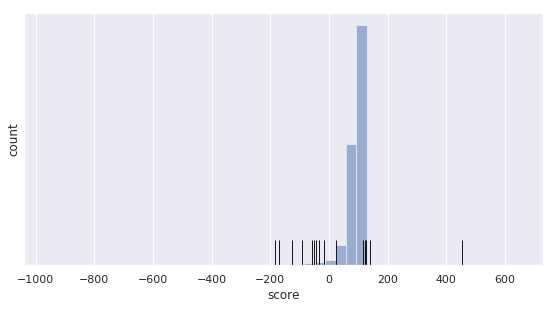

In [61]:
fig_size = 9.3
fig = plt.figure(figsize=(fig_size, float(fig_size)/2))


# ax_min = -0.15
ax_min = min(metcalf_raw_all_scores)
# ax_max = 0.35
ax_max = max(metcalf_raw_all_scores)

gs = gridspec.GridSpec(1, 1, hspace=0.05)

ax1 = plt.subplot(gs[0])
#ax2 = plt.subplot(gs[1])


ax1.hist(metcalf_raw_all_scores, bins=50, range=[ax_min, ax_max], alpha=0.5)
ax1.plot(metcalf_raw_verified_scores, [0]*len(metcalf_raw_verified_scores), '|', color='k', markersize=50)

ax1.set_xlim([ax_min, ax_max])
#ax2.set_xlim([ax_min, ax_max])
#ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_ylabel('count')
ax1.set_xlabel('score')

plt.tight_layout()

plt.savefig('20200511_graph_metcalf_raw_crusemann.pdf')


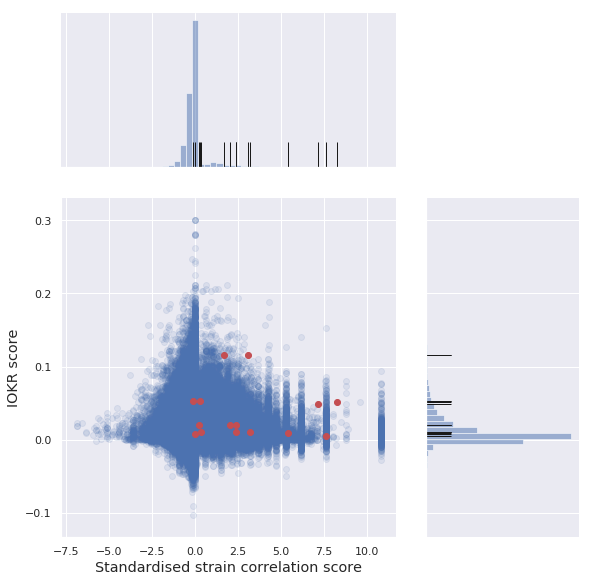

In [89]:


plot = sns.jointplot([x[0] for x in all_score_pairs if x[1] != -100], [x[1] for x in all_score_pairs if x[1] != -100], alpha=0.1, ratio=2, height=8, marginal_kws={'hist_kws': {'alpha': 0.5}})
plot.ax_joint.plot([x[0] for x in verified_score_pairs if x[1] != -100], [x[1] for x in verified_score_pairs if x[1] != -100], 'ro', color='r')
# bc horizontal, flip x and y axis
plot.ax_marg_y.plot([0]*len(iokr_scores_valid), iokr_scores_valid, '|', color='k', marker=(2, 0, 90), markersize=50)
plot.ax_marg_x.plot(metcalf_scores_valid, [0]*len(metcalf_scores_valid), '|', color='k', markersize=50)


plot.set_axis_labels('Standardised strain correlation score', 'IOKR score', size='large')

filename = '20210204_graph_combined_data_iokr_metcalf'


data = (all_score_pairs, verified_score_pairs)

with open(filename + '.bin', 'wb') as f:
    pickle.dump(data, f)

plot.savefig(filename + '.png')#, dpi=1200)


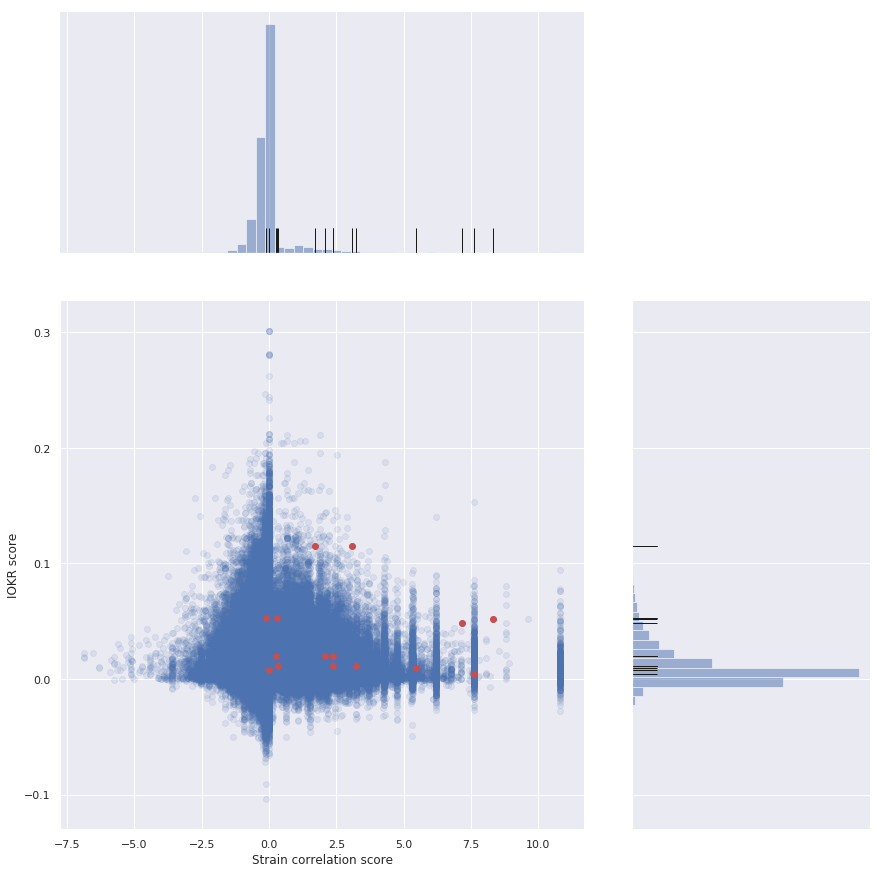

In [91]:
# Fig. for SI

plot = sns.jointplot([x[0] for x in all_score_pairs if x[1] != -100], [x[1] for x in all_score_pairs if x[1] != -100], alpha=0.1, ratio=2, height=12, marginal_kws={'hist_kws': {'alpha': 0.5}})
plot.ax_joint.plot([x[0] for x in verified_score_pairs if x[1] != -100], [x[1] for x in verified_score_pairs if x[1] != -100], 'ro', color='r')
# bc horizontal, flip x and y axis
plot.ax_marg_y.plot([0]*len(iokr_scores_valid), iokr_scores_valid, '|', color='k', marker=(2, 0, 90), markersize=50)
plot.ax_marg_x.plot(metcalf_scores_valid, [0]*len(metcalf_scores_valid), '|', color='k', markersize=50)


#plot.set_axis_labels('Standardised strain correlation score', 'IOKR score', size='large')
plot.set_axis_labels('Strain correlation score', 'IOKR score')


filename = '20210208_graph_combined_data_iokr_metcalf'


data = (all_score_pairs, verified_score_pairs)

with open(filename + '.bin', 'wb') as f:
    pickle.dump(data, f)

plot.savefig(filename + '.png')#, dpi=1200)

In [263]:
import matplotlib.gridspec as gridspec


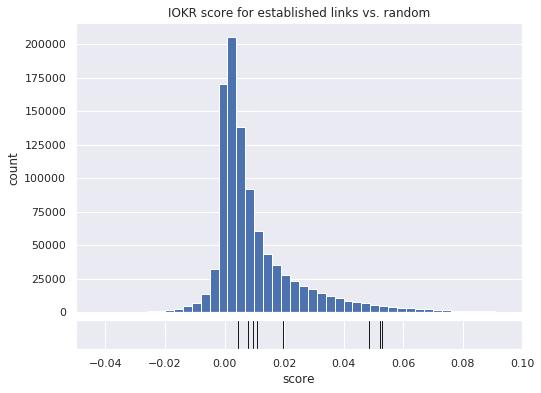

In [140]:
fig = plt.figure(figsize=(8, 6))

filename = '20200402_graph_iokr_paired_data_crusemann'

# ax_min = -0.15
ax_min = -0.05
# ax_max = 0.35
ax_max = 0.1

gs = gridspec.GridSpec(2, 1, height_ratios=[20, 2], hspace=0.05)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title('IOKR score for established links vs. random')

ax1.hist(iokr_scores_all, bins=50, range=[ax_min, ax_max])

ax2.plot(iokr_scores_valid, [5000]*len(iokr_scores_valid), '|', color='k', markersize=50)
ax1.set_xlim([ax_min, ax_max])
ax2.set_xlim([ax_min, ax_max])
ax1.set_xticks([])
ax2.set_yticks([])

ax1.set_ylabel('count')
ax2.set_xlabel('score')

plt.tight_layout()

data = (iokr_scores_all, iokr_scores_valid)
with open(filename + '.bin', 'wb') as f:
    pickle.dump(data, f)

plt.savefig('20200402_graph_iokr_paired_data_crusemann.png')

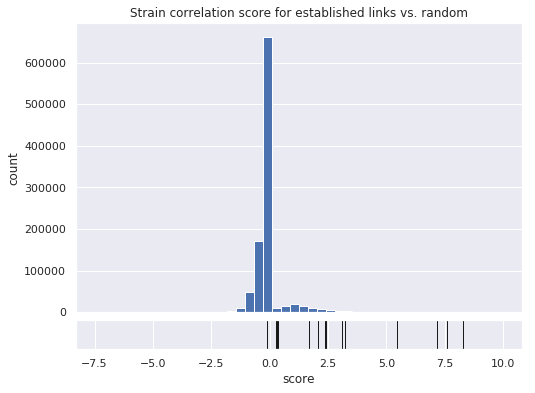

In [104]:
fig = plt.figure(figsize=(8, 6))


# ax_min = -0.15
ax_min = min(metcalf_all_scores)
# ax_max = 0.35
ax_max = max(metcalf_all_scores)

gs = gridspec.GridSpec(2, 1, height_ratios=[20, 2], hspace=0.05)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title('Strain correlation score for established links vs. random')

ax1.hist(metcalf_scores_all, bins=50, range=[ax_min, ax_max])

ax2.plot(metcalf_scores_valid, [5000]*len(metcalf_scores_valid), '|', color='k', markersize=50)
ax1.set_xlim([ax_min, ax_max])
ax2.set_xlim([ax_min, ax_max])
ax1.set_xticks([])
ax2.set_yticks([])

ax1.set_ylabel('count')
ax2.set_xlabel('score')

plt.tight_layout()

plt.savefig('graph_metcalf_paired_data_crusemann.png')

In [201]:
print("Valid links: {}".format(len(metcalf_scores_valid)))
print("Links > 0: {}".format(len([x for x in metcalf_scores_valid if x > 0])))

Valid links: 15
Links > 0: 13


In [ ]:
# This is a duplicate!

In [155]:
metcalf_raw_all_scores = []
metcalf_raw_verified_scores = []

for i, gcf in enumerate(npl.gcfs):
    print("{} / {}".format(i, len(npl.gcfs)))
    
    for mf in npl.molfams:
        metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=False)
        
        metcalf_raw_all_scores.append(metcalf_score)
        for link_bgc, link_mf in verified_bgc_mf_links:
            if link_bgc in gcf.bgcs and link_mf == mf:
                print('add verified')
                metcalf_raw_verified_scores.append(metcalf_score)


0 / 454
1 / 454
2 / 454
3 / 454
4 / 454
5 / 454
6 / 454
7 / 454
8 / 454
9 / 454
10 / 454
11 / 454
12 / 454
13 / 454
14 / 454
15 / 454
16 / 454
17 / 454
18 / 454
19 / 454
20 / 454
21 / 454
22 / 454
23 / 454
24 / 454
25 / 454
26 / 454
27 / 454
28 / 454
29 / 454
30 / 454
31 / 454
32 / 454
33 / 454
34 / 454
35 / 454
36 / 454
37 / 454
38 / 454
39 / 454
40 / 454
41 / 454
42 / 454
43 / 454
44 / 454
45 / 454
46 / 454
47 / 454
48 / 454
add verified
add verified
49 / 454
50 / 454
51 / 454
52 / 454
53 / 454
54 / 454
55 / 454
56 / 454
57 / 454
58 / 454
59 / 454
60 / 454
61 / 454
62 / 454
63 / 454
64 / 454
65 / 454
66 / 454
67 / 454
68 / 454
69 / 454
70 / 454
71 / 454
add verified
add verified
72 / 454
73 / 454
74 / 454
75 / 454
76 / 454
77 / 454
78 / 454
79 / 454
80 / 454
81 / 454
82 / 454
83 / 454
84 / 454
85 / 454
86 / 454
87 / 454
88 / 454
89 / 454
90 / 454
91 / 454
92 / 454
93 / 454
94 / 454
95 / 454
96 / 454
97 / 454
98 / 454
99 / 454
100 / 454
101 / 454
102 / 454
103 / 454
104 / 454
105 / 45

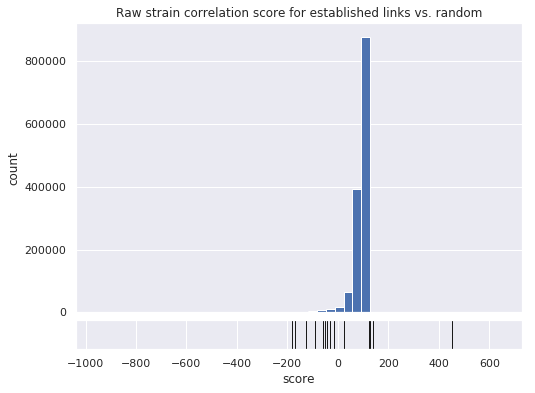

In [103]:
fig = plt.figure(figsize=(8, 6))


# ax_min = -0.15
ax_min = min(metcalf_raw_all_scores)
# ax_max = 0.35
ax_max = max(metcalf_raw_all_scores)

gs = gridspec.GridSpec(2, 1, height_ratios=[20, 2], hspace=0.05)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title('Raw strain correlation score for established links vs. random')

ax1.hist(metcalf_raw_all_scores, bins=50, range=[ax_min, ax_max])

ax2.plot(metcalf_raw_verified_scores, [5000]*len(metcalf_raw_verified_scores), '|', color='k', markersize=50)
ax1.set_xlim([ax_min, ax_max])
ax2.set_xlim([ax_min, ax_max])
ax1.set_xticks([])
ax2.set_yticks([])

ax1.set_ylabel('count')
ax2.set_xlabel('score')

plt.tight_layout()

plt.savefig('graph_metcalf_raw_paired_data_crusemann.png')

In [160]:
metcalf_raw_scores_all = [x for x, y in zip(metcalf_raw_all_scores, all_score_pairs) if y[1] != -100]
metcalf_raw_scores_valid = [x for x, y in zip(metcalf_raw_verified_scores, verified_score_pairs) if y[1] != -100]
print('Mean Metcalf all: {}'.format(numpy.mean(metcalf_raw_scores_all)))
print('Mean Metcalf valid: {}'.format(numpy.mean(metcalf_raw_scores_valid)))
print('Metcalf difference in means p-value: {}'.format(scipy.stats.ttest_ind(metcalf_raw_scores_all, metcalf_raw_scores_valid)))

Mean Metcalf all: 84.19524256475631
Mean Metcalf valid: 14.0
Metcalf difference in means p-value: Ttest_indResult(statistic=3.9408053673283527, pvalue=8.121401609179454e-05)


In [ ]:
# cache results...

In [152]:
with open('20200402_crusemann_metcalf_iokr_verified.bin', 'wb') as f:
    pickle.dump((iokr_scores_all, 
                 iokr_scores_valid, 
                 metcalf_scores_all, 
                 metcalf_scores_valid, 
                 metcalf_raw_scores_all, 
                 metcalf_raw_scores_valid,
                 all_score_pairs,
                 verified_score_pairs), f)

In [ ]:
# Plot standardised vs. raw correlation score

/home/grimur/miniconda2/envs/jupyter-py3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


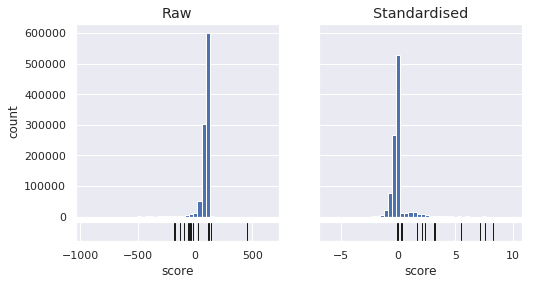

In [269]:
fig = plt.figure(figsize=(8, 4))

filename = '20200514_raw_vs_standardised_correlation_score_crusemann'

metcalf_raw_all_scores = metcalf_raw_scores_all

# ax_min = -0.15
raw_ax_min = min(metcalf_raw_all_scores)
# ax_max = 0.35
raw_ax_max = max(metcalf_raw_all_scores)

gs = gridspec.GridSpec(2, 2, height_ratios=[20, 2], hspace=0.05)
raw_hist = plt.subplot(gs[0])
raw_ticks = plt.subplot(gs[2])

raw_hist.set_title('Raw', size='large')

raw_hist.hist(metcalf_raw_scores_all, bins=50, range=[raw_ax_min, raw_ax_max])

raw_ticks.plot(metcalf_raw_scores_valid, [5000]*len(metcalf_raw_scores_valid), '|', color='k', markersize=50)
raw_hist.set_xlim([raw_ax_min, raw_ax_max])
raw_ticks.set_xlim([raw_ax_min, raw_ax_max])
raw_hist.set_xticks([])
raw_ticks.set_yticks([])

raw_hist.set_ylabel('count')
raw_ticks.set_xlabel('score')

# raw_hist.yaxis.tick_left()


# ax_min = -0.15
std_ax_min = min(metcalf_scores_all)
# ax_max = 0.35
std_ax_max = max(metcalf_scores_all)


std_hist = plt.subplot(gs[1])
std_ticks = plt.subplot(gs[3])

std_hist.set_title('Standardised', size='large')

std_hist.hist(metcalf_scores_all, bins=50, range=[std_ax_min, std_ax_max])

std_ticks.plot(metcalf_scores_valid, [5000]*len(metcalf_scores_valid), '|', color='k', markersize=50)
std_hist.set_xlim([std_ax_min, std_ax_max])
std_ticks.set_xlim([std_ax_min, std_ax_max])
std_hist.set_xticks([])
std_ticks.set_yticks([])

#ax1.set_yticks([])
#std_hist.yaxis.tick_right()
std_hist.set_yticklabels([])

# ax1.set_ylabel('count')
std_ticks.set_xlabel('score', size='medium')

hist_max = max(std_hist.get_ylim()[1], raw_hist.get_ylim()[1])
std_hist.set_ylim(top=hist_max)
raw_hist.set_ylim(top=hist_max)


plt.tight_layout()

#data = (metcalf_raw_all_scores, metcalf_raw_verified_scores, metcalf_scores_all, metcalf_scores_valid)
#with open(filename + '.bin', 'wb') as f:
#    pickle.dump(data, f)

plt.savefig(filename + '.pdf')

In [ ]:
# Scores starting from a given BGC

In [66]:
scores_from_bgc = []
scores_from_bgc_idlist = []

# scores_from_bgc has order (IOKR, std.corr., raw corr)

for (valid_bgc, valid_mf), mibig_id in zip(verified_bgc_mf_links, verified_bgc_mf_links_labels):
    for gcf in npl.gcfs:
        if valid_bgc.id in [x.id for x in gcf.bgcs]:
            iokr_score_list = []
            metcalf_score_list = []
            raw_metcalf_score_list = []
            for mf in npl.molfams:
                iokr_score = get_iokr_score(mf, gcf)
                iokr_score_list.append(iokr_score)
                raw_metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=False)
                raw_metcalf_score_list.append(raw_metcalf_score)
                metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=True)
                metcalf_score_list.append(metcalf_score)
                if mf == valid_mf:
                    valid_iokr_score = iokr_score
                    valid_metcalf_score = metcalf_score
                    valid_raw_metcalf_score = raw_metcalf_score
            scores_from_bgc.append((
                (iokr_score_list, valid_iokr_score),
                (metcalf_score_list, valid_metcalf_score),
                (raw_metcalf_score_list, valid_raw_metcalf_score)
            ))
                
            scores_from_bgc_idlist.append((gcf, valid_bgc, mibig_id))

In [67]:
scores_from_bgc_idlist

[(GCF(id=71, class=PKS-NRP_Hybrids, gcf_id=980, strains=26),
  BGC(id=394, name=GCA_000018265.CP000850.1.region022, strain=Strain(CNS205) [5 aliases]),
  'BGC0000137'),
 (GCF(id=333, class=PKS-NRP_Hybrids, gcf_id=863, strains=16),
  BGC(id=394, name=GCA_000018265.CP000850.1.region022, strain=Strain(CNS205) [5 aliases]),
  'BGC0000137'),
 (GCF(id=71, class=PKS-NRP_Hybrids, gcf_id=980, strains=26),
  BGC(id=394, name=GCA_000018265.CP000850.1.region022, strain=Strain(CNS205) [5 aliases]),
  'BGC0000137'),
 (GCF(id=333, class=PKS-NRP_Hybrids, gcf_id=863, strains=16),
  BGC(id=394, name=GCA_000018265.CP000850.1.region022, strain=Strain(CNS205) [5 aliases]),
  'BGC0000137'),
 (GCF(id=48, class=PKS-NRP_Hybrids, gcf_id=767, strains=10),
  BGC(id=711, name=GCA_000018265.CP000850.1.region006, strain=Strain(CNS205) [5 aliases]),
  'BGC0000137'),
 (GCF(id=123, class=PKS-NRP_Hybrids, gcf_id=2015, strains=2),
  BGC(id=711, name=GCA_000018265.CP000850.1.region006, strain=Strain(CNS205) [5 aliases]),


In [68]:
# Plot scores for a selection of BGCs

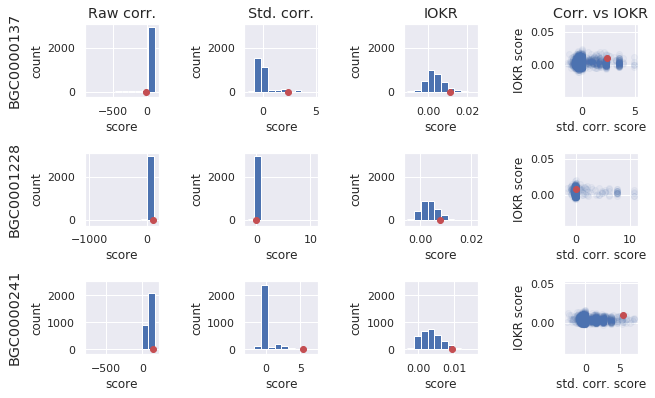

In [83]:
sample_plot_indices = [9, 11, 14]

#w = 8
w = 9.2
h = (32.0 / 15 * 3) / 9 * 8

filename = '20210204_bgc_scores_crusemann'

fig, axes = plt.subplots(nrows=len(sample_plot_indices), ncols=4, figsize=(w, h))

#cols = ['IOKR', 'Standardised strain correlation', 'Raw strain correlation']
cols = ['Raw corr.', 'Std. corr.', 'IOKR', 'Corr. vs IOKR']
for ax, col in zip(axes[0], cols):
    ax.set_title(col, size='large')

pad = 5

for row_idx, sample_idx in enumerate(sample_plot_indices):
    gcf, bgc, mibig = scores_from_bgc_idlist[sample_idx]
    
    #axes[row_idx, 0].set_ylabel(mibig)
    ax = axes[row_idx, 0]
    n = ax.annotate(mibig, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0), 
                xycoords=ax.yaxis.label, textcoords='offset points', 
                size='large', ha='right', va='center')
    
    n.set_rotation(90)
    
    initial_bgc = scores_from_bgc[sample_idx]
    score_set_metcalf, actual_score_metcalf = initial_bgc[1]
    score_set_iokr, actual_score_iokr = initial_bgc[0]
    ax = axes[row_idx, 3]
    ax.scatter(score_set_metcalf, score_set_iokr, alpha=0.05)
    ax.scatter([actual_score_metcalf], [actual_score_iokr], color='r')
    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.set_yticklabels([x for x in ax.get_yticks()], rotation=45)

    ax.set_ylabel('IOKR score', size='medium')
    ax.set_xlabel('std. corr. score', size='medium')
    
    max_ylim = 0
    min_ylim = 0
    for col_idx, (score_set, actual_score) in enumerate(initial_bgc):
        # invert col. order
        col_idx = 2 - col_idx
        ax = axes[row_idx, col_idx]
        ax.hist(score_set)
        #ax.set_xticks([])
        #ax.set_yticks([])
        #ax.set_yticklabels([int(x) for x in ax.get_yticks()], rotation=45)
        ax.set_xlabel('score', size='medium')
        ax.set_ylabel('count', size='medium')
        ax.scatter([actual_score], [0], zorder=4, color='r')
        min_ylim = ax.get_ylim()[0]
        max_ylim = max(max_ylim, ax.get_ylim()[1])

    for col_idx, (score_set, actual_score) in enumerate(initial_bgc):
        ax = axes[row_idx, col_idx]
        ax.set_ylim(min_ylim, max_ylim)



fig.tight_layout()

data = (sample_plot_indices, scores_from_bgc_idlist, scores_from_bgc)
with open(filename + '.data', 'wb') as f:
    pickle.dump(data, f)

plt.savefig(filename + '_top.png', dpi=1200)

In [ ]:
# How many links score higher than the verified link?

In [169]:
# 11: retimycin, 14: lomaiviticin
sample_idx = 14
gcf, bgc, mibig = scores_from_bgc_idlist[sample_idx]
initial_bgc = scores_from_bgc[sample_idx]
score_set_metcalf_raw, actual_score_metcalf_raw = initial_bgc[2]
score_set_metcalf, actual_score_metcalf = initial_bgc[1]
score_set_iokr, actual_score_iokr = initial_bgc[0]

print('lomaiviticin A, BGC0000241')
print('total number of links', len(score_set_metcalf_raw))
print('Number of links with equal or higher raw corr. score:', len([x for x in score_set_metcalf_raw if x >= actual_score_metcalf_raw]))
print('Number of links with equal or higher raw corr. and IOKR scores:', len([x for x, y in zip(score_set_iokr, score_set_metcalf_raw) if y >= actual_score_metcalf_raw and x >= actual_score_iokr]))
print('Number of links with equal or higher correlation score:', len([x for x in score_set_metcalf if x >= actual_score_metcalf]))
print('Number of links with equal or higher corr. and IOKR scores:', len([x for x, y in zip(score_set_iokr, score_set_metcalf) if y >= actual_score_metcalf and x >= actual_score_iokr]))
print('Number of links with equal or higher IOKR score:', len([x for x in score_set_iokr if x >= actual_score_iokr]))

iokr_mean = numpy.mean(iokr_scores_all)
iokr_std = numpy.std(iokr_scores_all)
score_set_iokr_std = (score_set_iokr - iokr_mean) / iokr_std
actual_score_iokr_std = (actual_score_iokr - iokr_mean) / iokr_std
sum_scores = [numpy.sign(x) * numpy.sqrt(numpy.abs(x)) + numpy.sign(y) * numpy.sqrt(numpy.abs(y)) for x, y in zip(score_set_iokr_std, score_set_metcalf)]
sum_scores.sort(reverse=True)
sum_scores.index(
    numpy.sign(actual_score_iokr_std) * numpy.sqrt(numpy.abs(actual_score_iokr_std)) + 
    numpy.sign(actual_score_metcalf) * numpy.sqrt(numpy.abs(actual_score_metcalf))
)

lomaiviticin A, BGC0000241
total number of links 3094
Number of links with equal or higher raw corr. score: 22
Number of links with equal or higher raw corr. and IOKR scores: 1
Number of links with equal or higher correlation score: 16
Number of links with equal or higher corr. and IOKR scores: 1
Number of links with equal or higher IOKR score: 119


4

In [167]:
# 11: retimycin, 14: lomaiviticin
sample_idx = 11
gcf, bgc, mibig = scores_from_bgc_idlist[sample_idx]
initial_bgc = scores_from_bgc[sample_idx]
score_set_metcalf_raw, actual_score_metcalf_raw = initial_bgc[2]
score_set_metcalf, actual_score_metcalf = initial_bgc[1]
score_set_iokr, actual_score_iokr = initial_bgc[0]

print('retimycin A, BGC0001228')
print('total number of links', len(score_set_metcalf_raw))
print('Number of links with equal or higher raw corr. score:', len([x for x in score_set_metcalf_raw if x >= actual_score_metcalf_raw]))
print('Number of links with equal or higher raw corr. and IOKR scores:', len([x for x, y in zip(score_set_iokr, score_set_metcalf_raw) if y >= actual_score_metcalf_raw and x >= actual_score_iokr]))
print('Number of links with equal or higher correlation score:', len([x for x in score_set_metcalf if x >= actual_score_metcalf]))
print('Number of links with equal or higher corr. and IOKR scores:', len([x for x, y in zip(score_set_iokr, score_set_metcalf) if y >= actual_score_metcalf and x >= actual_score_iokr]))
print('Number of links with equal or higher IOKR score:', len([x for x in score_set_iokr if x >= actual_score_iokr]))

iokr_mean = numpy.mean(iokr_scores_all)
iokr_std = numpy.std(iokr_scores_all)
score_set_iokr_std = (score_set_iokr - iokr_mean) / iokr_std
actual_score_iokr_std = (actual_score_iokr - iokr_mean) / iokr_std
sum_scores = [numpy.sign(x) * numpy.sqrt(numpy.abs(x)) + numpy.sign(y) * numpy.sqrt(numpy.abs(y)) for x, y in zip(score_set_iokr_std, score_set_metcalf)]
sum_scores.sort(reverse=True)
sum_scores.index(
    numpy.sign(actual_score_iokr_std) * numpy.sqrt(numpy.abs(actual_score_iokr_std)) + 
    numpy.sign(actual_score_metcalf) * numpy.sqrt(numpy.abs(actual_score_metcalf))
)

retimycin A, BGC0001228
total number of links 3094
Number of links with equal or higher raw corr. score: 1089
Number of links with equal or higher raw corr. and IOKR scores: 122
Number of links with equal or higher correlation score: 1152
Number of links with equal or higher corr. and IOKR scores: 141
Number of links with equal or higher IOKR score: 384


252

In [ ]:
# Rank of the verified link according to the scoring functions, and l_p combinations

In [95]:
def l_p(x, y, p):
    return numpy.sign(x) * numpy.power(numpy.abs(x), p) + numpy.sign(y) * numpy.power(numpy.abs(y), p)

l_p(1, 2, 0.5)

2.414213562373095

In [250]:
# 11: retimycin, 14: lomaiviticin
results = []
for sample_idx in range(len(scores_from_bgc_idlist)):
    gcf, bgc, mibig = scores_from_bgc_idlist[sample_idx]
    initial_bgc = scores_from_bgc[sample_idx]
    score_set_metcalf_raw, actual_score_metcalf_raw = initial_bgc[2]
    score_set_metcalf, actual_score_metcalf = initial_bgc[1]
    score_set_iokr, actual_score_iokr = initial_bgc[0]

    # print('retimycin A, BGC0001228')
    total = len(score_set_metcalf_raw)
    higher_corr_raw = len([x for x in score_set_metcalf_raw if x >= actual_score_metcalf_raw])
    higher_both_raw = len([x for x, y in zip(score_set_iokr, score_set_metcalf_raw) if y >= actual_score_metcalf_raw and x >= actual_score_iokr])
    higher_corr = len([x for x in score_set_metcalf if x >= actual_score_metcalf])
    higher_both = len([x for x, y in zip(score_set_iokr, score_set_metcalf) if y >= actual_score_metcalf and x >= actual_score_iokr])
    higher_iokr = len([x for x in score_set_iokr if x >= actual_score_iokr])


    iokr_mean = numpy.mean(iokr_scores_all)
    iokr_std = numpy.std(iokr_scores_all)
    score_set_iokr_std = (score_set_iokr - iokr_mean) / iokr_std
    actual_score_iokr_std = (actual_score_iokr - iokr_mean) / iokr_std
    
    sum_scores = [l_p(x, y, 0.5) for x, y in zip(score_set_iokr_std, score_set_metcalf)]
    sum_scores.sort(reverse=True)
    rank_index_12 = len([x for x in sum_scores if x >= l_p(actual_score_iokr_std, actual_score_metcalf, 0.5)])
    
    sum_scores = [l_p(x, y, 2) for x, y in zip(score_set_iokr_std, score_set_metcalf)]
    sum_scores.sort(reverse=True)
    rank_index_2 = len([x for x in sum_scores if x >= l_p(actual_score_iokr_std, actual_score_metcalf, 2)])
    
    sum_scores = [l_p(x, y, 1) for x, y in zip(score_set_iokr_std, score_set_metcalf)]
    sum_scores.sort(reverse=True)
    rank_index_1 = len([x for x in sum_scores if x >= l_p(actual_score_iokr_std, actual_score_metcalf, 1)])

    results.append((mibig, higher_iokr, higher_corr, rank_index_12, rank_index_1, rank_index_2, higher_both))

In [251]:
for r in results:
    print(r)

('BGC0000137', 80, 16, 2, 14, 49, 1)
('BGC0000137', 78, 189, 12, 29, 66, 3)
('BGC0000137', 798, 1968, 1232, 997, 920, 534)
('BGC0000137', 636, 612, 409, 642, 735, 120)
('BGC0000137', 6, 287, 36, 214, 261, 1)
('BGC0000137', 6, 126, 14, 105, 122, 1)
('BGC0000137', 6, 216, 4, 85, 203, 1)
('BGC0000137', 184, 282, 146, 271, 285, 17)
('BGC0000137', 184, 101, 28, 92, 99, 7)
('BGC0000137', 184, 90, 19, 89, 88, 7)
('BGC0000333', 1810, 25, 32, 12, 12, 12)
('BGC0001228', 384, 1152, 253, 271, 317, 141)
('BGC0000827', 6, 1, 2, 1, 1, 1)
('BGC0001830', 673, 7, 7, 9, 24, 4)
('BGC0000241', 119, 16, 5, 12, 14, 1)


In [ ]:
# Plot of the unit circle in the l_p "norms"

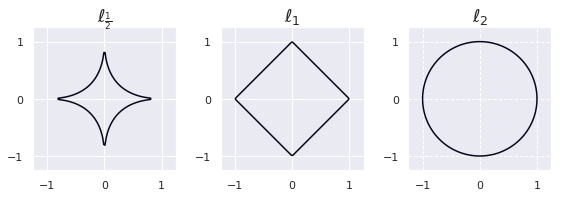

In [257]:
x = numpy.linspace(-1.0, 1.0, 100)
y = numpy.linspace(-1.0, 1.0, 100)

fig, axes = plt.subplots(ncols=3, figsize=(8, 4))

X0, Y0 = numpy.meshgrid(x, y)
F0 = numpy.sqrt(numpy.abs(X0)) + numpy.sqrt(numpy.abs(Y0)) - 1.0

X1, Y1 = numpy.meshgrid(x, y)
F1 = numpy.abs(X1) + numpy.abs(Y1) - 1.0

X2, Y2 = numpy.meshgrid(x,y)
F2 = X2**2 + Y2**2 - 1.0

eqn_list = (
    ('$\ell_\\frac{1}{2}$', F0),
    ('$\ell_1$', F1),
    ('$\ell_2$', F2)
)

for ax, eqn_pair in zip(axes, eqn_list):
    eqn_title, eqn = eqn_pair

    ax.set_title(eqn_title, size=18)
    
    ax.contour(X,Y,eqn,[0])

    ax.set_aspect(1)

    ax.set_xlim(-1.25,1.25)
    ax.set_ylim(-1.25,1.25)
    
    ax.set_yticks([-1, 0, 1])

    plt.grid(linestyle='--')
    
plt.tight_layout()

plt.savefig('fig_norms.pdf')

In [ ]:
# Plots for all of the BGCs that are part of established links

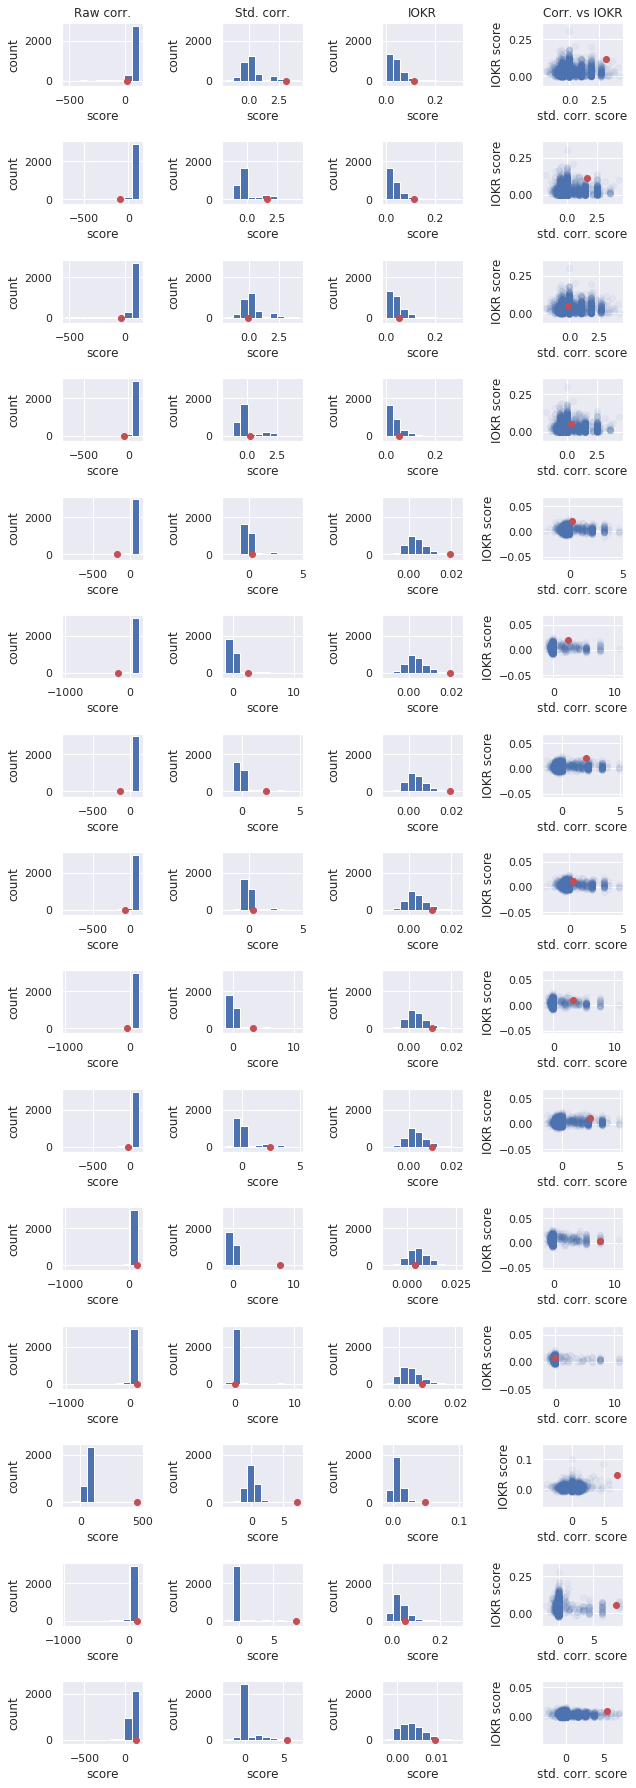

In [84]:
fig, axes = plt.subplots(nrows=15, ncols=4, figsize=(9, 25))

filename = '20210204_bgc_scores_crusemann'

#cols = ['IOKR', 'Standardised strain correlation', 'Raw strain correlation']
cols = ['Raw corr.', 'Std. corr.', 'IOKR', 'Corr. vs IOKR']
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for row_idx in range(len(scores_from_bgc)):
    gcf, bgc, mibig = scores_from_bgc_idlist[row_idx]
    axes[row_idx, 0].set_ylabel(mibig)


    initial_bgc = scores_from_bgc[row_idx]
    score_set_metcalf, actual_score_metcalf = initial_bgc[1]
    score_set_iokr, actual_score_iokr = initial_bgc[0]
    ax = axes[row_idx, 3]
    ax.scatter(score_set_metcalf, score_set_iokr, alpha=0.05)
    ax.scatter([actual_score_metcalf], [actual_score_iokr], color='r')
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    ax.set_ylabel('IOKR score', size='medium')
    ax.set_xlabel('std. corr. score', size='medium')
    
    max_ylim = 0
    min_ylim = 0
    for col_idx, (score_set, actual_score) in enumerate(initial_bgc):
        # invert col. order
        col_idx = 2 - col_idx
        ax = axes[row_idx, col_idx]
        ax.hist(score_set)
        ax.scatter([actual_score], [0], zorder=3, color='r')
        #ax.set_xticks([])
        #ax.set_yticks([])
        ax.set_xlabel('score', size='medium')
        ax.set_ylabel('count', size='medium')

        min_ylim = ax.get_ylim()[0]
        max_ylim = max(max_ylim, ax.get_ylim()[1])

    for col_idx, (score_set, actual_score) in enumerate(initial_bgc):
        ax = axes[row_idx, col_idx]
        ax.set_ylim(min_ylim, max_ylim)

fig.tight_layout()

plt.savefig(filename + '_all.png')

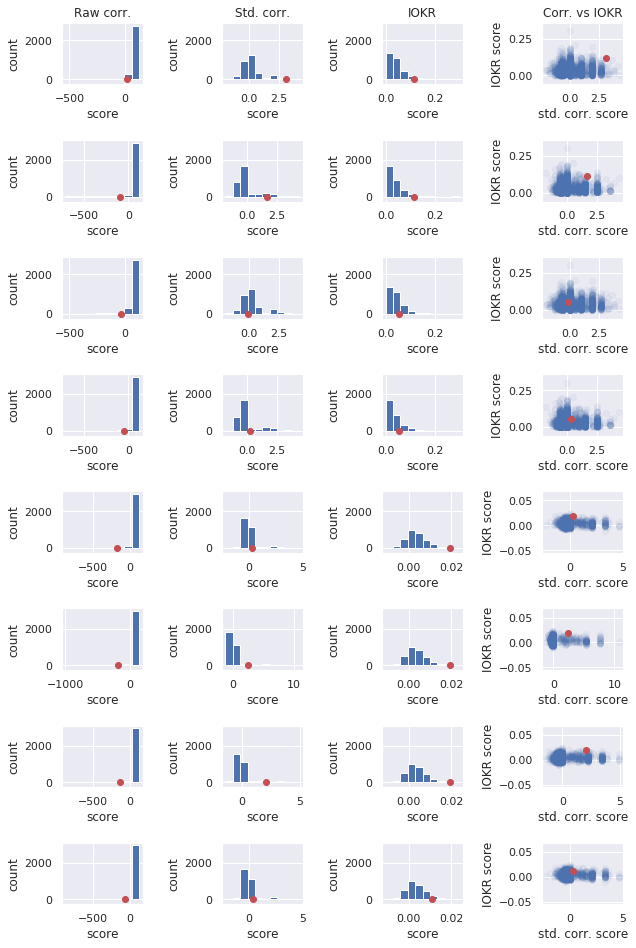

In [86]:
# 15 in total -- 8 + 7
# first part
nrows = 8
figheight = 25 / 15 * nrows
fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(9, figheight))

filename = '20210204_bgc_scores_crusemann_part1'

#cols = ['IOKR', 'Standardised strain correlation', 'Raw strain correlation']
cols = ['Raw corr.', 'Std. corr.', 'IOKR', 'Corr. vs IOKR']
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

#for row_idx in range(len(scores_from_bgc)):
for row_idx in range(8):
    gcf, bgc, mibig = scores_from_bgc_idlist[row_idx]
    axes[row_idx, 0].set_ylabel(mibig)


    initial_bgc = scores_from_bgc[row_idx]
    score_set_metcalf, actual_score_metcalf = initial_bgc[1]
    score_set_iokr, actual_score_iokr = initial_bgc[0]
    ax = axes[row_idx, 3]
    ax.scatter(score_set_metcalf, score_set_iokr, alpha=0.05)
    ax.scatter([actual_score_metcalf], [actual_score_iokr], color='r')
    ax.set_ylabel('IOKR score', size='medium')
    ax.set_xlabel('std. corr. score', size='medium')

    #ax.set_xticks([])
    #ax.set_yticks([])
    
    max_ylim = 0
    min_ylim = 0
    for col_idx, (score_set, actual_score) in enumerate(initial_bgc):
        # invert col. order
        col_idx = 2 - col_idx
        ax = axes[row_idx, col_idx]
        ax.hist(score_set)
        ax.scatter([actual_score], [0], zorder=3, color='r')
        #ax.set_xticks([])
        #ax.set_yticks([])
        ax.set_xlabel('score', size='medium')
        ax.set_ylabel('count', size='medium')

        min_ylim = ax.get_ylim()[0]
        max_ylim = max(max_ylim, ax.get_ylim()[1])

    for col_idx, (score_set, actual_score) in enumerate(initial_bgc):
        ax = axes[row_idx, col_idx]
        ax.set_ylim(min_ylim, max_ylim)

fig.tight_layout()

plt.savefig(filename + '_all.png')

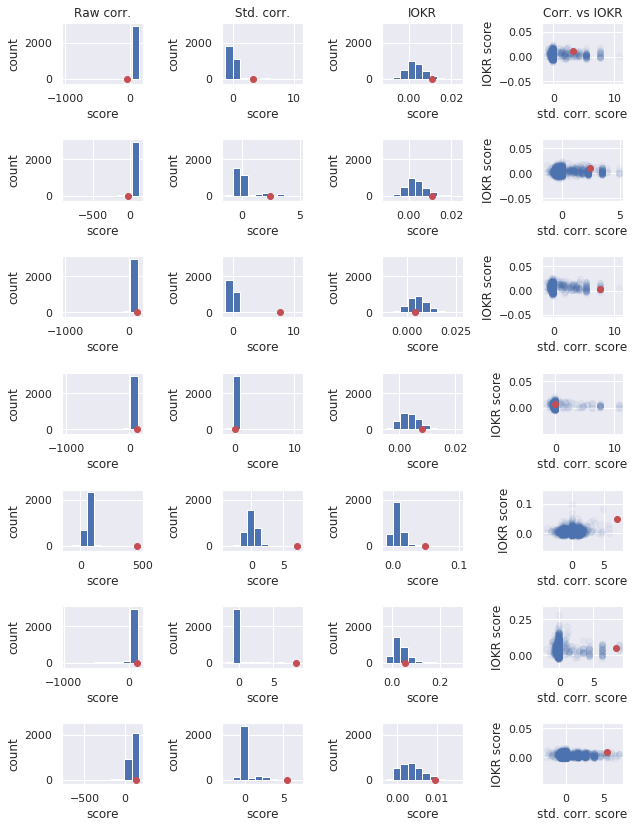

In [87]:
# second part
row_offset = 8
nrows = 7
figheight = 25 / 15 * nrows
fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(9, figheight))

filename = '20210204_bgc_scores_crusemann_part2'

#cols = ['IOKR', 'Standardised strain correlation', 'Raw strain correlation']
cols = ['Raw corr.', 'Std. corr.', 'IOKR', 'Corr. vs IOKR']
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

#for row_idx in range(len(scores_from_bgc)):
graph_row_idx = 0
for row_idx in range(8, 15):
    gcf, bgc, mibig = scores_from_bgc_idlist[row_idx]
    axes[graph_row_idx, 0].set_ylabel(mibig)

    initial_bgc = scores_from_bgc[row_idx]
    score_set_metcalf, actual_score_metcalf = initial_bgc[1]
    score_set_iokr, actual_score_iokr = initial_bgc[0]
    ax = axes[graph_row_idx, 3]
    ax.scatter(score_set_metcalf, score_set_iokr, alpha=0.05)
    ax.scatter([actual_score_metcalf], [actual_score_iokr], color='r')
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_ylabel('IOKR score', size='medium')
    ax.set_xlabel('std. corr. score', size='medium')
    max_ylim = 0
    min_ylim = 0
    for col_idx, (score_set, actual_score) in enumerate(initial_bgc):
        # invert col. order
        col_idx = 2 - col_idx
        ax = axes[graph_row_idx, col_idx]
        ax.hist(score_set)
        ax.scatter([actual_score], [0], zorder=3, color='r')
        #ax.set_xticks([])
        #ax.set_yticks([])
        ax.set_xlabel('score', size='medium')
        ax.set_ylabel('count', size='medium')
        min_ylim = ax.get_ylim()[0]
        max_ylim = max(max_ylim, ax.get_ylim()[1])

    for col_idx, (score_set, actual_score) in enumerate(initial_bgc):
        ax = axes[graph_row_idx, col_idx]
        ax.set_ylim(min_ylim, max_ylim)
        
    graph_row_idx += 1

fig.tight_layout()

plt.savefig(filename + '_all.png')

In [92]:
all_score_objects = []

for i, gcf in enumerate(npl.gcfs):
    print("{} / {}".format(i, len(npl.gcfs)))
    
    for mf in npl.molfams:
        metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=True)
        iokr_score = get_iokr_score(mf, gcf)
        
        all_score_objects.append((metcalf_score, iokr_score))


0 / 454
1 / 454
2 / 454
3 / 454
4 / 454
5 / 454
6 / 454
7 / 454
8 / 454
9 / 454
10 / 454
11 / 454
12 / 454
13 / 454
14 / 454
15 / 454
16 / 454
17 / 454
18 / 454
19 / 454
20 / 454
21 / 454
22 / 454
23 / 454
24 / 454
25 / 454
26 / 454
27 / 454
28 / 454
29 / 454
30 / 454
31 / 454
32 / 454
33 / 454
34 / 454
35 / 454
36 / 454
37 / 454
38 / 454
39 / 454
40 / 454
41 / 454
42 / 454
43 / 454
44 / 454
45 / 454
46 / 454
47 / 454
48 / 454
49 / 454
50 / 454
51 / 454
52 / 454
53 / 454
54 / 454
55 / 454
56 / 454
57 / 454
58 / 454
59 / 454
60 / 454
61 / 454
62 / 454
63 / 454
64 / 454
65 / 454
66 / 454
67 / 454
68 / 454
69 / 454
70 / 454
71 / 454
72 / 454
73 / 454
74 / 454
75 / 454
76 / 454
77 / 454
78 / 454
79 / 454
80 / 454
81 / 454
82 / 454
83 / 454
84 / 454
85 / 454
86 / 454
87 / 454
88 / 454
89 / 454
90 / 454
91 / 454
92 / 454
93 / 454
94 / 454
95 / 454
96 / 454
97 / 454
98 / 454
99 / 454
100 / 454
101 / 454
102 / 454
103 / 454
104 / 454
105 / 454
106 / 454
107 / 454
108 / 454
109 / 454
110 / 454


In [93]:
all_object_pairs = []

for i, gcf in enumerate(npl.gcfs):
    print("{} / {}".format(i, len(npl.gcfs)))
    
    for mf in npl.molfams:
        all_object_pairs.append((gcf, mf))


0 / 454
1 / 454
2 / 454
3 / 454
4 / 454
5 / 454
6 / 454
7 / 454
8 / 454
9 / 454
10 / 454
11 / 454
12 / 454
13 / 454
14 / 454
15 / 454
16 / 454
17 / 454
18 / 454
19 / 454
20 / 454
21 / 454
22 / 454
23 / 454
24 / 454
25 / 454
26 / 454
27 / 454
28 / 454
29 / 454
30 / 454
31 / 454
32 / 454
33 / 454
34 / 454
35 / 454
36 / 454
37 / 454
38 / 454
39 / 454
40 / 454
41 / 454
42 / 454
43 / 454
44 / 454
45 / 454
46 / 454
47 / 454
48 / 454
49 / 454
50 / 454
51 / 454
52 / 454
53 / 454
54 / 454
55 / 454
56 / 454
57 / 454
58 / 454
59 / 454
60 / 454
61 / 454
62 / 454
63 / 454
64 / 454
65 / 454
66 / 454
67 / 454
68 / 454
69 / 454
70 / 454
71 / 454
72 / 454
73 / 454
74 / 454
75 / 454
76 / 454
77 / 454
78 / 454
79 / 454
80 / 454
81 / 454
82 / 454
83 / 454
84 / 454
85 / 454
86 / 454
87 / 454
88 / 454
89 / 454
90 / 454
91 / 454
92 / 454
93 / 454
94 / 454
95 / 454
96 / 454
97 / 454
98 / 454
99 / 454
100 / 454
101 / 454
102 / 454
103 / 454
104 / 454
105 / 454
106 / 454
107 / 454
108 / 454
109 / 454
110 / 454


In [96]:
iokr_scores = [x[1] for x in all_score_objects if x[1] != -100]
metcalf_scores = [x[0] for x in all_score_objects if x[1] != -100]
filtered_object_pairs = [x for y, x in zip(all_score_objects, all_object_pairs) if y[1] != -100]

iokr_mean = numpy.mean(iokr_scores)
iokr_std = numpy.std(iokr_scores)
iokr_scores_std = (iokr_scores - iokr_mean) / iokr_std

l12_scores = [l_p(x, y, 0.5) for x, y in zip(iokr_scores_std, metcalf_scores)]

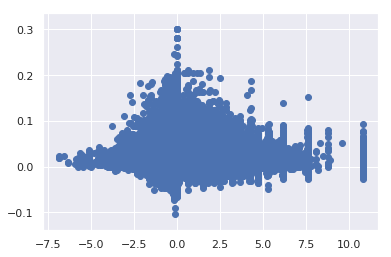

In [97]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(metcalf_scores, iokr_scores)
plt.show()

In [98]:
l12_scores_index = list(enumerate(l12_scores))
l12_scores_index.sort(key=lambda x:x[1], reverse=True)

In [99]:
[x[1] for x in l12_scores_index][:10]

[5.685320222839212,
 5.5306969222079125,
 5.348202351357381,
 5.299877141347492,
 5.282837807533554,
 5.279699573717218,
 5.27492377495465,
 5.156735756226707,
 5.141578094008474,
 5.076883438645619]

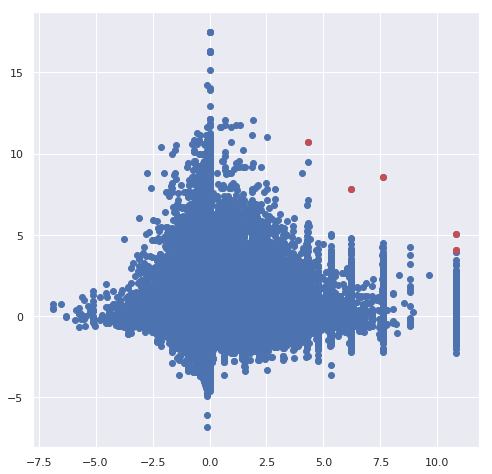

In [105]:
plt.figure(figsize=(8, 8))
plt.scatter(metcalf_scores, iokr_scores_std)

indices = [x[0] for x in l12_scores_index[:5]]
plt.scatter([metcalf_scores[x] for x in indices], [iokr_scores_std[x] for x in indices], color='r')

plt.savefig('crusemann_top5_l12.png')
plt.show()

In [ ]:
# idx 0, 2

In [106]:
import pyteomics.mgf

In [107]:
spectra_dict = {}
with pyteomics.mgf.read('/home/grimur/iokr_verify_data/crusemann/extracted/MSV000078836/METABOLOMICS-SNETS-9360fa51-download_clustered_spectra-main.mgf', 'r') as spectra:
    for s in spectra:
        spectrum_id = int(s['params']['title'].split(': ')[-1])
        spectra_dict[spectrum_id] = s


In [108]:
for i,s in spectra_dict.items():
    # print(i, s['params']['title'], s['params']['scans'])
    if str(i) != s['params']['scans']:
        print(s)
        break

    
    

In [115]:
cnt = 0
visualisation_url = "https://metabolomics-usi.ucsd.edu/spectrum/?usi=mzspec:GNPS:TASK-{}-spectra/specs_ms.mgf:scan:{}"
crusemann_id = "9360fa514804487a9d39b7e7d7e6d514"

extra_data = {
      0: """  class: Aminocoumarin (?Phosphonate)
  MIBiG ID: BGC0000938 (?BGC0001859)
""",
    1: """  class: Polyketide
  MIBiG ID: BGC0001830
""",
    2: """  class: Polyketide
  MIBiG ID: BGC0001828
""",
    3: """  class: Saccharide
  MIBiG ID: BGC0000719 BGC0000720 BGC0000721
""",
    4: """  class: Polyketide
  MIBiG ID: BGC0001830
"""
}

for index, l_score in l12_scores_index[:5]:
    filename = 'potential_link_{}'.format(cnt)
    
    corr_score = metcalf_scores[index]
    std_iokr = iokr_scores_std[index]
    iokr = iokr_scores[index]
    gcf, mf = filtered_object_pairs[index]
    
    output = []
    output.append('pair index {}'.format(index))
    
    output.append('std_corr: {}'.format(corr_score))
    output.append('iokr: {}'.format(iokr))
    output.append('std_iokr: {}'.format(std_iokr))
    
    output.append('')
    
    output.append('GCF size: {}'.format(len(gcf.strains._strains)))
    output.append('MF size: {}'.format(len(set(strains._strains).intersection(mf.strains))))
    output.append('intersection size: {}'.format(len(set(gcf.strains._strains).intersection(mf.strains))))
    
    output.append('')
    
    output.append('GCF')
    output.append('bgc list:')
    for bgc in gcf.bgcs:
        output.append('  {} - {}'.format(bgc.strain, bgc.name))
        output.append('  associated names: {}'.format(set.union(*[structures_to_names[x] for x in bgc_smiles_lookup[bgc]])))
    if cnt in extra_data:
        output.append(extra_data[cnt])
    
    output.append('')
    output.append('MF')
    output.append('id: {}'.format(mf.family_id))
    print(mf.family_id)
    #print(len(mf.spectra))
    mf_spectra = [spectra_dict[x.spectrum_id] for x in mf.spectra]
    if os.path.exists(filename + '.mgf'):
        os.remove(filename + '.mgf')
    pyteomics.mgf.write(mf_spectra, filename + '.mgf')

    for spectrum in mf.spectra:
        output.append('  spectrum {}'.format(spectrum.spectrum_id) + '--' + visualisation_url.format(crusemann_id, spectrum.spectrum_id))
        if cnt == 1:
            print(spectrum)
            print(spectrum.precursor_mz, spectrum.parent_mz)
    output.append('strains:')
    for s in mf.strains:
        if s in strains:
            output.append('  ' + str(s))

            
    with open(filename + '.txt', 'w') as f:
        f.writelines([x + '\n' for x in output])
            
            
    cnt += 1

-1
-1
Spectrum(id=3504, spectrum_id=68403, strains=9)
613.49298 613.49298
58
-1
334


In [184]:
max_id = 0
for mf in npl.molfams:
    for spectrum in mf.spectra:
        max_id = max(spectrum.spectrum_id, max_id)
max_id

124733

In [112]:
dir(spectrum)

['__class__',
 '__cmp__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_jcamp',
 '_losses',
 'add_strain',
 'annotations',
 'dataset_strains',
 'edges',
 'family',
 'family_id',
 'get_growth_medium',
 'get_metadata_value',
 'gnps_annotations',
 'gnps_id',
 'has_annotations',
 'has_loss',
 'has_strain',
 'id',
 'is_library',
 'keep_top_k',
 'losses',
 'max_ms2_intensity',
 'metadata',
 'n_peaks',
 'normalised_peaks',
 'parent_mz',
 'peaks',
 'precursor_mz',
 'rt',
 'set_annotations',
 'spectrum_id',
 'strain_list',
 'strain_set',
 'strains',
 'to_jcamp_str',
 'total_ms2_intensity']

In [157]:
structures_to_names = {}
with open(mibig_molecular_structures) as f:
    r = csv.reader(f)
    for line in r:
        bgc_id, compound_name, smiles, database_ids = line
        if not bgc_id.startswith('BGC'):
            continue
        if smiles in structures_to_names:
            structures_to_names[smiles].add(compound_name)
        else:
            structures_to_names[smiles] = set([compound_name])

In [245]:
mf_strain_counter = []
gcf_strain_counter = []
for mf in npl.molfams:
    mf_strain_counter.append(len(mf.strains))
for gcf in npl.gcfs:
    gcf_strain_counter.append(len(gcf.strains))

In [246]:
import collections

In [247]:
collections.Counter(mf_strain_counter)

Counter({1: 899,
         0: 142,
         14: 19,
         32: 2,
         101: 1,
         11: 11,
         62: 2,
         69: 1,
         26: 3,
         2: 1157,
         15: 4,
         55: 2,
         5: 93,
         17: 9,
         7: 43,
         123: 1,
         4: 164,
         6: 64,
         24: 3,
         3: 284,
         10: 17,
         20: 8,
         40: 3,
         23: 4,
         9: 23,
         22: 3,
         48: 3,
         16: 5,
         8: 35,
         34: 2,
         12: 14,
         25: 6,
         88: 1,
         31: 2,
         92: 1,
         46: 2,
         111: 1,
         106: 1,
         78: 1,
         51: 1,
         37: 1,
         45: 2,
         18: 6,
         58: 2,
         13: 8,
         38: 2,
         28: 1,
         81: 1,
         19: 5,
         21: 3,
         27: 2,
         35: 2,
         29: 3,
         107: 1,
         67: 2,
         33: 2,
         44: 3,
         109: 1,
         36: 2,
         116: 1,
         73: 1,
       

In [241]:
collections.Counter(gcf_strain_counter)

Counter({28: 2,
         44: 1,
         1: 184,
         2: 48,
         3: 28,
         17: 4,
         6: 12,
         23: 2,
         60: 1,
         5: 15,
         11: 8,
         19: 3,
         4: 12,
         10: 7,
         22: 6,
         26: 3,
         48: 1,
         14: 6,
         15: 13,
         58: 2,
         8: 9,
         39: 6,
         7: 6,
         12: 12,
         21: 5,
         20: 9,
         37: 3,
         27: 1,
         16: 6,
         50: 1,
         55: 1,
         67: 1,
         24: 3,
         38: 2,
         47: 1,
         25: 4,
         13: 4,
         61: 2,
         40: 1,
         35: 3,
         46: 1,
         18: 3,
         9: 3,
         52: 1,
         54: 1,
         57: 1,
         73: 1,
         68: 1,
         31: 1,
         102: 1,
         32: 1,
         59: 1})

In [116]:
score_index = 0

pair_index, l_score = l12_scores_index[score_index]

gcf, mf = filtered_object_pairs[pair_index]

for bgc in gcf.bgcs:
    for spectrum in mf.spectra:
        print(spectrum.spectrum_id)
        print(bgc.name)
        print(check_peak_influence(bgc, spectrum, smiles_list))

1
1
73046
CNY281.scaffold00022.region001
14:00:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3762 (0/13)
14:00:30 [DEBUG] nplinker_iokr.py:144, kernel vector
14:00:31 [DEBUG] nplinker_iokr.py:148, done (0.9872610569000244)
14:00:31 [DEBUG] nplinker_iokr.py:149, project
14:00:31 [DEBUG] nplinker_iokr.py:153, done (0.0014691352844238281)
14:00:31 [DEBUG] nplinker_iokr.py:155, save distances
14:00:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3762 (1/13)
14:00:31 [DEBUG] nplinker_iokr.py:144, kernel vector
14:00:32 [DEBUG] nplinker_iokr.py:148, done (0.9978957176208496)
14:00:32 [DEBUG] nplinker_iokr.py:149, project
14:00:32 [DEBUG] nplinker_iokr.py:153, done (0.0014562606811523438)
14:00:32 [DEBUG] nplinker_iokr.py:155, save distances
14:00:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3762 (2/13)
14:00:32 [DEBUG] nplinker_iokr.py:144, kernel vector
14:00:33 [DEBUG] nplinker_iokr.py:148, done (0.9815187454223633)
14:00:33 [DEBUG] nplinker_iokr.py:149, project
14:00:33 [DEBUG] nplinker

In [166]:
score_index = 2

pair_index, l_score = l12_scores_index[score_index]

gcf, mf = filtered_object_pairs[pair_index]

res = []
for bgc in gcf.bgcs:
    for spectrum in mf.spectra:
        res.append((spectrum.spectrum_id,
                    bgc.name,
                    check_peak_influence(bgc, spectrum, smiles_list)))
                   
for a,b,c in res:
    print(a, b)
    print(c)

14:56:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 252 (0/12)
14:56:14 [DEBUG] nplinker_iokr.py:144, kernel vector
14:56:15 [DEBUG] nplinker_iokr.py:148, done (0.9918568134307861)
14:56:15 [DEBUG] nplinker_iokr.py:149, project
14:56:15 [DEBUG] nplinker_iokr.py:153, done (0.0014309883117675781)
14:56:15 [DEBUG] nplinker_iokr.py:155, save distances
14:56:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 252 (1/12)
14:56:15 [DEBUG] nplinker_iokr.py:144, kernel vector
14:56:16 [DEBUG] nplinker_iokr.py:148, done (0.9905445575714111)
14:56:16 [DEBUG] nplinker_iokr.py:149, project
14:56:16 [DEBUG] nplinker_iokr.py:153, done (0.0015497207641601562)
14:56:16 [DEBUG] nplinker_iokr.py:155, save distances
14:56:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 252 (2/12)
14:56:16 [DEBUG] nplinker_iokr.py:144, kernel vector
14:56:17 [DEBUG] nplinker_iokr.py:148, done (0.9947113990783691)
14:56:17 [DEBUG] nplinker_iokr.py:149, project
14:56:17 [DEBUG] nplinker_iokr.py:153, done (0.001482248306274414)
14

14:56:38 [DEBUG] nplinker_iokr.py:148, done (0.9902515411376953)
14:56:38 [DEBUG] nplinker_iokr.py:149, project
14:56:38 [DEBUG] nplinker_iokr.py:153, done (0.0014927387237548828)
14:56:38 [DEBUG] nplinker_iokr.py:155, save distances
14:56:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2278 (12/28)
14:56:38 [DEBUG] nplinker_iokr.py:144, kernel vector
14:56:39 [DEBUG] nplinker_iokr.py:148, done (1.0037527084350586)
14:56:39 [DEBUG] nplinker_iokr.py:149, project
14:56:39 [DEBUG] nplinker_iokr.py:153, done (0.0014884471893310547)
14:56:39 [DEBUG] nplinker_iokr.py:155, save distances
14:56:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2278 (13/28)
14:56:39 [DEBUG] nplinker_iokr.py:144, kernel vector
14:56:40 [DEBUG] nplinker_iokr.py:148, done (1.006981611251831)
14:56:40 [DEBUG] nplinker_iokr.py:149, project
14:56:40 [DEBUG] nplinker_iokr.py:153, done (0.0015702247619628906)
14:56:40 [DEBUG] nplinker_iokr.py:155, save distances
14:56:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2278 (14

14:57:01 [DEBUG] nplinker_iokr.py:153, done (0.0015456676483154297)
14:57:01 [DEBUG] nplinker_iokr.py:155, save distances
14:57:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2288 (7/14)
14:57:01 [DEBUG] nplinker_iokr.py:144, kernel vector
14:57:02 [DEBUG] nplinker_iokr.py:148, done (0.9769585132598877)
14:57:02 [DEBUG] nplinker_iokr.py:149, project
14:57:02 [DEBUG] nplinker_iokr.py:153, done (0.0015783309936523438)
14:57:02 [DEBUG] nplinker_iokr.py:155, save distances
14:57:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2288 (8/14)
14:57:02 [DEBUG] nplinker_iokr.py:144, kernel vector
14:57:02 [DEBUG] nplinker_iokr.py:148, done (0.9808030128479004)
14:57:02 [DEBUG] nplinker_iokr.py:149, project
14:57:02 [DEBUG] nplinker_iokr.py:153, done (0.0016360282897949219)
14:57:02 [DEBUG] nplinker_iokr.py:155, save distances
14:57:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2288 (9/14)
14:57:02 [DEBUG] nplinker_iokr.py:144, kernel vector
14:57:03 [DEBUG] nplinker_iokr.py:148, done (0.981360435

14:57:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2297 (16/28)
14:57:23 [DEBUG] nplinker_iokr.py:144, kernel vector
14:57:24 [DEBUG] nplinker_iokr.py:148, done (0.9975271224975586)
14:57:24 [DEBUG] nplinker_iokr.py:149, project
14:57:24 [DEBUG] nplinker_iokr.py:153, done (0.0014333724975585938)
14:57:24 [DEBUG] nplinker_iokr.py:155, save distances
14:57:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2297 (17/28)
14:57:24 [DEBUG] nplinker_iokr.py:144, kernel vector
14:57:25 [DEBUG] nplinker_iokr.py:148, done (1.0017967224121094)
14:57:25 [DEBUG] nplinker_iokr.py:149, project
14:57:25 [DEBUG] nplinker_iokr.py:153, done (0.0014202594757080078)
14:57:25 [DEBUG] nplinker_iokr.py:155, save distances
14:57:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2297 (18/28)
14:57:25 [DEBUG] nplinker_iokr.py:144, kernel vector
14:57:26 [DEBUG] nplinker_iokr.py:148, done (1.0057687759399414)
14:57:26 [DEBUG] nplinker_iokr.py:149, project
14:57:26 [DEBUG] nplinker_iokr.py:153, done (0.0015444755554199

14:57:48 [DEBUG] nplinker_iokr.py:148, done (1.0038058757781982)
14:57:48 [DEBUG] nplinker_iokr.py:149, project
14:57:48 [DEBUG] nplinker_iokr.py:153, done (0.001554250717163086)
14:57:48 [DEBUG] nplinker_iokr.py:155, save distances
14:57:48 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2308 (12/24)
14:57:48 [DEBUG] nplinker_iokr.py:144, kernel vector
14:57:49 [DEBUG] nplinker_iokr.py:148, done (1.0078239440917969)
14:57:49 [DEBUG] nplinker_iokr.py:149, project
14:57:49 [DEBUG] nplinker_iokr.py:153, done (0.0015180110931396484)
14:57:49 [DEBUG] nplinker_iokr.py:155, save distances
14:57:49 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2308 (13/24)
14:57:49 [DEBUG] nplinker_iokr.py:144, kernel vector
14:57:50 [DEBUG] nplinker_iokr.py:148, done (0.9992630481719971)
14:57:50 [DEBUG] nplinker_iokr.py:149, project
14:57:50 [DEBUG] nplinker_iokr.py:153, done (0.001550912857055664)
14:57:50 [DEBUG] nplinker_iokr.py:155, save distances
14:57:50 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2308 (14/

14:58:11 [DEBUG] nplinker_iokr.py:153, done (0.0016145706176757812)
14:58:11 [DEBUG] nplinker_iokr.py:155, save distances
14:58:11 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2309 (11/19)
14:58:11 [DEBUG] nplinker_iokr.py:144, kernel vector
14:58:12 [DEBUG] nplinker_iokr.py:148, done (1.0033416748046875)
14:58:12 [DEBUG] nplinker_iokr.py:149, project
14:58:12 [DEBUG] nplinker_iokr.py:153, done (0.0014684200286865234)
14:58:12 [DEBUG] nplinker_iokr.py:155, save distances
14:58:12 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2309 (12/19)
14:58:12 [DEBUG] nplinker_iokr.py:144, kernel vector
14:58:13 [DEBUG] nplinker_iokr.py:148, done (1.0094318389892578)
14:58:13 [DEBUG] nplinker_iokr.py:149, project
14:58:13 [DEBUG] nplinker_iokr.py:153, done (0.0016210079193115234)
14:58:13 [DEBUG] nplinker_iokr.py:155, save distances
14:58:13 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2309 (13/19)
14:58:13 [DEBUG] nplinker_iokr.py:144, kernel vector
14:58:14 [DEBUG] nplinker_iokr.py:148, done (1.014051

14:58:34 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2310 (15/34)
14:58:34 [DEBUG] nplinker_iokr.py:144, kernel vector
14:58:35 [DEBUG] nplinker_iokr.py:148, done (0.999927282333374)
14:58:35 [DEBUG] nplinker_iokr.py:149, project
14:58:35 [DEBUG] nplinker_iokr.py:153, done (0.0014247894287109375)
14:58:35 [DEBUG] nplinker_iokr.py:155, save distances
14:58:35 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2310 (16/34)
14:58:35 [DEBUG] nplinker_iokr.py:144, kernel vector
14:58:36 [DEBUG] nplinker_iokr.py:148, done (1.0061087608337402)
14:58:36 [DEBUG] nplinker_iokr.py:149, project
14:58:36 [DEBUG] nplinker_iokr.py:153, done (0.0014171600341796875)
14:58:36 [DEBUG] nplinker_iokr.py:155, save distances
14:58:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2310 (17/34)
14:58:36 [DEBUG] nplinker_iokr.py:144, kernel vector
14:58:37 [DEBUG] nplinker_iokr.py:148, done (1.0012798309326172)
14:58:37 [DEBUG] nplinker_iokr.py:149, project
14:58:37 [DEBUG] nplinker_iokr.py:153, done (0.00154924392700195

14:58:58 [DEBUG] nplinker_iokr.py:148, done (1.000938892364502)
14:58:58 [DEBUG] nplinker_iokr.py:149, project
14:58:58 [DEBUG] nplinker_iokr.py:153, done (0.0014696121215820312)
14:58:58 [DEBUG] nplinker_iokr.py:155, save distances
14:58:58 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2312 (5/15)
14:58:58 [DEBUG] nplinker_iokr.py:144, kernel vector
14:58:59 [DEBUG] nplinker_iokr.py:148, done (0.9984257221221924)
14:58:59 [DEBUG] nplinker_iokr.py:149, project
14:58:59 [DEBUG] nplinker_iokr.py:153, done (0.0014853477478027344)
14:58:59 [DEBUG] nplinker_iokr.py:155, save distances
14:58:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2312 (6/15)
14:58:59 [DEBUG] nplinker_iokr.py:144, kernel vector
14:59:00 [DEBUG] nplinker_iokr.py:148, done (0.9933702945709229)
14:59:00 [DEBUG] nplinker_iokr.py:149, project
14:59:00 [DEBUG] nplinker_iokr.py:153, done (0.0016083717346191406)
14:59:00 [DEBUG] nplinker_iokr.py:155, save distances
14:59:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2312 (7/15

14:59:21 [DEBUG] nplinker_iokr.py:153, done (0.0015521049499511719)
14:59:21 [DEBUG] nplinker_iokr.py:155, save distances
14:59:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2316 (13/16)
14:59:21 [DEBUG] nplinker_iokr.py:144, kernel vector
14:59:22 [DEBUG] nplinker_iokr.py:148, done (0.9988622665405273)
14:59:22 [DEBUG] nplinker_iokr.py:149, project
14:59:22 [DEBUG] nplinker_iokr.py:153, done (0.001552581787109375)
14:59:22 [DEBUG] nplinker_iokr.py:155, save distances
14:59:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2316 (14/16)
14:59:22 [DEBUG] nplinker_iokr.py:144, kernel vector
14:59:23 [DEBUG] nplinker_iokr.py:148, done (0.994802713394165)
14:59:23 [DEBUG] nplinker_iokr.py:149, project
14:59:23 [DEBUG] nplinker_iokr.py:153, done (0.0015590190887451172)
14:59:23 [DEBUG] nplinker_iokr.py:155, save distances
14:59:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2316 (15/16)
14:59:23 [DEBUG] nplinker_iokr.py:144, kernel vector
14:59:24 [DEBUG] nplinker_iokr.py:148, done (1.00052905

14:59:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2319 (1/11)
14:59:44 [DEBUG] nplinker_iokr.py:144, kernel vector
14:59:45 [DEBUG] nplinker_iokr.py:148, done (0.9968452453613281)
14:59:45 [DEBUG] nplinker_iokr.py:149, project
14:59:45 [DEBUG] nplinker_iokr.py:153, done (0.0014827251434326172)
14:59:45 [DEBUG] nplinker_iokr.py:155, save distances
14:59:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2319 (2/11)
14:59:45 [DEBUG] nplinker_iokr.py:144, kernel vector
14:59:46 [DEBUG] nplinker_iokr.py:148, done (0.9859912395477295)
14:59:46 [DEBUG] nplinker_iokr.py:149, project
14:59:46 [DEBUG] nplinker_iokr.py:153, done (0.0015726089477539062)
14:59:46 [DEBUG] nplinker_iokr.py:155, save distances
14:59:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2319 (3/11)
14:59:46 [DEBUG] nplinker_iokr.py:144, kernel vector
14:59:47 [DEBUG] nplinker_iokr.py:148, done (0.9857869148254395)
14:59:47 [DEBUG] nplinker_iokr.py:149, project
14:59:47 [DEBUG] nplinker_iokr.py:153, done (0.0015964508056640625

15:00:08 [DEBUG] nplinker_iokr.py:148, done (0.9974021911621094)
15:00:08 [DEBUG] nplinker_iokr.py:149, project
15:00:08 [DEBUG] nplinker_iokr.py:153, done (0.0015361309051513672)
15:00:08 [DEBUG] nplinker_iokr.py:155, save distances
15:00:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2321 (1/12)
15:00:08 [DEBUG] nplinker_iokr.py:144, kernel vector
15:00:09 [DEBUG] nplinker_iokr.py:148, done (1.0056464672088623)
15:00:09 [DEBUG] nplinker_iokr.py:149, project
15:00:09 [DEBUG] nplinker_iokr.py:153, done (0.0016205310821533203)
15:00:09 [DEBUG] nplinker_iokr.py:155, save distances
15:00:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2321 (2/12)
15:00:09 [DEBUG] nplinker_iokr.py:144, kernel vector
15:00:10 [DEBUG] nplinker_iokr.py:148, done (0.9942183494567871)
15:00:10 [DEBUG] nplinker_iokr.py:149, project
15:00:10 [DEBUG] nplinker_iokr.py:153, done (0.0016286373138427734)
15:00:10 [DEBUG] nplinker_iokr.py:155, save distances
15:00:10 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2321 (3/1

15:00:31 [DEBUG] nplinker_iokr.py:153, done (0.0014374256134033203)
15:00:31 [DEBUG] nplinker_iokr.py:155, save distances
15:00:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2322 (12/17)
15:00:31 [DEBUG] nplinker_iokr.py:144, kernel vector
15:00:32 [DEBUG] nplinker_iokr.py:148, done (0.9973034858703613)
15:00:32 [DEBUG] nplinker_iokr.py:149, project
15:00:32 [DEBUG] nplinker_iokr.py:153, done (0.001558542251586914)
15:00:32 [DEBUG] nplinker_iokr.py:155, save distances
15:00:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2322 (13/17)
15:00:32 [DEBUG] nplinker_iokr.py:144, kernel vector
15:00:33 [DEBUG] nplinker_iokr.py:148, done (1.002183437347412)
15:00:33 [DEBUG] nplinker_iokr.py:149, project
15:00:33 [DEBUG] nplinker_iokr.py:153, done (0.0014004707336425781)
15:00:33 [DEBUG] nplinker_iokr.py:155, save distances
15:00:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2322 (14/17)
15:00:33 [DEBUG] nplinker_iokr.py:144, kernel vector
15:00:34 [DEBUG] nplinker_iokr.py:148, done (1.00725269

15:00:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2327 (8/17)
15:00:54 [DEBUG] nplinker_iokr.py:144, kernel vector
15:00:55 [DEBUG] nplinker_iokr.py:148, done (0.9939231872558594)
15:00:55 [DEBUG] nplinker_iokr.py:149, project
15:00:55 [DEBUG] nplinker_iokr.py:153, done (0.0014379024505615234)
15:00:55 [DEBUG] nplinker_iokr.py:155, save distances
15:00:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2327 (9/17)
15:00:55 [DEBUG] nplinker_iokr.py:144, kernel vector
15:00:56 [DEBUG] nplinker_iokr.py:148, done (0.9979169368743896)
15:00:56 [DEBUG] nplinker_iokr.py:149, project
15:00:56 [DEBUG] nplinker_iokr.py:153, done (0.0014369487762451172)
15:00:56 [DEBUG] nplinker_iokr.py:155, save distances
15:00:56 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2327 (10/17)
15:00:56 [DEBUG] nplinker_iokr.py:144, kernel vector
15:00:57 [DEBUG] nplinker_iokr.py:148, done (1.005068302154541)
15:00:57 [DEBUG] nplinker_iokr.py:149, project
15:00:57 [DEBUG] nplinker_iokr.py:153, done (0.0014233589172363281

In [150]:
res_est = []
for bgc, spectrum in established_link_objects:
    res_est.append((spectrum.spectrum_id,
                bgc.name,
                check_peak_influence(bgc, spectrum, smiles_list)))
    
for a, b, c in res_est:
    print(a, b)
    print(c)

10:45:04 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3737 (0/31)
10:45:04 [DEBUG] nplinker_iokr.py:144, kernel vector
10:45:05 [DEBUG] nplinker_iokr.py:148, done (0.9893672466278076)
10:45:05 [DEBUG] nplinker_iokr.py:149, project
10:45:05 [DEBUG] nplinker_iokr.py:153, done (0.0016040802001953125)
10:45:05 [DEBUG] nplinker_iokr.py:155, save distances
10:45:05 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3737 (1/31)
10:45:05 [DEBUG] nplinker_iokr.py:144, kernel vector
10:45:06 [DEBUG] nplinker_iokr.py:148, done (1.013366460800171)
10:45:06 [DEBUG] nplinker_iokr.py:149, project
10:45:06 [DEBUG] nplinker_iokr.py:153, done (0.001592397689819336)
10:45:06 [DEBUG] nplinker_iokr.py:155, save distances
10:45:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3737 (2/31)
10:45:06 [DEBUG] nplinker_iokr.py:144, kernel vector
10:45:07 [DEBUG] nplinker_iokr.py:148, done (1.0040028095245361)
10:45:07 [DEBUG] nplinker_iokr.py:149, project
10:45:07 [DEBUG] nplinker_iokr.py:153, done (0.0016307830810546875)


10:45:28 [DEBUG] nplinker_iokr.py:148, done (1.0132150650024414)
10:45:28 [DEBUG] nplinker_iokr.py:149, project
10:45:28 [DEBUG] nplinker_iokr.py:153, done (0.0014710426330566406)
10:45:28 [DEBUG] nplinker_iokr.py:155, save distances
10:45:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3737 (24/31)
10:45:28 [DEBUG] nplinker_iokr.py:144, kernel vector
10:45:29 [DEBUG] nplinker_iokr.py:148, done (1.0166828632354736)
10:45:29 [DEBUG] nplinker_iokr.py:149, project
10:45:29 [DEBUG] nplinker_iokr.py:153, done (0.0014598369598388672)
10:45:29 [DEBUG] nplinker_iokr.py:155, save distances
10:45:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3737 (25/31)
10:45:29 [DEBUG] nplinker_iokr.py:144, kernel vector
10:45:30 [DEBUG] nplinker_iokr.py:148, done (0.9977169036865234)
10:45:30 [DEBUG] nplinker_iokr.py:149, project
10:45:30 [DEBUG] nplinker_iokr.py:153, done (0.001543283462524414)
10:45:30 [DEBUG] nplinker_iokr.py:155, save distances
10:45:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3737 (26

10:45:52 [DEBUG] nplinker_iokr.py:153, done (0.0016758441925048828)
10:45:52 [DEBUG] nplinker_iokr.py:155, save distances
10:45:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3758 (16/33)
10:45:52 [DEBUG] nplinker_iokr.py:144, kernel vector
10:45:53 [DEBUG] nplinker_iokr.py:148, done (1.0117955207824707)
10:45:53 [DEBUG] nplinker_iokr.py:149, project
10:45:53 [DEBUG] nplinker_iokr.py:153, done (0.0016498565673828125)
10:45:53 [DEBUG] nplinker_iokr.py:155, save distances
10:45:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3758 (17/33)
10:45:53 [DEBUG] nplinker_iokr.py:144, kernel vector
10:45:54 [DEBUG] nplinker_iokr.py:148, done (1.0027589797973633)
10:45:54 [DEBUG] nplinker_iokr.py:149, project
10:45:54 [DEBUG] nplinker_iokr.py:153, done (0.0017018318176269531)
10:45:54 [DEBUG] nplinker_iokr.py:155, save distances
10:45:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3758 (18/33)
10:45:54 [DEBUG] nplinker_iokr.py:144, kernel vector
10:45:55 [DEBUG] nplinker_iokr.py:148, done (0.999263

10:46:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3759 (6/22)
10:46:15 [DEBUG] nplinker_iokr.py:144, kernel vector
10:46:16 [DEBUG] nplinker_iokr.py:148, done (1.0347163677215576)
10:46:16 [DEBUG] nplinker_iokr.py:149, project
10:46:16 [DEBUG] nplinker_iokr.py:153, done (0.0016341209411621094)
10:46:16 [DEBUG] nplinker_iokr.py:155, save distances
10:46:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3759 (7/22)
10:46:16 [DEBUG] nplinker_iokr.py:144, kernel vector
10:46:17 [DEBUG] nplinker_iokr.py:148, done (1.0203158855438232)
10:46:17 [DEBUG] nplinker_iokr.py:149, project
10:46:17 [DEBUG] nplinker_iokr.py:153, done (0.001718282699584961)
10:46:17 [DEBUG] nplinker_iokr.py:155, save distances
10:46:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3759 (8/22)
10:46:17 [DEBUG] nplinker_iokr.py:144, kernel vector
10:46:18 [DEBUG] nplinker_iokr.py:148, done (1.043339490890503)
10:46:18 [DEBUG] nplinker_iokr.py:149, project
10:46:18 [DEBUG] nplinker_iokr.py:153, done (0.0017826557159423828)


10:46:39 [DEBUG] nplinker_iokr.py:148, done (0.9972097873687744)
10:46:39 [DEBUG] nplinker_iokr.py:149, project
10:46:39 [DEBUG] nplinker_iokr.py:153, done (0.0014636516571044922)
10:46:39 [DEBUG] nplinker_iokr.py:155, save distances
10:46:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3672 (8/32)
10:46:39 [DEBUG] nplinker_iokr.py:144, kernel vector
10:46:40 [DEBUG] nplinker_iokr.py:148, done (0.996976375579834)
10:46:40 [DEBUG] nplinker_iokr.py:149, project
10:46:40 [DEBUG] nplinker_iokr.py:153, done (0.0015828609466552734)
10:46:40 [DEBUG] nplinker_iokr.py:155, save distances
10:46:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3672 (9/32)
10:46:40 [DEBUG] nplinker_iokr.py:144, kernel vector
10:46:41 [DEBUG] nplinker_iokr.py:148, done (0.9969990253448486)
10:46:41 [DEBUG] nplinker_iokr.py:149, project
10:46:41 [DEBUG] nplinker_iokr.py:153, done (0.001538991928100586)
10:46:41 [DEBUG] nplinker_iokr.py:155, save distances
10:46:41 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3672 (10/32

10:47:02 [DEBUG] nplinker_iokr.py:153, done (0.001543283462524414)
10:47:02 [DEBUG] nplinker_iokr.py:155, save distances
10:47:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3672 (31/32)
10:47:02 [DEBUG] nplinker_iokr.py:144, kernel vector
10:47:03 [DEBUG] nplinker_iokr.py:148, done (0.9983680248260498)
10:47:03 [DEBUG] nplinker_iokr.py:149, project
10:47:03 [DEBUG] nplinker_iokr.py:153, done (0.001546621322631836)
10:47:03 [DEBUG] nplinker_iokr.py:155, save distances
10:47:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (0/36)
10:47:03 [DEBUG] nplinker_iokr.py:144, kernel vector
10:47:04 [DEBUG] nplinker_iokr.py:148, done (0.9982039928436279)
10:47:04 [DEBUG] nplinker_iokr.py:149, project
10:47:04 [DEBUG] nplinker_iokr.py:153, done (0.001562356948852539)
10:47:04 [DEBUG] nplinker_iokr.py:155, save distances
10:47:04 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (1/36)
10:47:04 [DEBUG] nplinker_iokr.py:144, kernel vector
10:47:05 [DEBUG] nplinker_iokr.py:148, done (0.99808621406

10:47:26 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (22/36)
10:47:26 [DEBUG] nplinker_iokr.py:144, kernel vector
10:47:27 [DEBUG] nplinker_iokr.py:148, done (1.012479305267334)
10:47:27 [DEBUG] nplinker_iokr.py:149, project
10:47:27 [DEBUG] nplinker_iokr.py:153, done (0.001622915267944336)
10:47:27 [DEBUG] nplinker_iokr.py:155, save distances
10:47:27 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (23/36)
10:47:27 [DEBUG] nplinker_iokr.py:144, kernel vector
10:47:28 [DEBUG] nplinker_iokr.py:148, done (1.0100188255310059)
10:47:28 [DEBUG] nplinker_iokr.py:149, project
10:47:28 [DEBUG] nplinker_iokr.py:153, done (0.00145721435546875)
10:47:28 [DEBUG] nplinker_iokr.py:155, save distances
10:47:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (24/36)
10:47:28 [DEBUG] nplinker_iokr.py:144, kernel vector
10:47:29 [DEBUG] nplinker_iokr.py:148, done (1.013749122619629)
10:47:29 [DEBUG] nplinker_iokr.py:149, project
10:47:29 [DEBUG] nplinker_iokr.py:153, done (0.0014026165008544922)


10:47:50 [DEBUG] nplinker_iokr.py:148, done (1.0138416290283203)
10:47:50 [DEBUG] nplinker_iokr.py:149, project
10:47:50 [DEBUG] nplinker_iokr.py:153, done (0.0014123916625976562)
10:47:50 [DEBUG] nplinker_iokr.py:155, save distances
10:47:50 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (10/46)
10:47:50 [DEBUG] nplinker_iokr.py:144, kernel vector
10:47:51 [DEBUG] nplinker_iokr.py:148, done (1.002591848373413)
10:47:51 [DEBUG] nplinker_iokr.py:149, project
10:47:51 [DEBUG] nplinker_iokr.py:153, done (0.001554250717163086)
10:47:51 [DEBUG] nplinker_iokr.py:155, save distances
10:47:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (11/46)
10:47:51 [DEBUG] nplinker_iokr.py:144, kernel vector
10:47:52 [DEBUG] nplinker_iokr.py:148, done (1.011613368988037)
10:47:52 [DEBUG] nplinker_iokr.py:149, project
10:47:52 [DEBUG] nplinker_iokr.py:153, done (0.0014204978942871094)
10:47:52 [DEBUG] nplinker_iokr.py:155, save distances
10:47:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (12/4

10:48:13 [DEBUG] nplinker_iokr.py:153, done (0.0014159679412841797)
10:48:13 [DEBUG] nplinker_iokr.py:155, save distances
10:48:13 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (33/46)
10:48:13 [DEBUG] nplinker_iokr.py:144, kernel vector
10:48:14 [DEBUG] nplinker_iokr.py:148, done (1.013845443725586)
10:48:14 [DEBUG] nplinker_iokr.py:149, project
10:48:14 [DEBUG] nplinker_iokr.py:153, done (0.0014739036560058594)
10:48:14 [DEBUG] nplinker_iokr.py:155, save distances
10:48:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (34/46)
10:48:14 [DEBUG] nplinker_iokr.py:144, kernel vector
10:48:15 [DEBUG] nplinker_iokr.py:148, done (1.015355110168457)
10:48:15 [DEBUG] nplinker_iokr.py:149, project
10:48:15 [DEBUG] nplinker_iokr.py:153, done (0.0014739036560058594)
10:48:15 [DEBUG] nplinker_iokr.py:155, save distances
10:48:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (35/46)
10:48:15 [DEBUG] nplinker_iokr.py:144, kernel vector
10:48:16 [DEBUG] nplinker_iokr.py:148, done (1.01588296

10:48:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3737 (10/31)
10:48:36 [DEBUG] nplinker_iokr.py:144, kernel vector
10:48:37 [DEBUG] nplinker_iokr.py:148, done (0.9925832748413086)
10:48:37 [DEBUG] nplinker_iokr.py:149, project
10:48:37 [DEBUG] nplinker_iokr.py:153, done (0.0014705657958984375)
10:48:37 [DEBUG] nplinker_iokr.py:155, save distances
10:48:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3737 (11/31)
10:48:37 [DEBUG] nplinker_iokr.py:144, kernel vector
10:48:38 [DEBUG] nplinker_iokr.py:148, done (0.9916994571685791)
10:48:38 [DEBUG] nplinker_iokr.py:149, project
10:48:38 [DEBUG] nplinker_iokr.py:153, done (0.0015435218811035156)
10:48:38 [DEBUG] nplinker_iokr.py:155, save distances
10:48:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3737 (12/31)
10:48:38 [DEBUG] nplinker_iokr.py:144, kernel vector
10:48:39 [DEBUG] nplinker_iokr.py:148, done (0.9923241138458252)
10:48:39 [DEBUG] nplinker_iokr.py:149, project
10:48:39 [DEBUG] nplinker_iokr.py:153, done (0.0014898777008056

10:49:01 [DEBUG] nplinker_iokr.py:148, done (1.0162031650543213)
10:49:01 [DEBUG] nplinker_iokr.py:149, project
10:49:01 [DEBUG] nplinker_iokr.py:153, done (0.0015544891357421875)
10:49:01 [DEBUG] nplinker_iokr.py:155, save distances
10:49:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3758 (3/33)
10:49:01 [DEBUG] nplinker_iokr.py:144, kernel vector
10:49:02 [DEBUG] nplinker_iokr.py:148, done (0.9985718727111816)
10:49:02 [DEBUG] nplinker_iokr.py:149, project
10:49:02 [DEBUG] nplinker_iokr.py:153, done (0.0016987323760986328)
10:49:02 [DEBUG] nplinker_iokr.py:155, save distances
10:49:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3758 (4/33)
10:49:02 [DEBUG] nplinker_iokr.py:144, kernel vector
10:49:03 [DEBUG] nplinker_iokr.py:148, done (1.0065007209777832)
10:49:03 [DEBUG] nplinker_iokr.py:149, project
10:49:03 [DEBUG] nplinker_iokr.py:153, done (0.0016429424285888672)
10:49:03 [DEBUG] nplinker_iokr.py:155, save distances
10:49:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3758 (5/3

10:49:24 [DEBUG] nplinker_iokr.py:153, done (0.001493692398071289)
10:49:24 [DEBUG] nplinker_iokr.py:155, save distances
10:49:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3758 (26/33)
10:49:24 [DEBUG] nplinker_iokr.py:144, kernel vector
10:49:25 [DEBUG] nplinker_iokr.py:148, done (1.000992774963379)
10:49:25 [DEBUG] nplinker_iokr.py:149, project
10:49:25 [DEBUG] nplinker_iokr.py:153, done (0.001463174819946289)
10:49:25 [DEBUG] nplinker_iokr.py:155, save distances
10:49:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3758 (27/33)
10:49:25 [DEBUG] nplinker_iokr.py:144, kernel vector
10:49:26 [DEBUG] nplinker_iokr.py:148, done (1.0040719509124756)
10:49:26 [DEBUG] nplinker_iokr.py:149, project
10:49:26 [DEBUG] nplinker_iokr.py:153, done (0.0014154911041259766)
10:49:26 [DEBUG] nplinker_iokr.py:155, save distances
10:49:26 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3758 (28/33)
10:49:26 [DEBUG] nplinker_iokr.py:144, kernel vector
10:49:27 [DEBUG] nplinker_iokr.py:148, done (1.001406431

10:49:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3759 (16/22)
10:49:47 [DEBUG] nplinker_iokr.py:144, kernel vector
10:49:48 [DEBUG] nplinker_iokr.py:148, done (0.9910643100738525)
10:49:48 [DEBUG] nplinker_iokr.py:149, project
10:49:48 [DEBUG] nplinker_iokr.py:153, done (0.0014581680297851562)
10:49:48 [DEBUG] nplinker_iokr.py:155, save distances
10:49:48 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3759 (17/22)
10:49:48 [DEBUG] nplinker_iokr.py:144, kernel vector
10:49:49 [DEBUG] nplinker_iokr.py:148, done (0.9897651672363281)
10:49:49 [DEBUG] nplinker_iokr.py:149, project
10:49:49 [DEBUG] nplinker_iokr.py:153, done (0.0014650821685791016)
10:49:49 [DEBUG] nplinker_iokr.py:155, save distances
10:49:49 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3759 (18/22)
10:49:49 [DEBUG] nplinker_iokr.py:144, kernel vector
10:49:50 [DEBUG] nplinker_iokr.py:148, done (0.9929192066192627)
10:49:50 [DEBUG] nplinker_iokr.py:149, project
10:49:50 [DEBUG] nplinker_iokr.py:153, done (0.0014655590057373

10:50:11 [DEBUG] nplinker_iokr.py:148, done (1.0000214576721191)
10:50:11 [DEBUG] nplinker_iokr.py:149, project
10:50:11 [DEBUG] nplinker_iokr.py:153, done (0.0016698837280273438)
10:50:11 [DEBUG] nplinker_iokr.py:155, save distances
10:50:11 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3672 (18/32)
10:50:11 [DEBUG] nplinker_iokr.py:144, kernel vector
10:50:12 [DEBUG] nplinker_iokr.py:148, done (0.9984149932861328)
10:50:12 [DEBUG] nplinker_iokr.py:149, project
10:50:12 [DEBUG] nplinker_iokr.py:153, done (0.0016796588897705078)
10:50:12 [DEBUG] nplinker_iokr.py:155, save distances
10:50:12 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3672 (19/32)
10:50:12 [DEBUG] nplinker_iokr.py:144, kernel vector
10:50:13 [DEBUG] nplinker_iokr.py:148, done (1.0057849884033203)
10:50:13 [DEBUG] nplinker_iokr.py:149, project
10:50:13 [DEBUG] nplinker_iokr.py:153, done (0.0016241073608398438)
10:50:13 [DEBUG] nplinker_iokr.py:155, save distances
10:50:13 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3672 (2

10:50:34 [DEBUG] nplinker_iokr.py:153, done (0.0014681816101074219)
10:50:34 [DEBUG] nplinker_iokr.py:155, save distances
10:50:34 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (9/36)
10:50:34 [DEBUG] nplinker_iokr.py:144, kernel vector
10:50:35 [DEBUG] nplinker_iokr.py:148, done (1.0018086433410645)
10:50:35 [DEBUG] nplinker_iokr.py:149, project
10:50:35 [DEBUG] nplinker_iokr.py:153, done (0.0014033317565917969)
10:50:35 [DEBUG] nplinker_iokr.py:155, save distances
10:50:35 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (10/36)
10:50:35 [DEBUG] nplinker_iokr.py:144, kernel vector
10:50:36 [DEBUG] nplinker_iokr.py:148, done (1.0067682266235352)
10:50:36 [DEBUG] nplinker_iokr.py:149, project
10:50:36 [DEBUG] nplinker_iokr.py:153, done (0.0014433860778808594)
10:50:36 [DEBUG] nplinker_iokr.py:155, save distances
10:50:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (11/36)
10:50:36 [DEBUG] nplinker_iokr.py:144, kernel vector
10:50:37 [DEBUG] nplinker_iokr.py:148, done (1.0058889

10:50:57 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (32/36)
10:50:57 [DEBUG] nplinker_iokr.py:144, kernel vector
10:50:58 [DEBUG] nplinker_iokr.py:148, done (0.9975924491882324)
10:50:58 [DEBUG] nplinker_iokr.py:149, project
10:50:58 [DEBUG] nplinker_iokr.py:153, done (0.0014677047729492188)
10:50:58 [DEBUG] nplinker_iokr.py:155, save distances
10:50:58 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (33/36)
10:50:58 [DEBUG] nplinker_iokr.py:144, kernel vector
10:50:59 [DEBUG] nplinker_iokr.py:148, done (0.9957470893859863)
10:50:59 [DEBUG] nplinker_iokr.py:149, project
10:50:59 [DEBUG] nplinker_iokr.py:153, done (0.001566171646118164)
10:50:59 [DEBUG] nplinker_iokr.py:155, save distances
10:50:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3929 (34/36)
10:50:59 [DEBUG] nplinker_iokr.py:144, kernel vector
10:51:00 [DEBUG] nplinker_iokr.py:148, done (1.0009710788726807)
10:51:00 [DEBUG] nplinker_iokr.py:149, project
10:51:00 [DEBUG] nplinker_iokr.py:153, done (0.00156307220458984

10:51:21 [DEBUG] nplinker_iokr.py:148, done (0.9983205795288086)
10:51:21 [DEBUG] nplinker_iokr.py:149, project
10:51:21 [DEBUG] nplinker_iokr.py:153, done (0.0015387535095214844)
10:51:21 [DEBUG] nplinker_iokr.py:155, save distances
10:51:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (20/46)
10:51:21 [DEBUG] nplinker_iokr.py:144, kernel vector
10:51:22 [DEBUG] nplinker_iokr.py:148, done (0.9945371150970459)
10:51:22 [DEBUG] nplinker_iokr.py:149, project
10:51:22 [DEBUG] nplinker_iokr.py:153, done (0.001443624496459961)
10:51:22 [DEBUG] nplinker_iokr.py:155, save distances
10:51:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (21/46)
10:51:22 [DEBUG] nplinker_iokr.py:144, kernel vector
10:51:23 [DEBUG] nplinker_iokr.py:148, done (0.9962129592895508)
10:51:23 [DEBUG] nplinker_iokr.py:149, project
10:51:23 [DEBUG] nplinker_iokr.py:153, done (0.0015368461608886719)
10:51:23 [DEBUG] nplinker_iokr.py:155, save distances
10:51:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (22

10:51:44 [DEBUG] nplinker_iokr.py:153, done (0.0015397071838378906)
10:51:44 [DEBUG] nplinker_iokr.py:155, save distances
10:51:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (43/46)
10:51:44 [DEBUG] nplinker_iokr.py:144, kernel vector
10:51:45 [DEBUG] nplinker_iokr.py:148, done (0.9951992034912109)
10:51:45 [DEBUG] nplinker_iokr.py:149, project
10:51:45 [DEBUG] nplinker_iokr.py:153, done (0.0015408992767333984)
10:51:45 [DEBUG] nplinker_iokr.py:155, save distances
10:51:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (44/46)
10:51:45 [DEBUG] nplinker_iokr.py:144, kernel vector
10:51:46 [DEBUG] nplinker_iokr.py:148, done (1.0051820278167725)
10:51:46 [DEBUG] nplinker_iokr.py:149, project
10:51:46 [DEBUG] nplinker_iokr.py:153, done (0.0015077590942382812)
10:51:46 [DEBUG] nplinker_iokr.py:155, save distances
10:51:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3951 (45/46)
10:51:46 [DEBUG] nplinker_iokr.py:144, kernel vector
10:51:47 [DEBUG] nplinker_iokr.py:148, done (1.004042

10:52:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6149 (20/39)
10:52:07 [DEBUG] nplinker_iokr.py:144, kernel vector
10:52:08 [DEBUG] nplinker_iokr.py:148, done (0.9959280490875244)
10:52:08 [DEBUG] nplinker_iokr.py:149, project
10:52:08 [DEBUG] nplinker_iokr.py:153, done (0.0015172958374023438)
10:52:08 [DEBUG] nplinker_iokr.py:155, save distances
10:52:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6149 (21/39)
10:52:08 [DEBUG] nplinker_iokr.py:144, kernel vector
10:52:09 [DEBUG] nplinker_iokr.py:148, done (0.9822938442230225)
10:52:09 [DEBUG] nplinker_iokr.py:149, project
10:52:09 [DEBUG] nplinker_iokr.py:153, done (0.0015342235565185547)
10:52:09 [DEBUG] nplinker_iokr.py:155, save distances
10:52:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6149 (22/39)
10:52:09 [DEBUG] nplinker_iokr.py:144, kernel vector
10:52:10 [DEBUG] nplinker_iokr.py:148, done (0.9820435047149658)
10:52:10 [DEBUG] nplinker_iokr.py:149, project
10:52:10 [DEBUG] nplinker_iokr.py:153, done (0.0015215873718261

10:52:31 [DEBUG] nplinker_iokr.py:148, done (0.9978153705596924)
10:52:31 [DEBUG] nplinker_iokr.py:149, project
10:52:31 [DEBUG] nplinker_iokr.py:153, done (0.0016875267028808594)
10:52:31 [DEBUG] nplinker_iokr.py:155, save distances
10:52:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6157 (5/47)
10:52:31 [DEBUG] nplinker_iokr.py:144, kernel vector
10:52:32 [DEBUG] nplinker_iokr.py:148, done (0.9973011016845703)
10:52:32 [DEBUG] nplinker_iokr.py:149, project
10:52:32 [DEBUG] nplinker_iokr.py:153, done (0.0017020702362060547)
10:52:32 [DEBUG] nplinker_iokr.py:155, save distances
10:52:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6157 (6/47)
10:52:32 [DEBUG] nplinker_iokr.py:144, kernel vector
10:52:33 [DEBUG] nplinker_iokr.py:148, done (0.9996721744537354)
10:52:33 [DEBUG] nplinker_iokr.py:149, project
10:52:33 [DEBUG] nplinker_iokr.py:153, done (0.001710653305053711)
10:52:33 [DEBUG] nplinker_iokr.py:155, save distances
10:52:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6157 (7/47

10:52:54 [DEBUG] nplinker_iokr.py:153, done (0.0015299320220947266)
10:52:54 [DEBUG] nplinker_iokr.py:155, save distances
10:52:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6157 (28/47)
10:52:54 [DEBUG] nplinker_iokr.py:144, kernel vector
10:52:55 [DEBUG] nplinker_iokr.py:148, done (0.9933364391326904)
10:52:55 [DEBUG] nplinker_iokr.py:149, project
10:52:55 [DEBUG] nplinker_iokr.py:153, done (0.0015735626220703125)
10:52:55 [DEBUG] nplinker_iokr.py:155, save distances
10:52:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6157 (29/47)
10:52:55 [DEBUG] nplinker_iokr.py:144, kernel vector
10:52:56 [DEBUG] nplinker_iokr.py:148, done (0.9848277568817139)
10:52:56 [DEBUG] nplinker_iokr.py:149, project
10:52:56 [DEBUG] nplinker_iokr.py:153, done (0.0015268325805664062)
10:52:56 [DEBUG] nplinker_iokr.py:155, save distances
10:52:56 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6157 (30/47)
10:52:56 [DEBUG] nplinker_iokr.py:144, kernel vector
10:52:57 [DEBUG] nplinker_iokr.py:148, done (0.982932

10:53:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6174 (4/24)
10:53:17 [DEBUG] nplinker_iokr.py:144, kernel vector
10:53:18 [DEBUG] nplinker_iokr.py:148, done (0.990393877029419)
10:53:18 [DEBUG] nplinker_iokr.py:149, project
10:53:18 [DEBUG] nplinker_iokr.py:153, done (0.001447439193725586)
10:53:18 [DEBUG] nplinker_iokr.py:155, save distances
10:53:18 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6174 (5/24)
10:53:18 [DEBUG] nplinker_iokr.py:144, kernel vector
10:53:19 [DEBUG] nplinker_iokr.py:148, done (0.9993159770965576)
10:53:19 [DEBUG] nplinker_iokr.py:149, project
10:53:19 [DEBUG] nplinker_iokr.py:153, done (0.0014808177947998047)
10:53:19 [DEBUG] nplinker_iokr.py:155, save distances
10:53:19 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6174 (6/24)
10:53:19 [DEBUG] nplinker_iokr.py:144, kernel vector
10:53:20 [DEBUG] nplinker_iokr.py:148, done (0.9860057830810547)
10:53:20 [DEBUG] nplinker_iokr.py:149, project
10:53:20 [DEBUG] nplinker_iokr.py:153, done (0.0015134811401367188)


10:53:41 [DEBUG] nplinker_iokr.py:148, done (1.004692792892456)
10:53:41 [DEBUG] nplinker_iokr.py:149, project
10:53:41 [DEBUG] nplinker_iokr.py:153, done (0.0015115737915039062)
10:53:41 [DEBUG] nplinker_iokr.py:155, save distances
10:53:41 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6182 (4/25)
10:53:41 [DEBUG] nplinker_iokr.py:144, kernel vector
10:53:42 [DEBUG] nplinker_iokr.py:148, done (0.9847579002380371)
10:53:42 [DEBUG] nplinker_iokr.py:149, project
10:53:42 [DEBUG] nplinker_iokr.py:153, done (0.0015876293182373047)
10:53:42 [DEBUG] nplinker_iokr.py:155, save distances
10:53:42 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6182 (5/25)
10:53:42 [DEBUG] nplinker_iokr.py:144, kernel vector
10:53:43 [DEBUG] nplinker_iokr.py:148, done (0.9967424869537354)
10:53:43 [DEBUG] nplinker_iokr.py:149, project
10:53:43 [DEBUG] nplinker_iokr.py:153, done (0.0015518665313720703)
10:53:43 [DEBUG] nplinker_iokr.py:155, save distances
10:53:43 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6182 (6/25

10:54:04 [DEBUG] nplinker_iokr.py:153, done (0.0015790462493896484)
10:54:04 [DEBUG] nplinker_iokr.py:155, save distances
10:54:04 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6216 (2/32)
10:54:04 [DEBUG] nplinker_iokr.py:144, kernel vector
10:54:05 [DEBUG] nplinker_iokr.py:148, done (1.0051829814910889)
10:54:05 [DEBUG] nplinker_iokr.py:149, project
10:54:05 [DEBUG] nplinker_iokr.py:153, done (0.0015532970428466797)
10:54:05 [DEBUG] nplinker_iokr.py:155, save distances
10:54:05 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6216 (3/32)
10:54:05 [DEBUG] nplinker_iokr.py:144, kernel vector
10:54:06 [DEBUG] nplinker_iokr.py:148, done (1.0079505443572998)
10:54:06 [DEBUG] nplinker_iokr.py:149, project
10:54:06 [DEBUG] nplinker_iokr.py:153, done (0.0015511512756347656)
10:54:06 [DEBUG] nplinker_iokr.py:155, save distances
10:54:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6216 (4/32)
10:54:06 [DEBUG] nplinker_iokr.py:144, kernel vector
10:54:07 [DEBUG] nplinker_iokr.py:148, done (1.005682945

10:54:27 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6216 (25/32)
10:54:27 [DEBUG] nplinker_iokr.py:144, kernel vector
10:54:28 [DEBUG] nplinker_iokr.py:148, done (1.0075287818908691)
10:54:28 [DEBUG] nplinker_iokr.py:149, project
10:54:28 [DEBUG] nplinker_iokr.py:153, done (0.0016422271728515625)
10:54:28 [DEBUG] nplinker_iokr.py:155, save distances
10:54:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6216 (26/32)
10:54:28 [DEBUG] nplinker_iokr.py:144, kernel vector
10:54:29 [DEBUG] nplinker_iokr.py:148, done (1.0081233978271484)
10:54:29 [DEBUG] nplinker_iokr.py:149, project
10:54:29 [DEBUG] nplinker_iokr.py:153, done (0.0015721321105957031)
10:54:29 [DEBUG] nplinker_iokr.py:155, save distances
10:54:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6216 (27/32)
10:54:29 [DEBUG] nplinker_iokr.py:144, kernel vector
10:54:30 [DEBUG] nplinker_iokr.py:148, done (1.0032134056091309)
10:54:30 [DEBUG] nplinker_iokr.py:149, project
10:54:30 [DEBUG] nplinker_iokr.py:153, done (0.0016210079193115

10:54:51 [DEBUG] nplinker_iokr.py:148, done (1.0048174858093262)
10:54:51 [DEBUG] nplinker_iokr.py:149, project
10:54:51 [DEBUG] nplinker_iokr.py:153, done (0.0015666484832763672)
10:54:51 [DEBUG] nplinker_iokr.py:155, save distances
10:54:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6218 (17/30)
10:54:51 [DEBUG] nplinker_iokr.py:144, kernel vector
10:54:52 [DEBUG] nplinker_iokr.py:148, done (1.0061898231506348)
10:54:52 [DEBUG] nplinker_iokr.py:149, project
10:54:52 [DEBUG] nplinker_iokr.py:153, done (0.0015673637390136719)
10:54:52 [DEBUG] nplinker_iokr.py:155, save distances
10:54:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6218 (18/30)
10:54:52 [DEBUG] nplinker_iokr.py:144, kernel vector
10:54:53 [DEBUG] nplinker_iokr.py:148, done (1.0001492500305176)
10:54:53 [DEBUG] nplinker_iokr.py:149, project
10:54:53 [DEBUG] nplinker_iokr.py:153, done (0.0016281604766845703)
10:54:53 [DEBUG] nplinker_iokr.py:155, save distances
10:54:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6218 (1

10:55:14 [DEBUG] nplinker_iokr.py:153, done (0.0014443397521972656)
10:55:14 [DEBUG] nplinker_iokr.py:155, save distances
10:55:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6220 (10/16)
10:55:14 [DEBUG] nplinker_iokr.py:144, kernel vector
10:55:15 [DEBUG] nplinker_iokr.py:148, done (1.0070838928222656)
10:55:15 [DEBUG] nplinker_iokr.py:149, project
10:55:15 [DEBUG] nplinker_iokr.py:153, done (0.0014853477478027344)
10:55:15 [DEBUG] nplinker_iokr.py:155, save distances
10:55:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6220 (11/16)
10:55:15 [DEBUG] nplinker_iokr.py:144, kernel vector
10:55:16 [DEBUG] nplinker_iokr.py:148, done (1.0063369274139404)
10:55:16 [DEBUG] nplinker_iokr.py:149, project
10:55:16 [DEBUG] nplinker_iokr.py:153, done (0.001470327377319336)
10:55:16 [DEBUG] nplinker_iokr.py:155, save distances
10:55:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 6220 (12/16)
10:55:16 [DEBUG] nplinker_iokr.py:144, kernel vector
10:55:17 [DEBUG] nplinker_iokr.py:148, done (1.0069258

10:55:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1682 (0/22)
10:55:38 [DEBUG] nplinker_iokr.py:144, kernel vector
10:55:39 [DEBUG] nplinker_iokr.py:148, done (1.0073375701904297)
10:55:39 [DEBUG] nplinker_iokr.py:149, project
10:55:39 [DEBUG] nplinker_iokr.py:153, done (0.001714944839477539)
10:55:39 [DEBUG] nplinker_iokr.py:155, save distances
10:55:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1682 (1/22)
10:55:39 [DEBUG] nplinker_iokr.py:144, kernel vector
10:55:40 [DEBUG] nplinker_iokr.py:148, done (1.0110812187194824)
10:55:40 [DEBUG] nplinker_iokr.py:149, project
10:55:40 [DEBUG] nplinker_iokr.py:153, done (0.00154876708984375)
10:55:40 [DEBUG] nplinker_iokr.py:155, save distances
10:55:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1682 (2/22)
10:55:40 [DEBUG] nplinker_iokr.py:144, kernel vector
10:55:41 [DEBUG] nplinker_iokr.py:148, done (1.0090816020965576)
10:55:41 [DEBUG] nplinker_iokr.py:149, project
10:55:41 [DEBUG] nplinker_iokr.py:153, done (0.001561880111694336)
10

10:56:02 [DEBUG] nplinker_iokr.py:148, done (1.0079636573791504)
10:56:02 [DEBUG] nplinker_iokr.py:149, project
10:56:02 [DEBUG] nplinker_iokr.py:153, done (0.0015625953674316406)
10:56:02 [DEBUG] nplinker_iokr.py:155, save distances
10:56:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1862 (2/26)
10:56:02 [DEBUG] nplinker_iokr.py:144, kernel vector
10:56:03 [DEBUG] nplinker_iokr.py:148, done (1.0067040920257568)
10:56:03 [DEBUG] nplinker_iokr.py:149, project
10:56:03 [DEBUG] nplinker_iokr.py:153, done (0.001619577407836914)
10:56:03 [DEBUG] nplinker_iokr.py:155, save distances
10:56:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1862 (3/26)
10:56:03 [DEBUG] nplinker_iokr.py:144, kernel vector
10:56:04 [DEBUG] nplinker_iokr.py:148, done (1.007453203201294)
10:56:04 [DEBUG] nplinker_iokr.py:149, project
10:56:04 [DEBUG] nplinker_iokr.py:153, done (0.0016620159149169922)
10:56:04 [DEBUG] nplinker_iokr.py:155, save distances
10:56:04 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1862 (4/26)

10:56:25 [DEBUG] nplinker_iokr.py:153, done (0.0017199516296386719)
10:56:25 [DEBUG] nplinker_iokr.py:155, save distances
10:56:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1862 (25/26)
10:56:25 [DEBUG] nplinker_iokr.py:144, kernel vector
10:56:26 [DEBUG] nplinker_iokr.py:148, done (0.9939825534820557)
10:56:26 [DEBUG] nplinker_iokr.py:149, project
10:56:26 [DEBUG] nplinker_iokr.py:153, done (0.0017333030700683594)
10:56:26 [DEBUG] nplinker_iokr.py:155, save distances
10:56:26 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1863 (0/20)
10:56:26 [DEBUG] nplinker_iokr.py:144, kernel vector
10:56:27 [DEBUG] nplinker_iokr.py:148, done (1.0036883354187012)
10:56:27 [DEBUG] nplinker_iokr.py:149, project
10:56:27 [DEBUG] nplinker_iokr.py:153, done (0.0016644001007080078)
10:56:27 [DEBUG] nplinker_iokr.py:155, save distances
10:56:27 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1863 (1/20)
10:56:27 [DEBUG] nplinker_iokr.py:144, kernel vector
10:56:28 [DEBUG] nplinker_iokr.py:148, done (1.00934457

10:56:48 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1897 (2/23)
10:56:48 [DEBUG] nplinker_iokr.py:144, kernel vector
10:56:49 [DEBUG] nplinker_iokr.py:148, done (1.0138792991638184)
10:56:49 [DEBUG] nplinker_iokr.py:149, project
10:56:49 [DEBUG] nplinker_iokr.py:153, done (0.0015842914581298828)
10:56:49 [DEBUG] nplinker_iokr.py:155, save distances
10:56:49 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1897 (3/23)
10:56:49 [DEBUG] nplinker_iokr.py:144, kernel vector
10:56:50 [DEBUG] nplinker_iokr.py:148, done (1.0038182735443115)
10:56:50 [DEBUG] nplinker_iokr.py:149, project
10:56:50 [DEBUG] nplinker_iokr.py:153, done (0.0016596317291259766)
10:56:50 [DEBUG] nplinker_iokr.py:155, save distances
10:56:50 [DEBUG] nplinker_iokr.py:142, Rank spectrum 1897 (4/23)
10:56:50 [DEBUG] nplinker_iokr.py:144, kernel vector
10:56:51 [DEBUG] nplinker_iokr.py:148, done (1.0131425857543945)
10:56:51 [DEBUG] nplinker_iokr.py:149, project
10:56:51 [DEBUG] nplinker_iokr.py:153, done (0.0015790462493896484

10:57:13 [DEBUG] nplinker_iokr.py:148, done (1.0086078643798828)
10:57:13 [DEBUG] nplinker_iokr.py:149, project
10:57:13 [DEBUG] nplinker_iokr.py:153, done (0.0015654563903808594)
10:57:13 [DEBUG] nplinker_iokr.py:155, save distances
10:57:13 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2864 (3/34)
10:57:13 [DEBUG] nplinker_iokr.py:144, kernel vector
10:57:14 [DEBUG] nplinker_iokr.py:148, done (1.008500337600708)
10:57:14 [DEBUG] nplinker_iokr.py:149, project
10:57:14 [DEBUG] nplinker_iokr.py:153, done (0.0015628337860107422)
10:57:14 [DEBUG] nplinker_iokr.py:155, save distances
10:57:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2864 (4/34)
10:57:14 [DEBUG] nplinker_iokr.py:144, kernel vector
10:57:15 [DEBUG] nplinker_iokr.py:148, done (1.007903814315796)
10:57:15 [DEBUG] nplinker_iokr.py:149, project
10:57:15 [DEBUG] nplinker_iokr.py:153, done (0.0015628337860107422)
10:57:15 [DEBUG] nplinker_iokr.py:155, save distances
10:57:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2864 (5/34)

10:57:36 [DEBUG] nplinker_iokr.py:153, done (0.0015797615051269531)
10:57:36 [DEBUG] nplinker_iokr.py:155, save distances
10:57:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2864 (26/34)
10:57:36 [DEBUG] nplinker_iokr.py:144, kernel vector
10:57:37 [DEBUG] nplinker_iokr.py:148, done (1.0092945098876953)
10:57:37 [DEBUG] nplinker_iokr.py:149, project
10:57:37 [DEBUG] nplinker_iokr.py:153, done (0.0015714168548583984)
10:57:37 [DEBUG] nplinker_iokr.py:155, save distances
10:57:37 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2864 (27/34)
10:57:37 [DEBUG] nplinker_iokr.py:144, kernel vector
10:57:38 [DEBUG] nplinker_iokr.py:148, done (1.0099701881408691)
10:57:38 [DEBUG] nplinker_iokr.py:149, project
10:57:38 [DEBUG] nplinker_iokr.py:153, done (0.0015819072723388672)
10:57:38 [DEBUG] nplinker_iokr.py:155, save distances
10:57:38 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2864 (28/34)
10:57:38 [DEBUG] nplinker_iokr.py:144, kernel vector
10:57:39 [DEBUG] nplinker_iokr.py:148, done (1.008081

10:57:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3052 (15/41)
10:57:59 [DEBUG] nplinker_iokr.py:144, kernel vector
10:58:00 [DEBUG] nplinker_iokr.py:148, done (1.0085437297821045)
10:58:00 [DEBUG] nplinker_iokr.py:149, project
10:58:00 [DEBUG] nplinker_iokr.py:153, done (0.0016672611236572266)
10:58:00 [DEBUG] nplinker_iokr.py:155, save distances
10:58:00 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3052 (16/41)
10:58:00 [DEBUG] nplinker_iokr.py:144, kernel vector
10:58:01 [DEBUG] nplinker_iokr.py:148, done (1.0049221515655518)
10:58:01 [DEBUG] nplinker_iokr.py:149, project
10:58:01 [DEBUG] nplinker_iokr.py:153, done (0.0016314983367919922)
10:58:01 [DEBUG] nplinker_iokr.py:155, save distances
10:58:01 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3052 (17/41)
10:58:01 [DEBUG] nplinker_iokr.py:144, kernel vector
10:58:02 [DEBUG] nplinker_iokr.py:148, done (1.0134844779968262)
10:58:02 [DEBUG] nplinker_iokr.py:149, project
10:58:02 [DEBUG] nplinker_iokr.py:153, done (0.0015647411346435

10:58:24 [DEBUG] nplinker_iokr.py:148, done (1.0157368183135986)
10:58:24 [DEBUG] nplinker_iokr.py:149, project
10:58:24 [DEBUG] nplinker_iokr.py:153, done (0.0015647411346435547)
10:58:24 [DEBUG] nplinker_iokr.py:155, save distances
10:58:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3052 (39/41)
10:58:24 [DEBUG] nplinker_iokr.py:144, kernel vector
10:58:25 [DEBUG] nplinker_iokr.py:148, done (1.0160067081451416)
10:58:25 [DEBUG] nplinker_iokr.py:149, project
10:58:25 [DEBUG] nplinker_iokr.py:153, done (0.001734018325805664)
10:58:25 [DEBUG] nplinker_iokr.py:155, save distances
10:58:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3052 (40/41)
10:58:25 [DEBUG] nplinker_iokr.py:144, kernel vector
10:58:26 [DEBUG] nplinker_iokr.py:148, done (1.013458251953125)
10:58:26 [DEBUG] nplinker_iokr.py:149, project
10:58:26 [DEBUG] nplinker_iokr.py:153, done (0.0016477108001708984)
10:58:26 [DEBUG] nplinker_iokr.py:155, save distances
10:58:26 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3143 (0/2

10:58:47 [DEBUG] nplinker_iokr.py:153, done (0.001605987548828125)
10:58:47 [DEBUG] nplinker_iokr.py:155, save distances
10:58:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3143 (21/29)
10:58:47 [DEBUG] nplinker_iokr.py:144, kernel vector
10:58:48 [DEBUG] nplinker_iokr.py:148, done (1.0112829208374023)
10:58:48 [DEBUG] nplinker_iokr.py:149, project
10:58:48 [DEBUG] nplinker_iokr.py:153, done (0.0015597343444824219)
10:58:48 [DEBUG] nplinker_iokr.py:155, save distances
10:58:48 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3143 (22/29)
10:58:48 [DEBUG] nplinker_iokr.py:144, kernel vector
10:58:49 [DEBUG] nplinker_iokr.py:148, done (1.01161789894104)
10:58:49 [DEBUG] nplinker_iokr.py:149, project
10:58:49 [DEBUG] nplinker_iokr.py:153, done (0.0015764236450195312)
10:58:49 [DEBUG] nplinker_iokr.py:155, save distances
10:58:49 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3143 (23/29)
10:58:49 [DEBUG] nplinker_iokr.py:144, kernel vector
10:58:50 [DEBUG] nplinker_iokr.py:148, done (1.009730815

10:59:10 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3159 (15/30)
10:59:10 [DEBUG] nplinker_iokr.py:144, kernel vector
10:59:11 [DEBUG] nplinker_iokr.py:148, done (1.0005478858947754)
10:59:11 [DEBUG] nplinker_iokr.py:149, project
10:59:11 [DEBUG] nplinker_iokr.py:153, done (0.0014917850494384766)
10:59:11 [DEBUG] nplinker_iokr.py:155, save distances
10:59:11 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3159 (16/30)
10:59:11 [DEBUG] nplinker_iokr.py:144, kernel vector
10:59:12 [DEBUG] nplinker_iokr.py:148, done (1.0007765293121338)
10:59:12 [DEBUG] nplinker_iokr.py:149, project
10:59:12 [DEBUG] nplinker_iokr.py:153, done (0.0015175342559814453)
10:59:12 [DEBUG] nplinker_iokr.py:155, save distances
10:59:12 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3159 (17/30)
10:59:12 [DEBUG] nplinker_iokr.py:144, kernel vector
10:59:13 [DEBUG] nplinker_iokr.py:148, done (0.9901137351989746)
10:59:13 [DEBUG] nplinker_iokr.py:149, project
10:59:13 [DEBUG] nplinker_iokr.py:153, done (0.0016052722930908

10:59:34 [DEBUG] nplinker_iokr.py:148, done (0.9950282573699951)
10:59:34 [DEBUG] nplinker_iokr.py:149, project
10:59:34 [DEBUG] nplinker_iokr.py:153, done (0.0014889240264892578)
10:59:34 [DEBUG] nplinker_iokr.py:155, save distances
10:59:34 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3281 (9/29)
10:59:34 [DEBUG] nplinker_iokr.py:144, kernel vector
10:59:35 [DEBUG] nplinker_iokr.py:148, done (0.998831033706665)
10:59:35 [DEBUG] nplinker_iokr.py:149, project
10:59:35 [DEBUG] nplinker_iokr.py:153, done (0.001461029052734375)
10:59:35 [DEBUG] nplinker_iokr.py:155, save distances
10:59:35 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3281 (10/29)
10:59:35 [DEBUG] nplinker_iokr.py:144, kernel vector
10:59:36 [DEBUG] nplinker_iokr.py:148, done (0.9944710731506348)
10:59:36 [DEBUG] nplinker_iokr.py:149, project
10:59:36 [DEBUG] nplinker_iokr.py:153, done (0.001619577407836914)
10:59:36 [DEBUG] nplinker_iokr.py:155, save distances
10:59:36 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3281 (11/29

10:59:57 [DEBUG] nplinker_iokr.py:153, done (0.0016036033630371094)
10:59:57 [DEBUG] nplinker_iokr.py:155, save distances
10:59:57 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3329 (3/33)
10:59:57 [DEBUG] nplinker_iokr.py:144, kernel vector
10:59:58 [DEBUG] nplinker_iokr.py:148, done (0.9971697330474854)
10:59:58 [DEBUG] nplinker_iokr.py:149, project
10:59:58 [DEBUG] nplinker_iokr.py:153, done (0.0014803409576416016)
10:59:58 [DEBUG] nplinker_iokr.py:155, save distances
10:59:58 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3329 (4/33)
10:59:58 [DEBUG] nplinker_iokr.py:144, kernel vector
10:59:59 [DEBUG] nplinker_iokr.py:148, done (1.0084202289581299)
10:59:59 [DEBUG] nplinker_iokr.py:149, project
10:59:59 [DEBUG] nplinker_iokr.py:153, done (0.0014388561248779297)
10:59:59 [DEBUG] nplinker_iokr.py:155, save distances
10:59:59 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3329 (5/33)
10:59:59 [DEBUG] nplinker_iokr.py:144, kernel vector
11:00:00 [DEBUG] nplinker_iokr.py:148, done (0.993327617

11:00:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3329 (26/33)
11:00:21 [DEBUG] nplinker_iokr.py:144, kernel vector
11:00:22 [DEBUG] nplinker_iokr.py:148, done (1.0100233554840088)
11:00:22 [DEBUG] nplinker_iokr.py:149, project
11:00:22 [DEBUG] nplinker_iokr.py:153, done (0.0014574527740478516)
11:00:22 [DEBUG] nplinker_iokr.py:155, save distances
11:00:22 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3329 (27/33)
11:00:22 [DEBUG] nplinker_iokr.py:144, kernel vector
11:00:23 [DEBUG] nplinker_iokr.py:148, done (0.9968395233154297)
11:00:23 [DEBUG] nplinker_iokr.py:149, project
11:00:23 [DEBUG] nplinker_iokr.py:153, done (0.0014681816101074219)
11:00:23 [DEBUG] nplinker_iokr.py:155, save distances
11:00:23 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3329 (28/33)
11:00:23 [DEBUG] nplinker_iokr.py:144, kernel vector
11:00:24 [DEBUG] nplinker_iokr.py:148, done (1.0047674179077148)
11:00:24 [DEBUG] nplinker_iokr.py:149, project
11:00:24 [DEBUG] nplinker_iokr.py:153, done (0.0014796257019042

11:00:45 [DEBUG] nplinker_iokr.py:148, done (1.0080585479736328)
11:00:45 [DEBUG] nplinker_iokr.py:149, project
11:00:45 [DEBUG] nplinker_iokr.py:153, done (0.0015993118286132812)
11:00:45 [DEBUG] nplinker_iokr.py:155, save distances
11:00:45 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3356 (17/43)
11:00:45 [DEBUG] nplinker_iokr.py:144, kernel vector
11:00:46 [DEBUG] nplinker_iokr.py:148, done (1.0002410411834717)
11:00:46 [DEBUG] nplinker_iokr.py:149, project
11:00:46 [DEBUG] nplinker_iokr.py:153, done (0.0016705989837646484)
11:00:46 [DEBUG] nplinker_iokr.py:155, save distances
11:00:46 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3356 (18/43)
11:00:46 [DEBUG] nplinker_iokr.py:144, kernel vector
11:00:47 [DEBUG] nplinker_iokr.py:148, done (1.0130352973937988)
11:00:47 [DEBUG] nplinker_iokr.py:149, project
11:00:47 [DEBUG] nplinker_iokr.py:153, done (0.0015430450439453125)
11:00:47 [DEBUG] nplinker_iokr.py:155, save distances
11:00:47 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3356 (1

11:01:08 [DEBUG] nplinker_iokr.py:153, done (0.0014030933380126953)
11:01:08 [DEBUG] nplinker_iokr.py:155, save distances
11:01:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3356 (40/43)
11:01:08 [DEBUG] nplinker_iokr.py:144, kernel vector
11:01:09 [DEBUG] nplinker_iokr.py:148, done (1.0139820575714111)
11:01:09 [DEBUG] nplinker_iokr.py:149, project
11:01:09 [DEBUG] nplinker_iokr.py:153, done (0.0014324188232421875)
11:01:09 [DEBUG] nplinker_iokr.py:155, save distances
11:01:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3356 (41/43)
11:01:09 [DEBUG] nplinker_iokr.py:144, kernel vector
11:01:10 [DEBUG] nplinker_iokr.py:148, done (1.0013713836669922)
11:01:10 [DEBUG] nplinker_iokr.py:149, project
11:01:10 [DEBUG] nplinker_iokr.py:153, done (0.0015151500701904297)
11:01:10 [DEBUG] nplinker_iokr.py:155, save distances
11:01:10 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3356 (42/43)
11:01:10 [DEBUG] nplinker_iokr.py:144, kernel vector
11:01:11 [DEBUG] nplinker_iokr.py:148, done (1.014959

11:01:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3462 (20/42)
11:01:31 [DEBUG] nplinker_iokr.py:144, kernel vector
11:01:32 [DEBUG] nplinker_iokr.py:148, done (1.0128498077392578)
11:01:32 [DEBUG] nplinker_iokr.py:149, project
11:01:32 [DEBUG] nplinker_iokr.py:153, done (0.0014643669128417969)
11:01:32 [DEBUG] nplinker_iokr.py:155, save distances
11:01:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3462 (21/42)
11:01:32 [DEBUG] nplinker_iokr.py:144, kernel vector
11:01:33 [DEBUG] nplinker_iokr.py:148, done (1.014890193939209)
11:01:33 [DEBUG] nplinker_iokr.py:149, project
11:01:33 [DEBUG] nplinker_iokr.py:153, done (0.0014379024505615234)
11:01:33 [DEBUG] nplinker_iokr.py:155, save distances
11:01:33 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3462 (22/42)
11:01:33 [DEBUG] nplinker_iokr.py:144, kernel vector
11:01:34 [DEBUG] nplinker_iokr.py:148, done (1.0088331699371338)
11:01:34 [DEBUG] nplinker_iokr.py:149, project
11:01:34 [DEBUG] nplinker_iokr.py:153, done (0.00146555900573730

11:01:56 [DEBUG] nplinker_iokr.py:148, done (1.013556957244873)
11:01:56 [DEBUG] nplinker_iokr.py:149, project
11:01:56 [DEBUG] nplinker_iokr.py:153, done (0.001485586166381836)
11:01:56 [DEBUG] nplinker_iokr.py:155, save distances
11:01:56 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3525 (2/45)
11:01:56 [DEBUG] nplinker_iokr.py:144, kernel vector
11:01:57 [DEBUG] nplinker_iokr.py:148, done (1.0159475803375244)
11:01:57 [DEBUG] nplinker_iokr.py:149, project
11:01:57 [DEBUG] nplinker_iokr.py:153, done (0.001443624496459961)
11:01:57 [DEBUG] nplinker_iokr.py:155, save distances
11:01:57 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3525 (3/45)
11:01:57 [DEBUG] nplinker_iokr.py:144, kernel vector
11:01:58 [DEBUG] nplinker_iokr.py:148, done (1.0098273754119873)
11:01:58 [DEBUG] nplinker_iokr.py:149, project
11:01:58 [DEBUG] nplinker_iokr.py:153, done (0.0014727115631103516)
11:01:58 [DEBUG] nplinker_iokr.py:155, save distances
11:01:58 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3525 (4/45)


11:02:19 [DEBUG] nplinker_iokr.py:153, done (0.001558065414428711)
11:02:19 [DEBUG] nplinker_iokr.py:155, save distances
11:02:19 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3525 (25/45)
11:02:19 [DEBUG] nplinker_iokr.py:144, kernel vector
11:02:20 [DEBUG] nplinker_iokr.py:148, done (1.010312795639038)
11:02:20 [DEBUG] nplinker_iokr.py:149, project
11:02:20 [DEBUG] nplinker_iokr.py:153, done (0.0015749931335449219)
11:02:20 [DEBUG] nplinker_iokr.py:155, save distances
11:02:20 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3525 (26/45)
11:02:20 [DEBUG] nplinker_iokr.py:144, kernel vector
11:02:21 [DEBUG] nplinker_iokr.py:148, done (1.0172498226165771)
11:02:21 [DEBUG] nplinker_iokr.py:149, project
11:02:21 [DEBUG] nplinker_iokr.py:153, done (0.0014071464538574219)
11:02:21 [DEBUG] nplinker_iokr.py:155, save distances
11:02:21 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3525 (27/45)
11:02:21 [DEBUG] nplinker_iokr.py:144, kernel vector
11:02:22 [DEBUG] nplinker_iokr.py:148, done (1.01237845

11:02:42 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4976 (3/51)
11:02:42 [DEBUG] nplinker_iokr.py:144, kernel vector
11:02:43 [DEBUG] nplinker_iokr.py:148, done (1.00710129737854)
11:02:43 [DEBUG] nplinker_iokr.py:149, project
11:02:43 [DEBUG] nplinker_iokr.py:153, done (0.0015840530395507812)
11:02:43 [DEBUG] nplinker_iokr.py:155, save distances
11:02:43 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4976 (4/51)
11:02:43 [DEBUG] nplinker_iokr.py:144, kernel vector
11:02:44 [DEBUG] nplinker_iokr.py:148, done (1.0059590339660645)
11:02:44 [DEBUG] nplinker_iokr.py:149, project
11:02:44 [DEBUG] nplinker_iokr.py:153, done (0.0014917850494384766)
11:02:44 [DEBUG] nplinker_iokr.py:155, save distances
11:02:44 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4976 (5/51)
11:02:44 [DEBUG] nplinker_iokr.py:144, kernel vector
11:02:45 [DEBUG] nplinker_iokr.py:148, done (1.0114805698394775)
11:02:45 [DEBUG] nplinker_iokr.py:149, project
11:02:45 [DEBUG] nplinker_iokr.py:153, done (0.0014142990112304688)


11:03:07 [DEBUG] nplinker_iokr.py:148, done (1.0136370658874512)
11:03:07 [DEBUG] nplinker_iokr.py:149, project
11:03:07 [DEBUG] nplinker_iokr.py:153, done (0.0014636516571044922)
11:03:07 [DEBUG] nplinker_iokr.py:155, save distances
11:03:07 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4976 (27/51)
11:03:07 [DEBUG] nplinker_iokr.py:144, kernel vector
11:03:08 [DEBUG] nplinker_iokr.py:148, done (1.0103838443756104)
11:03:08 [DEBUG] nplinker_iokr.py:149, project
11:03:08 [DEBUG] nplinker_iokr.py:153, done (0.0014646053314208984)
11:03:08 [DEBUG] nplinker_iokr.py:155, save distances
11:03:08 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4976 (28/51)
11:03:08 [DEBUG] nplinker_iokr.py:144, kernel vector
11:03:09 [DEBUG] nplinker_iokr.py:148, done (1.001147985458374)
11:03:09 [DEBUG] nplinker_iokr.py:149, project
11:03:09 [DEBUG] nplinker_iokr.py:153, done (0.0015590190887451172)
11:03:09 [DEBUG] nplinker_iokr.py:155, save distances
11:03:09 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4976 (29

11:03:30 [DEBUG] nplinker_iokr.py:153, done (0.0014677047729492188)
11:03:30 [DEBUG] nplinker_iokr.py:155, save distances
11:03:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4976 (50/51)
11:03:30 [DEBUG] nplinker_iokr.py:144, kernel vector
11:03:31 [DEBUG] nplinker_iokr.py:148, done (1.0171914100646973)
11:03:31 [DEBUG] nplinker_iokr.py:149, project
11:03:31 [DEBUG] nplinker_iokr.py:153, done (0.0015277862548828125)
11:03:31 [DEBUG] nplinker_iokr.py:155, save distances
11:03:31 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5445 (0/56)
11:03:31 [DEBUG] nplinker_iokr.py:144, kernel vector
11:03:32 [DEBUG] nplinker_iokr.py:148, done (1.0072689056396484)
11:03:32 [DEBUG] nplinker_iokr.py:149, project
11:03:32 [DEBUG] nplinker_iokr.py:153, done (0.0014638900756835938)
11:03:32 [DEBUG] nplinker_iokr.py:155, save distances
11:03:32 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5445 (1/56)
11:03:32 [DEBUG] nplinker_iokr.py:144, kernel vector
11:03:33 [DEBUG] nplinker_iokr.py:148, done (1.01453423

11:03:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5445 (22/56)
11:03:53 [DEBUG] nplinker_iokr.py:144, kernel vector
11:03:54 [DEBUG] nplinker_iokr.py:148, done (1.0142314434051514)
11:03:54 [DEBUG] nplinker_iokr.py:149, project
11:03:54 [DEBUG] nplinker_iokr.py:153, done (0.0014581680297851562)
11:03:54 [DEBUG] nplinker_iokr.py:155, save distances
11:03:54 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5445 (23/56)
11:03:54 [DEBUG] nplinker_iokr.py:144, kernel vector
11:03:55 [DEBUG] nplinker_iokr.py:148, done (1.0084888935089111)
11:03:55 [DEBUG] nplinker_iokr.py:149, project
11:03:55 [DEBUG] nplinker_iokr.py:153, done (0.0014796257019042969)
11:03:55 [DEBUG] nplinker_iokr.py:155, save distances
11:03:55 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5445 (24/56)
11:03:55 [DEBUG] nplinker_iokr.py:144, kernel vector
11:03:56 [DEBUG] nplinker_iokr.py:148, done (1.013535976409912)
11:03:56 [DEBUG] nplinker_iokr.py:149, project
11:03:56 [DEBUG] nplinker_iokr.py:153, done (0.00147938728332519

11:04:17 [DEBUG] nplinker_iokr.py:148, done (0.9912774562835693)
11:04:17 [DEBUG] nplinker_iokr.py:149, project
11:04:17 [DEBUG] nplinker_iokr.py:153, done (0.0014843940734863281)
11:04:17 [DEBUG] nplinker_iokr.py:155, save distances
11:04:17 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5445 (46/56)
11:04:17 [DEBUG] nplinker_iokr.py:144, kernel vector
11:04:18 [DEBUG] nplinker_iokr.py:148, done (0.9914884567260742)
11:04:18 [DEBUG] nplinker_iokr.py:149, project
11:04:18 [DEBUG] nplinker_iokr.py:153, done (0.0014846324920654297)
11:04:18 [DEBUG] nplinker_iokr.py:155, save distances
11:04:18 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5445 (47/56)
11:04:18 [DEBUG] nplinker_iokr.py:144, kernel vector
11:04:19 [DEBUG] nplinker_iokr.py:148, done (0.9935636520385742)
11:04:19 [DEBUG] nplinker_iokr.py:149, project
11:04:19 [DEBUG] nplinker_iokr.py:153, done (0.001481771469116211)
11:04:19 [DEBUG] nplinker_iokr.py:155, save distances
11:04:19 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5445 (48

11:04:41 [DEBUG] nplinker_iokr.py:153, done (0.0014545917510986328)
11:04:41 [DEBUG] nplinker_iokr.py:155, save distances
11:04:41 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5532 (13/44)
11:04:41 [DEBUG] nplinker_iokr.py:144, kernel vector
11:04:42 [DEBUG] nplinker_iokr.py:148, done (1.0041108131408691)
11:04:42 [DEBUG] nplinker_iokr.py:149, project
11:04:42 [DEBUG] nplinker_iokr.py:153, done (0.0014231204986572266)
11:04:42 [DEBUG] nplinker_iokr.py:155, save distances
11:04:42 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5532 (14/44)
11:04:42 [DEBUG] nplinker_iokr.py:144, kernel vector
11:04:43 [DEBUG] nplinker_iokr.py:148, done (0.9952847957611084)
11:04:43 [DEBUG] nplinker_iokr.py:149, project
11:04:43 [DEBUG] nplinker_iokr.py:153, done (0.0014910697937011719)
11:04:43 [DEBUG] nplinker_iokr.py:155, save distances
11:04:43 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5532 (15/44)
11:04:43 [DEBUG] nplinker_iokr.py:144, kernel vector
11:04:44 [DEBUG] nplinker_iokr.py:148, done (1.005815

11:05:04 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5532 (36/44)
11:05:04 [DEBUG] nplinker_iokr.py:144, kernel vector
11:05:05 [DEBUG] nplinker_iokr.py:148, done (1.0115504264831543)
11:05:05 [DEBUG] nplinker_iokr.py:149, project
11:05:05 [DEBUG] nplinker_iokr.py:153, done (0.0016443729400634766)
11:05:05 [DEBUG] nplinker_iokr.py:155, save distances
11:05:05 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5532 (37/44)
11:05:05 [DEBUG] nplinker_iokr.py:144, kernel vector
11:05:06 [DEBUG] nplinker_iokr.py:148, done (1.0116865634918213)
11:05:06 [DEBUG] nplinker_iokr.py:149, project
11:05:06 [DEBUG] nplinker_iokr.py:153, done (0.0015716552734375)
11:05:06 [DEBUG] nplinker_iokr.py:155, save distances
11:05:06 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5532 (38/44)
11:05:06 [DEBUG] nplinker_iokr.py:144, kernel vector
11:05:07 [DEBUG] nplinker_iokr.py:148, done (1.0095961093902588)
11:05:07 [DEBUG] nplinker_iokr.py:149, project
11:05:07 [DEBUG] nplinker_iokr.py:153, done (0.0017254352569580078

11:05:28 [DEBUG] nplinker_iokr.py:148, done (1.010582447052002)
11:05:28 [DEBUG] nplinker_iokr.py:149, project
11:05:28 [DEBUG] nplinker_iokr.py:153, done (0.001631021499633789)
11:05:28 [DEBUG] nplinker_iokr.py:155, save distances
11:05:28 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5547 (16/41)
11:05:28 [DEBUG] nplinker_iokr.py:144, kernel vector
11:05:29 [DEBUG] nplinker_iokr.py:148, done (1.0086936950683594)
11:05:29 [DEBUG] nplinker_iokr.py:149, project
11:05:29 [DEBUG] nplinker_iokr.py:153, done (0.0016696453094482422)
11:05:29 [DEBUG] nplinker_iokr.py:155, save distances
11:05:29 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5547 (17/41)
11:05:29 [DEBUG] nplinker_iokr.py:144, kernel vector
11:05:30 [DEBUG] nplinker_iokr.py:148, done (1.0008854866027832)
11:05:30 [DEBUG] nplinker_iokr.py:149, project
11:05:30 [DEBUG] nplinker_iokr.py:153, done (0.0017728805541992188)
11:05:30 [DEBUG] nplinker_iokr.py:155, save distances
11:05:30 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5547 (18/

11:05:51 [DEBUG] nplinker_iokr.py:153, done (0.0016469955444335938)
11:05:51 [DEBUG] nplinker_iokr.py:155, save distances
11:05:51 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5547 (39/41)
11:05:51 [DEBUG] nplinker_iokr.py:144, kernel vector
11:05:52 [DEBUG] nplinker_iokr.py:148, done (1.0140125751495361)
11:05:52 [DEBUG] nplinker_iokr.py:149, project
11:05:52 [DEBUG] nplinker_iokr.py:153, done (0.0016565322875976562)
11:05:52 [DEBUG] nplinker_iokr.py:155, save distances
11:05:52 [DEBUG] nplinker_iokr.py:142, Rank spectrum 5547 (40/41)
11:05:52 [DEBUG] nplinker_iokr.py:144, kernel vector
11:05:53 [DEBUG] nplinker_iokr.py:148, done (1.0069396495819092)
11:05:53 [DEBUG] nplinker_iokr.py:149, project
11:05:53 [DEBUG] nplinker_iokr.py:153, done (0.0016493797302246094)
11:05:53 [DEBUG] nplinker_iokr.py:155, save distances
11:05:53 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4077 (0/59)
11:05:53 [DEBUG] nplinker_iokr.py:144, kernel vector
11:05:54 [DEBUG] nplinker_iokr.py:148, done (1.0101425

11:06:14 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4077 (21/59)
11:06:14 [DEBUG] nplinker_iokr.py:144, kernel vector
11:06:15 [DEBUG] nplinker_iokr.py:148, done (1.0004911422729492)
11:06:15 [DEBUG] nplinker_iokr.py:149, project
11:06:15 [DEBUG] nplinker_iokr.py:153, done (0.0015611648559570312)
11:06:15 [DEBUG] nplinker_iokr.py:155, save distances
11:06:15 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4077 (22/59)
11:06:15 [DEBUG] nplinker_iokr.py:144, kernel vector
11:06:16 [DEBUG] nplinker_iokr.py:148, done (1.0077118873596191)
11:06:16 [DEBUG] nplinker_iokr.py:149, project
11:06:16 [DEBUG] nplinker_iokr.py:153, done (0.0014925003051757812)
11:06:16 [DEBUG] nplinker_iokr.py:155, save distances
11:06:16 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4077 (23/59)
11:06:16 [DEBUG] nplinker_iokr.py:144, kernel vector
11:06:17 [DEBUG] nplinker_iokr.py:148, done (1.0032644271850586)
11:06:17 [DEBUG] nplinker_iokr.py:149, project
11:06:17 [DEBUG] nplinker_iokr.py:153, done (0.0015568733215332

11:06:39 [DEBUG] nplinker_iokr.py:148, done (1.0038478374481201)
11:06:39 [DEBUG] nplinker_iokr.py:149, project
11:06:39 [DEBUG] nplinker_iokr.py:153, done (0.0015170574188232422)
11:06:39 [DEBUG] nplinker_iokr.py:155, save distances
11:06:39 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4077 (45/59)
11:06:39 [DEBUG] nplinker_iokr.py:144, kernel vector
11:06:40 [DEBUG] nplinker_iokr.py:148, done (1.0061333179473877)
11:06:40 [DEBUG] nplinker_iokr.py:149, project
11:06:40 [DEBUG] nplinker_iokr.py:153, done (0.001476287841796875)
11:06:40 [DEBUG] nplinker_iokr.py:155, save distances
11:06:40 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4077 (46/59)
11:06:40 [DEBUG] nplinker_iokr.py:144, kernel vector
11:06:41 [DEBUG] nplinker_iokr.py:148, done (1.0058956146240234)
11:06:41 [DEBUG] nplinker_iokr.py:149, project
11:06:41 [DEBUG] nplinker_iokr.py:153, done (0.001451730728149414)
11:06:41 [DEBUG] nplinker_iokr.py:155, save distances
11:06:41 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4077 (47/

11:07:02 [DEBUG] nplinker_iokr.py:153, done (0.0014734268188476562)
11:07:02 [DEBUG] nplinker_iokr.py:155, save distances
11:07:02 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4491 (9/52)
11:07:02 [DEBUG] nplinker_iokr.py:144, kernel vector
11:07:03 [DEBUG] nplinker_iokr.py:148, done (1.0027785301208496)
11:07:03 [DEBUG] nplinker_iokr.py:149, project
11:07:03 [DEBUG] nplinker_iokr.py:153, done (0.0015749931335449219)
11:07:03 [DEBUG] nplinker_iokr.py:155, save distances
11:07:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4491 (10/52)
11:07:03 [DEBUG] nplinker_iokr.py:144, kernel vector
11:07:04 [DEBUG] nplinker_iokr.py:148, done (1.0033345222473145)
11:07:04 [DEBUG] nplinker_iokr.py:149, project
11:07:04 [DEBUG] nplinker_iokr.py:153, done (0.0016956329345703125)
11:07:04 [DEBUG] nplinker_iokr.py:155, save distances
11:07:04 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4491 (11/52)
11:07:04 [DEBUG] nplinker_iokr.py:144, kernel vector
11:07:05 [DEBUG] nplinker_iokr.py:148, done (1.0037474

11:07:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4491 (32/52)
11:07:25 [DEBUG] nplinker_iokr.py:144, kernel vector
11:07:26 [DEBUG] nplinker_iokr.py:148, done (1.002392053604126)
11:07:26 [DEBUG] nplinker_iokr.py:149, project
11:07:26 [DEBUG] nplinker_iokr.py:153, done (0.0014791488647460938)
11:07:26 [DEBUG] nplinker_iokr.py:155, save distances
11:07:26 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4491 (33/52)
11:07:26 [DEBUG] nplinker_iokr.py:144, kernel vector
11:07:27 [DEBUG] nplinker_iokr.py:148, done (0.9952826499938965)
11:07:27 [DEBUG] nplinker_iokr.py:149, project
11:07:27 [DEBUG] nplinker_iokr.py:153, done (0.0014691352844238281)
11:07:27 [DEBUG] nplinker_iokr.py:155, save distances
11:07:27 [DEBUG] nplinker_iokr.py:142, Rank spectrum 4491 (34/52)
11:07:27 [DEBUG] nplinker_iokr.py:144, kernel vector
11:07:28 [DEBUG] nplinker_iokr.py:148, done (0.9951460361480713)
11:07:28 [DEBUG] nplinker_iokr.py:149, project
11:07:28 [DEBUG] nplinker_iokr.py:153, done (0.00155234336853027

In [155]:
for spec_id, bgc_id, c in res_est:
    idx, true_rank, mz, score = c[0]
    test_ranks = c[1:]
    all_ranks = [x[1] for x in test_ranks]
    worst_rank = max(all_ranks)
    worst_rank_mz = test_ranks[all_ranks.index(worst_rank)][2]
    median_rank = numpy.median(all_ranks)
    
    # find the BGC match ID
    bgc, spec = [x for x in established_link_objects if x[0].name == bgc_id][0]
    linked_bgcs = [x[1] for x in established_links]
    filtered_kkb_hits = [x for x in kkb_bgc_hits[bgc] if x[1] > 10000 and x[0] in linked_bgcs]
    mibig_id = filtered_kkb_hits[0][0]
    #print(mibig_id, bgc_id, spec_id, true_rank, median_rank, worst_rank, (worst_rank - true_rank) / max(1, true_rank), worst_rank_mz)
    if (worst_rank - true_rank) / max(1, true_rank) > 0.33:
        print('>', mibig_id, bgc_id, spec_id, true_rank, median_rank, worst_rank, (worst_rank - true_rank) / max(1, true_rank), worst_rank_mz)
        
    

> BGC0000137 GCA_000018265.CP000850.1.region006 72702 97 95.5 135 0.3917525773195876 383.075012
> BGC0000333 GCA_000018265.CP000850.1.region024 120697 107 123.0 177 0.6542056074766355 77.739998
> BGC0000333 GCA_000018265.CP000850.1.region024 122023 84 84.0 188 1.2380952380952381 459.265015
> BGC0000827 GCA_000018265.CP000850.1.region012 41544 23 23.0 54 1.3478260869565217 269.074005
> BGC0000827 GCA_000018265.CP000850.1.region012 44160 9 9.0 97 9.777777777777779 131.085999
> BGC0000827 GCA_000018265.CP000850.1.region012 44161 48 48.0 147 2.0625 58.032001
> BGC0000827 GCA_000018265.CP000850.1.region012 44982 1 1.0 67 66.0 56.049999
> BGC0001830 GCA_000424905.AUGH01000019.1.region001 62174 3 3.0 15 4.0 229.119995
> BGC0001830 GCA_000424905.AUGH01000019.1.region001 63507 17 17.0 27 0.5882352941176471 159.117004
> BGC0001830 GCA_000424905.AUGH01000019.1.region001 63775 0 0.0 9 9.0 263.144012
> BGC0001830 GCA_000424905.AUGH01000019.1.region001 65471 10 10.0 14 0.4 113.057999
> BGC0001830 GC

In [135]:
> BGC0000333 GCA_000018265.CP000850.1.region024 122023 84 84.0 188 1.2380952380952381 459.265015
> BGC0000827 GCA_000018265.CP000850.1.region012 41544 23 23.0 54 1.3478260869565217 269.074005
> BGC0000827 GCA_000018265.CP000850.1.region012 44160 9 9.0 97 9.777777777777779 131.085999
> BGC0000827 GCA_000018265.CP000850.1.region012 44161 48 48.0 147 2.0625 58.032001
> BGC0000827 GCA_000018265.CP000850.1.region012 44982 1 1.0 67 66.0 56.049999
> BGC0001830 GCA_000424905.AUGH01000019.1.region001 93193 16 16.0 163 9.1875 158.117004


[('CNS205', 'BGC0000827', 206), ('CNS205', 'BGC0000333', 489), ('CNB440', 'BGC0000940', 25), ('CNB440', 'BGC0000241', 381), ('CNT005', 'BGC0001228', 492), ('CNS205', 'BGC0000137', 353), ('CNS205', 'BGC0000137', 358), ('CNS237', 'BGC0001830', 309)]


In [169]:
for spec_id, bgc_id, c in res:
    idx, true_rank, mz, score = c[0]
    test_ranks = c[1:]
    all_ranks = [x[1] for x in test_ranks]
    worst_rank = max(all_ranks)
    worst_rank_mz = test_ranks[all_ranks.index(worst_rank)][2]
    median_rank = numpy.median(all_ranks)
    
    # find the BGC match ID
    #bgc, spec = [x for x in established_link_objects if x[0].name == bgc_id][0]
    mibig_id = '{}'.format(set.union(*[structures_to_names[x] for x in bgc_smiles_lookup[bgc]]))

    #print(mibig_id, bgc_id, spec_id, true_rank, median_rank, worst_rank, (worst_rank - true_rank) / max(1, true_rank), worst_rank_mz)
    if (worst_rank - true_rank) / max(1, true_rank) > 0.33:
        print('>', mibig_id, bgc_id, spec_id, true_rank, median_rank, worst_rank, (worst_rank - true_rank) / max(1, true_rank), worst_rank_mz)


> {'Griseochelin'} CNY666.scaffold00055.region001 3890 27 25.0 222 7.222222222222222 181.102997
> {'Griseochelin'} CNY666.scaffold00055.region001 50630 0 0.0 4 4.0 95.084
> {'Griseochelin'} CNY666.scaffold00055.region001 50797 17 17.0 47 1.7647058823529411 95.092003
> {'Griseochelin'} CNY666.scaffold00055.region001 50954 1 1.0 7 6.0 97.098999
> {'Griseochelin'} CNY666.scaffold00055.region001 51118 22 22.0 178 7.090909090909091 95.084999
> {'Griseochelin'} CNY666.scaffold00055.region001 51121 11 12.0 50 3.5454545454545454 97.099998
> {'Griseochelin'} CNY666.scaffold00055.region001 51140 6 9.5 15 1.5 475.307007
> {'Griseochelin'} CNY666.scaffold00055.region001 51165 0 0.0 3 3.0 95.086998
> {'Griseochelin'} CNY666.scaffold00055.region001 51168 27 23.0 265 8.814814814814815 137.136002
> {'Griseochelin'} CNY666.scaffold00055.region001 51173 3 3.0 18 5.0 119.084
> {'Griseochelin'} CNY666.scaffold00055.region001 51180 51 51.0 142 1.7843137254901962 295.178986
> {'Griseochelin'} CNY666.scaffol

In [ ]:
> BGC0000241 CNY666.scaffold00055.region001 51165 0 0.0 3 3.0 95.086998
> BGC0000241 CNY666.scaffold00055.region001 51173 3 3.0 18 5.0 119.084
> BGC0000241 CNY666.scaffold00055.region001 51205 7 7.0 20 1.8571428571428572 97.098
> BGC0000241 CNY666.scaffold00055.region001 51211 0 0.0 1 1.0 83.082001

14:55:03 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3762 (0/13)
14:55:03 [DEBUG] nplinker_iokr.py:144, kernel vector
14:55:04 [DEBUG] nplinker_iokr.py:148, done (0.9886620044708252)
14:55:04 [DEBUG] nplinker_iokr.py:149, project
14:55:04 [DEBUG] nplinker_iokr.py:153, done (0.0014491081237792969)
14:55:04 [DEBUG] nplinker_iokr.py:155, save distances
14:55:04 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3762 (1/13)
14:55:04 [DEBUG] nplinker_iokr.py:144, kernel vector
14:55:05 [DEBUG] nplinker_iokr.py:148, done (0.9952313899993896)
14:55:05 [DEBUG] nplinker_iokr.py:149, project
14:55:05 [DEBUG] nplinker_iokr.py:153, done (0.001474618911743164)
14:55:05 [DEBUG] nplinker_iokr.py:155, save distances
14:55:05 [DEBUG] nplinker_iokr.py:142, Rank spectrum 3762 (2/13)
14:55:05 [DEBUG] nplinker_iokr.py:144, kernel vector
14:55:06 [DEBUG] nplinker_iokr.py:148, done (0.9889793395996094)
14:55:06 [DEBUG] nplinker_iokr.py:149, project
14:55:06 [DEBUG] nplinker_iokr.py:153, done (0.0014872550964355469)

In [186]:
for bgc, spectrum in established_link_objects:
    for mibig, score in kkb_bgc_hits[bgc]:
        if score > 10000 and mibig == "BGC0000137":
            print(bgc, mibig, score)
    

BGC(id=394, name=GCA_000018265.CP000850.1.region022, strain=Strain(CNS205) [5 aliases]) BGC0000137 24167
BGC(id=394, name=GCA_000018265.CP000850.1.region022, strain=Strain(CNS205) [5 aliases]) BGC0000137 24167
BGC(id=394, name=GCA_000018265.CP000850.1.region022, strain=Strain(CNS205) [5 aliases]) BGC0000137 24167
BGC(id=394, name=GCA_000018265.CP000850.1.region022, strain=Strain(CNS205) [5 aliases]) BGC0000137 24167
BGC(id=394, name=GCA_000018265.CP000850.1.region022, strain=Strain(CNS205) [5 aliases]) BGC0000137 24167
BGC(id=394, name=GCA_000018265.CP000850.1.region022, strain=Strain(CNS205) [5 aliases]) BGC0000137 24167
BGC(id=711, name=GCA_000018265.CP000850.1.region006, strain=Strain(CNS205) [5 aliases]) BGC0000137 84694
BGC(id=711, name=GCA_000018265.CP000850.1.region006, strain=Strain(CNS205) [5 aliases]) BGC0000137 84694
BGC(id=711, name=GCA_000018265.CP000850.1.region006, strain=Strain(CNS205) [5 aliases]) BGC0000137 84694
BGC(id=711, name=GCA_000018265.CP000850.1.region006, st

In [192]:
print('hi')

hi


In [191]:
pair_index, pair_score = l12_scores_index[2]
gcf, mf = filtered_object_pairs[pair_index]
iokr_score = iokr_scores[pair_index]
metcalf_score = metcalf_scores[pair_index]

In [194]:
g = [x for x in range(len(filtered_object_pairs)) if filtered_object_pairs[x][0] == gcf]

In [198]:
ig = [iokr_scores[x] for x in g]
ig.sort(reverse=True)
ig.index(iokr_score)


[0.21107195228299108,
 0.19407271323001257,
 0.19080394342790774,
 0.1900658375181625,
 0.18812079496399445,
 0.1807261334660414,
 0.17580659973406104,
 0.1713111498672587,
 0.16756353954419873]

In [237]:
verified_bgc_mf_links

[(BGC(id=394, name=GCA_000018265.CP000850.1.region022, strain=Strain(CNS205) [5 aliases]),
  <nplinker.metabolomics.MolecularFamily at 0x7efd88606320>),
 (BGC(id=394, name=GCA_000018265.CP000850.1.region022, strain=Strain(CNS205) [5 aliases]),
  <nplinker.metabolomics.MolecularFamily at 0x7efd8860c048>),
 (BGC(id=711, name=GCA_000018265.CP000850.1.region006, strain=Strain(CNS205) [5 aliases]),
  <nplinker.metabolomics.MolecularFamily at 0x7efd88606320>),
 (BGC(id=711, name=GCA_000018265.CP000850.1.region006, strain=Strain(CNS205) [5 aliases]),
  <nplinker.metabolomics.MolecularFamily at 0x7efd8860c048>),
 (BGC(id=739, name=GCA_000018265.CP000850.1.region024, strain=Strain(CNS205) [5 aliases]),
  <nplinker.metabolomics.MolecularFamily at 0x7efd885656d8>),
 (BGC(id=990, name=GCA_000514895.KI911494.1.region001, strain=Strain(CNT005) [4 aliases]),
  <nplinker.metabolomics.MolecularFamily at 0x7efd88565f98>),
 (BGC(id=1642, name=GCA_000018265.CP000850.1.region012, strain=Strain(CNS205) [5 a

In [235]:
verified_bgc_mf_links_labels

['BGC0000137',
 'BGC0000137',
 'BGC0000137',
 'BGC0000137',
 'BGC0000333',
 'BGC0001228',
 'BGC0000827',
 'BGC0001830',
 'BGC0000241']

In [243]:
verified_bgc_mf_links_labels[6]
bgc, mf = verified_bgc_mf_links[6]
gcfs = [x for x in npl.gcfs if bgc.id in [y.id for y in x.bgcs]]
print(gcfs)

[GCF(id=232, class=Others, gcf_id=2864, strains=61)]


In [291]:
# copy the iokr score matrix
# run iokr on the filtered spectrum
# replace the corresponding line / column in the iokr score matrix
# redo the gcf / mf analysis (there is code to do this above)


def get_iokr_score_from_matrix(mf, gcf, score_matrix):
    potential_scores = []
    for spectrum in mf.spectra:
        spectrum_idx = npl.spectra.index(spectrum)
        for bgc in gcf.bgcs:
            bgc_smiles_list = bgc_smiles_lookup[bgc]
            for smiles in bgc_smiles_list:
                smiles_index = smiles_list.index(smiles)
                #print(spectrum_idx, smiles_index)
                spectrum_smiles_score = score_matrix[spectrum_idx, smiles_index]
                potential_scores.append(spectrum_smiles_score)
    if len(potential_scores) == 0:
        return -100
    else:
        return numpy.mean(potential_scores)
        #return potential_scores


def test_rank_with_removed_peak(spectrum_id, peak, smiles_list, iokr_score_matrix, mf, gcf, npl):
    print('Trying to remove peak {} from spectrum {} in mf {}'.format(peak, spectrum_id, mf))
    print('GCF: {}'.format(gcf))
    
    iokr_score_matrix = copy.copy(iokr_score_matrix)
    
    print([x.spectrum_id for x in mf.spectra])
    
    spectrum = [x for x in npl.spectra if x.spectrum_id == spectrum_id][0]
    iokr_spectrum = MSSpectrum(spec=spectrum)
    strains = npl.strains
    
    raw_iokr_scores = iokr_server.score_smiles([iokr_spectrum], smiles_list)
    iokr_spectrum = MSSpectrum(spec=spectrum)

    mf_index = npl.molfams.index(mf)
    
    metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=True)
    initial_iokr_score = get_iokr_score_from_matrix(mf, gcf, iokr_score_matrix)

    # remove the peak in the iokr_spectrum
    print(iokr_spectrum.raw_spectrum.shape)
    #iokr_spectrum.raw_spectrum = iokr_spectrum.raw_spectrum[0:1, :]

    for i in range(len(iokr_spectrum.raw_spectrum)):
        mz, intensity = iokr_spectrum.raw_spectrum[i, :]
        if mz == peak:
            iokr_spectrum.raw_spectrum = numpy.delete(iokr_spectrum.raw_spectrum, obj=i, axis=0)
            print('removed peak')
            break
    print(iokr_spectrum.raw_spectrum.shape)


    filtered_iokr_scores = iokr_server.score_smiles([iokr_spectrum], smiles_list)
    
    #print(raw_iokr_scores)
    #print(filtered_iokr_scores)
    #print(raw_iokr_scores == filtered_iokr_scores)
    #print(numpy.all(raw_iokr_scores == filtered_iokr_scores))
    
    iokr_scores = copy.copy(iokr_score_matrix)
    
    # this might be the wrong way round? TODO: Check bounds!
    # iokr_scores should be 1 x num_
    spectrum_index = npl.spectra.index(spectrum)
    print(spectrum_index)
    print(iokr_score_matrix.shape)
    print(filtered_iokr_scores.shape)
    iokr_score_matrix[spectrum_index, :] = filtered_iokr_scores[0, :]
    
    filtered_iokr_score = get_iokr_score_from_matrix(mf, gcf, iokr_score_matrix)
    
    print(initial_iokr_score)
    print(filtered_iokr_score)
    print(initial_iokr_score == filtered_iokr_score)
    
    #return

    # find the rank of that mf in the set of all mfs against the gcf
    all_iokr_scores = []
    all_metcalf_scores = []
    for current_mf in npl.molfams:
        current_iokr_score = get_iokr_score_from_matrix(current_mf, gcf, iokr_score_matrix)
        all_iokr_scores.append(current_iokr_score)
        current_metcalf_score = misc.metcalf_scoring(current_mf, gcf, strains, standardised=True)
        all_metcalf_scores.append(current_metcalf_score)

    iokr_mean = numpy.mean(all_iokr_scores)
    iokr_std = numpy.std(all_iokr_scores)
    all_iokr_scores = [(x - iokr_mean) / iokr_std for x in all_iokr_scores]
    initial_iokr_score = (initial_iokr_score - iokr_mean) / iokr_std
    filtered_iokr_score = (filtered_iokr_score - iokr_mean) / iokr_std
        
    # calculate the ranks
    # copy and sort the metcalf scores
    metcalf_scores_sorted = copy.copy(all_metcalf_scores)
    metcalf_scores_sorted.sort(reverse=True)
    metcalf_rank = metcalf_scores_sorted.index(metcalf_score)
    
    # copy the IOKR scores, replace the value of the filtered mf with the initial, sort
    iokr_scores_sorted = copy.copy(all_iokr_scores)
    iokr_scores_sorted[mf_index] = initial_iokr_score
    iokr_scores_sorted.sort(reverse=True)
    old_iokr_rank = iokr_scores_sorted.index(initial_iokr_score)
    
    iokr_scores_sorted = copy.copy(all_iokr_scores)
    iokr_scores_sorted.sort(reverse=True)
    new_iokr_rank = iokr_scores_sorted.index(filtered_iokr_score)
    
    l12_scores = [l_p(x, y, 0.5) for x, y in zip(all_metcalf_scores, all_iokr_scores)]

    l12_scores_sorted = copy.copy(l12_scores)
    l12_scores_sorted.sort(reverse=True)
    new_l12_rank = l12_scores_sorted.index(l_p(metcalf_score, filtered_iokr_score, 0.5))
    
    l12_scores_sorted = copy.copy(l12_scores)
    l12_scores_sorted[mf_index] = l_p(metcalf_score, initial_iokr_score, 0.5)
    l12_scores_sorted.sort(reverse=True)
    old_l12_rank = l12_scores_sorted.index(l_p(metcalf_score, initial_iokr_score, 0.5))

    return metcalf_rank, old_iokr_rank, new_iokr_rank, old_l12_rank, new_l12_rank
    

pair_index, pair_score = l12_scores_index[2]
gcf, mf = filtered_object_pairs[pair_index]
spec_idx = 51165
peak_to_remove = 95.086998

#print(verified_bgc_mf_links_labels[6])
#bgc, mf = verified_bgc_mf_links[6]
#gcf = [x for x in npl.gcfs if bgc.id in [y.id for y in x.bgcs]][0]
#spec_idx = 44982
#peak_to_remove = 56.049999

#print(verified_bgc_mf_links_labels[7])
#bgc, mf = verified_bgc_mf_links[7]
#gcf = [x for x in npl.gcfs if bgc.id in [y.id for y in x.bgcs]][0]
#spec_idx = 93193
#peak_to_remove = 158.117004

iokr_score_matrix = rank
smiles_list = smiles_list

test_rank_with_removed_peak(spec_idx, peak_to_remove, smiles_list, iokr_score_matrix, mf, gcf, npl)

Trying to remove peak 95.086998 from spectrum 51165 in mf MolFam(family_id=58, spectra=16)
GCF: GCF(id=256, class=PKSI, gcf_id=601, strains=1)
[3890, 50630, 50797, 50954, 51118, 51119, 51121, 51140, 51162, 51165, 51168, 51173, 51180, 51188, 51205, 51211]
09:31:24 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2318 (0/1)
09:31:24 [DEBUG] nplinker_iokr.py:144, kernel vector
09:31:25 [DEBUG] nplinker_iokr.py:148, done (0.9869391918182373)
09:31:25 [DEBUG] nplinker_iokr.py:149, project
09:31:25 [DEBUG] nplinker_iokr.py:153, done (0.0014646053314208984)
09:31:25 [DEBUG] nplinker_iokr.py:155, save distances
(18, 2)
removed peak
(17, 2)
09:31:25 [DEBUG] nplinker_iokr.py:142, Rank spectrum 2318 (0/1)
09:31:25 [DEBUG] nplinker_iokr.py:144, kernel vector
09:31:26 [DEBUG] nplinker_iokr.py:148, done (0.9818408489227295)
09:31:26 [DEBUG] nplinker_iokr.py:149, project
09:31:26 [DEBUG] nplinker_iokr.py:153, done (0.001535177230834961)
09:31:26 [DEBUG] nplinker_iokr.py:155, save distances
2318
(6246, 273

(4, 611, 657, 3, 3)

In [274]:
import pickle
with open('crusemann_saved_data.bin', 'rb') as f:
    rank, all_score_pairs, verified_score_pairs, raw_metcalf_scores_all, raw_metcalf_scores_valid = pickle.load(f)

In [ ]:
def run_peak_detection(spectrum, smiles_list):
    ms = MSSpectrum(spec=spectrum)

    #print(ms.raw_spectrum.shape)
    
    spec_list_to_run = [copy.deepcopy(ms)]
    mz_list = [None]
    for i in range(len(ms.raw_spectrum)):
        ms_c = copy.deepcopy(ms)
        mz, intensity = ms_c.raw_spectrum[i,:]
        ms_c.raw_spectrum = numpy.delete(ms_c.raw_spectrum, obj=i, axis=0)
        #print(ms_c.raw_spectrum.shape)
        spec_list_to_run.append(ms_c)
        mz_list.append(mz)
        
    result_scores = iokr_server.score_smiles(spec_list_to_run, smiles_list)
    
    return result_scores, mz_list



def gcf_mf_minus_peak(gcf, mf, peaks_to_remove):
    for spectrum in mf.spectra:
        mf
    peak_detection_scores, filtered_mz = run_peak_detection(spectrum, smiles_list)
    bgc_smiles_list = bgc_smiles_lookup[bgc]
    
    peak_rankings = []
    for peak_filter_idx in range(peak_detection_scores.shape[0]):
        scores_for_this_peak = peak_detection_scores[peak_filter_idx,:]
        peak_mz = filtered_mz[peak_filter_idx]
        potential_scores = []
        for smiles in bgc_smiles_list:
            smiles_index = smiles_list.index(smiles)
            spectrum_smiles_score = peak_detection_scores[peak_filter_idx, smiles_index]
            potential_scores.append(spectrum_smiles_score)
            
        true_score = max(potential_scores)
        
        scores_for_this_peak = list(scores_for_this_peak)
        scores_for_this_peak.sort(reverse=True)
        link_idx = list(scores_for_this_peak).index(true_score)
        
        peak_rankings.append((peak_filter_idx, link_idx, peak_mz, true_score))
        
    return peak_rankings